In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label, LabelCategory, categories_from_label_set, category_from_label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from bandUtils import Band
from visualizationUtils import plot_confusion_matrix
from lossesUtils import weighted_categorical_crossentropy, categorical_focal_loss
from convNetUtils import (
    cross_validation_multi_output_model,
    evaluate_multi_output_model,
    compute_class_weights,
    images_from_dataset,
    labels_from_dataset,
    train_model,
    AUGMENTATIONS,
    ImageMultiOutputSequence,
)
from config import *

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
EPOCHS = 500 
LABELS_COORDINATES = vietnam_labels_coordinates()

In [3]:
# Only labels that contains georeferenced points.
# Label.STICK_PEPPER, now replaced by STICK_FOR_PEPPER
# Label.NATIVEVEGE, now replaced by Label.DENSE_FOREST
# Label.SEASONAL, now replaced by SEASONAL_AGRICULTURE

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,
    Label.INTERCROP,
    Label.DECIDUOUS_FOREST,
    Label.STICK_FOR_PEPPER,
    Label.PINE_TREES,
]

In [4]:
NB_PIXEL_AROUND=4

In [5]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2018)

In [6]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_january_to_april/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [7]:
labels_names = [label.name for label in labels]
nb_labels = len(labels_names)

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [8]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(LabelCategory)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(LabelCategory)), 
]

In [9]:
labels_train_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_train),
    y=labels_train
)

categories_train_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(categories_train),
    y=categories_train
)

In [10]:
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(1./2**16)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

## Categorical cross entropy

In [11]:
model_name = "january_to_april_2018_multi_output"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': weighted_categorical_crossentropy(labels_train_weights),
    'category': weighted_categorical_crossentropy(categories_train_weights)
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
432/432 [==============================] - 2s 3ms/step - loss: 3.7427 - label_loss: 2.4032 - category_loss: 1.3394 - label_accuracy: 0.1703 - category_accuracy: 0.3594
Epoch 2/500
432/432 [==============================] - 1s 3ms/step - loss: 3.1702 - label_loss: 2.0802 - category_loss: 1.0899 - label_accuracy: 0.2599 - category_accuracy: 0.4471
Epoch 3/500
432/432 [==============================] - 1s 3ms/step - loss: 2.9234 - label_loss: 1.9339 - category_loss: 0.9895 - label_accuracy: 0.2872 - category_accuracy: 0.5090
Epoch 4/500
432/432 [==============================] - 1s 3ms/step - loss: 2.7363 - label_loss: 1.8229 - category_loss: 0.9134 - label_accuracy: 0.3044 - category_accuracy: 0.5575
Epoch 5/500
432/432 [==============================] - 1s 3ms/step - loss: 2.6815 - label_loss: 1.7883 - category_loss: 0.8932 - label_accuracy: 0.3237 - category_accuracy: 0.5748
Epoch 6/500
432/432 [==============================] - 1s 3ms/step - loss: 2.4624 - label_loss: 1.65

432/432 [==============================] - 2s 4ms/step - loss: 1.3433 - label_loss: 0.9624 - category_loss: 0.3809 - label_accuracy: 0.5232 - category_accuracy: 0.7767
Epoch 92/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2261 - label_loss: 0.8891 - category_loss: 0.3369 - label_accuracy: 0.5470 - category_accuracy: 0.7827
Epoch 93/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3909 - label_loss: 0.9695 - category_loss: 0.4214 - label_accuracy: 0.5493 - category_accuracy: 0.7754
Epoch 94/500
432/432 [==============================] - 2s 4ms/step - loss: 1.3004 - label_loss: 0.9368 - category_loss: 0.3636 - label_accuracy: 0.5513 - category_accuracy: 0.7936
Epoch 95/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1878 - label_loss: 0.8437 - category_loss: 0.3441 - label_accuracy: 0.5624 - category_accuracy: 0.7958
Epoch 96/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1142 - label_loss: 0.8031 - ca

432/432 [==============================] - 2s 5ms/step - loss: 1.6363 - label_loss: 1.2261 - category_loss: 0.4102 - label_accuracy: 0.5196 - category_accuracy: 0.7707
Epoch 182/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2299 - label_loss: 0.8831 - category_loss: 0.3468 - label_accuracy: 0.5597 - category_accuracy: 0.7938
Epoch 183/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1552 - label_loss: 0.8363 - category_loss: 0.3189 - label_accuracy: 0.5866 - category_accuracy: 0.8103
Epoch 184/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3333 - label_loss: 0.9215 - category_loss: 0.4118 - label_accuracy: 0.5522 - category_accuracy: 0.8079
Epoch 185/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2878 - label_loss: 0.9280 - category_loss: 0.3598 - label_accuracy: 0.5338 - category_accuracy: 0.7858
Epoch 186/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5112 - label_loss: 1.0537

432/432 [==============================] - 2s 5ms/step - loss: 1.1482 - label_loss: 0.8395 - category_loss: 0.3088 - label_accuracy: 0.5888 - category_accuracy: 0.8074
Epoch 272/500
432/432 [==============================] - 2s 5ms/step - loss: 1.0464 - label_loss: 0.7544 - category_loss: 0.2920 - label_accuracy: 0.5879 - category_accuracy: 0.8184
Epoch 273/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1626 - label_loss: 0.8383 - category_loss: 0.3243 - label_accuracy: 0.5743 - category_accuracy: 0.8142
Epoch 274/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3038 - label_loss: 0.8917 - category_loss: 0.4120 - label_accuracy: 0.5819 - category_accuracy: 0.8047
Epoch 275/500
432/432 [==============================] - 2s 5ms/step - loss: 1.0713 - label_loss: 0.7598 - category_loss: 0.3115 - label_accuracy: 0.5907 - category_accuracy: 0.8152
Epoch 276/500
432/432 [==============================] - 2s 5ms/step - loss: 1.4919 - label_loss: 1.0610

432/432 [==============================] - 2s 5ms/step - loss: 1.8095 - label_loss: 1.1724 - category_loss: 0.6371 - label_accuracy: 0.5087 - category_accuracy: 0.7517
Epoch 362/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5428 - label_loss: 1.1001 - category_loss: 0.4427 - label_accuracy: 0.5266 - category_accuracy: 0.7745
Epoch 363/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5222 - label_loss: 1.0802 - category_loss: 0.4421 - label_accuracy: 0.5158 - category_accuracy: 0.7665
Epoch 364/500
432/432 [==============================] - 2s 5ms/step - loss: 1.8840 - label_loss: 1.3469 - category_loss: 0.5371 - label_accuracy: 0.4940 - category_accuracy: 0.7499
Epoch 365/500
432/432 [==============================] - 2s 5ms/step - loss: 1.7076 - label_loss: 1.2829 - category_loss: 0.4247 - label_accuracy: 0.5357 - category_accuracy: 0.7698
Epoch 366/500
432/432 [==============================] - 2s 5ms/step - loss: 1.7681 - label_loss: 1.2627

432/432 [==============================] - 2s 5ms/step - loss: 1.2105 - label_loss: 0.9040 - category_loss: 0.3064 - label_accuracy: 0.5999 - category_accuracy: 0.8145
Epoch 452/500
432/432 [==============================] - 2s 5ms/step - loss: 1.4673 - label_loss: 1.0809 - category_loss: 0.3864 - label_accuracy: 0.5589 - category_accuracy: 0.8033
Epoch 453/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2972 - label_loss: 0.9863 - category_loss: 0.3109 - label_accuracy: 0.5772 - category_accuracy: 0.8100
Epoch 454/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1400 - label_loss: 0.8324 - category_loss: 0.3076 - label_accuracy: 0.5892 - category_accuracy: 0.8201
Epoch 455/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5430 - label_loss: 1.1413 - category_loss: 0.4017 - label_accuracy: 0.5489 - category_accuracy: 0.7965
Epoch 456/500
432/432 [==============================] - 2s 5ms/step - loss: 1.8771 - label_loss: 1.4038

In [13]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [14]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  1.799280047416687
accuracy:  1.3452645540237427


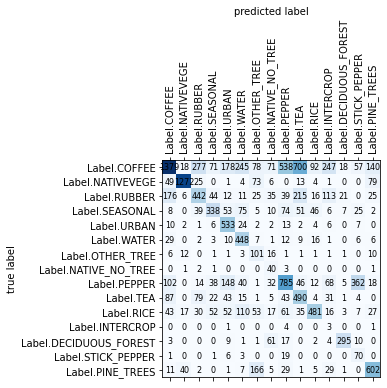

In [15]:
plot_confusion_matrix(conf_matrices[0], labels)

In [16]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.72426471 0.92982456 0.48411829 0.58578856 0.50858779 0.45436105
 0.19688109 0.13289037 0.47924298 0.31349968 0.70424597 0.00570342
 0.83806818 0.12773723 0.66081229]
Mean precision:  0.4764017450381963

Recalls:  [0.33560477 0.83300589 0.37457627 0.45737483 0.87091503 0.81454545
 0.6516129  0.83333333 0.46977858 0.59393939 0.47908367 0.33333333
 0.73200993 0.7        0.66963293]
Mean recall:  0.6099164206063695

F-Score:  [0.45867288 0.87875648 0.42236025 0.51367781 0.64216867 0.58333333
 0.30239521 0.22922636 0.47446358 0.41038526 0.57024303 0.01121495
 0.78145695 0.21604938 0.66519337]
Mean f-score:  0.4773065019551172


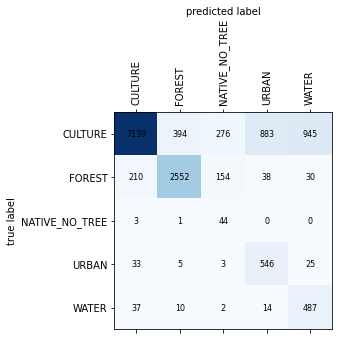

In [17]:
plot_confusion_matrix(conf_matrices[1], [label.name for label in LabelCategory])

In [18]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.96187012 0.86158001 0.09185804 0.36866982 0.32750504]
Mean precision:  0.5222966056714663

Recalls:  [0.7407907  0.85522788 0.91666667 0.89215686 0.88545455]
Mean recall:  0.8580593318809244

F-Score:  [0.83697755 0.8583922  0.16698292 0.52173913 0.47815415]
Mean f-score:  0.5724491891671718


## Categorical focal loss

In [19]:
model_name = "january_to_april_2018_multi_output_focal_loss"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
432/432 [==============================] - 3s 5ms/step - loss: 0.1892 - label_loss: 0.1586 - category_loss: 0.0306 - label_accuracy: 0.6610 - category_accuracy: 0.8928
Epoch 2/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1668 - label_loss: 0.1418 - category_loss: 0.0250 - label_accuracy: 0.6772 - category_accuracy: 0.9059
Epoch 3/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1583 - label_loss: 0.1355 - category_loss: 0.0229 - label_accuracy: 0.6935 - category_accuracy: 0.9067
Epoch 4/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1515 - label_loss: 0.1298 - category_loss: 0.0217 - label_accuracy: 0.6961 - category_accuracy: 0.9097
Epoch 5/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1468 - label_loss: 0.1257 - category_loss: 0.0210 - label_accuracy: 0.7037 - category_accuracy: 0.9138
Epoch 6/500
432/432 [==============================] - 2s 6ms/step - loss: 0.1461 - label_loss: 0.12

432/432 [==============================] - 3s 6ms/step - loss: 0.1018 - label_loss: 0.0866 - category_loss: 0.0152 - label_accuracy: 0.7660 - category_accuracy: 0.9306
Epoch 92/500
432/432 [==============================] - 3s 6ms/step - loss: 0.0969 - label_loss: 0.0825 - category_loss: 0.0144 - label_accuracy: 0.7734 - category_accuracy: 0.9339
Epoch 93/500
432/432 [==============================] - 3s 6ms/step - loss: 0.1006 - label_loss: 0.0855 - category_loss: 0.0150 - label_accuracy: 0.7701 - category_accuracy: 0.9318
Epoch 94/500
432/432 [==============================] - 3s 7ms/step - loss: 0.0983 - label_loss: 0.0836 - category_loss: 0.0148 - label_accuracy: 0.7688 - category_accuracy: 0.9336
Epoch 95/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0993 - label_loss: 0.0845 - category_loss: 0.0149 - label_accuracy: 0.7715 - category_accuracy: 0.9351
Epoch 96/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0951 - label_loss: 0.0809 - ca

432/432 [==============================] - 2s 5ms/step - loss: 0.0851 - label_loss: 0.0720 - category_loss: 0.0130 - label_accuracy: 0.7928 - category_accuracy: 0.9433
Epoch 182/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0884 - label_loss: 0.0745 - category_loss: 0.0140 - label_accuracy: 0.7931 - category_accuracy: 0.9397
Epoch 183/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0888 - label_loss: 0.0749 - category_loss: 0.0139 - label_accuracy: 0.7941 - category_accuracy: 0.9401
Epoch 184/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0888 - label_loss: 0.0748 - category_loss: 0.0140 - label_accuracy: 0.7920 - category_accuracy: 0.9408
Epoch 185/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0855 - label_loss: 0.0723 - category_loss: 0.0132 - label_accuracy: 0.7921 - category_accuracy: 0.9383
Epoch 186/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0854 - label_loss: 0.0719

432/432 [==============================] - 2s 5ms/step - loss: 0.0807 - label_loss: 0.0681 - category_loss: 0.0126 - label_accuracy: 0.8042 - category_accuracy: 0.9437
Epoch 272/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0774 - label_loss: 0.0651 - category_loss: 0.0123 - label_accuracy: 0.8095 - category_accuracy: 0.9426
Epoch 273/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0816 - label_loss: 0.0687 - category_loss: 0.0129 - label_accuracy: 0.8001 - category_accuracy: 0.9426
Epoch 274/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0838 - label_loss: 0.0703 - category_loss: 0.0135 - label_accuracy: 0.7965 - category_accuracy: 0.9396
Epoch 275/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0803 - label_loss: 0.0674 - category_loss: 0.0129 - label_accuracy: 0.8023 - category_accuracy: 0.9442
Epoch 276/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0809 - label_loss: 0.0681

432/432 [==============================] - 2s 5ms/step - loss: 0.0771 - label_loss: 0.0644 - category_loss: 0.0126 - label_accuracy: 0.8095 - category_accuracy: 0.9457
Epoch 362/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0775 - label_loss: 0.0645 - category_loss: 0.0130 - label_accuracy: 0.8091 - category_accuracy: 0.9451
Epoch 363/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0796 - label_loss: 0.0667 - category_loss: 0.0129 - label_accuracy: 0.8086 - category_accuracy: 0.9455
Epoch 364/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0752 - label_loss: 0.0627 - category_loss: 0.0126 - label_accuracy: 0.8137 - category_accuracy: 0.9435
Epoch 365/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0759 - label_loss: 0.0633 - category_loss: 0.0126 - label_accuracy: 0.8138 - category_accuracy: 0.9436
Epoch 366/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0753 - label_loss: 0.0633

432/432 [==============================] - 2s 5ms/step - loss: 0.0750 - label_loss: 0.0627 - category_loss: 0.0123 - label_accuracy: 0.8119 - category_accuracy: 0.9449
Epoch 452/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0701 - label_loss: 0.0589 - category_loss: 0.0112 - label_accuracy: 0.8240 - category_accuracy: 0.9489
Epoch 453/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0750 - label_loss: 0.0630 - category_loss: 0.0120 - label_accuracy: 0.8143 - category_accuracy: 0.9467
Epoch 454/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0727 - label_loss: 0.0607 - category_loss: 0.0120 - label_accuracy: 0.8186 - category_accuracy: 0.9463
Epoch 455/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0701 - label_loss: 0.0587 - category_loss: 0.0114 - label_accuracy: 0.8185 - category_accuracy: 0.9488
Epoch 456/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0746 - label_loss: 0.0620

In [21]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [22]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.16796304285526276
accuracy:  0.1413089632987976


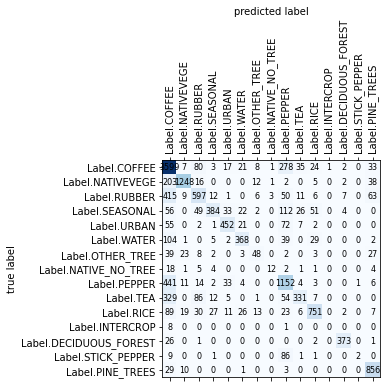

In [23]:
plot_confusion_matrix(conf_matrices[0], labels)

In [24]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.66402214 0.93905192 0.6722973  0.84768212 0.81588448 0.78969957
 0.53333333 0.70588235 0.61407249 0.78436019 0.84858757 0.
 0.95641026 0.66666667 0.82545805]
Mean precision:  0.7108938959399197

Recalls:  [0.87588221 0.8172888  0.5059322  0.51962111 0.73856209 0.66909091
 0.30967742 0.25       0.68940754 0.40121212 0.74800797 0.
 0.92555831 0.02       0.95216908]
Mean recall:  0.5614939842295434

F-Score:  [0.75537832 0.87394958 0.57736944 0.6442953  0.77530017 0.72440945
 0.39183673 0.36923077 0.64956301 0.5308741  0.7951297         nan
 0.9407314  0.03883495 0.88429752]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/src/statisticsUtils.py:106: RuntimeWarning: invalid value encountered in true_divide
  fscore = 2 * recall * precision / (recall + precision)


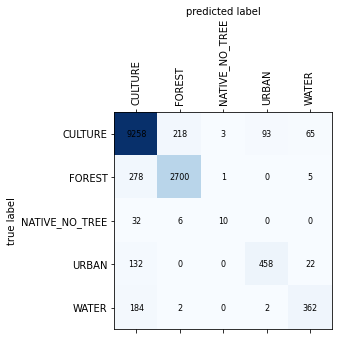

In [25]:
plot_confusion_matrix(conf_matrices[1], [category.name for category in LabelCategory])

In [26]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.93666532 0.92276145 0.71428571 0.82820976 0.79735683]
Mean precision:  0.8398558148321117

Recalls:  [0.96067241 0.90482574 0.20833333 0.74836601 0.65818182]
Mean recall:  0.6960758620556643

F-Score:  [0.94851698 0.91370558 0.32258065 0.78626609 0.72111554]
Mean f-score:  0.7384369685797689


# Categorical focal loss with correct range

In [12]:
# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0001)(inputs) # the correct rescaling factor for surface reflectance dataset
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

model_name = "january_to_april_2018_multi_output_focal_loss"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
432/432 [==============================] - 2s 3ms/step - loss: 0.3838 - label_loss: 0.3082 - category_loss: 0.0756 - label_accuracy: 0.4429 - category_accuracy: 0.7769
Epoch 2/500
432/432 [==============================] - 1s 3ms/step - loss: 0.2729 - label_loss: 0.2230 - category_loss: 0.0499 - label_accuracy: 0.5497 - category_accuracy: 0.8286
Epoch 3/500
432/432 [==============================] - 1s 3ms/step - loss: 0.2397 - label_loss: 0.1980 - category_loss: 0.0418 - label_accuracy: 0.5954 - category_accuracy: 0.8533
Epoch 4/500
432/432 [==============================] - 1s 3ms/step - loss: 0.2190 - label_loss: 0.1813 - category_loss: 0.0377 - label_accuracy: 0.6213 - category_accuracy: 0.8702
Epoch 5/500
432/432 [==============================] - 1s 3ms/step - loss: 0.2067 - label_loss: 0.1713 - category_loss: 0.0354 - label_accuracy: 0.6343 - category_accuracy: 0.8736
Epoch 6/500
432/432 [==============================] - 1s 3ms/step - loss: 0.1924 - label_loss: 0.15

432/432 [==============================] - 2s 5ms/step - loss: 0.0853 - label_loss: 0.0711 - category_loss: 0.0142 - label_accuracy: 0.7982 - category_accuracy: 0.9383
Epoch 92/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0870 - label_loss: 0.0721 - category_loss: 0.0149 - label_accuracy: 0.7920 - category_accuracy: 0.9366
Epoch 93/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0848 - label_loss: 0.0707 - category_loss: 0.0141 - label_accuracy: 0.7983 - category_accuracy: 0.9371
Epoch 94/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0865 - label_loss: 0.0715 - category_loss: 0.0150 - label_accuracy: 0.8000 - category_accuracy: 0.9398
Epoch 95/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0855 - label_loss: 0.0717 - category_loss: 0.0139 - label_accuracy: 0.7947 - category_accuracy: 0.9382
Epoch 96/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0870 - label_loss: 0.0720 - ca

432/432 [==============================] - 2s 6ms/step - loss: 0.0708 - label_loss: 0.0591 - category_loss: 0.0117 - label_accuracy: 0.8177 - category_accuracy: 0.9456
Epoch 182/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0748 - label_loss: 0.0618 - category_loss: 0.0131 - label_accuracy: 0.8129 - category_accuracy: 0.9409
Epoch 183/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0763 - label_loss: 0.0629 - category_loss: 0.0133 - label_accuracy: 0.8082 - category_accuracy: 0.9409
Epoch 184/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0731 - label_loss: 0.0604 - category_loss: 0.0126 - label_accuracy: 0.8166 - category_accuracy: 0.9451
Epoch 185/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0721 - label_loss: 0.0592 - category_loss: 0.0128 - label_accuracy: 0.8186 - category_accuracy: 0.9440
Epoch 186/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0722 - label_loss: 0.0593

432/432 [==============================] - 2s 5ms/step - loss: 0.0689 - label_loss: 0.0570 - category_loss: 0.0120 - label_accuracy: 0.8301 - category_accuracy: 0.9476
Epoch 272/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0683 - label_loss: 0.0564 - category_loss: 0.0119 - label_accuracy: 0.8251 - category_accuracy: 0.9462
Epoch 273/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0684 - label_loss: 0.0565 - category_loss: 0.0120 - label_accuracy: 0.8237 - category_accuracy: 0.9479
Epoch 274/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0682 - label_loss: 0.0562 - category_loss: 0.0120 - label_accuracy: 0.8299 - category_accuracy: 0.9456
Epoch 275/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0690 - label_loss: 0.0572 - category_loss: 0.0118 - label_accuracy: 0.8296 - category_accuracy: 0.9475
Epoch 276/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0687 - label_loss: 0.0573

432/432 [==============================] - 2s 5ms/step - loss: 0.0674 - label_loss: 0.0559 - category_loss: 0.0116 - label_accuracy: 0.8321 - category_accuracy: 0.9496
Epoch 362/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0646 - label_loss: 0.0531 - category_loss: 0.0114 - label_accuracy: 0.8366 - category_accuracy: 0.9518
Epoch 363/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0637 - label_loss: 0.0534 - category_loss: 0.0103 - label_accuracy: 0.8344 - category_accuracy: 0.9522
Epoch 364/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0672 - label_loss: 0.0554 - category_loss: 0.0118 - label_accuracy: 0.8300 - category_accuracy: 0.9484
Epoch 365/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0670 - label_loss: 0.0551 - category_loss: 0.0119 - label_accuracy: 0.8329 - category_accuracy: 0.9516
Epoch 366/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0669 - label_loss: 0.0548

432/432 [==============================] - 2s 5ms/step - loss: 0.0662 - label_loss: 0.0545 - category_loss: 0.0117 - label_accuracy: 0.8348 - category_accuracy: 0.9520
Epoch 452/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0614 - label_loss: 0.0509 - category_loss: 0.0104 - label_accuracy: 0.8415 - category_accuracy: 0.9542
Epoch 453/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0648 - label_loss: 0.0530 - category_loss: 0.0118 - label_accuracy: 0.8370 - category_accuracy: 0.9515
Epoch 454/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0650 - label_loss: 0.0535 - category_loss: 0.0115 - label_accuracy: 0.8371 - category_accuracy: 0.9530
Epoch 455/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0627 - label_loss: 0.0517 - category_loss: 0.0110 - label_accuracy: 0.8432 - category_accuracy: 0.9509
Epoch 456/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0626 - label_loss: 0.0514

In [14]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [15]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.16072291135787964
accuracy:  0.13449615240097046


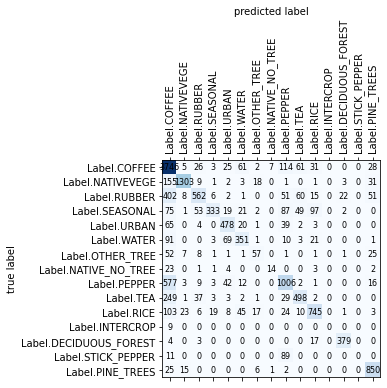

In [16]:
plot_confusion_matrix(conf_matrices[0], labels)

In [20]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.67048505 0.95387994 0.78272981 0.89276139 0.73200613 0.67891683
 0.54285714 0.63636364 0.69236063 0.7270073  0.79509072        nan
 0.92892157        nan 0.84409136]
Mean precision:  nan

Recalls:  [0.91165734 0.85330714 0.47627119 0.45060893 0.78104575 0.63818182
 0.36774194 0.29166667 0.60203471 0.60363636 0.74203187 0.
 0.94044665 0.         0.94549499]
Mean recall:  0.573608357039286

F-Score:  [0.77268977 0.90079502 0.59220232 0.59892086 0.75573123 0.6579194
 0.43846154 0.4        0.64404609 0.65960265 0.76764554        nan
 0.93464858        nan 0.89192025]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/src/statisticsUtils.py:104: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)


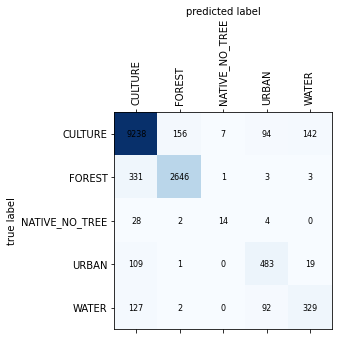

In [18]:
plot_confusion_matrix(conf_matrices[1], [label.name for label in LabelCategory])

In [19]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.93948947 0.94264339 0.63636364 0.71449704 0.6673428 ]
Mean precision:  0.7800672685426117

Recalls:  [0.95859707 0.88672922 0.29166667 0.78921569 0.59818182]
Mean recall:  0.7048780934842497

F-Score:  [0.9489471  0.91383181 0.4        0.75       0.63087248]
Mean f-score:  0.7287302778598027


## January to april, categories and labels updated, collection2 

In [5]:
EPOCHS = 2000
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [6]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset)

In [7]:
# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs) # the correct rescaling factor for surface reflectance dataset
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

model_name = "january_to_april_2018_multi_output_focal_loss_collection2_new_categories"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
mean_loss, mean_accuracy, histories, conf_matrices = cross_validation_multi_output_model(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name, categories=categories)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1730 - label_loss: 0.1343 - category_loss: 0.0387 - label_accuracy: 0.7068 - category_accuracy: 0.8809 - val_loss: 0.1478 - val_label_loss: 0.1131 - val_category_loss: 0.0347 - val_label_accuracy: 0.7378 - val_category_accuracy: 0.8909
Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1670 - label_loss: 0.1309 - category_loss: 0.0362 - label_accuracy: 0.7052 - category_accuracy: 0.8819 - val_loss: 0.1437 - val_label_loss: 0.1094 - val_category_loss: 0.0343 - val_label_accuracy: 0.7513 - val_category_accuracy: 0.8902
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1667 - label_loss: 0.1299 - category_loss: 0.0368 - label_accuracy: 0.7139 - category_accuracy: 0.8844 - val_loss: 0.1551 - val_label_loss: 0.1203 - val_category_loss: 0.0348 - val_label_accuracy: 0.7385 - val_category_accuracy: 0.8813
Epoch 19/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1213 - label_loss: 0.0945 - category_loss: 0.0268 - label_accuracy: 0.7599 - category_accuracy: 0.9073 - val_loss: 0.1126 - val_label_loss: 0.0846 - val_category_loss: 0.0280 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9101
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1276 - label_loss: 0.1001 - category_loss: 0.0275 - label_accuracy: 0.7493 - category_accuracy: 0.8997 - val_loss: 0.1168 - val_label_loss: 0.0890 - val_category_loss: 0.0278 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9076
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1228 - label_loss: 0.0955 - category_loss: 0.0273 - label_accuracy: 0.7615 - category_accuracy: 0.9043 - val_loss: 0.1149 - val_label_loss: 0.0867 - val_category_loss: 0.0282 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9066
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1037 - label_loss: 0.0805 - category_loss: 0.0233 - label_accuracy: 0.7824 - category_accuracy: 0.9137 - val_loss: 0.0982 - val_label_loss: 0.0745 - val_category_loss: 0.0237 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9194
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1032 - label_loss: 0.0805 - category_loss: 0.0227 - label_accuracy: 0.7797 - category_accuracy: 0.9149 - val_loss: 0.1109 - val_label_loss: 0.0828 - val_category_loss: 0.0281 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9137
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1020 - label_loss: 0.0797 - category_loss: 0.0223 - label_accuracy: 0.7849 - category_accuracy: 0.9189 - val_loss: 0.1118 - val_label_loss: 0.0835 - val_category_loss: 0.0283 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9030
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0942 - label_loss: 0.0737 - category_loss: 0.0205 - label_accuracy: 0.7964 - category_accuracy: 0.9197 - val_loss: 0.1117 - val_label_loss: 0.0821 - val_category_loss: 0.0296 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9179
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0989 - label_loss: 0.0770 - category_loss: 0.0219 - label_accuracy: 0.7885 - category_accuracy: 0.9187 - val_loss: 0.1099 - val_label_loss: 0.0834 - val_category_loss: 0.0265 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9115
Epoch 122/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0936 - label_loss: 0.0733 - category_loss: 0.0202 - label_accuracy: 0.7853 - category_accuracy: 0.9180 - val_loss: 0.1015 - val_label_loss: 0.0770 - val_category_loss: 0.0245 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9211
Epoch 123/2000
351/351 [============================

Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0911 - label_loss: 0.0718 - category_loss: 0.0193 - label_accuracy: 0.7990 - category_accuracy: 0.9262 - val_loss: 0.1033 - val_label_loss: 0.0780 - val_category_loss: 0.0253 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9215
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0895 - label_loss: 0.0705 - category_loss: 0.0191 - label_accuracy: 0.7987 - category_accuracy: 0.9272 - val_loss: 0.1070 - val_label_loss: 0.0808 - val_category_loss: 0.0262 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9229
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0905 - label_loss: 0.0705 - category_loss: 0.0200 - label_accuracy: 0.8011 - category_accuracy: 0.9265 - val_loss: 0.1008 - val_label_loss: 0.0766 - val_category_loss: 0.0241 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9261
Epoch 149/2000
351/351 [============================

Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0894 - label_loss: 0.0699 - category_loss: 0.0195 - label_accuracy: 0.8030 - category_accuracy: 0.9256 - val_loss: 0.1004 - val_label_loss: 0.0757 - val_category_loss: 0.0247 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9211
Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0664 - category_loss: 0.0182 - label_accuracy: 0.8026 - category_accuracy: 0.9258 - val_loss: 0.1052 - val_label_loss: 0.0785 - val_category_loss: 0.0267 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9233
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0875 - label_loss: 0.0677 - category_loss: 0.0199 - label_accuracy: 0.7978 - category_accuracy: 0.9249 - val_loss: 0.1058 - val_label_loss: 0.0787 - val_category_loss: 0.0270 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9187
Epoch 175/2000
351/351 [============================

Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0868 - label_loss: 0.0683 - category_loss: 0.0185 - label_accuracy: 0.8068 - category_accuracy: 0.9269 - val_loss: 0.0991 - val_label_loss: 0.0743 - val_category_loss: 0.0248 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9204
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0841 - label_loss: 0.0656 - category_loss: 0.0185 - label_accuracy: 0.8139 - category_accuracy: 0.9284 - val_loss: 0.0975 - val_label_loss: 0.0733 - val_category_loss: 0.0242 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9226
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0870 - label_loss: 0.0681 - category_loss: 0.0189 - label_accuracy: 0.8076 - category_accuracy: 0.9289 - val_loss: 0.1038 - val_label_loss: 0.0761 - val_category_loss: 0.0277 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9194
Epoch 201/2000
351/351 [============================

Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0614 - category_loss: 0.0164 - label_accuracy: 0.8131 - category_accuracy: 0.9340 - val_loss: 0.1098 - val_label_loss: 0.0809 - val_category_loss: 0.0289 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9094
Epoch 225/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0853 - label_loss: 0.0667 - category_loss: 0.0186 - label_accuracy: 0.8090 - category_accuracy: 0.9275 - val_loss: 0.1037 - val_label_loss: 0.0768 - val_category_loss: 0.0269 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9275
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0838 - label_loss: 0.0655 - category_loss: 0.0183 - label_accuracy: 0.8078 - category_accuracy: 0.9260 - val_loss: 0.1076 - val_label_loss: 0.0794 - val_category_loss: 0.0282 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9190
Epoch 227/2000
351/351 [============================

Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0836 - label_loss: 0.0661 - category_loss: 0.0175 - label_accuracy: 0.8077 - category_accuracy: 0.9306 - val_loss: 0.1031 - val_label_loss: 0.0772 - val_category_loss: 0.0259 - val_label_accuracy: 0.8281 - val_category_accuracy: 0.9201
Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0614 - category_loss: 0.0169 - label_accuracy: 0.8192 - category_accuracy: 0.9329 - val_loss: 0.1001 - val_label_loss: 0.0744 - val_category_loss: 0.0258 - val_label_accuracy: 0.8313 - val_category_accuracy: 0.9261
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0624 - category_loss: 0.0169 - label_accuracy: 0.8194 - category_accuracy: 0.9328 - val_loss: 0.1077 - val_label_loss: 0.0792 - val_category_loss: 0.0285 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9247
Epoch 253/2000
351/351 [============================

Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0787 - label_loss: 0.0616 - category_loss: 0.0172 - label_accuracy: 0.8182 - category_accuracy: 0.9282 - val_loss: 0.1064 - val_label_loss: 0.0796 - val_category_loss: 0.0268 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9169
Epoch 277/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0766 - label_loss: 0.0608 - category_loss: 0.0158 - label_accuracy: 0.8193 - category_accuracy: 0.9327 - val_loss: 0.1024 - val_label_loss: 0.0759 - val_category_loss: 0.0265 - val_label_accuracy: 0.8245 - val_category_accuracy: 0.9272
Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0744 - label_loss: 0.0585 - category_loss: 0.0159 - label_accuracy: 0.8237 - category_accuracy: 0.9359 - val_loss: 0.1022 - val_label_loss: 0.0760 - val_category_loss: 0.0262 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9211
Epoch 279/2000
351/351 [============================

Epoch 302/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0776 - label_loss: 0.0606 - category_loss: 0.0170 - label_accuracy: 0.8250 - category_accuracy: 0.9353 - val_loss: 0.1114 - val_label_loss: 0.0825 - val_category_loss: 0.0288 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9222
Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0586 - category_loss: 0.0161 - label_accuracy: 0.8171 - category_accuracy: 0.9349 - val_loss: 0.1096 - val_label_loss: 0.0799 - val_category_loss: 0.0297 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9208
Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0735 - label_loss: 0.0570 - category_loss: 0.0165 - label_accuracy: 0.8230 - category_accuracy: 0.9338 - val_loss: 0.1085 - val_label_loss: 0.0799 - val_category_loss: 0.0285 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9190
Epoch 305/2000
351/351 [============================

Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0768 - label_loss: 0.0601 - category_loss: 0.0168 - label_accuracy: 0.8260 - category_accuracy: 0.9345 - val_loss: 0.1075 - val_label_loss: 0.0790 - val_category_loss: 0.0285 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9211
Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0773 - label_loss: 0.0603 - category_loss: 0.0169 - label_accuracy: 0.8167 - category_accuracy: 0.9314 - val_loss: 0.1119 - val_label_loss: 0.0825 - val_category_loss: 0.0294 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9172
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0757 - label_loss: 0.0592 - category_loss: 0.0166 - label_accuracy: 0.8266 - category_accuracy: 0.9376 - val_loss: 0.1123 - val_label_loss: 0.0834 - val_category_loss: 0.0289 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9226
Epoch 331/2000
351/351 [============================

Epoch 3/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.3074 - label_loss: 0.2367 - category_loss: 0.0707 - label_accuracy: 0.5464 - category_accuracy: 0.8065 - val_loss: 0.2502 - val_label_loss: 0.1963 - val_category_loss: 0.0539 - val_label_accuracy: 0.6032 - val_category_accuracy: 0.8497
Epoch 4/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2743 - label_loss: 0.2118 - category_loss: 0.0625 - label_accuracy: 0.5846 - category_accuracy: 0.8214 - val_loss: 0.2483 - val_label_loss: 0.1917 - val_category_loss: 0.0566 - val_label_accuracy: 0.5982 - val_category_accuracy: 0.8242
Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2610 - label_loss: 0.2018 - category_loss: 0.0592 - label_accuracy: 0.5949 - category_accuracy: 0.8306 - val_loss: 0.2174 - val_label_loss: 0.1703 - val_category_loss: 0.0471 - val_label_accuracy: 0.6426 - val_category_accuracy: 0.8632
Epoch 6/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1423 - label_loss: 0.1107 - category_loss: 0.0316 - label_accuracy: 0.7329 - category_accuracy: 0.8946 - val_loss: 0.1271 - val_label_loss: 0.0983 - val_category_loss: 0.0289 - val_label_accuracy: 0.7591 - val_category_accuracy: 0.9016
Epoch 30/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1469 - label_loss: 0.1144 - category_loss: 0.0325 - label_accuracy: 0.7330 - category_accuracy: 0.8927 - val_loss: 0.1333 - val_label_loss: 0.1013 - val_category_loss: 0.0320 - val_label_accuracy: 0.7556 - val_category_accuracy: 0.8966
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1443 - label_loss: 0.1120 - category_loss: 0.0323 - label_accuracy: 0.7261 - category_accuracy: 0.8947 - val_loss: 0.1258 - val_label_loss: 0.0986 - val_category_loss: 0.0272 - val_label_accuracy: 0.7574 - val_category_accuracy: 0.9133
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1082 - label_loss: 0.0839 - category_loss: 0.0243 - label_accuracy: 0.7750 - category_accuracy: 0.9096 - val_loss: 0.1047 - val_label_loss: 0.0811 - val_category_loss: 0.0237 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9197
Epoch 82/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1071 - label_loss: 0.0823 - category_loss: 0.0247 - label_accuracy: 0.7815 - category_accuracy: 0.9146 - val_loss: 0.1050 - val_label_loss: 0.0813 - val_category_loss: 0.0238 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9215
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1108 - label_loss: 0.0861 - category_loss: 0.0248 - label_accuracy: 0.7715 - category_accuracy: 0.9100 - val_loss: 0.1086 - val_label_loss: 0.0841 - val_category_loss: 0.0245 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9176
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0975 - label_loss: 0.0760 - category_loss: 0.0215 - label_accuracy: 0.7912 - category_accuracy: 0.9177 - val_loss: 0.1024 - val_label_loss: 0.0800 - val_category_loss: 0.0224 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9187
Epoch 108/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0991 - label_loss: 0.0774 - category_loss: 0.0218 - label_accuracy: 0.7871 - category_accuracy: 0.9149 - val_loss: 0.1040 - val_label_loss: 0.0805 - val_category_loss: 0.0235 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9158
Epoch 109/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1040 - label_loss: 0.0806 - category_loss: 0.0233 - label_accuracy: 0.7853 - category_accuracy: 0.9135 - val_loss: 0.1000 - val_label_loss: 0.0780 - val_category_loss: 0.0220 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9300
Epoch 110/2000
351/351 [==============================] - 1s 4ms/st

Epoch 133/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0978 - label_loss: 0.0757 - category_loss: 0.0221 - label_accuracy: 0.7905 - category_accuracy: 0.9200 - val_loss: 0.0977 - val_label_loss: 0.0748 - val_category_loss: 0.0229 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9254
Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0944 - label_loss: 0.0739 - category_loss: 0.0205 - label_accuracy: 0.7955 - category_accuracy: 0.9213 - val_loss: 0.0966 - val_label_loss: 0.0743 - val_category_loss: 0.0223 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9275
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0933 - label_loss: 0.0726 - category_loss: 0.0206 - label_accuracy: 0.7976 - category_accuracy: 0.9210 - val_loss: 0.1055 - val_label_loss: 0.0800 - val_category_loss: 0.0255 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9176
Epoch 136/2000
351/351 [============================

Epoch 159/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0903 - label_loss: 0.0703 - category_loss: 0.0200 - label_accuracy: 0.7963 - category_accuracy: 0.9218 - val_loss: 0.1120 - val_label_loss: 0.0856 - val_category_loss: 0.0263 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9123
Epoch 160/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0914 - label_loss: 0.0707 - category_loss: 0.0208 - label_accuracy: 0.7980 - category_accuracy: 0.9204 - val_loss: 0.1048 - val_label_loss: 0.0788 - val_category_loss: 0.0260 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9229
Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0912 - label_loss: 0.0706 - category_loss: 0.0206 - label_accuracy: 0.7944 - category_accuracy: 0.9205 - val_loss: 0.0999 - val_label_loss: 0.0768 - val_category_loss: 0.0231 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9243
Epoch 162/2000
351/351 [============================

Epoch 185/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0888 - label_loss: 0.0689 - category_loss: 0.0200 - label_accuracy: 0.8003 - category_accuracy: 0.9229 - val_loss: 0.0925 - val_label_loss: 0.0716 - val_category_loss: 0.0209 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9290
Epoch 186/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0883 - label_loss: 0.0689 - category_loss: 0.0194 - label_accuracy: 0.8092 - category_accuracy: 0.9245 - val_loss: 0.0998 - val_label_loss: 0.0779 - val_category_loss: 0.0219 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9236
Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0856 - label_loss: 0.0665 - category_loss: 0.0191 - label_accuracy: 0.8051 - category_accuracy: 0.9258 - val_loss: 0.0976 - val_label_loss: 0.0757 - val_category_loss: 0.0219 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9240
Epoch 188/2000
351/351 [============================

Epoch 211/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0817 - label_loss: 0.0637 - category_loss: 0.0180 - label_accuracy: 0.8143 - category_accuracy: 0.9311 - val_loss: 0.0978 - val_label_loss: 0.0760 - val_category_loss: 0.0218 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9254
Epoch 212/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0919 - label_loss: 0.0717 - category_loss: 0.0203 - label_accuracy: 0.7950 - category_accuracy: 0.9244 - val_loss: 0.0969 - val_label_loss: 0.0739 - val_category_loss: 0.0229 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9222
Epoch 213/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0834 - label_loss: 0.0652 - category_loss: 0.0182 - label_accuracy: 0.8106 - category_accuracy: 0.9277 - val_loss: 0.0971 - val_label_loss: 0.0748 - val_category_loss: 0.0223 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9261
Epoch 214/2000
351/351 [============================

Epoch 237/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0790 - label_loss: 0.0616 - category_loss: 0.0174 - label_accuracy: 0.8151 - category_accuracy: 0.9285 - val_loss: 0.0889 - val_label_loss: 0.0680 - val_category_loss: 0.0210 - val_label_accuracy: 0.8313 - val_category_accuracy: 0.9353
Epoch 238/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0853 - label_loss: 0.0662 - category_loss: 0.0191 - label_accuracy: 0.8062 - category_accuracy: 0.9255 - val_loss: 0.0988 - val_label_loss: 0.0772 - val_category_loss: 0.0216 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9236
Epoch 239/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0818 - label_loss: 0.0638 - category_loss: 0.0180 - label_accuracy: 0.8106 - category_accuracy: 0.9306 - val_loss: 0.0881 - val_label_loss: 0.0689 - val_category_loss: 0.0192 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9357
Epoch 240/2000
351/351 [============================

Epoch 263/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0834 - label_loss: 0.0648 - category_loss: 0.0186 - label_accuracy: 0.8169 - category_accuracy: 0.9293 - val_loss: 0.0972 - val_label_loss: 0.0749 - val_category_loss: 0.0223 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9286
Epoch 264/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0785 - label_loss: 0.0618 - category_loss: 0.0168 - label_accuracy: 0.8187 - category_accuracy: 0.9339 - val_loss: 0.0940 - val_label_loss: 0.0720 - val_category_loss: 0.0220 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9293
Epoch 265/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0833 - label_loss: 0.0645 - category_loss: 0.0187 - label_accuracy: 0.8155 - category_accuracy: 0.9292 - val_loss: 0.0943 - val_label_loss: 0.0731 - val_category_loss: 0.0211 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9300
Epoch 266/2000
351/351 [============================

Epoch 289/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0863 - label_loss: 0.0668 - category_loss: 0.0195 - label_accuracy: 0.8073 - category_accuracy: 0.9286 - val_loss: 0.0978 - val_label_loss: 0.0756 - val_category_loss: 0.0222 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9311
Epoch 290/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0808 - label_loss: 0.0627 - category_loss: 0.0181 - label_accuracy: 0.8176 - category_accuracy: 0.9293 - val_loss: 0.0985 - val_label_loss: 0.0762 - val_category_loss: 0.0222 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9265
Epoch 291/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0796 - label_loss: 0.0620 - category_loss: 0.0176 - label_accuracy: 0.8202 - category_accuracy: 0.9304 - val_loss: 0.0975 - val_label_loss: 0.0750 - val_category_loss: 0.0225 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9307
Epoch 292/2000
351/351 [============================

Epoch 315/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0784 - label_loss: 0.0613 - category_loss: 0.0172 - label_accuracy: 0.8215 - category_accuracy: 0.9332 - val_loss: 0.0935 - val_label_loss: 0.0712 - val_category_loss: 0.0223 - val_label_accuracy: 0.8274 - val_category_accuracy: 0.9265
Epoch 316/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0607 - category_loss: 0.0174 - label_accuracy: 0.8225 - category_accuracy: 0.9313 - val_loss: 0.0916 - val_label_loss: 0.0706 - val_category_loss: 0.0209 - val_label_accuracy: 0.8284 - val_category_accuracy: 0.9329
Epoch 317/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0778 - label_loss: 0.0605 - category_loss: 0.0173 - label_accuracy: 0.8185 - category_accuracy: 0.9285 - val_loss: 0.0942 - val_label_loss: 0.0724 - val_category_loss: 0.0218 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9172
Epoch 318/2000
351/351 [============================

Epoch 8/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.2222 - label_loss: 0.1734 - category_loss: 0.0487 - label_accuracy: 0.6427 - category_accuracy: 0.8527 - val_loss: 0.1820 - val_label_loss: 0.1422 - val_category_loss: 0.0397 - val_label_accuracy: 0.6995 - val_category_accuracy: 0.8782
Epoch 9/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2154 - label_loss: 0.1680 - category_loss: 0.0474 - label_accuracy: 0.6558 - category_accuracy: 0.8583 - val_loss: 0.1855 - val_label_loss: 0.1439 - val_category_loss: 0.0415 - val_label_accuracy: 0.6934 - val_category_accuracy: 0.8700
Epoch 10/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1982 - label_loss: 0.1548 - category_loss: 0.0435 - label_accuracy: 0.6742 - category_accuracy: 0.8683 - val_loss: 0.1698 - val_label_loss: 0.1323 - val_category_loss: 0.0375 - val_label_accuracy: 0.7147 - val_category_accuracy: 0.8902
Epoch 11/2000
351/351 [==============================] - 

351/351 [==============================] - 1s 4ms/step - loss: 0.1340 - label_loss: 0.1039 - category_loss: 0.0301 - label_accuracy: 0.7471 - category_accuracy: 0.8989 - val_loss: 0.1366 - val_label_loss: 0.1026 - val_category_loss: 0.0339 - val_label_accuracy: 0.7670 - val_category_accuracy: 0.8973
Epoch 35/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1325 - label_loss: 0.1032 - category_loss: 0.0293 - label_accuracy: 0.7470 - category_accuracy: 0.8996 - val_loss: 0.1406 - val_label_loss: 0.1054 - val_category_loss: 0.0352 - val_label_accuracy: 0.7595 - val_category_accuracy: 0.8867
Epoch 36/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1345 - label_loss: 0.1042 - category_loss: 0.0303 - label_accuracy: 0.7447 - category_accuracy: 0.8943 - val_loss: 0.1216 - val_label_loss: 0.0929 - val_category_loss: 0.0287 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9119
Epoch 37/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1040 - label_loss: 0.0814 - category_loss: 0.0227 - label_accuracy: 0.7768 - category_accuracy: 0.9144 - val_loss: 0.1107 - val_label_loss: 0.0837 - val_category_loss: 0.0270 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9194
Epoch 87/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.1050 - label_loss: 0.0809 - category_loss: 0.0241 - label_accuracy: 0.7792 - category_accuracy: 0.9123 - val_loss: 0.1258 - val_label_loss: 0.0923 - val_category_loss: 0.0335 - val_label_accuracy: 0.7741 - val_category_accuracy: 0.8973
Epoch 88/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1044 - label_loss: 0.0808 - category_loss: 0.0236 - label_accuracy: 0.7752 - category_accuracy: 0.9096 - val_loss: 0.1114 - val_label_loss: 0.0842 - val_category_loss: 0.0272 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9187
Epoch 89/2000
351/351 [==============================] - 1s 3ms/step 

351/351 [==============================] - 1s 3ms/step - loss: 0.0972 - label_loss: 0.0754 - category_loss: 0.0218 - label_accuracy: 0.7910 - category_accuracy: 0.9189 - val_loss: 0.1097 - val_label_loss: 0.0839 - val_category_loss: 0.0258 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9233
Epoch 113/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0989 - label_loss: 0.0763 - category_loss: 0.0226 - label_accuracy: 0.7960 - category_accuracy: 0.9185 - val_loss: 0.1121 - val_label_loss: 0.0847 - val_category_loss: 0.0274 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9137
Epoch 114/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0980 - label_loss: 0.0762 - category_loss: 0.0218 - label_accuracy: 0.7947 - category_accuracy: 0.9195 - val_loss: 0.1121 - val_label_loss: 0.0834 - val_category_loss: 0.0286 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9101
Epoch 115/2000
351/351 [==============================] - 1s 3ms/st

Epoch 138/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0880 - label_loss: 0.0689 - category_loss: 0.0190 - label_accuracy: 0.8098 - category_accuracy: 0.9270 - val_loss: 0.1079 - val_label_loss: 0.0816 - val_category_loss: 0.0263 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9211
Epoch 139/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0920 - label_loss: 0.0716 - category_loss: 0.0204 - label_accuracy: 0.8003 - category_accuracy: 0.9194 - val_loss: 0.0995 - val_label_loss: 0.0764 - val_category_loss: 0.0231 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9268
Epoch 140/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0879 - label_loss: 0.0681 - category_loss: 0.0198 - label_accuracy: 0.8012 - category_accuracy: 0.9205 - val_loss: 0.1029 - val_label_loss: 0.0777 - val_category_loss: 0.0252 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9240
Epoch 141/2000
351/351 [============================

Epoch 164/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0866 - label_loss: 0.0674 - category_loss: 0.0193 - label_accuracy: 0.8042 - category_accuracy: 0.9241 - val_loss: 0.1066 - val_label_loss: 0.0799 - val_category_loss: 0.0267 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9204
Epoch 165/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0901 - label_loss: 0.0694 - category_loss: 0.0208 - label_accuracy: 0.8012 - category_accuracy: 0.9178 - val_loss: 0.1067 - val_label_loss: 0.0814 - val_category_loss: 0.0252 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9254
Epoch 166/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0855 - label_loss: 0.0672 - category_loss: 0.0183 - label_accuracy: 0.8052 - category_accuracy: 0.9263 - val_loss: 0.1075 - val_label_loss: 0.0809 - val_category_loss: 0.0266 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9286
Epoch 167/2000
351/351 [============================

Epoch 190/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0861 - label_loss: 0.0670 - category_loss: 0.0191 - label_accuracy: 0.8154 - category_accuracy: 0.9303 - val_loss: 0.0998 - val_label_loss: 0.0757 - val_category_loss: 0.0241 - val_label_accuracy: 0.8266 - val_category_accuracy: 0.9314
Epoch 191/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0853 - label_loss: 0.0667 - category_loss: 0.0186 - label_accuracy: 0.8069 - category_accuracy: 0.9260 - val_loss: 0.1079 - val_label_loss: 0.0820 - val_category_loss: 0.0259 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9222
Epoch 192/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0876 - label_loss: 0.0689 - category_loss: 0.0188 - label_accuracy: 0.8070 - category_accuracy: 0.9254 - val_loss: 0.1101 - val_label_loss: 0.0830 - val_category_loss: 0.0272 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9250
Epoch 193/2000
351/351 [============================

Epoch 216/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0879 - label_loss: 0.0681 - category_loss: 0.0197 - label_accuracy: 0.8107 - category_accuracy: 0.9294 - val_loss: 0.1037 - val_label_loss: 0.0785 - val_category_loss: 0.0252 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9215
Epoch 217/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0808 - label_loss: 0.0623 - category_loss: 0.0186 - label_accuracy: 0.8190 - category_accuracy: 0.9303 - val_loss: 0.1004 - val_label_loss: 0.0763 - val_category_loss: 0.0241 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9275
Epoch 218/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0836 - label_loss: 0.0653 - category_loss: 0.0183 - label_accuracy: 0.8104 - category_accuracy: 0.9277 - val_loss: 0.1029 - val_label_loss: 0.0782 - val_category_loss: 0.0247 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9307
Epoch 219/2000
351/351 [============================

Epoch 242/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0826 - label_loss: 0.0640 - category_loss: 0.0186 - label_accuracy: 0.8161 - category_accuracy: 0.9292 - val_loss: 0.1103 - val_label_loss: 0.0857 - val_category_loss: 0.0246 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9293
Epoch 243/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0824 - label_loss: 0.0653 - category_loss: 0.0171 - label_accuracy: 0.8132 - category_accuracy: 0.9299 - val_loss: 0.1101 - val_label_loss: 0.0831 - val_category_loss: 0.0270 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9243
Epoch 244/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0814 - label_loss: 0.0631 - category_loss: 0.0184 - label_accuracy: 0.8160 - category_accuracy: 0.9304 - val_loss: 0.1092 - val_label_loss: 0.0836 - val_category_loss: 0.0256 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9215
Epoch 245/2000
351/351 [============================

Epoch 268/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0807 - label_loss: 0.0628 - category_loss: 0.0180 - label_accuracy: 0.8198 - category_accuracy: 0.9296 - val_loss: 0.1016 - val_label_loss: 0.0771 - val_category_loss: 0.0245 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9300
Epoch 269/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0803 - label_loss: 0.0626 - category_loss: 0.0178 - label_accuracy: 0.8195 - category_accuracy: 0.9304 - val_loss: 0.1045 - val_label_loss: 0.0805 - val_category_loss: 0.0241 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9268
Epoch 270/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0771 - label_loss: 0.0604 - category_loss: 0.0167 - label_accuracy: 0.8223 - category_accuracy: 0.9327 - val_loss: 0.1021 - val_label_loss: 0.0775 - val_category_loss: 0.0246 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9197
Epoch 271/2000
351/351 [============================

Epoch 294/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0775 - label_loss: 0.0609 - category_loss: 0.0166 - label_accuracy: 0.8213 - category_accuracy: 0.9341 - val_loss: 0.1030 - val_label_loss: 0.0775 - val_category_loss: 0.0255 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9265
Epoch 295/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0766 - label_loss: 0.0597 - category_loss: 0.0169 - label_accuracy: 0.8274 - category_accuracy: 0.9324 - val_loss: 0.1057 - val_label_loss: 0.0802 - val_category_loss: 0.0255 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9282
Epoch 296/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0797 - label_loss: 0.0625 - category_loss: 0.0172 - label_accuracy: 0.8218 - category_accuracy: 0.9361 - val_loss: 0.1145 - val_label_loss: 0.0861 - val_category_loss: 0.0284 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9183
Epoch 297/2000
351/351 [============================

Epoch 320/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0737 - label_loss: 0.0575 - category_loss: 0.0161 - label_accuracy: 0.8296 - category_accuracy: 0.9359 - val_loss: 0.1075 - val_label_loss: 0.0799 - val_category_loss: 0.0276 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9218
Epoch 321/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0761 - label_loss: 0.0601 - category_loss: 0.0160 - label_accuracy: 0.8245 - category_accuracy: 0.9363 - val_loss: 0.0976 - val_label_loss: 0.0733 - val_category_loss: 0.0243 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9314
Epoch 322/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0753 - label_loss: 0.0585 - category_loss: 0.0168 - label_accuracy: 0.8274 - category_accuracy: 0.9366 - val_loss: 0.1088 - val_label_loss: 0.0816 - val_category_loss: 0.0272 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9261
Epoch 323/2000
351/351 [============================

Epoch 346/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0733 - label_loss: 0.0571 - category_loss: 0.0162 - label_accuracy: 0.8323 - category_accuracy: 0.9359 - val_loss: 0.1019 - val_label_loss: 0.0764 - val_category_loss: 0.0254 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9279
Epoch 347/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0794 - label_loss: 0.0615 - category_loss: 0.0180 - label_accuracy: 0.8207 - category_accuracy: 0.9294 - val_loss: 0.1017 - val_label_loss: 0.0763 - val_category_loss: 0.0253 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9268
Epoch 348/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0742 - label_loss: 0.0578 - category_loss: 0.0164 - label_accuracy: 0.8281 - category_accuracy: 0.9324 - val_loss: 0.1006 - val_label_loss: 0.0765 - val_category_loss: 0.0241 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9229
Epoch 349/2000
351/351 [============================

Epoch 372/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0759 - label_loss: 0.0586 - category_loss: 0.0173 - label_accuracy: 0.8250 - category_accuracy: 0.9328 - val_loss: 0.1113 - val_label_loss: 0.0846 - val_category_loss: 0.0267 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9236
Epoch 373/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0762 - label_loss: 0.0596 - category_loss: 0.0166 - label_accuracy: 0.8268 - category_accuracy: 0.9336 - val_loss: 0.1091 - val_label_loss: 0.0823 - val_category_loss: 0.0267 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9250
Epoch 374/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0726 - label_loss: 0.0563 - category_loss: 0.0163 - label_accuracy: 0.8321 - category_accuracy: 0.9374 - val_loss: 0.1094 - val_label_loss: 0.0829 - val_category_loss: 0.0264 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9229
Epoch 375/2000
351/351 [============================

Epoch 398/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0738 - label_loss: 0.0578 - category_loss: 0.0160 - label_accuracy: 0.8289 - category_accuracy: 0.9363 - val_loss: 0.1078 - val_label_loss: 0.0807 - val_category_loss: 0.0272 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9240
Epoch 399/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0716 - label_loss: 0.0560 - category_loss: 0.0156 - label_accuracy: 0.8378 - category_accuracy: 0.9415 - val_loss: 0.1063 - val_label_loss: 0.0822 - val_category_loss: 0.0241 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9275
Epoch 400/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0705 - label_loss: 0.0551 - category_loss: 0.0154 - label_accuracy: 0.8306 - category_accuracy: 0.9362 - val_loss: 0.1100 - val_label_loss: 0.0822 - val_category_loss: 0.0278 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9314
Epoch 401/2000
351/351 [============================

Epoch 424/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0757 - label_loss: 0.0592 - category_loss: 0.0166 - label_accuracy: 0.8298 - category_accuracy: 0.9329 - val_loss: 0.1038 - val_label_loss: 0.0798 - val_category_loss: 0.0240 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9318
Epoch 425/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0735 - label_loss: 0.0578 - category_loss: 0.0156 - label_accuracy: 0.8321 - category_accuracy: 0.9389 - val_loss: 0.1035 - val_label_loss: 0.0779 - val_category_loss: 0.0256 - val_label_accuracy: 0.8263 - val_category_accuracy: 0.9290
Epoch 426/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0734 - label_loss: 0.0581 - category_loss: 0.0153 - label_accuracy: 0.8335 - category_accuracy: 0.9385 - val_loss: 0.1073 - val_label_loss: 0.0809 - val_category_loss: 0.0265 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9233
Epoch 427/2000
351/351 [============================

Epoch 14/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1808 - label_loss: 0.1403 - category_loss: 0.0404 - label_accuracy: 0.6920 - category_accuracy: 0.8729 - val_loss: 0.1523 - val_label_loss: 0.1205 - val_category_loss: 0.0317 - val_label_accuracy: 0.7393 - val_category_accuracy: 0.9048
Epoch 15/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1760 - label_loss: 0.1368 - category_loss: 0.0392 - label_accuracy: 0.7011 - category_accuracy: 0.8799 - val_loss: 0.1570 - val_label_loss: 0.1225 - val_category_loss: 0.0345 - val_label_accuracy: 0.7250 - val_category_accuracy: 0.8988
Epoch 16/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1731 - label_loss: 0.1351 - category_loss: 0.0380 - label_accuracy: 0.7028 - category_accuracy: 0.8790 - val_loss: 0.1423 - val_label_loss: 0.1125 - val_category_loss: 0.0298 - val_label_accuracy: 0.7446 - val_category_accuracy: 0.9023
Epoch 17/2000
351/351 [==============================] 

351/351 [==============================] - 2s 5ms/step - loss: 0.1287 - label_loss: 0.0995 - category_loss: 0.0291 - label_accuracy: 0.7556 - category_accuracy: 0.9029 - val_loss: 0.1257 - val_label_loss: 0.0963 - val_category_loss: 0.0294 - val_label_accuracy: 0.7659 - val_category_accuracy: 0.9105
Epoch 41/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1275 - label_loss: 0.0995 - category_loss: 0.0280 - label_accuracy: 0.7520 - category_accuracy: 0.9020 - val_loss: 0.1267 - val_label_loss: 0.0968 - val_category_loss: 0.0299 - val_label_accuracy: 0.7663 - val_category_accuracy: 0.9037
Epoch 42/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1309 - label_loss: 0.1013 - category_loss: 0.0296 - label_accuracy: 0.7495 - category_accuracy: 0.8981 - val_loss: 0.1252 - val_label_loss: 0.0954 - val_category_loss: 0.0299 - val_label_accuracy: 0.7798 - val_category_accuracy: 0.9076
Epoch 43/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.1020 - label_loss: 0.0793 - category_loss: 0.0228 - label_accuracy: 0.7861 - category_accuracy: 0.9136 - val_loss: 0.1034 - val_label_loss: 0.0790 - val_category_loss: 0.0244 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9290
Epoch 93/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.1006 - label_loss: 0.0786 - category_loss: 0.0220 - label_accuracy: 0.7878 - category_accuracy: 0.9155 - val_loss: 0.1020 - val_label_loss: 0.0784 - val_category_loss: 0.0237 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9194
Epoch 94/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0991 - label_loss: 0.0769 - category_loss: 0.0221 - label_accuracy: 0.7875 - category_accuracy: 0.9155 - val_loss: 0.0975 - val_label_loss: 0.0762 - val_category_loss: 0.0213 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9286
Epoch 95/2000
351/351 [==============================] - 2s 5ms/step 

Epoch 118/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0929 - label_loss: 0.0723 - category_loss: 0.0206 - label_accuracy: 0.7969 - category_accuracy: 0.9203 - val_loss: 0.0972 - val_label_loss: 0.0742 - val_category_loss: 0.0230 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9286
Epoch 119/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0956 - label_loss: 0.0746 - category_loss: 0.0210 - label_accuracy: 0.7966 - category_accuracy: 0.9205 - val_loss: 0.0952 - val_label_loss: 0.0741 - val_category_loss: 0.0210 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9282
Epoch 120/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0979 - label_loss: 0.0758 - category_loss: 0.0221 - label_accuracy: 0.7970 - category_accuracy: 0.9168 - val_loss: 0.0952 - val_label_loss: 0.0728 - val_category_loss: 0.0224 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9226
Epoch 121/2000
351/351 [============================

Epoch 144/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0886 - label_loss: 0.0685 - category_loss: 0.0201 - label_accuracy: 0.7995 - category_accuracy: 0.9215 - val_loss: 0.0991 - val_label_loss: 0.0764 - val_category_loss: 0.0227 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9311
Epoch 145/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0900 - label_loss: 0.0692 - category_loss: 0.0208 - label_accuracy: 0.8024 - category_accuracy: 0.9201 - val_loss: 0.1007 - val_label_loss: 0.0768 - val_category_loss: 0.0239 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9261
Epoch 146/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0933 - label_loss: 0.0724 - category_loss: 0.0209 - label_accuracy: 0.7961 - category_accuracy: 0.9193 - val_loss: 0.1131 - val_label_loss: 0.0864 - val_category_loss: 0.0267 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9158
Epoch 147/2000
351/351 [============================

Epoch 170/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0851 - label_loss: 0.0659 - category_loss: 0.0192 - label_accuracy: 0.8060 - category_accuracy: 0.9226 - val_loss: 0.0928 - val_label_loss: 0.0708 - val_category_loss: 0.0220 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9325
Epoch 171/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0873 - label_loss: 0.0676 - category_loss: 0.0197 - label_accuracy: 0.8077 - category_accuracy: 0.9250 - val_loss: 0.1009 - val_label_loss: 0.0768 - val_category_loss: 0.0241 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9346
Epoch 172/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0905 - label_loss: 0.0699 - category_loss: 0.0206 - label_accuracy: 0.8043 - category_accuracy: 0.9203 - val_loss: 0.0961 - val_label_loss: 0.0732 - val_category_loss: 0.0229 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9268
Epoch 173/2000
351/351 [============================

Epoch 196/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0843 - label_loss: 0.0656 - category_loss: 0.0187 - label_accuracy: 0.8091 - category_accuracy: 0.9260 - val_loss: 0.0885 - val_label_loss: 0.0681 - val_category_loss: 0.0204 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9318
Epoch 197/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0842 - label_loss: 0.0652 - category_loss: 0.0190 - label_accuracy: 0.8106 - category_accuracy: 0.9264 - val_loss: 0.0969 - val_label_loss: 0.0740 - val_category_loss: 0.0229 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9300
Epoch 198/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0871 - label_loss: 0.0678 - category_loss: 0.0192 - label_accuracy: 0.8021 - category_accuracy: 0.9198 - val_loss: 0.0985 - val_label_loss: 0.0757 - val_category_loss: 0.0228 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9279
Epoch 199/2000
351/351 [============================

Epoch 222/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0788 - label_loss: 0.0607 - category_loss: 0.0181 - label_accuracy: 0.8189 - category_accuracy: 0.9305 - val_loss: 0.1041 - val_label_loss: 0.0793 - val_category_loss: 0.0248 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9311
Epoch 223/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0841 - label_loss: 0.0654 - category_loss: 0.0187 - label_accuracy: 0.8114 - category_accuracy: 0.9275 - val_loss: 0.1139 - val_label_loss: 0.0876 - val_category_loss: 0.0263 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9336
Epoch 224/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0859 - label_loss: 0.0660 - category_loss: 0.0199 - label_accuracy: 0.8099 - category_accuracy: 0.9258 - val_loss: 0.0890 - val_label_loss: 0.0683 - val_category_loss: 0.0207 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9304
Epoch 225/2000
351/351 [============================

Epoch 248/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0842 - label_loss: 0.0651 - category_loss: 0.0191 - label_accuracy: 0.8154 - category_accuracy: 0.9265 - val_loss: 0.0921 - val_label_loss: 0.0712 - val_category_loss: 0.0209 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9378
Epoch 249/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0806 - label_loss: 0.0627 - category_loss: 0.0179 - label_accuracy: 0.8181 - category_accuracy: 0.9327 - val_loss: 0.0885 - val_label_loss: 0.0676 - val_category_loss: 0.0208 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9393
Epoch 250/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0811 - label_loss: 0.0629 - category_loss: 0.0182 - label_accuracy: 0.8220 - category_accuracy: 0.9321 - val_loss: 0.0908 - val_label_loss: 0.0698 - val_category_loss: 0.0210 - val_label_accuracy: 0.8281 - val_category_accuracy: 0.9353
Epoch 251/2000
351/351 [============================

Epoch 274/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0786 - label_loss: 0.0613 - category_loss: 0.0173 - label_accuracy: 0.8166 - category_accuracy: 0.9312 - val_loss: 0.0927 - val_label_loss: 0.0702 - val_category_loss: 0.0225 - val_label_accuracy: 0.8330 - val_category_accuracy: 0.9364
Epoch 275/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0806 - label_loss: 0.0624 - category_loss: 0.0181 - label_accuracy: 0.8191 - category_accuracy: 0.9331 - val_loss: 0.0999 - val_label_loss: 0.0770 - val_category_loss: 0.0229 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9321
Epoch 276/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0775 - label_loss: 0.0596 - category_loss: 0.0178 - label_accuracy: 0.8249 - category_accuracy: 0.9306 - val_loss: 0.0967 - val_label_loss: 0.0746 - val_category_loss: 0.0221 - val_label_accuracy: 0.8245 - val_category_accuracy: 0.9378
Epoch 277/2000
351/351 [============================

Epoch 300/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0777 - label_loss: 0.0603 - category_loss: 0.0173 - label_accuracy: 0.8225 - category_accuracy: 0.9301 - val_loss: 0.1019 - val_label_loss: 0.0778 - val_category_loss: 0.0241 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9286
Epoch 301/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0752 - label_loss: 0.0580 - category_loss: 0.0172 - label_accuracy: 0.8308 - category_accuracy: 0.9353 - val_loss: 0.1007 - val_label_loss: 0.0771 - val_category_loss: 0.0237 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9307
Epoch 302/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0766 - label_loss: 0.0595 - category_loss: 0.0171 - label_accuracy: 0.8242 - category_accuracy: 0.9308 - val_loss: 0.1013 - val_label_loss: 0.0765 - val_category_loss: 0.0247 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9286
Epoch 303/2000
351/351 [============================

Epoch 326/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0728 - label_loss: 0.0561 - category_loss: 0.0167 - label_accuracy: 0.8285 - category_accuracy: 0.9359 - val_loss: 0.0961 - val_label_loss: 0.0737 - val_category_loss: 0.0224 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9346
Epoch 327/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0764 - label_loss: 0.0591 - category_loss: 0.0173 - label_accuracy: 0.8218 - category_accuracy: 0.9307 - val_loss: 0.0915 - val_label_loss: 0.0707 - val_category_loss: 0.0208 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9311
Epoch 328/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0767 - label_loss: 0.0594 - category_loss: 0.0173 - label_accuracy: 0.8292 - category_accuracy: 0.9297 - val_loss: 0.0972 - val_label_loss: 0.0740 - val_category_loss: 0.0232 - val_label_accuracy: 0.8334 - val_category_accuracy: 0.9336
Epoch 329/2000
351/351 [============================

Epoch 352/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0787 - label_loss: 0.0607 - category_loss: 0.0180 - label_accuracy: 0.8251 - category_accuracy: 0.9327 - val_loss: 0.1000 - val_label_loss: 0.0756 - val_category_loss: 0.0245 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9300
Epoch 353/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0725 - label_loss: 0.0564 - category_loss: 0.0161 - label_accuracy: 0.8283 - category_accuracy: 0.9335 - val_loss: 0.0916 - val_label_loss: 0.0695 - val_category_loss: 0.0221 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9304
Epoch 354/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0772 - label_loss: 0.0599 - category_loss: 0.0173 - label_accuracy: 0.8219 - category_accuracy: 0.9305 - val_loss: 0.0949 - val_label_loss: 0.0720 - val_category_loss: 0.0229 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9201
Epoch 355/2000
351/351 [============================

Epoch 378/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0728 - label_loss: 0.0568 - category_loss: 0.0160 - label_accuracy: 0.8256 - category_accuracy: 0.9345 - val_loss: 0.0946 - val_label_loss: 0.0719 - val_category_loss: 0.0228 - val_label_accuracy: 0.8266 - val_category_accuracy: 0.9325
Epoch 379/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0730 - label_loss: 0.0566 - category_loss: 0.0164 - label_accuracy: 0.8314 - category_accuracy: 0.9358 - val_loss: 0.0949 - val_label_loss: 0.0719 - val_category_loss: 0.0230 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9314
Epoch 380/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0677 - label_loss: 0.0537 - category_loss: 0.0141 - label_accuracy: 0.8338 - category_accuracy: 0.9406 - val_loss: 0.0980 - val_label_loss: 0.0739 - val_category_loss: 0.0241 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9371
Epoch 381/2000
351/351 [============================

Epoch 404/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0744 - label_loss: 0.0573 - category_loss: 0.0171 - label_accuracy: 0.8301 - category_accuracy: 0.9334 - val_loss: 0.1050 - val_label_loss: 0.0785 - val_category_loss: 0.0265 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9297
Epoch 405/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0736 - label_loss: 0.0569 - category_loss: 0.0167 - label_accuracy: 0.8333 - category_accuracy: 0.9366 - val_loss: 0.0943 - val_label_loss: 0.0710 - val_category_loss: 0.0232 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9350
Epoch 406/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0744 - label_loss: 0.0572 - category_loss: 0.0173 - label_accuracy: 0.8283 - category_accuracy: 0.9339 - val_loss: 0.0970 - val_label_loss: 0.0730 - val_category_loss: 0.0240 - val_label_accuracy: 0.8249 - val_category_accuracy: 0.9307
Epoch 407/2000
351/351 [============================

Epoch 430/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0568 - category_loss: 0.0158 - label_accuracy: 0.8290 - category_accuracy: 0.9337 - val_loss: 0.0931 - val_label_loss: 0.0694 - val_category_loss: 0.0237 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9321
Epoch 431/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0695 - label_loss: 0.0545 - category_loss: 0.0150 - label_accuracy: 0.8380 - category_accuracy: 0.9373 - val_loss: 0.0903 - val_label_loss: 0.0682 - val_category_loss: 0.0222 - val_label_accuracy: 0.8341 - val_category_accuracy: 0.9361
Epoch 432/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0693 - label_loss: 0.0544 - category_loss: 0.0149 - label_accuracy: 0.8358 - category_accuracy: 0.9415 - val_loss: 0.0917 - val_label_loss: 0.0703 - val_category_loss: 0.0214 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9268
Epoch 433/2000
351/351 [============================

Epoch 456/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0679 - label_loss: 0.0529 - category_loss: 0.0150 - label_accuracy: 0.8385 - category_accuracy: 0.9383 - val_loss: 0.0919 - val_label_loss: 0.0692 - val_category_loss: 0.0228 - val_label_accuracy: 0.8362 - val_category_accuracy: 0.9329
Epoch 457/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0688 - label_loss: 0.0534 - category_loss: 0.0154 - label_accuracy: 0.8323 - category_accuracy: 0.9371 - val_loss: 0.0986 - val_label_loss: 0.0738 - val_category_loss: 0.0248 - val_label_accuracy: 0.8316 - val_category_accuracy: 0.9396
Epoch 458/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0699 - label_loss: 0.0542 - category_loss: 0.0157 - label_accuracy: 0.8395 - category_accuracy: 0.9419 - val_loss: 0.0911 - val_label_loss: 0.0687 - val_category_loss: 0.0223 - val_label_accuracy: 0.8323 - val_category_accuracy: 0.9343
Epoch 459/2000
351/351 [============================


Validation 1, fold 5 :
---------------------------

Epoch 1/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.4632 - label_loss: 0.3477 - category_loss: 0.1156 - label_accuracy: 0.4045 - category_accuracy: 0.7287 - val_loss: 0.7713 - val_label_loss: 0.5589 - val_category_loss: 0.2123 - val_label_accuracy: 0.2067 - val_category_accuracy: 0.6835
Epoch 2/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.3366 - label_loss: 0.2558 - category_loss: 0.0808 - label_accuracy: 0.5155 - category_accuracy: 0.7885 - val_loss: 0.2675 - val_label_loss: 0.2085 - val_category_loss: 0.0590 - val_label_accuracy: 0.6064 - val_category_accuracy: 0.8380
Epoch 3/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.2979 - label_loss: 0.2289 - category_loss: 0.0690 - label_accuracy: 0.5629 - category_accuracy: 0.8174 - val_loss: 0.2536 - val_label_loss: 0.1996 - val_category_loss: 0.0540 - val_label_accuracy: 0.5918 - val_category_accuracy: 0.8508
Epoch

Epoch 27/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1497 - label_loss: 0.1165 - category_loss: 0.0332 - label_accuracy: 0.7257 - category_accuracy: 0.8884 - val_loss: 0.1330 - val_label_loss: 0.1031 - val_category_loss: 0.0299 - val_label_accuracy: 0.7712 - val_category_accuracy: 0.9123
Epoch 28/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1479 - label_loss: 0.1145 - category_loss: 0.0334 - label_accuracy: 0.7372 - category_accuracy: 0.8960 - val_loss: 0.1322 - val_label_loss: 0.1039 - val_category_loss: 0.0283 - val_label_accuracy: 0.7634 - val_category_accuracy: 0.9119
Epoch 29/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1460 - label_loss: 0.1129 - category_loss: 0.0331 - label_accuracy: 0.7324 - category_accuracy: 0.8908 - val_loss: 0.1286 - val_label_loss: 0.0999 - val_category_loss: 0.0287 - val_label_accuracy: 0.7837 - val_category_accuracy: 0.9147
Epoch 30/2000
351/351 [==============================] 

351/351 [==============================] - 2s 5ms/step - loss: 0.1190 - label_loss: 0.0922 - category_loss: 0.0268 - label_accuracy: 0.7626 - category_accuracy: 0.9060 - val_loss: 0.1165 - val_label_loss: 0.0898 - val_category_loss: 0.0267 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.9261
Epoch 54/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1207 - label_loss: 0.0933 - category_loss: 0.0274 - label_accuracy: 0.7609 - category_accuracy: 0.9044 - val_loss: 0.1132 - val_label_loss: 0.0878 - val_category_loss: 0.0254 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9176
Epoch 55/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1162 - label_loss: 0.0906 - category_loss: 0.0255 - label_accuracy: 0.7634 - category_accuracy: 0.9054 - val_loss: 0.1175 - val_label_loss: 0.0907 - val_category_loss: 0.0267 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9165
Epoch 56/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.1005 - label_loss: 0.0775 - category_loss: 0.0230 - label_accuracy: 0.7825 - category_accuracy: 0.9115 - val_loss: 0.1104 - val_label_loss: 0.0859 - val_category_loss: 0.0246 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9254
Epoch 106/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1008 - label_loss: 0.0778 - category_loss: 0.0230 - label_accuracy: 0.7939 - category_accuracy: 0.9170 - val_loss: 0.1038 - val_label_loss: 0.0802 - val_category_loss: 0.0236 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9247
Epoch 107/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1003 - label_loss: 0.0778 - category_loss: 0.0225 - label_accuracy: 0.7840 - category_accuracy: 0.9126 - val_loss: 0.1022 - val_label_loss: 0.0795 - val_category_loss: 0.0227 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9293
Epoch 108/2000
351/351 [==============================] - 2s 4ms/st

Epoch 131/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0932 - label_loss: 0.0723 - category_loss: 0.0209 - label_accuracy: 0.7925 - category_accuracy: 0.9210 - val_loss: 0.1121 - val_label_loss: 0.0862 - val_category_loss: 0.0259 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9272
Epoch 132/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0928 - label_loss: 0.0719 - category_loss: 0.0209 - label_accuracy: 0.7939 - category_accuracy: 0.9192 - val_loss: 0.1145 - val_label_loss: 0.0877 - val_category_loss: 0.0268 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9169
Epoch 133/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0922 - label_loss: 0.0725 - category_loss: 0.0197 - label_accuracy: 0.7905 - category_accuracy: 0.9204 - val_loss: 0.1067 - val_label_loss: 0.0821 - val_category_loss: 0.0246 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9218
Epoch 134/2000
351/351 [============================

Epoch 157/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0956 - label_loss: 0.0739 - category_loss: 0.0217 - label_accuracy: 0.7962 - category_accuracy: 0.9178 - val_loss: 0.0972 - val_label_loss: 0.0747 - val_category_loss: 0.0224 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9240
Epoch 158/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0949 - label_loss: 0.0735 - category_loss: 0.0214 - label_accuracy: 0.7948 - category_accuracy: 0.9165 - val_loss: 0.1047 - val_label_loss: 0.0805 - val_category_loss: 0.0243 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9258
Epoch 159/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0913 - label_loss: 0.0708 - category_loss: 0.0204 - label_accuracy: 0.7953 - category_accuracy: 0.9192 - val_loss: 0.0987 - val_label_loss: 0.0756 - val_category_loss: 0.0231 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9272
Epoch 160/2000
351/351 [============================

Epoch 183/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0901 - label_loss: 0.0701 - category_loss: 0.0200 - label_accuracy: 0.8034 - category_accuracy: 0.9239 - val_loss: 0.1093 - val_label_loss: 0.0834 - val_category_loss: 0.0259 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9275
Epoch 184/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0905 - label_loss: 0.0707 - category_loss: 0.0198 - label_accuracy: 0.8018 - category_accuracy: 0.9231 - val_loss: 0.1000 - val_label_loss: 0.0772 - val_category_loss: 0.0228 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9272
Epoch 185/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0875 - label_loss: 0.0686 - category_loss: 0.0189 - label_accuracy: 0.8049 - category_accuracy: 0.9282 - val_loss: 0.1057 - val_label_loss: 0.0816 - val_category_loss: 0.0242 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9208
Epoch 186/2000
351/351 [============================

Epoch 209/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0809 - label_loss: 0.0635 - category_loss: 0.0174 - label_accuracy: 0.8103 - category_accuracy: 0.9290 - val_loss: 0.1045 - val_label_loss: 0.0786 - val_category_loss: 0.0259 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9286
Epoch 210/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0882 - label_loss: 0.0684 - category_loss: 0.0198 - label_accuracy: 0.8125 - category_accuracy: 0.9257 - val_loss: 0.1097 - val_label_loss: 0.0842 - val_category_loss: 0.0255 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9183
Epoch 211/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0842 - label_loss: 0.0654 - category_loss: 0.0188 - label_accuracy: 0.8112 - category_accuracy: 0.9282 - val_loss: 0.1070 - val_label_loss: 0.0824 - val_category_loss: 0.0246 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9240
Epoch 212/2000
351/351 [============================

Epoch 235/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0857 - label_loss: 0.0664 - category_loss: 0.0193 - label_accuracy: 0.8102 - category_accuracy: 0.9270 - val_loss: 0.1000 - val_label_loss: 0.0769 - val_category_loss: 0.0231 - val_label_accuracy: 0.8284 - val_category_accuracy: 0.9332
Epoch 236/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0827 - label_loss: 0.0648 - category_loss: 0.0180 - label_accuracy: 0.8155 - category_accuracy: 0.9298 - val_loss: 0.0970 - val_label_loss: 0.0754 - val_category_loss: 0.0216 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9318
Epoch 237/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0841 - label_loss: 0.0653 - category_loss: 0.0188 - label_accuracy: 0.8068 - category_accuracy: 0.9234 - val_loss: 0.1061 - val_label_loss: 0.0815 - val_category_loss: 0.0246 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9272
Epoch 238/2000
351/351 [============================

Epoch 261/2000
351/351 [==============================] - 2s 7ms/step - loss: 0.0818 - label_loss: 0.0643 - category_loss: 0.0175 - label_accuracy: 0.8171 - category_accuracy: 0.9306 - val_loss: 0.0964 - val_label_loss: 0.0749 - val_category_loss: 0.0214 - val_label_accuracy: 0.8249 - val_category_accuracy: 0.9258
Epoch 262/2000
351/351 [==============================] - 2s 7ms/step - loss: 0.0796 - label_loss: 0.0618 - category_loss: 0.0178 - label_accuracy: 0.8191 - category_accuracy: 0.9306 - val_loss: 0.0942 - val_label_loss: 0.0727 - val_category_loss: 0.0215 - val_label_accuracy: 0.8284 - val_category_accuracy: 0.9368
Epoch 263/2000
351/351 [==============================] - 3s 7ms/step - loss: 0.0757 - label_loss: 0.0591 - category_loss: 0.0165 - label_accuracy: 0.8245 - category_accuracy: 0.9316 - val_loss: 0.0990 - val_label_loss: 0.0752 - val_category_loss: 0.0238 - val_label_accuracy: 0.8245 - val_category_accuracy: 0.9272
Epoch 264/2000
351/351 [============================

Epoch 287/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0780 - label_loss: 0.0606 - category_loss: 0.0173 - label_accuracy: 0.8226 - category_accuracy: 0.9325 - val_loss: 0.0989 - val_label_loss: 0.0755 - val_category_loss: 0.0233 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9268
Epoch 288/2000
351/351 [==============================] - 3s 8ms/step - loss: 0.0826 - label_loss: 0.0638 - category_loss: 0.0188 - label_accuracy: 0.8121 - category_accuracy: 0.9258 - val_loss: 0.0932 - val_label_loss: 0.0714 - val_category_loss: 0.0219 - val_label_accuracy: 0.8337 - val_category_accuracy: 0.9332
Epoch 289/2000
351/351 [==============================] - 3s 7ms/step - loss: 0.0793 - label_loss: 0.0616 - category_loss: 0.0178 - label_accuracy: 0.8234 - category_accuracy: 0.9314 - val_loss: 0.1026 - val_label_loss: 0.0787 - val_category_loss: 0.0239 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9250
Epoch 290/2000
351/351 [============================

Epoch 313/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0825 - label_loss: 0.0644 - category_loss: 0.0181 - label_accuracy: 0.8136 - category_accuracy: 0.9271 - val_loss: 0.0971 - val_label_loss: 0.0753 - val_category_loss: 0.0219 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9275
Epoch 314/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0749 - label_loss: 0.0581 - category_loss: 0.0168 - label_accuracy: 0.8260 - category_accuracy: 0.9340 - val_loss: 0.1044 - val_label_loss: 0.0795 - val_category_loss: 0.0249 - val_label_accuracy: 0.8249 - val_category_accuracy: 0.9346
Epoch 315/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0772 - label_loss: 0.0602 - category_loss: 0.0171 - label_accuracy: 0.8162 - category_accuracy: 0.9331 - val_loss: 0.1079 - val_label_loss: 0.0828 - val_category_loss: 0.0251 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9311
Epoch 316/2000
351/351 [============================

Epoch 339/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0826 - label_loss: 0.0636 - category_loss: 0.0190 - label_accuracy: 0.8187 - category_accuracy: 0.9301 - val_loss: 0.0969 - val_label_loss: 0.0754 - val_category_loss: 0.0215 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9371
Epoch 340/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0727 - label_loss: 0.0563 - category_loss: 0.0164 - label_accuracy: 0.8306 - category_accuracy: 0.9337 - val_loss: 0.0897 - val_label_loss: 0.0688 - val_category_loss: 0.0209 - val_label_accuracy: 0.8373 - val_category_accuracy: 0.9325
Epoch 341/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0770 - label_loss: 0.0595 - category_loss: 0.0175 - label_accuracy: 0.8270 - category_accuracy: 0.9336 - val_loss: 0.0990 - val_label_loss: 0.0765 - val_category_loss: 0.0225 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9258
Epoch 342/2000
351/351 [============================

Epoch 19/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1620 - label_loss: 0.1263 - category_loss: 0.0357 - label_accuracy: 0.7123 - category_accuracy: 0.8870 - val_loss: 0.1438 - val_label_loss: 0.1108 - val_category_loss: 0.0330 - val_label_accuracy: 0.7588 - val_category_accuracy: 0.8973
Epoch 20/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1609 - label_loss: 0.1256 - category_loss: 0.0353 - label_accuracy: 0.7194 - category_accuracy: 0.8875 - val_loss: 0.1408 - val_label_loss: 0.1070 - val_category_loss: 0.0338 - val_label_accuracy: 0.7670 - val_category_accuracy: 0.9002
Epoch 21/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1588 - label_loss: 0.1239 - category_loss: 0.0349 - label_accuracy: 0.7198 - category_accuracy: 0.8890 - val_loss: 0.1285 - val_label_loss: 0.0990 - val_category_loss: 0.0295 - val_label_accuracy: 0.7751 - val_category_accuracy: 0.9055
Epoch 22/2000
351/351 [==============================] 

351/351 [==============================] - 2s 6ms/step - loss: 0.1258 - label_loss: 0.0975 - category_loss: 0.0283 - label_accuracy: 0.7497 - category_accuracy: 0.8975 - val_loss: 0.1114 - val_label_loss: 0.0846 - val_category_loss: 0.0268 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9123
Epoch 46/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1280 - label_loss: 0.0996 - category_loss: 0.0284 - label_accuracy: 0.7511 - category_accuracy: 0.9030 - val_loss: 0.1155 - val_label_loss: 0.0872 - val_category_loss: 0.0283 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9137
Epoch 47/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1218 - label_loss: 0.0949 - category_loss: 0.0269 - label_accuracy: 0.7621 - category_accuracy: 0.9075 - val_loss: 0.1120 - val_label_loss: 0.0852 - val_category_loss: 0.0268 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9215
Epoch 48/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.1014 - label_loss: 0.0785 - category_loss: 0.0229 - label_accuracy: 0.7932 - category_accuracy: 0.9194 - val_loss: 0.1050 - val_label_loss: 0.0800 - val_category_loss: 0.0250 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9286
Epoch 98/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1022 - label_loss: 0.0792 - category_loss: 0.0230 - label_accuracy: 0.7855 - category_accuracy: 0.9152 - val_loss: 0.1000 - val_label_loss: 0.0764 - val_category_loss: 0.0237 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9275
Epoch 99/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1039 - label_loss: 0.0806 - category_loss: 0.0233 - label_accuracy: 0.7798 - category_accuracy: 0.9139 - val_loss: 0.1033 - val_label_loss: 0.0773 - val_category_loss: 0.0260 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9215
Epoch 100/2000
351/351 [==============================] - 2s 5ms/step

Epoch 123/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0964 - label_loss: 0.0749 - category_loss: 0.0215 - label_accuracy: 0.7920 - category_accuracy: 0.9155 - val_loss: 0.1079 - val_label_loss: 0.0816 - val_category_loss: 0.0263 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9126
Epoch 124/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0950 - label_loss: 0.0742 - category_loss: 0.0209 - label_accuracy: 0.7930 - category_accuracy: 0.9230 - val_loss: 0.1021 - val_label_loss: 0.0771 - val_category_loss: 0.0250 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9151
Epoch 125/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0959 - label_loss: 0.0741 - category_loss: 0.0218 - label_accuracy: 0.7893 - category_accuracy: 0.9138 - val_loss: 0.0987 - val_label_loss: 0.0736 - val_category_loss: 0.0251 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9261
Epoch 126/2000
351/351 [============================

Epoch 149/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0891 - label_loss: 0.0692 - category_loss: 0.0199 - label_accuracy: 0.8043 - category_accuracy: 0.9265 - val_loss: 0.0943 - val_label_loss: 0.0717 - val_category_loss: 0.0225 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9297
Epoch 150/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0915 - label_loss: 0.0713 - category_loss: 0.0201 - label_accuracy: 0.8009 - category_accuracy: 0.9233 - val_loss: 0.1012 - val_label_loss: 0.0776 - val_category_loss: 0.0237 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9240
Epoch 151/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0876 - label_loss: 0.0683 - category_loss: 0.0194 - label_accuracy: 0.8035 - category_accuracy: 0.9247 - val_loss: 0.0976 - val_label_loss: 0.0728 - val_category_loss: 0.0247 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9218
Epoch 152/2000
351/351 [============================

Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0879 - label_loss: 0.0691 - category_loss: 0.0188 - label_accuracy: 0.8022 - category_accuracy: 0.9277 - val_loss: 0.1070 - val_label_loss: 0.0815 - val_category_loss: 0.0255 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9222
Epoch 176/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0951 - label_loss: 0.0734 - category_loss: 0.0217 - label_accuracy: 0.7945 - category_accuracy: 0.9196 - val_loss: 0.1046 - val_label_loss: 0.0797 - val_category_loss: 0.0249 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9183
Epoch 177/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0874 - label_loss: 0.0686 - category_loss: 0.0188 - label_accuracy: 0.7977 - category_accuracy: 0.9238 - val_loss: 0.1015 - val_label_loss: 0.0770 - val_category_loss: 0.0245 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9304
Epoch 178/2000
351/351 [============================

Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0926 - label_loss: 0.0720 - category_loss: 0.0206 - label_accuracy: 0.7964 - category_accuracy: 0.9187 - val_loss: 0.0934 - val_label_loss: 0.0711 - val_category_loss: 0.0223 - val_label_accuracy: 0.8320 - val_category_accuracy: 0.9261
Epoch 202/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0821 - label_loss: 0.0640 - category_loss: 0.0180 - label_accuracy: 0.8126 - category_accuracy: 0.9289 - val_loss: 0.0961 - val_label_loss: 0.0737 - val_category_loss: 0.0224 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9275
Epoch 203/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0900 - label_loss: 0.0694 - category_loss: 0.0206 - label_accuracy: 0.8014 - category_accuracy: 0.9234 - val_loss: 0.0950 - val_label_loss: 0.0716 - val_category_loss: 0.0234 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9290
Epoch 204/2000
351/351 [============================

Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0853 - label_loss: 0.0656 - category_loss: 0.0197 - label_accuracy: 0.8093 - category_accuracy: 0.9268 - val_loss: 0.0965 - val_label_loss: 0.0727 - val_category_loss: 0.0238 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9290
Epoch 228/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0628 - category_loss: 0.0179 - label_accuracy: 0.8114 - category_accuracy: 0.9285 - val_loss: 0.1017 - val_label_loss: 0.0781 - val_category_loss: 0.0236 - val_label_accuracy: 0.8266 - val_category_accuracy: 0.9226
Epoch 229/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0827 - label_loss: 0.0645 - category_loss: 0.0183 - label_accuracy: 0.8067 - category_accuracy: 0.9266 - val_loss: 0.1015 - val_label_loss: 0.0747 - val_category_loss: 0.0268 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9165
Epoch 230/2000
351/351 [============================

Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0800 - label_loss: 0.0622 - category_loss: 0.0178 - label_accuracy: 0.8151 - category_accuracy: 0.9303 - val_loss: 0.0948 - val_label_loss: 0.0713 - val_category_loss: 0.0235 - val_label_accuracy: 0.8291 - val_category_accuracy: 0.9282
Epoch 254/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0819 - label_loss: 0.0644 - category_loss: 0.0175 - label_accuracy: 0.8154 - category_accuracy: 0.9329 - val_loss: 0.0955 - val_label_loss: 0.0726 - val_category_loss: 0.0229 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9325
Epoch 255/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0817 - label_loss: 0.0636 - category_loss: 0.0181 - label_accuracy: 0.8063 - category_accuracy: 0.9284 - val_loss: 0.1045 - val_label_loss: 0.0784 - val_category_loss: 0.0260 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9211
Epoch 256/2000
351/351 [============================

Epoch 279/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0758 - label_loss: 0.0594 - category_loss: 0.0165 - label_accuracy: 0.8163 - category_accuracy: 0.9306 - val_loss: 0.0946 - val_label_loss: 0.0701 - val_category_loss: 0.0245 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9268
Epoch 280/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0783 - label_loss: 0.0612 - category_loss: 0.0171 - label_accuracy: 0.8173 - category_accuracy: 0.9310 - val_loss: 0.0968 - val_label_loss: 0.0729 - val_category_loss: 0.0239 - val_label_accuracy: 0.8306 - val_category_accuracy: 0.9361
Epoch 281/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0767 - label_loss: 0.0597 - category_loss: 0.0171 - label_accuracy: 0.8190 - category_accuracy: 0.9322 - val_loss: 0.0975 - val_label_loss: 0.0725 - val_category_loss: 0.0250 - val_label_accuracy: 0.8451 - val_category_accuracy: 0.9346
Epoch 282/2000
351/351 [============================

Epoch 305/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0774 - label_loss: 0.0607 - category_loss: 0.0167 - label_accuracy: 0.8250 - category_accuracy: 0.9338 - val_loss: 0.1034 - val_label_loss: 0.0783 - val_category_loss: 0.0251 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9261
Epoch 306/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0708 - label_loss: 0.0558 - category_loss: 0.0150 - label_accuracy: 0.8244 - category_accuracy: 0.9369 - val_loss: 0.0981 - val_label_loss: 0.0737 - val_category_loss: 0.0244 - val_label_accuracy: 0.8288 - val_category_accuracy: 0.9300
Epoch 307/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0798 - label_loss: 0.0621 - category_loss: 0.0178 - label_accuracy: 0.8176 - category_accuracy: 0.9276 - val_loss: 0.0964 - val_label_loss: 0.0722 - val_category_loss: 0.0243 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9290
Epoch 308/2000
351/351 [============================

Epoch 331/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0772 - label_loss: 0.0606 - category_loss: 0.0166 - label_accuracy: 0.8210 - category_accuracy: 0.9336 - val_loss: 0.0968 - val_label_loss: 0.0736 - val_category_loss: 0.0231 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9247
Epoch 332/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0739 - label_loss: 0.0572 - category_loss: 0.0166 - label_accuracy: 0.8197 - category_accuracy: 0.9326 - val_loss: 0.1053 - val_label_loss: 0.0795 - val_category_loss: 0.0258 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9201
Epoch 333/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0749 - label_loss: 0.0581 - category_loss: 0.0168 - label_accuracy: 0.8225 - category_accuracy: 0.9363 - val_loss: 0.0888 - val_label_loss: 0.0671 - val_category_loss: 0.0217 - val_label_accuracy: 0.8362 - val_category_accuracy: 0.9304
Epoch 334/2000
351/351 [============================

Epoch 357/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0762 - label_loss: 0.0596 - category_loss: 0.0165 - label_accuracy: 0.8231 - category_accuracy: 0.9341 - val_loss: 0.1014 - val_label_loss: 0.0761 - val_category_loss: 0.0253 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9258
Epoch 358/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0562 - category_loss: 0.0158 - label_accuracy: 0.8242 - category_accuracy: 0.9368 - val_loss: 0.1020 - val_label_loss: 0.0754 - val_category_loss: 0.0266 - val_label_accuracy: 0.8373 - val_category_accuracy: 0.9254
Epoch 359/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0562 - category_loss: 0.0154 - label_accuracy: 0.8299 - category_accuracy: 0.9380 - val_loss: 0.0956 - val_label_loss: 0.0712 - val_category_loss: 0.0244 - val_label_accuracy: 0.8348 - val_category_accuracy: 0.9297
Epoch 360/2000
351/351 [============================

Epoch 383/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0770 - label_loss: 0.0593 - category_loss: 0.0177 - label_accuracy: 0.8215 - category_accuracy: 0.9342 - val_loss: 0.0949 - val_label_loss: 0.0720 - val_category_loss: 0.0229 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9268
Epoch 384/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0724 - label_loss: 0.0563 - category_loss: 0.0162 - label_accuracy: 0.8263 - category_accuracy: 0.9337 - val_loss: 0.0919 - val_label_loss: 0.0698 - val_category_loss: 0.0222 - val_label_accuracy: 0.8298 - val_category_accuracy: 0.9300
Epoch 385/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0558 - category_loss: 0.0153 - label_accuracy: 0.8300 - category_accuracy: 0.9382 - val_loss: 0.1057 - val_label_loss: 0.0810 - val_category_loss: 0.0247 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9201
Epoch 386/2000
351/351 [============================

Epoch 10/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2032 - label_loss: 0.1582 - category_loss: 0.0450 - label_accuracy: 0.6709 - category_accuracy: 0.8719 - val_loss: 0.1784 - val_label_loss: 0.1388 - val_category_loss: 0.0395 - val_label_accuracy: 0.6941 - val_category_accuracy: 0.8732
Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1947 - label_loss: 0.1523 - category_loss: 0.0424 - label_accuracy: 0.6722 - category_accuracy: 0.8747 - val_loss: 0.1654 - val_label_loss: 0.1307 - val_category_loss: 0.0347 - val_label_accuracy: 0.7130 - val_category_accuracy: 0.8892
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1926 - label_loss: 0.1500 - category_loss: 0.0426 - label_accuracy: 0.6758 - category_accuracy: 0.8687 - val_loss: 0.1639 - val_label_loss: 0.1292 - val_category_loss: 0.0347 - val_label_accuracy: 0.7123 - val_category_accuracy: 0.8870
Epoch 13/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1342 - label_loss: 0.1045 - category_loss: 0.0297 - label_accuracy: 0.7479 - category_accuracy: 0.9018 - val_loss: 0.1205 - val_label_loss: 0.0923 - val_category_loss: 0.0282 - val_label_accuracy: 0.7808 - val_category_accuracy: 0.9012
Epoch 37/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1331 - label_loss: 0.1036 - category_loss: 0.0296 - label_accuracy: 0.7534 - category_accuracy: 0.9075 - val_loss: 0.1299 - val_label_loss: 0.1013 - val_category_loss: 0.0286 - val_label_accuracy: 0.7588 - val_category_accuracy: 0.9020
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1328 - label_loss: 0.1038 - category_loss: 0.0290 - label_accuracy: 0.7504 - category_accuracy: 0.9056 - val_loss: 0.1257 - val_label_loss: 0.0966 - val_category_loss: 0.0291 - val_label_accuracy: 0.7655 - val_category_accuracy: 0.8970
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1056 - label_loss: 0.0824 - category_loss: 0.0232 - label_accuracy: 0.7806 - category_accuracy: 0.9159 - val_loss: 0.1098 - val_label_loss: 0.0838 - val_category_loss: 0.0259 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9162
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1078 - label_loss: 0.0844 - category_loss: 0.0233 - label_accuracy: 0.7815 - category_accuracy: 0.9170 - val_loss: 0.1080 - val_label_loss: 0.0828 - val_category_loss: 0.0252 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9197
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1031 - label_loss: 0.0809 - category_loss: 0.0222 - label_accuracy: 0.7863 - category_accuracy: 0.9204 - val_loss: 0.1190 - val_label_loss: 0.0899 - val_category_loss: 0.0290 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9144
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0983 - label_loss: 0.0767 - category_loss: 0.0215 - label_accuracy: 0.7885 - category_accuracy: 0.9198 - val_loss: 0.1080 - val_label_loss: 0.0817 - val_category_loss: 0.0263 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9190
Epoch 115/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0964 - label_loss: 0.0754 - category_loss: 0.0210 - label_accuracy: 0.7988 - category_accuracy: 0.9227 - val_loss: 0.1097 - val_label_loss: 0.0822 - val_category_loss: 0.0275 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9218
Epoch 116/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0978 - label_loss: 0.0764 - category_loss: 0.0215 - label_accuracy: 0.7926 - category_accuracy: 0.9218 - val_loss: 0.1052 - val_label_loss: 0.0792 - val_category_loss: 0.0260 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9176
Epoch 117/2000
351/351 [==============================] - 1s 4ms/st

Epoch 140/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0944 - label_loss: 0.0737 - category_loss: 0.0207 - label_accuracy: 0.7977 - category_accuracy: 0.9210 - val_loss: 0.1209 - val_label_loss: 0.0896 - val_category_loss: 0.0313 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9027
Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0900 - label_loss: 0.0705 - category_loss: 0.0194 - label_accuracy: 0.7988 - category_accuracy: 0.9249 - val_loss: 0.1116 - val_label_loss: 0.0849 - val_category_loss: 0.0267 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9176
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0945 - label_loss: 0.0732 - category_loss: 0.0213 - label_accuracy: 0.7982 - category_accuracy: 0.9240 - val_loss: 0.1118 - val_label_loss: 0.0849 - val_category_loss: 0.0270 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9112
Epoch 143/2000
351/351 [============================

Epoch 166/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0915 - label_loss: 0.0716 - category_loss: 0.0199 - label_accuracy: 0.8039 - category_accuracy: 0.9257 - val_loss: 0.1091 - val_label_loss: 0.0837 - val_category_loss: 0.0254 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9190
Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0906 - label_loss: 0.0713 - category_loss: 0.0193 - label_accuracy: 0.8015 - category_accuracy: 0.9259 - val_loss: 0.1036 - val_label_loss: 0.0789 - val_category_loss: 0.0247 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9140
Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0909 - label_loss: 0.0711 - category_loss: 0.0198 - label_accuracy: 0.7989 - category_accuracy: 0.9256 - val_loss: 0.1008 - val_label_loss: 0.0767 - val_category_loss: 0.0242 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9211
Epoch 169/2000
351/351 [============================

Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0872 - label_loss: 0.0683 - category_loss: 0.0189 - label_accuracy: 0.8061 - category_accuracy: 0.9290 - val_loss: 0.1159 - val_label_loss: 0.0880 - val_category_loss: 0.0279 - val_label_accuracy: 0.7833 - val_category_accuracy: 0.9147
Epoch 193/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0901 - label_loss: 0.0701 - category_loss: 0.0200 - label_accuracy: 0.7993 - category_accuracy: 0.9233 - val_loss: 0.0992 - val_label_loss: 0.0764 - val_category_loss: 0.0228 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9233
Epoch 194/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0880 - label_loss: 0.0687 - category_loss: 0.0193 - label_accuracy: 0.8068 - category_accuracy: 0.9289 - val_loss: 0.1045 - val_label_loss: 0.0793 - val_category_loss: 0.0253 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9208
Epoch 195/2000
351/351 [============================

Epoch 218/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0801 - label_loss: 0.0622 - category_loss: 0.0178 - label_accuracy: 0.8187 - category_accuracy: 0.9323 - val_loss: 0.1053 - val_label_loss: 0.0794 - val_category_loss: 0.0258 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9233
Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0843 - label_loss: 0.0657 - category_loss: 0.0186 - label_accuracy: 0.8119 - category_accuracy: 0.9315 - val_loss: 0.0972 - val_label_loss: 0.0738 - val_category_loss: 0.0234 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9229
Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0866 - label_loss: 0.0674 - category_loss: 0.0192 - label_accuracy: 0.8082 - category_accuracy: 0.9293 - val_loss: 0.1020 - val_label_loss: 0.0777 - val_category_loss: 0.0243 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9176
Epoch 221/2000
351/351 [============================

Epoch 244/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0816 - label_loss: 0.0636 - category_loss: 0.0179 - label_accuracy: 0.8188 - category_accuracy: 0.9330 - val_loss: 0.0978 - val_label_loss: 0.0736 - val_category_loss: 0.0241 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9147
Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0751 - label_loss: 0.0592 - category_loss: 0.0159 - label_accuracy: 0.8213 - category_accuracy: 0.9353 - val_loss: 0.1135 - val_label_loss: 0.0838 - val_category_loss: 0.0296 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9112
Epoch 246/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0830 - label_loss: 0.0647 - category_loss: 0.0183 - label_accuracy: 0.8161 - category_accuracy: 0.9308 - val_loss: 0.1051 - val_label_loss: 0.0801 - val_category_loss: 0.0250 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9208
Epoch 247/2000
351/351 [============================

Epoch 270/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0763 - label_loss: 0.0599 - category_loss: 0.0163 - label_accuracy: 0.8212 - category_accuracy: 0.9358 - val_loss: 0.1093 - val_label_loss: 0.0831 - val_category_loss: 0.0262 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9190
Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0789 - label_loss: 0.0618 - category_loss: 0.0171 - label_accuracy: 0.8176 - category_accuracy: 0.9317 - val_loss: 0.1061 - val_label_loss: 0.0811 - val_category_loss: 0.0250 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9275
Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0791 - label_loss: 0.0615 - category_loss: 0.0176 - label_accuracy: 0.8177 - category_accuracy: 0.9329 - val_loss: 0.1053 - val_label_loss: 0.0805 - val_category_loss: 0.0249 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9258
Epoch 273/2000
351/351 [============================

Epoch 296/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0733 - label_loss: 0.0577 - category_loss: 0.0156 - label_accuracy: 0.8276 - category_accuracy: 0.9368 - val_loss: 0.1051 - val_label_loss: 0.0782 - val_category_loss: 0.0269 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9190
Epoch 297/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0807 - label_loss: 0.0625 - category_loss: 0.0182 - label_accuracy: 0.8223 - category_accuracy: 0.9368 - val_loss: 0.1016 - val_label_loss: 0.0763 - val_category_loss: 0.0253 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9233
Epoch 298/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0780 - label_loss: 0.0609 - category_loss: 0.0171 - label_accuracy: 0.8268 - category_accuracy: 0.9341 - val_loss: 0.1069 - val_label_loss: 0.0803 - val_category_loss: 0.0265 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9201
Epoch 299/2000
351/351 [============================

Epoch 322/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0767 - label_loss: 0.0601 - category_loss: 0.0165 - label_accuracy: 0.8236 - category_accuracy: 0.9344 - val_loss: 0.1030 - val_label_loss: 0.0782 - val_category_loss: 0.0248 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9208
Epoch 323/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0749 - label_loss: 0.0579 - category_loss: 0.0170 - label_accuracy: 0.8281 - category_accuracy: 0.9379 - val_loss: 0.1059 - val_label_loss: 0.0810 - val_category_loss: 0.0249 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9279
Epoch 324/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0766 - label_loss: 0.0597 - category_loss: 0.0169 - label_accuracy: 0.8176 - category_accuracy: 0.9352 - val_loss: 0.1026 - val_label_loss: 0.0772 - val_category_loss: 0.0254 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9275
Epoch 325/2000
351/351 [============================

Epoch 348/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0756 - label_loss: 0.0589 - category_loss: 0.0167 - label_accuracy: 0.8293 - category_accuracy: 0.9365 - val_loss: 0.1073 - val_label_loss: 0.0796 - val_category_loss: 0.0277 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9233
Epoch 349/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0794 - label_loss: 0.0620 - category_loss: 0.0174 - label_accuracy: 0.8261 - category_accuracy: 0.9324 - val_loss: 0.1029 - val_label_loss: 0.0779 - val_category_loss: 0.0250 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9172
Epoch 350/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0751 - label_loss: 0.0586 - category_loss: 0.0166 - label_accuracy: 0.8261 - category_accuracy: 0.9333 - val_loss: 0.1060 - val_label_loss: 0.0798 - val_category_loss: 0.0262 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9169
Epoch 351/2000
351/351 [============================

Epoch 374/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0791 - label_loss: 0.0615 - category_loss: 0.0176 - label_accuracy: 0.8275 - category_accuracy: 0.9339 - val_loss: 0.1041 - val_label_loss: 0.0793 - val_category_loss: 0.0248 - val_label_accuracy: 0.8277 - val_category_accuracy: 0.9197
Epoch 375/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0748 - label_loss: 0.0586 - category_loss: 0.0162 - label_accuracy: 0.8248 - category_accuracy: 0.9361 - val_loss: 0.1106 - val_label_loss: 0.0836 - val_category_loss: 0.0270 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9190
Epoch 376/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0713 - label_loss: 0.0557 - category_loss: 0.0156 - label_accuracy: 0.8313 - category_accuracy: 0.9377 - val_loss: 0.1107 - val_label_loss: 0.0831 - val_category_loss: 0.0276 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9176
Epoch 377/2000
351/351 [============================

Epoch 400/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0758 - label_loss: 0.0593 - category_loss: 0.0165 - label_accuracy: 0.8197 - category_accuracy: 0.9340 - val_loss: 0.1056 - val_label_loss: 0.0811 - val_category_loss: 0.0245 - val_label_accuracy: 0.8249 - val_category_accuracy: 0.9325
Epoch 401/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0563 - category_loss: 0.0163 - label_accuracy: 0.8318 - category_accuracy: 0.9396 - val_loss: 0.1007 - val_label_loss: 0.0761 - val_category_loss: 0.0246 - val_label_accuracy: 0.8263 - val_category_accuracy: 0.9325
Epoch 402/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0715 - label_loss: 0.0560 - category_loss: 0.0155 - label_accuracy: 0.8314 - category_accuracy: 0.9386 - val_loss: 0.1092 - val_label_loss: 0.0834 - val_category_loss: 0.0257 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9201
Epoch 403/2000
351/351 [============================

Epoch 426/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0585 - category_loss: 0.0163 - label_accuracy: 0.8283 - category_accuracy: 0.9368 - val_loss: 0.1135 - val_label_loss: 0.0851 - val_category_loss: 0.0284 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9194
Epoch 427/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0582 - category_loss: 0.0161 - label_accuracy: 0.8301 - category_accuracy: 0.9387 - val_loss: 0.1126 - val_label_loss: 0.0841 - val_category_loss: 0.0285 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9197
Epoch 428/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0678 - label_loss: 0.0533 - category_loss: 0.0145 - label_accuracy: 0.8388 - category_accuracy: 0.9430 - val_loss: 0.1183 - val_label_loss: 0.0878 - val_category_loss: 0.0305 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9158
Epoch 429/2000
351/351 [============================

Epoch 452/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0761 - label_loss: 0.0595 - category_loss: 0.0166 - label_accuracy: 0.8258 - category_accuracy: 0.9367 - val_loss: 0.1098 - val_label_loss: 0.0830 - val_category_loss: 0.0268 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9300
Epoch 453/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0708 - label_loss: 0.0550 - category_loss: 0.0158 - label_accuracy: 0.8333 - category_accuracy: 0.9384 - val_loss: 0.1101 - val_label_loss: 0.0844 - val_category_loss: 0.0257 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9197
Epoch 454/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0547 - category_loss: 0.0169 - label_accuracy: 0.8334 - category_accuracy: 0.9364 - val_loss: 0.1089 - val_label_loss: 0.0829 - val_category_loss: 0.0260 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9130
Epoch 455/2000
351/351 [============================

Epoch 6/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2401 - label_loss: 0.1871 - category_loss: 0.0530 - label_accuracy: 0.6228 - category_accuracy: 0.8454 - val_loss: 0.2093 - val_label_loss: 0.1643 - val_category_loss: 0.0450 - val_label_accuracy: 0.6533 - val_category_accuracy: 0.8679
Epoch 7/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2322 - label_loss: 0.1807 - category_loss: 0.0515 - label_accuracy: 0.6303 - category_accuracy: 0.8467 - val_loss: 0.2049 - val_label_loss: 0.1593 - val_category_loss: 0.0456 - val_label_accuracy: 0.6604 - val_category_accuracy: 0.8718
Epoch 8/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2189 - label_loss: 0.1715 - category_loss: 0.0475 - label_accuracy: 0.6432 - category_accuracy: 0.8560 - val_loss: 0.1938 - val_label_loss: 0.1517 - val_category_loss: 0.0421 - val_label_accuracy: 0.6622 - val_category_accuracy: 0.8746
Epoch 9/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 3ms/step - loss: 0.1416 - label_loss: 0.1096 - category_loss: 0.0320 - label_accuracy: 0.7394 - category_accuracy: 0.8911 - val_loss: 0.1281 - val_label_loss: 0.0987 - val_category_loss: 0.0294 - val_label_accuracy: 0.7623 - val_category_accuracy: 0.9073
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1388 - label_loss: 0.1075 - category_loss: 0.0312 - label_accuracy: 0.7448 - category_accuracy: 0.8953 - val_loss: 0.1424 - val_label_loss: 0.1083 - val_category_loss: 0.0341 - val_label_accuracy: 0.7581 - val_category_accuracy: 0.8984
Epoch 34/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1359 - label_loss: 0.1052 - category_loss: 0.0307 - label_accuracy: 0.7414 - category_accuracy: 0.8940 - val_loss: 0.1336 - val_label_loss: 0.1028 - val_category_loss: 0.0308 - val_label_accuracy: 0.7606 - val_category_accuracy: 0.9108
Epoch 35/2000
351/351 [==============================] - 1s 3ms/step 

351/351 [==============================] - 1s 3ms/step - loss: 0.1069 - label_loss: 0.0834 - category_loss: 0.0235 - label_accuracy: 0.7794 - category_accuracy: 0.9119 - val_loss: 0.1173 - val_label_loss: 0.0880 - val_category_loss: 0.0293 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9204
Epoch 85/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1056 - label_loss: 0.0817 - category_loss: 0.0239 - label_accuracy: 0.7816 - category_accuracy: 0.9133 - val_loss: 0.1280 - val_label_loss: 0.0961 - val_category_loss: 0.0319 - val_label_accuracy: 0.7762 - val_category_accuracy: 0.9151
Epoch 86/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1054 - label_loss: 0.0821 - category_loss: 0.0233 - label_accuracy: 0.7846 - category_accuracy: 0.9163 - val_loss: 0.1214 - val_label_loss: 0.0915 - val_category_loss: 0.0299 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.9204
Epoch 87/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0975 - label_loss: 0.0754 - category_loss: 0.0221 - label_accuracy: 0.7959 - category_accuracy: 0.9153 - val_loss: 0.1307 - val_label_loss: 0.0957 - val_category_loss: 0.0350 - val_label_accuracy: 0.7755 - val_category_accuracy: 0.9126
Epoch 111/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0997 - label_loss: 0.0776 - category_loss: 0.0221 - label_accuracy: 0.7890 - category_accuracy: 0.9191 - val_loss: 0.1217 - val_label_loss: 0.0909 - val_category_loss: 0.0308 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9261
Epoch 112/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0969 - label_loss: 0.0755 - category_loss: 0.0214 - label_accuracy: 0.7947 - category_accuracy: 0.9171 - val_loss: 0.1170 - val_label_loss: 0.0868 - val_category_loss: 0.0302 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9147
Epoch 113/2000
351/351 [==============================] - 1s 4ms/st

Epoch 136/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0911 - label_loss: 0.0706 - category_loss: 0.0205 - label_accuracy: 0.8047 - category_accuracy: 0.9206 - val_loss: 0.1110 - val_label_loss: 0.0824 - val_category_loss: 0.0286 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9250
Epoch 137/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0918 - label_loss: 0.0713 - category_loss: 0.0205 - label_accuracy: 0.7963 - category_accuracy: 0.9145 - val_loss: 0.1198 - val_label_loss: 0.0883 - val_category_loss: 0.0315 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9208
Epoch 138/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0951 - label_loss: 0.0739 - category_loss: 0.0212 - label_accuracy: 0.7940 - category_accuracy: 0.9190 - val_loss: 0.1147 - val_label_loss: 0.0864 - val_category_loss: 0.0283 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9268
Epoch 139/2000
351/351 [============================

Epoch 162/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0884 - label_loss: 0.0693 - category_loss: 0.0191 - label_accuracy: 0.8024 - category_accuracy: 0.9242 - val_loss: 0.1179 - val_label_loss: 0.0878 - val_category_loss: 0.0301 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9215
Epoch 163/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0918 - label_loss: 0.0711 - category_loss: 0.0207 - label_accuracy: 0.8009 - category_accuracy: 0.9181 - val_loss: 0.1181 - val_label_loss: 0.0872 - val_category_loss: 0.0309 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9190
Epoch 164/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0900 - label_loss: 0.0705 - category_loss: 0.0195 - label_accuracy: 0.8031 - category_accuracy: 0.9225 - val_loss: 0.1153 - val_label_loss: 0.0867 - val_category_loss: 0.0286 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9243
Epoch 165/2000
351/351 [============================

Epoch 188/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0856 - label_loss: 0.0666 - category_loss: 0.0189 - label_accuracy: 0.8114 - category_accuracy: 0.9259 - val_loss: 0.1104 - val_label_loss: 0.0821 - val_category_loss: 0.0283 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9204
Epoch 189/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0841 - label_loss: 0.0654 - category_loss: 0.0187 - label_accuracy: 0.8104 - category_accuracy: 0.9250 - val_loss: 0.1103 - val_label_loss: 0.0823 - val_category_loss: 0.0280 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9236
Epoch 190/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0856 - label_loss: 0.0669 - category_loss: 0.0187 - label_accuracy: 0.8105 - category_accuracy: 0.9228 - val_loss: 0.1204 - val_label_loss: 0.0886 - val_category_loss: 0.0318 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9275
Epoch 191/2000
351/351 [============================

Epoch 214/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0796 - label_loss: 0.0623 - category_loss: 0.0173 - label_accuracy: 0.8138 - category_accuracy: 0.9289 - val_loss: 0.1098 - val_label_loss: 0.0811 - val_category_loss: 0.0287 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9250
Epoch 215/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0833 - label_loss: 0.0653 - category_loss: 0.0180 - label_accuracy: 0.8154 - category_accuracy: 0.9303 - val_loss: 0.1132 - val_label_loss: 0.0843 - val_category_loss: 0.0289 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9279
Epoch 216/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0840 - label_loss: 0.0653 - category_loss: 0.0187 - label_accuracy: 0.8109 - category_accuracy: 0.9213 - val_loss: 0.1157 - val_label_loss: 0.0865 - val_category_loss: 0.0292 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9229
Epoch 217/2000
351/351 [============================

Epoch 240/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0842 - label_loss: 0.0657 - category_loss: 0.0185 - label_accuracy: 0.8179 - category_accuracy: 0.9281 - val_loss: 0.1260 - val_label_loss: 0.0935 - val_category_loss: 0.0324 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9261
Epoch 241/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0822 - label_loss: 0.0639 - category_loss: 0.0183 - label_accuracy: 0.8108 - category_accuracy: 0.9268 - val_loss: 0.1158 - val_label_loss: 0.0866 - val_category_loss: 0.0292 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9233
Epoch 242/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0815 - label_loss: 0.0633 - category_loss: 0.0182 - label_accuracy: 0.8202 - category_accuracy: 0.9289 - val_loss: 0.1167 - val_label_loss: 0.0871 - val_category_loss: 0.0296 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9119
Epoch 243/2000
351/351 [============================

Epoch 266/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0790 - label_loss: 0.0619 - category_loss: 0.0172 - label_accuracy: 0.8213 - category_accuracy: 0.9294 - val_loss: 0.1066 - val_label_loss: 0.0806 - val_category_loss: 0.0260 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9258
Epoch 267/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0775 - label_loss: 0.0607 - category_loss: 0.0167 - label_accuracy: 0.8210 - category_accuracy: 0.9329 - val_loss: 0.1122 - val_label_loss: 0.0842 - val_category_loss: 0.0281 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9243
Epoch 268/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0832 - label_loss: 0.0644 - category_loss: 0.0188 - label_accuracy: 0.8205 - category_accuracy: 0.9289 - val_loss: 0.1141 - val_label_loss: 0.0846 - val_category_loss: 0.0295 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9197
Epoch 269/2000
351/351 [============================

Epoch 292/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0773 - label_loss: 0.0600 - category_loss: 0.0173 - label_accuracy: 0.8187 - category_accuracy: 0.9302 - val_loss: 0.1136 - val_label_loss: 0.0838 - val_category_loss: 0.0298 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9172
Epoch 293/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0795 - label_loss: 0.0619 - category_loss: 0.0176 - label_accuracy: 0.8214 - category_accuracy: 0.9306 - val_loss: 0.1125 - val_label_loss: 0.0842 - val_category_loss: 0.0283 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9265
Epoch 294/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0753 - label_loss: 0.0588 - category_loss: 0.0165 - label_accuracy: 0.8228 - category_accuracy: 0.9353 - val_loss: 0.1177 - val_label_loss: 0.0873 - val_category_loss: 0.0304 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9183
Epoch 295/2000
351/351 [============================

Epoch 318/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0791 - label_loss: 0.0615 - category_loss: 0.0177 - label_accuracy: 0.8235 - category_accuracy: 0.9322 - val_loss: 0.1144 - val_label_loss: 0.0846 - val_category_loss: 0.0298 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9250
Epoch 319/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0595 - category_loss: 0.0169 - label_accuracy: 0.8184 - category_accuracy: 0.9308 - val_loss: 0.1139 - val_label_loss: 0.0844 - val_category_loss: 0.0295 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9300
Epoch 320/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0755 - label_loss: 0.0594 - category_loss: 0.0161 - label_accuracy: 0.8224 - category_accuracy: 0.9325 - val_loss: 0.1178 - val_label_loss: 0.0877 - val_category_loss: 0.0301 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9204
Epoch 321/2000
351/351 [============================

Epoch 344/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0735 - label_loss: 0.0579 - category_loss: 0.0156 - label_accuracy: 0.8298 - category_accuracy: 0.9346 - val_loss: 0.1142 - val_label_loss: 0.0851 - val_category_loss: 0.0291 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9286
Epoch 345/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0749 - label_loss: 0.0586 - category_loss: 0.0163 - label_accuracy: 0.8263 - category_accuracy: 0.9352 - val_loss: 0.1167 - val_label_loss: 0.0871 - val_category_loss: 0.0295 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9190
Epoch 346/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0775 - label_loss: 0.0608 - category_loss: 0.0167 - label_accuracy: 0.8194 - category_accuracy: 0.9321 - val_loss: 0.1072 - val_label_loss: 0.0799 - val_category_loss: 0.0273 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9279
Epoch 347/2000
351/351 [============================

Epoch 370/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0738 - label_loss: 0.0578 - category_loss: 0.0160 - label_accuracy: 0.8290 - category_accuracy: 0.9337 - val_loss: 0.1069 - val_label_loss: 0.0806 - val_category_loss: 0.0263 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9293
Epoch 371/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0770 - label_loss: 0.0605 - category_loss: 0.0166 - label_accuracy: 0.8185 - category_accuracy: 0.9314 - val_loss: 0.1109 - val_label_loss: 0.0833 - val_category_loss: 0.0276 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9304
Epoch 372/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0765 - label_loss: 0.0593 - category_loss: 0.0172 - label_accuracy: 0.8223 - category_accuracy: 0.9276 - val_loss: 0.1137 - val_label_loss: 0.0844 - val_category_loss: 0.0293 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9265
Epoch 373/2000
351/351 [============================

Epoch 396/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0774 - label_loss: 0.0602 - category_loss: 0.0173 - label_accuracy: 0.8298 - category_accuracy: 0.9321 - val_loss: 0.1135 - val_label_loss: 0.0845 - val_category_loss: 0.0290 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9329
Epoch 397/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0722 - label_loss: 0.0559 - category_loss: 0.0163 - label_accuracy: 0.8315 - category_accuracy: 0.9360 - val_loss: 0.1231 - val_label_loss: 0.0920 - val_category_loss: 0.0310 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9197
Epoch 398/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0750 - label_loss: 0.0587 - category_loss: 0.0162 - label_accuracy: 0.8301 - category_accuracy: 0.9341 - val_loss: 0.1115 - val_label_loss: 0.0837 - val_category_loss: 0.0278 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9282
Epoch 399/2000
351/351 [============================

Epoch 422/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0697 - label_loss: 0.0543 - category_loss: 0.0154 - label_accuracy: 0.8322 - category_accuracy: 0.9395 - val_loss: 0.1100 - val_label_loss: 0.0820 - val_category_loss: 0.0280 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9293
Epoch 423/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0676 - label_loss: 0.0534 - category_loss: 0.0142 - label_accuracy: 0.8400 - category_accuracy: 0.9431 - val_loss: 0.1218 - val_label_loss: 0.0916 - val_category_loss: 0.0303 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9304
Epoch 424/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0715 - label_loss: 0.0559 - category_loss: 0.0157 - label_accuracy: 0.8433 - category_accuracy: 0.9429 - val_loss: 0.1068 - val_label_loss: 0.0794 - val_category_loss: 0.0275 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9332
Epoch 425/2000
351/351 [============================

Epoch 448/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0760 - label_loss: 0.0597 - category_loss: 0.0163 - label_accuracy: 0.8266 - category_accuracy: 0.9318 - val_loss: 0.1171 - val_label_loss: 0.0868 - val_category_loss: 0.0303 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9265
Epoch 449/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.0694 - label_loss: 0.0548 - category_loss: 0.0146 - label_accuracy: 0.8330 - category_accuracy: 0.9384 - val_loss: 0.1086 - val_label_loss: 0.0818 - val_category_loss: 0.0268 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9233
Epoch 450/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0718 - label_loss: 0.0558 - category_loss: 0.0160 - label_accuracy: 0.8333 - category_accuracy: 0.9374 - val_loss: 0.1154 - val_label_loss: 0.0861 - val_category_loss: 0.0294 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9290
Epoch 451/2000
351/351 [============================

Epoch 474/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0705 - label_loss: 0.0550 - category_loss: 0.0154 - label_accuracy: 0.8401 - category_accuracy: 0.9379 - val_loss: 0.1167 - val_label_loss: 0.0878 - val_category_loss: 0.0289 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9279
Epoch 475/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0702 - label_loss: 0.0551 - category_loss: 0.0152 - label_accuracy: 0.8367 - category_accuracy: 0.9360 - val_loss: 0.1113 - val_label_loss: 0.0841 - val_category_loss: 0.0272 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9286

Validation 2, fold 4 :
---------------------------

Epoch 1/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.4631 - label_loss: 0.3490 - category_loss: 0.1141 - label_accuracy: 0.4067 - category_accuracy: 0.7375 - val_loss: 0.8075 - val_label_loss: 0.5638 - val_category_loss: 0.2437 - val_label_accuracy: 0.2565 - val_category_accuracy: 0.6778
E

Epoch 25/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1548 - label_loss: 0.1197 - category_loss: 0.0351 - label_accuracy: 0.7221 - category_accuracy: 0.8885 - val_loss: 0.1207 - val_label_loss: 0.0926 - val_category_loss: 0.0281 - val_label_accuracy: 0.7620 - val_category_accuracy: 0.9080
Epoch 26/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1522 - label_loss: 0.1184 - category_loss: 0.0338 - label_accuracy: 0.7310 - category_accuracy: 0.8940 - val_loss: 0.1271 - val_label_loss: 0.0977 - val_category_loss: 0.0295 - val_label_accuracy: 0.7535 - val_category_accuracy: 0.9105
Epoch 27/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1518 - label_loss: 0.1177 - category_loss: 0.0342 - label_accuracy: 0.7234 - category_accuracy: 0.8913 - val_loss: 0.1295 - val_label_loss: 0.0983 - val_category_loss: 0.0312 - val_label_accuracy: 0.7634 - val_category_accuracy: 0.9048
Epoch 28/2000
351/351 [==============================] 

351/351 [==============================] - 2s 5ms/step - loss: 0.1206 - label_loss: 0.0932 - category_loss: 0.0274 - label_accuracy: 0.7622 - category_accuracy: 0.9022 - val_loss: 0.1182 - val_label_loss: 0.0893 - val_category_loss: 0.0289 - val_label_accuracy: 0.7801 - val_category_accuracy: 0.9133
Epoch 52/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1210 - label_loss: 0.0934 - category_loss: 0.0276 - label_accuracy: 0.7642 - category_accuracy: 0.9048 - val_loss: 0.1107 - val_label_loss: 0.0837 - val_category_loss: 0.0270 - val_label_accuracy: 0.7741 - val_category_accuracy: 0.9083
Epoch 53/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1247 - label_loss: 0.0966 - category_loss: 0.0280 - label_accuracy: 0.7553 - category_accuracy: 0.9035 - val_loss: 0.1081 - val_label_loss: 0.0832 - val_category_loss: 0.0249 - val_label_accuracy: 0.7773 - val_category_accuracy: 0.9204
Epoch 54/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.0981 - label_loss: 0.0767 - category_loss: 0.0214 - label_accuracy: 0.7852 - category_accuracy: 0.9187 - val_loss: 0.1000 - val_label_loss: 0.0753 - val_category_loss: 0.0247 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9197
Epoch 104/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1010 - label_loss: 0.0779 - category_loss: 0.0231 - label_accuracy: 0.7849 - category_accuracy: 0.9149 - val_loss: 0.1030 - val_label_loss: 0.0779 - val_category_loss: 0.0251 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9201
Epoch 105/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1024 - label_loss: 0.0792 - category_loss: 0.0232 - label_accuracy: 0.7836 - category_accuracy: 0.9170 - val_loss: 0.0949 - val_label_loss: 0.0715 - val_category_loss: 0.0234 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9208
Epoch 106/2000
351/351 [==============================] - 2s 5ms/st

Epoch 129/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0956 - label_loss: 0.0741 - category_loss: 0.0215 - label_accuracy: 0.7972 - category_accuracy: 0.9191 - val_loss: 0.0972 - val_label_loss: 0.0728 - val_category_loss: 0.0244 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9236
Epoch 130/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0987 - label_loss: 0.0766 - category_loss: 0.0222 - label_accuracy: 0.7966 - category_accuracy: 0.9205 - val_loss: 0.0969 - val_label_loss: 0.0727 - val_category_loss: 0.0242 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9183
Epoch 131/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0982 - label_loss: 0.0759 - category_loss: 0.0223 - label_accuracy: 0.7908 - category_accuracy: 0.9171 - val_loss: 0.0949 - val_label_loss: 0.0717 - val_category_loss: 0.0232 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9254
Epoch 132/2000
351/351 [============================

Epoch 155/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0925 - label_loss: 0.0720 - category_loss: 0.0205 - label_accuracy: 0.7970 - category_accuracy: 0.9231 - val_loss: 0.0934 - val_label_loss: 0.0701 - val_category_loss: 0.0232 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9282
Epoch 156/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0908 - label_loss: 0.0711 - category_loss: 0.0197 - label_accuracy: 0.8002 - category_accuracy: 0.9206 - val_loss: 0.0908 - val_label_loss: 0.0681 - val_category_loss: 0.0228 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9258
Epoch 157/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0957 - label_loss: 0.0742 - category_loss: 0.0215 - label_accuracy: 0.7935 - category_accuracy: 0.9211 - val_loss: 0.0879 - val_label_loss: 0.0665 - val_category_loss: 0.0214 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9311
Epoch 158/2000
351/351 [============================

Epoch 181/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0929 - label_loss: 0.0714 - category_loss: 0.0215 - label_accuracy: 0.7996 - category_accuracy: 0.9177 - val_loss: 0.0897 - val_label_loss: 0.0682 - val_category_loss: 0.0215 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9286
Epoch 182/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0900 - label_loss: 0.0702 - category_loss: 0.0197 - label_accuracy: 0.7993 - category_accuracy: 0.9217 - val_loss: 0.0853 - val_label_loss: 0.0648 - val_category_loss: 0.0205 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9321
Epoch 183/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0888 - label_loss: 0.0693 - category_loss: 0.0195 - label_accuracy: 0.8008 - category_accuracy: 0.9237 - val_loss: 0.0940 - val_label_loss: 0.0715 - val_category_loss: 0.0225 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9247
Epoch 184/2000
351/351 [============================

Epoch 207/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0900 - label_loss: 0.0698 - category_loss: 0.0202 - label_accuracy: 0.8067 - category_accuracy: 0.9234 - val_loss: 0.0938 - val_label_loss: 0.0702 - val_category_loss: 0.0236 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9208
Epoch 208/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0905 - label_loss: 0.0698 - category_loss: 0.0208 - label_accuracy: 0.8033 - category_accuracy: 0.9207 - val_loss: 0.0959 - val_label_loss: 0.0717 - val_category_loss: 0.0242 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9204
Epoch 209/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0847 - label_loss: 0.0662 - category_loss: 0.0185 - label_accuracy: 0.8109 - category_accuracy: 0.9204 - val_loss: 0.0927 - val_label_loss: 0.0690 - val_category_loss: 0.0238 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9265
Epoch 210/2000
351/351 [============================

Epoch 233/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0863 - label_loss: 0.0667 - category_loss: 0.0197 - label_accuracy: 0.8077 - category_accuracy: 0.9234 - val_loss: 0.0895 - val_label_loss: 0.0666 - val_category_loss: 0.0229 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9265
Epoch 234/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0838 - label_loss: 0.0653 - category_loss: 0.0185 - label_accuracy: 0.8065 - category_accuracy: 0.9276 - val_loss: 0.0846 - val_label_loss: 0.0639 - val_category_loss: 0.0207 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9282
Epoch 235/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0854 - label_loss: 0.0665 - category_loss: 0.0189 - label_accuracy: 0.8107 - category_accuracy: 0.9258 - val_loss: 0.0942 - val_label_loss: 0.0716 - val_category_loss: 0.0226 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9222
Epoch 236/2000
351/351 [============================

Epoch 259/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0790 - label_loss: 0.0617 - category_loss: 0.0173 - label_accuracy: 0.8207 - category_accuracy: 0.9313 - val_loss: 0.0978 - val_label_loss: 0.0724 - val_category_loss: 0.0254 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9194
Epoch 260/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0876 - label_loss: 0.0676 - category_loss: 0.0200 - label_accuracy: 0.8095 - category_accuracy: 0.9254 - val_loss: 0.0927 - val_label_loss: 0.0693 - val_category_loss: 0.0234 - val_label_accuracy: 0.8323 - val_category_accuracy: 0.9304
Epoch 261/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0797 - label_loss: 0.0625 - category_loss: 0.0172 - label_accuracy: 0.8207 - category_accuracy: 0.9290 - val_loss: 0.1095 - val_label_loss: 0.0810 - val_category_loss: 0.0285 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9211
Epoch 262/2000
351/351 [============================

Epoch 285/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0794 - label_loss: 0.0623 - category_loss: 0.0171 - label_accuracy: 0.8226 - category_accuracy: 0.9308 - val_loss: 0.0938 - val_label_loss: 0.0706 - val_category_loss: 0.0232 - val_label_accuracy: 0.8245 - val_category_accuracy: 0.9293
Epoch 286/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0807 - label_loss: 0.0626 - category_loss: 0.0181 - label_accuracy: 0.8142 - category_accuracy: 0.9289 - val_loss: 0.0884 - val_label_loss: 0.0669 - val_category_loss: 0.0215 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9297
Epoch 287/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0794 - label_loss: 0.0621 - category_loss: 0.0174 - label_accuracy: 0.8199 - category_accuracy: 0.9307 - val_loss: 0.1020 - val_label_loss: 0.0764 - val_category_loss: 0.0256 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9240
Epoch 288/2000
351/351 [============================

Epoch 311/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0765 - label_loss: 0.0605 - category_loss: 0.0160 - label_accuracy: 0.8202 - category_accuracy: 0.9321 - val_loss: 0.0941 - val_label_loss: 0.0700 - val_category_loss: 0.0242 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9240
Epoch 312/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0796 - label_loss: 0.0622 - category_loss: 0.0174 - label_accuracy: 0.8210 - category_accuracy: 0.9370 - val_loss: 0.0901 - val_label_loss: 0.0680 - val_category_loss: 0.0221 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9325
Epoch 313/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0775 - label_loss: 0.0607 - category_loss: 0.0167 - label_accuracy: 0.8207 - category_accuracy: 0.9330 - val_loss: 0.0968 - val_label_loss: 0.0736 - val_category_loss: 0.0232 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9286
Epoch 314/2000
351/351 [============================

Epoch 11/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1957 - label_loss: 0.1523 - category_loss: 0.0434 - label_accuracy: 0.6715 - category_accuracy: 0.8661 - val_loss: 0.1668 - val_label_loss: 0.1322 - val_category_loss: 0.0346 - val_label_accuracy: 0.7247 - val_category_accuracy: 0.9030
Epoch 12/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1896 - label_loss: 0.1474 - category_loss: 0.0422 - label_accuracy: 0.6815 - category_accuracy: 0.8687 - val_loss: 0.1704 - val_label_loss: 0.1342 - val_category_loss: 0.0362 - val_label_accuracy: 0.7133 - val_category_accuracy: 0.8920
Epoch 13/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1889 - label_loss: 0.1465 - category_loss: 0.0424 - label_accuracy: 0.6853 - category_accuracy: 0.8695 - val_loss: 0.1704 - val_label_loss: 0.1330 - val_category_loss: 0.0374 - val_label_accuracy: 0.7208 - val_category_accuracy: 0.8917
Epoch 14/2000
351/351 [==============================] 

351/351 [==============================] - 2s 5ms/step - loss: 0.1355 - label_loss: 0.1052 - category_loss: 0.0303 - label_accuracy: 0.7435 - category_accuracy: 0.8950 - val_loss: 0.1243 - val_label_loss: 0.0970 - val_category_loss: 0.0273 - val_label_accuracy: 0.7684 - val_category_accuracy: 0.9130
Epoch 38/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1301 - label_loss: 0.1007 - category_loss: 0.0294 - label_accuracy: 0.7516 - category_accuracy: 0.9015 - val_loss: 0.1234 - val_label_loss: 0.0965 - val_category_loss: 0.0269 - val_label_accuracy: 0.7748 - val_category_accuracy: 0.9155
Epoch 39/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1346 - label_loss: 0.1041 - category_loss: 0.0305 - label_accuracy: 0.7521 - category_accuracy: 0.8981 - val_loss: 0.1206 - val_label_loss: 0.0934 - val_category_loss: 0.0272 - val_label_accuracy: 0.7794 - val_category_accuracy: 0.9261
Epoch 40/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.1035 - label_loss: 0.0806 - category_loss: 0.0229 - label_accuracy: 0.7821 - category_accuracy: 0.9131 - val_loss: 0.1118 - val_label_loss: 0.0863 - val_category_loss: 0.0255 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9162
Epoch 90/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1056 - label_loss: 0.0817 - category_loss: 0.0240 - label_accuracy: 0.7835 - category_accuracy: 0.9154 - val_loss: 0.1144 - val_label_loss: 0.0887 - val_category_loss: 0.0257 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9208
Epoch 91/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1007 - label_loss: 0.0785 - category_loss: 0.0223 - label_accuracy: 0.7869 - category_accuracy: 0.9154 - val_loss: 0.1190 - val_label_loss: 0.0917 - val_category_loss: 0.0273 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9179
Epoch 92/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.0949 - label_loss: 0.0731 - category_loss: 0.0218 - label_accuracy: 0.7945 - category_accuracy: 0.9163 - val_loss: 0.1100 - val_label_loss: 0.0861 - val_category_loss: 0.0239 - val_label_accuracy: 0.7897 - val_category_accuracy: 0.9243
Epoch 116/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0972 - label_loss: 0.0757 - category_loss: 0.0215 - label_accuracy: 0.7870 - category_accuracy: 0.9172 - val_loss: 0.1115 - val_label_loss: 0.0864 - val_category_loss: 0.0251 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9162
Epoch 117/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0971 - label_loss: 0.0750 - category_loss: 0.0221 - label_accuracy: 0.7953 - category_accuracy: 0.9222 - val_loss: 0.1104 - val_label_loss: 0.0853 - val_category_loss: 0.0251 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9240
Epoch 118/2000
351/351 [==============================] - 2s 5ms/st

Epoch 141/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0945 - label_loss: 0.0732 - category_loss: 0.0213 - label_accuracy: 0.8000 - category_accuracy: 0.9160 - val_loss: 0.1134 - val_label_loss: 0.0870 - val_category_loss: 0.0264 - val_label_accuracy: 0.7851 - val_category_accuracy: 0.9126
Epoch 142/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0960 - label_loss: 0.0746 - category_loss: 0.0214 - label_accuracy: 0.7958 - category_accuracy: 0.9194 - val_loss: 0.1119 - val_label_loss: 0.0867 - val_category_loss: 0.0252 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9197
Epoch 143/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0948 - label_loss: 0.0740 - category_loss: 0.0208 - label_accuracy: 0.7956 - category_accuracy: 0.9210 - val_loss: 0.1092 - val_label_loss: 0.0846 - val_category_loss: 0.0246 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9147
Epoch 144/2000
351/351 [============================

Epoch 167/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0884 - label_loss: 0.0687 - category_loss: 0.0198 - label_accuracy: 0.8087 - category_accuracy: 0.9226 - val_loss: 0.1054 - val_label_loss: 0.0820 - val_category_loss: 0.0234 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9254
Epoch 168/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0904 - label_loss: 0.0698 - category_loss: 0.0206 - label_accuracy: 0.8057 - category_accuracy: 0.9243 - val_loss: 0.1107 - val_label_loss: 0.0843 - val_category_loss: 0.0264 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9250
Epoch 169/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0913 - label_loss: 0.0703 - category_loss: 0.0210 - label_accuracy: 0.8028 - category_accuracy: 0.9228 - val_loss: 0.1067 - val_label_loss: 0.0819 - val_category_loss: 0.0247 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9293
Epoch 170/2000
351/351 [============================

Epoch 193/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0900 - label_loss: 0.0699 - category_loss: 0.0201 - label_accuracy: 0.8036 - category_accuracy: 0.9227 - val_loss: 0.1054 - val_label_loss: 0.0811 - val_category_loss: 0.0243 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9226
Epoch 194/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0910 - label_loss: 0.0704 - category_loss: 0.0207 - label_accuracy: 0.8061 - category_accuracy: 0.9232 - val_loss: 0.1127 - val_label_loss: 0.0856 - val_category_loss: 0.0271 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9236
Epoch 195/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0840 - label_loss: 0.0656 - category_loss: 0.0185 - label_accuracy: 0.8093 - category_accuracy: 0.9235 - val_loss: 0.1103 - val_label_loss: 0.0852 - val_category_loss: 0.0251 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9254
Epoch 196/2000
351/351 [============================

Epoch 219/2000
351/351 [==============================] - 2s 7ms/step - loss: 0.0852 - label_loss: 0.0655 - category_loss: 0.0197 - label_accuracy: 0.8113 - category_accuracy: 0.9240 - val_loss: 0.0990 - val_label_loss: 0.0766 - val_category_loss: 0.0223 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9300
Epoch 220/2000
351/351 [==============================] - 2s 7ms/step - loss: 0.0830 - label_loss: 0.0647 - category_loss: 0.0183 - label_accuracy: 0.8155 - category_accuracy: 0.9323 - val_loss: 0.1097 - val_label_loss: 0.0848 - val_category_loss: 0.0248 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9140
Epoch 221/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0859 - label_loss: 0.0665 - category_loss: 0.0195 - label_accuracy: 0.8085 - category_accuracy: 0.9275 - val_loss: 0.1119 - val_label_loss: 0.0857 - val_category_loss: 0.0262 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9243
Epoch 222/2000
351/351 [============================

Epoch 245/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0826 - label_loss: 0.0640 - category_loss: 0.0185 - label_accuracy: 0.8144 - category_accuracy: 0.9279 - val_loss: 0.1049 - val_label_loss: 0.0817 - val_category_loss: 0.0232 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9311
Epoch 246/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0859 - label_loss: 0.0663 - category_loss: 0.0196 - label_accuracy: 0.8117 - category_accuracy: 0.9243 - val_loss: 0.1027 - val_label_loss: 0.0790 - val_category_loss: 0.0237 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9282
Epoch 247/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0826 - label_loss: 0.0642 - category_loss: 0.0184 - label_accuracy: 0.8138 - category_accuracy: 0.9259 - val_loss: 0.1099 - val_label_loss: 0.0850 - val_category_loss: 0.0249 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9229
Epoch 248/2000
351/351 [============================

Epoch 271/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0784 - label_loss: 0.0609 - category_loss: 0.0175 - label_accuracy: 0.8203 - category_accuracy: 0.9345 - val_loss: 0.1079 - val_label_loss: 0.0830 - val_category_loss: 0.0249 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9268
Epoch 272/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0787 - label_loss: 0.0605 - category_loss: 0.0182 - label_accuracy: 0.8194 - category_accuracy: 0.9318 - val_loss: 0.1000 - val_label_loss: 0.0783 - val_category_loss: 0.0217 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9304
Epoch 273/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0806 - label_loss: 0.0623 - category_loss: 0.0183 - label_accuracy: 0.8171 - category_accuracy: 0.9296 - val_loss: 0.1086 - val_label_loss: 0.0827 - val_category_loss: 0.0258 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9208
Epoch 274/2000
351/351 [============================

Epoch 297/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0796 - label_loss: 0.0624 - category_loss: 0.0171 - label_accuracy: 0.8163 - category_accuracy: 0.9325 - val_loss: 0.1090 - val_label_loss: 0.0833 - val_category_loss: 0.0257 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9162
Epoch 298/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0781 - label_loss: 0.0602 - category_loss: 0.0179 - label_accuracy: 0.8222 - category_accuracy: 0.9274 - val_loss: 0.1060 - val_label_loss: 0.0801 - val_category_loss: 0.0260 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9254

Validation 3, fold 1 :
---------------------------

Epoch 1/2000
351/351 [==============================] - 3s 6ms/step - loss: 0.4696 - label_loss: 0.3524 - category_loss: 0.1173 - label_accuracy: 0.4052 - category_accuracy: 0.7288 - val_loss: 0.8753 - val_label_loss: 0.6193 - val_category_loss: 0.2560 - val_label_accuracy: 0.1485 - val_category_accuracy: 0.6789
E

Epoch 25/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1536 - label_loss: 0.1192 - category_loss: 0.0344 - label_accuracy: 0.7243 - category_accuracy: 0.8891 - val_loss: 0.1318 - val_label_loss: 0.1022 - val_category_loss: 0.0296 - val_label_accuracy: 0.7655 - val_category_accuracy: 0.9123
Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1508 - label_loss: 0.1176 - category_loss: 0.0332 - label_accuracy: 0.7297 - category_accuracy: 0.8896 - val_loss: 0.1460 - val_label_loss: 0.1112 - val_category_loss: 0.0349 - val_label_accuracy: 0.7488 - val_category_accuracy: 0.8941
Epoch 27/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1481 - label_loss: 0.1154 - category_loss: 0.0327 - label_accuracy: 0.7336 - category_accuracy: 0.8903 - val_loss: 0.1248 - val_label_loss: 0.0959 - val_category_loss: 0.0289 - val_label_accuracy: 0.7762 - val_category_accuracy: 0.9165
Epoch 28/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1274 - label_loss: 0.0984 - category_loss: 0.0289 - label_accuracy: 0.7546 - category_accuracy: 0.9039 - val_loss: 0.1159 - val_label_loss: 0.0881 - val_category_loss: 0.0278 - val_label_accuracy: 0.7829 - val_category_accuracy: 0.9208
Epoch 52/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1200 - label_loss: 0.0932 - category_loss: 0.0269 - label_accuracy: 0.7642 - category_accuracy: 0.9045 - val_loss: 0.1149 - val_label_loss: 0.0874 - val_category_loss: 0.0275 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9208
Epoch 53/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1258 - label_loss: 0.0969 - category_loss: 0.0288 - label_accuracy: 0.7634 - category_accuracy: 0.9023 - val_loss: 0.1189 - val_label_loss: 0.0893 - val_category_loss: 0.0296 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9115
Epoch 54/2000
351/351 [==============================] - 2s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0977 - label_loss: 0.0761 - category_loss: 0.0216 - label_accuracy: 0.7913 - category_accuracy: 0.9163 - val_loss: 0.1032 - val_label_loss: 0.0795 - val_category_loss: 0.0237 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9282
Epoch 104/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1005 - label_loss: 0.0788 - category_loss: 0.0217 - label_accuracy: 0.7864 - category_accuracy: 0.9172 - val_loss: 0.1032 - val_label_loss: 0.0775 - val_category_loss: 0.0257 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9243
Epoch 105/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0987 - label_loss: 0.0772 - category_loss: 0.0215 - label_accuracy: 0.7912 - category_accuracy: 0.9183 - val_loss: 0.1065 - val_label_loss: 0.0805 - val_category_loss: 0.0260 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9307
Epoch 106/2000
351/351 [==============================] - 1s 4ms/st

Epoch 129/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0988 - label_loss: 0.0769 - category_loss: 0.0219 - label_accuracy: 0.7943 - category_accuracy: 0.9200 - val_loss: 0.0957 - val_label_loss: 0.0738 - val_category_loss: 0.0219 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9286
Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0935 - label_loss: 0.0728 - category_loss: 0.0207 - label_accuracy: 0.8008 - category_accuracy: 0.9218 - val_loss: 0.1008 - val_label_loss: 0.0774 - val_category_loss: 0.0234 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9304
Epoch 131/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0993 - label_loss: 0.0779 - category_loss: 0.0214 - label_accuracy: 0.7916 - category_accuracy: 0.9193 - val_loss: 0.1124 - val_label_loss: 0.0859 - val_category_loss: 0.0265 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9261
Epoch 132/2000
351/351 [============================

Epoch 155/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0876 - label_loss: 0.0681 - category_loss: 0.0195 - label_accuracy: 0.8112 - category_accuracy: 0.9251 - val_loss: 0.0990 - val_label_loss: 0.0747 - val_category_loss: 0.0243 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9250
Epoch 156/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0891 - label_loss: 0.0694 - category_loss: 0.0197 - label_accuracy: 0.8035 - category_accuracy: 0.9193 - val_loss: 0.1035 - val_label_loss: 0.0787 - val_category_loss: 0.0248 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9215
Epoch 157/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0885 - label_loss: 0.0692 - category_loss: 0.0193 - label_accuracy: 0.8074 - category_accuracy: 0.9280 - val_loss: 0.1029 - val_label_loss: 0.0769 - val_category_loss: 0.0260 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9250
Epoch 158/2000
351/351 [============================

Epoch 181/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0863 - label_loss: 0.0677 - category_loss: 0.0185 - label_accuracy: 0.8138 - category_accuracy: 0.9235 - val_loss: 0.1071 - val_label_loss: 0.0811 - val_category_loss: 0.0261 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9211
Epoch 182/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0878 - label_loss: 0.0684 - category_loss: 0.0194 - label_accuracy: 0.8101 - category_accuracy: 0.9251 - val_loss: 0.1066 - val_label_loss: 0.0811 - val_category_loss: 0.0255 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9211
Epoch 183/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0815 - label_loss: 0.0634 - category_loss: 0.0181 - label_accuracy: 0.8119 - category_accuracy: 0.9272 - val_loss: 0.0988 - val_label_loss: 0.0754 - val_category_loss: 0.0234 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9343
Epoch 184/2000
351/351 [============================

Epoch 207/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0839 - label_loss: 0.0653 - category_loss: 0.0186 - label_accuracy: 0.8122 - category_accuracy: 0.9257 - val_loss: 0.0980 - val_label_loss: 0.0744 - val_category_loss: 0.0237 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9250
Epoch 208/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0847 - label_loss: 0.0663 - category_loss: 0.0184 - label_accuracy: 0.8072 - category_accuracy: 0.9279 - val_loss: 0.1005 - val_label_loss: 0.0768 - val_category_loss: 0.0237 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9314
Epoch 209/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0872 - label_loss: 0.0680 - category_loss: 0.0192 - label_accuracy: 0.8134 - category_accuracy: 0.9258 - val_loss: 0.0999 - val_label_loss: 0.0762 - val_category_loss: 0.0237 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9272
Epoch 210/2000
351/351 [============================

Epoch 233/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0913 - label_loss: 0.0706 - category_loss: 0.0207 - label_accuracy: 0.8060 - category_accuracy: 0.9264 - val_loss: 0.0991 - val_label_loss: 0.0752 - val_category_loss: 0.0239 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9361
Epoch 234/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0831 - label_loss: 0.0646 - category_loss: 0.0185 - label_accuracy: 0.8140 - category_accuracy: 0.9287 - val_loss: 0.0972 - val_label_loss: 0.0735 - val_category_loss: 0.0237 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9293
Epoch 235/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0815 - label_loss: 0.0644 - category_loss: 0.0171 - label_accuracy: 0.8118 - category_accuracy: 0.9283 - val_loss: 0.1010 - val_label_loss: 0.0772 - val_category_loss: 0.0238 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9247
Epoch 236/2000
351/351 [============================

Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1724 - label_loss: 0.1347 - category_loss: 0.0378 - label_accuracy: 0.7013 - category_accuracy: 0.8782 - val_loss: 0.1391 - val_label_loss: 0.1098 - val_category_loss: 0.0293 - val_label_accuracy: 0.7499 - val_category_accuracy: 0.9115
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1678 - label_loss: 0.1313 - category_loss: 0.0365 - label_accuracy: 0.7037 - category_accuracy: 0.8816 - val_loss: 0.1387 - val_label_loss: 0.1065 - val_category_loss: 0.0321 - val_label_accuracy: 0.7474 - val_category_accuracy: 0.8913
Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1654 - label_loss: 0.1285 - category_loss: 0.0369 - label_accuracy: 0.7147 - category_accuracy: 0.8836 - val_loss: 0.1280 - val_label_loss: 0.1002 - val_category_loss: 0.0278 - val_label_accuracy: 0.7588 - val_category_accuracy: 0.9112
Epoch 20/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1294 - label_loss: 0.1002 - category_loss: 0.0291 - label_accuracy: 0.7516 - category_accuracy: 0.8965 - val_loss: 0.1124 - val_label_loss: 0.0857 - val_category_loss: 0.0266 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9172
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1231 - label_loss: 0.0954 - category_loss: 0.0277 - label_accuracy: 0.7588 - category_accuracy: 0.9024 - val_loss: 0.1076 - val_label_loss: 0.0830 - val_category_loss: 0.0245 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9187
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1273 - label_loss: 0.0984 - category_loss: 0.0289 - label_accuracy: 0.7513 - category_accuracy: 0.8999 - val_loss: 0.1076 - val_label_loss: 0.0839 - val_category_loss: 0.0236 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9272
Epoch 46/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1048 - label_loss: 0.0811 - category_loss: 0.0237 - label_accuracy: 0.7845 - category_accuracy: 0.9125 - val_loss: 0.1048 - val_label_loss: 0.0802 - val_category_loss: 0.0246 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9179
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1068 - label_loss: 0.0827 - category_loss: 0.0241 - label_accuracy: 0.7807 - category_accuracy: 0.9115 - val_loss: 0.1010 - val_label_loss: 0.0793 - val_category_loss: 0.0217 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9318
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1031 - label_loss: 0.0798 - category_loss: 0.0233 - label_accuracy: 0.7862 - category_accuracy: 0.9169 - val_loss: 0.1042 - val_label_loss: 0.0807 - val_category_loss: 0.0235 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9311
Epoch 98/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0966 - label_loss: 0.0752 - category_loss: 0.0215 - label_accuracy: 0.7973 - category_accuracy: 0.9167 - val_loss: 0.1064 - val_label_loss: 0.0822 - val_category_loss: 0.0241 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9290
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0997 - label_loss: 0.0768 - category_loss: 0.0229 - label_accuracy: 0.7909 - category_accuracy: 0.9132 - val_loss: 0.0943 - val_label_loss: 0.0740 - val_category_loss: 0.0203 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9297
Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0961 - label_loss: 0.0754 - category_loss: 0.0206 - label_accuracy: 0.7925 - category_accuracy: 0.9217 - val_loss: 0.1008 - val_label_loss: 0.0782 - val_category_loss: 0.0226 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9229
Epoch 124/2000
351/351 [============================

Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0916 - label_loss: 0.0714 - category_loss: 0.0203 - label_accuracy: 0.7968 - category_accuracy: 0.9228 - val_loss: 0.1063 - val_label_loss: 0.0821 - val_category_loss: 0.0242 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9183
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0984 - label_loss: 0.0769 - category_loss: 0.0216 - label_accuracy: 0.7904 - category_accuracy: 0.9172 - val_loss: 0.0973 - val_label_loss: 0.0759 - val_category_loss: 0.0214 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9236
Epoch 149/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0971 - label_loss: 0.0750 - category_loss: 0.0220 - label_accuracy: 0.7929 - category_accuracy: 0.9174 - val_loss: 0.1039 - val_label_loss: 0.0803 - val_category_loss: 0.0236 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9243
Epoch 150/2000
351/351 [============================

Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0913 - label_loss: 0.0709 - category_loss: 0.0204 - label_accuracy: 0.7990 - category_accuracy: 0.9249 - val_loss: 0.1031 - val_label_loss: 0.0801 - val_category_loss: 0.0230 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9226
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0920 - label_loss: 0.0720 - category_loss: 0.0201 - label_accuracy: 0.8024 - category_accuracy: 0.9256 - val_loss: 0.1074 - val_label_loss: 0.0815 - val_category_loss: 0.0259 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9094
Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0916 - label_loss: 0.0712 - category_loss: 0.0204 - label_accuracy: 0.8063 - category_accuracy: 0.9216 - val_loss: 0.0970 - val_label_loss: 0.0742 - val_category_loss: 0.0228 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9215
Epoch 176/2000
351/351 [============================

Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0898 - label_loss: 0.0701 - category_loss: 0.0197 - label_accuracy: 0.8026 - category_accuracy: 0.9246 - val_loss: 0.1019 - val_label_loss: 0.0778 - val_category_loss: 0.0241 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9336
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0899 - label_loss: 0.0701 - category_loss: 0.0198 - label_accuracy: 0.8027 - category_accuracy: 0.9249 - val_loss: 0.1004 - val_label_loss: 0.0763 - val_category_loss: 0.0241 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9229
Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0636 - category_loss: 0.0172 - label_accuracy: 0.8171 - category_accuracy: 0.9294 - val_loss: 0.1020 - val_label_loss: 0.0773 - val_category_loss: 0.0247 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9286
Epoch 202/2000
351/351 [============================

Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0848 - label_loss: 0.0653 - category_loss: 0.0195 - label_accuracy: 0.8155 - category_accuracy: 0.9310 - val_loss: 0.0977 - val_label_loss: 0.0754 - val_category_loss: 0.0222 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9247
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0890 - label_loss: 0.0697 - category_loss: 0.0194 - label_accuracy: 0.8059 - category_accuracy: 0.9274 - val_loss: 0.1008 - val_label_loss: 0.0772 - val_category_loss: 0.0236 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9286
Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0792 - label_loss: 0.0619 - category_loss: 0.0173 - label_accuracy: 0.8165 - category_accuracy: 0.9297 - val_loss: 0.1003 - val_label_loss: 0.0763 - val_category_loss: 0.0239 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9304
Epoch 228/2000
351/351 [============================

Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0836 - label_loss: 0.0652 - category_loss: 0.0184 - label_accuracy: 0.8091 - category_accuracy: 0.9280 - val_loss: 0.0977 - val_label_loss: 0.0749 - val_category_loss: 0.0228 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9286
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0837 - label_loss: 0.0654 - category_loss: 0.0183 - label_accuracy: 0.8157 - category_accuracy: 0.9250 - val_loss: 0.1031 - val_label_loss: 0.0772 - val_category_loss: 0.0259 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9204
Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0657 - category_loss: 0.0189 - label_accuracy: 0.8125 - category_accuracy: 0.9282 - val_loss: 0.0944 - val_label_loss: 0.0724 - val_category_loss: 0.0220 - val_label_accuracy: 0.8263 - val_category_accuracy: 0.9318
Epoch 254/2000
351/351 [============================

Epoch 277/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0835 - label_loss: 0.0650 - category_loss: 0.0185 - label_accuracy: 0.8148 - category_accuracy: 0.9298 - val_loss: 0.0963 - val_label_loss: 0.0727 - val_category_loss: 0.0236 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9258
Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0796 - label_loss: 0.0626 - category_loss: 0.0170 - label_accuracy: 0.8151 - category_accuracy: 0.9305 - val_loss: 0.1050 - val_label_loss: 0.0788 - val_category_loss: 0.0262 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9268
Epoch 279/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0787 - label_loss: 0.0616 - category_loss: 0.0171 - label_accuracy: 0.8187 - category_accuracy: 0.9324 - val_loss: 0.1026 - val_label_loss: 0.0772 - val_category_loss: 0.0254 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9176
Epoch 280/2000
351/351 [============================

Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0791 - label_loss: 0.0622 - category_loss: 0.0169 - label_accuracy: 0.8186 - category_accuracy: 0.9348 - val_loss: 0.1006 - val_label_loss: 0.0775 - val_category_loss: 0.0231 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9286
Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0816 - label_loss: 0.0632 - category_loss: 0.0184 - label_accuracy: 0.8148 - category_accuracy: 0.9274 - val_loss: 0.0925 - val_label_loss: 0.0711 - val_category_loss: 0.0214 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9286
Epoch 305/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0580 - category_loss: 0.0160 - label_accuracy: 0.8264 - category_accuracy: 0.9343 - val_loss: 0.1100 - val_label_loss: 0.0830 - val_category_loss: 0.0270 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9226
Epoch 306/2000
351/351 [============================

Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0788 - label_loss: 0.0613 - category_loss: 0.0175 - label_accuracy: 0.8221 - category_accuracy: 0.9321 - val_loss: 0.0991 - val_label_loss: 0.0749 - val_category_loss: 0.0242 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9321
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0582 - category_loss: 0.0164 - label_accuracy: 0.8231 - category_accuracy: 0.9324 - val_loss: 0.0943 - val_label_loss: 0.0726 - val_category_loss: 0.0217 - val_label_accuracy: 0.8309 - val_category_accuracy: 0.9375
Epoch 331/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0562 - category_loss: 0.0152 - label_accuracy: 0.8274 - category_accuracy: 0.9356 - val_loss: 0.0918 - val_label_loss: 0.0699 - val_category_loss: 0.0219 - val_label_accuracy: 0.8245 - val_category_accuracy: 0.9339
Epoch 332/2000
351/351 [============================

Epoch 355/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0809 - label_loss: 0.0631 - category_loss: 0.0178 - label_accuracy: 0.8151 - category_accuracy: 0.9305 - val_loss: 0.0985 - val_label_loss: 0.0750 - val_category_loss: 0.0234 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9353
Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0728 - label_loss: 0.0570 - category_loss: 0.0158 - label_accuracy: 0.8267 - category_accuracy: 0.9378 - val_loss: 0.0931 - val_label_loss: 0.0705 - val_category_loss: 0.0226 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9350
Epoch 357/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0713 - label_loss: 0.0557 - category_loss: 0.0156 - label_accuracy: 0.8278 - category_accuracy: 0.9345 - val_loss: 0.0942 - val_label_loss: 0.0704 - val_category_loss: 0.0237 - val_label_accuracy: 0.8341 - val_category_accuracy: 0.9343
Epoch 358/2000
351/351 [============================

Epoch 381/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0564 - category_loss: 0.0168 - label_accuracy: 0.8279 - category_accuracy: 0.9361 - val_loss: 0.1045 - val_label_loss: 0.0793 - val_category_loss: 0.0252 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9250
Epoch 382/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0775 - label_loss: 0.0612 - category_loss: 0.0163 - label_accuracy: 0.8219 - category_accuracy: 0.9385 - val_loss: 0.1027 - val_label_loss: 0.0773 - val_category_loss: 0.0254 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9243
Epoch 383/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0742 - label_loss: 0.0590 - category_loss: 0.0153 - label_accuracy: 0.8236 - category_accuracy: 0.9370 - val_loss: 0.0956 - val_label_loss: 0.0732 - val_category_loss: 0.0225 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9357
Epoch 384/2000
351/351 [============================

Epoch 407/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0588 - category_loss: 0.0159 - label_accuracy: 0.8243 - category_accuracy: 0.9361 - val_loss: 0.0996 - val_label_loss: 0.0748 - val_category_loss: 0.0248 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9279
Epoch 408/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0738 - label_loss: 0.0572 - category_loss: 0.0166 - label_accuracy: 0.8260 - category_accuracy: 0.9328 - val_loss: 0.0973 - val_label_loss: 0.0740 - val_category_loss: 0.0233 - val_label_accuracy: 0.8355 - val_category_accuracy: 0.9361
Epoch 409/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0731 - label_loss: 0.0571 - category_loss: 0.0160 - label_accuracy: 0.8322 - category_accuracy: 0.9389 - val_loss: 0.0975 - val_label_loss: 0.0746 - val_category_loss: 0.0229 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9311
Epoch 410/2000
351/351 [============================

Epoch 4/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2777 - label_loss: 0.2137 - category_loss: 0.0640 - label_accuracy: 0.5781 - category_accuracy: 0.8147 - val_loss: 0.2271 - val_label_loss: 0.1793 - val_category_loss: 0.0477 - val_label_accuracy: 0.6416 - val_category_accuracy: 0.8586
Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2563 - label_loss: 0.1986 - category_loss: 0.0577 - label_accuracy: 0.5956 - category_accuracy: 0.8349 - val_loss: 0.2143 - val_label_loss: 0.1717 - val_category_loss: 0.0426 - val_label_accuracy: 0.6451 - val_category_accuracy: 0.8671
Epoch 6/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.2478 - label_loss: 0.1925 - category_loss: 0.0553 - label_accuracy: 0.6093 - category_accuracy: 0.8376 - val_loss: 0.2072 - val_label_loss: 0.1634 - val_category_loss: 0.0438 - val_label_accuracy: 0.6657 - val_category_accuracy: 0.8689
Epoch 7/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1474 - label_loss: 0.1142 - category_loss: 0.0332 - label_accuracy: 0.7260 - category_accuracy: 0.8882 - val_loss: 0.1279 - val_label_loss: 0.1007 - val_category_loss: 0.0272 - val_label_accuracy: 0.7613 - val_category_accuracy: 0.9023
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1482 - label_loss: 0.1147 - category_loss: 0.0335 - label_accuracy: 0.7321 - category_accuracy: 0.8909 - val_loss: 0.1228 - val_label_loss: 0.0970 - val_category_loss: 0.0257 - val_label_accuracy: 0.7698 - val_category_accuracy: 0.9123
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1411 - label_loss: 0.1095 - category_loss: 0.0316 - label_accuracy: 0.7398 - category_accuracy: 0.8980 - val_loss: 0.1300 - val_label_loss: 0.1018 - val_category_loss: 0.0282 - val_label_accuracy: 0.7641 - val_category_accuracy: 0.9037
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1060 - label_loss: 0.0825 - category_loss: 0.0235 - label_accuracy: 0.7828 - category_accuracy: 0.9142 - val_loss: 0.1006 - val_label_loss: 0.0782 - val_category_loss: 0.0224 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9204
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1105 - label_loss: 0.0852 - category_loss: 0.0253 - label_accuracy: 0.7700 - category_accuracy: 0.9095 - val_loss: 0.1158 - val_label_loss: 0.0898 - val_category_loss: 0.0260 - val_label_accuracy: 0.7762 - val_category_accuracy: 0.9112
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1056 - label_loss: 0.0818 - category_loss: 0.0238 - label_accuracy: 0.7813 - category_accuracy: 0.9144 - val_loss: 0.1072 - val_label_loss: 0.0831 - val_category_loss: 0.0241 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9204
Epoch 85/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1016 - label_loss: 0.0787 - category_loss: 0.0229 - label_accuracy: 0.7858 - category_accuracy: 0.9137 - val_loss: 0.1004 - val_label_loss: 0.0782 - val_category_loss: 0.0221 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9275
Epoch 109/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1033 - label_loss: 0.0793 - category_loss: 0.0240 - label_accuracy: 0.7864 - category_accuracy: 0.9145 - val_loss: 0.1031 - val_label_loss: 0.0808 - val_category_loss: 0.0223 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9250
Epoch 110/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1033 - label_loss: 0.0803 - category_loss: 0.0230 - label_accuracy: 0.7856 - category_accuracy: 0.9157 - val_loss: 0.1083 - val_label_loss: 0.0832 - val_category_loss: 0.0251 - val_label_accuracy: 0.7837 - val_category_accuracy: 0.9162
Epoch 111/2000
351/351 [==============================] - 1s 4ms/st

Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0932 - label_loss: 0.0719 - category_loss: 0.0213 - label_accuracy: 0.7967 - category_accuracy: 0.9179 - val_loss: 0.0982 - val_label_loss: 0.0760 - val_category_loss: 0.0222 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9254
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0984 - label_loss: 0.0759 - category_loss: 0.0224 - label_accuracy: 0.7869 - category_accuracy: 0.9167 - val_loss: 0.1096 - val_label_loss: 0.0851 - val_category_loss: 0.0244 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9108
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0996 - label_loss: 0.0771 - category_loss: 0.0225 - label_accuracy: 0.7866 - category_accuracy: 0.9182 - val_loss: 0.0992 - val_label_loss: 0.0777 - val_category_loss: 0.0216 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9258
Epoch 137/2000
351/351 [============================

Epoch 160/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0932 - label_loss: 0.0725 - category_loss: 0.0207 - label_accuracy: 0.7961 - category_accuracy: 0.9184 - val_loss: 0.0991 - val_label_loss: 0.0777 - val_category_loss: 0.0214 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9350
Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0940 - label_loss: 0.0723 - category_loss: 0.0218 - label_accuracy: 0.7992 - category_accuracy: 0.9187 - val_loss: 0.0945 - val_label_loss: 0.0732 - val_category_loss: 0.0213 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9307
Epoch 162/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0963 - label_loss: 0.0746 - category_loss: 0.0217 - label_accuracy: 0.7927 - category_accuracy: 0.9195 - val_loss: 0.1035 - val_label_loss: 0.0801 - val_category_loss: 0.0234 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9272
Epoch 163/2000
351/351 [============================

Epoch 186/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0874 - label_loss: 0.0679 - category_loss: 0.0194 - label_accuracy: 0.8034 - category_accuracy: 0.9227 - val_loss: 0.1041 - val_label_loss: 0.0802 - val_category_loss: 0.0240 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9282
Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0912 - label_loss: 0.0702 - category_loss: 0.0210 - label_accuracy: 0.8035 - category_accuracy: 0.9228 - val_loss: 0.0973 - val_label_loss: 0.0749 - val_category_loss: 0.0224 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9201
Epoch 188/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0921 - label_loss: 0.0712 - category_loss: 0.0209 - label_accuracy: 0.8038 - category_accuracy: 0.9219 - val_loss: 0.1037 - val_label_loss: 0.0792 - val_category_loss: 0.0245 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9233
Epoch 189/2000
351/351 [============================

Epoch 212/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0870 - label_loss: 0.0672 - category_loss: 0.0198 - label_accuracy: 0.8068 - category_accuracy: 0.9233 - val_loss: 0.1003 - val_label_loss: 0.0767 - val_category_loss: 0.0237 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9304
Epoch 213/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0926 - label_loss: 0.0719 - category_loss: 0.0208 - label_accuracy: 0.8001 - category_accuracy: 0.9231 - val_loss: 0.1007 - val_label_loss: 0.0772 - val_category_loss: 0.0234 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9247
Epoch 214/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0845 - label_loss: 0.0659 - category_loss: 0.0186 - label_accuracy: 0.8077 - category_accuracy: 0.9237 - val_loss: 0.1004 - val_label_loss: 0.0776 - val_category_loss: 0.0228 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9297
Epoch 215/2000
351/351 [============================

Epoch 238/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0844 - label_loss: 0.0657 - category_loss: 0.0187 - label_accuracy: 0.8100 - category_accuracy: 0.9245 - val_loss: 0.1032 - val_label_loss: 0.0777 - val_category_loss: 0.0255 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9282
Epoch 239/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0661 - category_loss: 0.0185 - label_accuracy: 0.8107 - category_accuracy: 0.9300 - val_loss: 0.0965 - val_label_loss: 0.0742 - val_category_loss: 0.0223 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9346
Epoch 240/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0819 - label_loss: 0.0634 - category_loss: 0.0185 - label_accuracy: 0.8121 - category_accuracy: 0.9275 - val_loss: 0.0998 - val_label_loss: 0.0775 - val_category_loss: 0.0223 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9290
Epoch 241/2000
351/351 [============================

Epoch 16/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1775 - label_loss: 0.1387 - category_loss: 0.0389 - label_accuracy: 0.6958 - category_accuracy: 0.8794 - val_loss: 0.1554 - val_label_loss: 0.1200 - val_category_loss: 0.0354 - val_label_accuracy: 0.7361 - val_category_accuracy: 0.8902
Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1710 - label_loss: 0.1333 - category_loss: 0.0377 - label_accuracy: 0.7044 - category_accuracy: 0.8800 - val_loss: 0.1490 - val_label_loss: 0.1147 - val_category_loss: 0.0343 - val_label_accuracy: 0.7471 - val_category_accuracy: 0.8973
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1747 - label_loss: 0.1358 - category_loss: 0.0389 - label_accuracy: 0.7019 - category_accuracy: 0.8780 - val_loss: 0.1532 - val_label_loss: 0.1173 - val_category_loss: 0.0359 - val_label_accuracy: 0.7378 - val_category_accuracy: 0.8899
Epoch 19/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1301 - label_loss: 0.1019 - category_loss: 0.0283 - label_accuracy: 0.7455 - category_accuracy: 0.8987 - val_loss: 0.1319 - val_label_loss: 0.0994 - val_category_loss: 0.0325 - val_label_accuracy: 0.7520 - val_category_accuracy: 0.8917
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1309 - label_loss: 0.1024 - category_loss: 0.0285 - label_accuracy: 0.7481 - category_accuracy: 0.9010 - val_loss: 0.1306 - val_label_loss: 0.0988 - val_category_loss: 0.0317 - val_label_accuracy: 0.7623 - val_category_accuracy: 0.9020
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1250 - label_loss: 0.0980 - category_loss: 0.0270 - label_accuracy: 0.7544 - category_accuracy: 0.9022 - val_loss: 0.1264 - val_label_loss: 0.0946 - val_category_loss: 0.0318 - val_label_accuracy: 0.7773 - val_category_accuracy: 0.9052
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0949 - label_loss: 0.0747 - category_loss: 0.0202 - label_accuracy: 0.7930 - category_accuracy: 0.9213 - val_loss: 0.1149 - val_label_loss: 0.0846 - val_category_loss: 0.0303 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9155
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1022 - label_loss: 0.0804 - category_loss: 0.0217 - label_accuracy: 0.7871 - category_accuracy: 0.9199 - val_loss: 0.1174 - val_label_loss: 0.0865 - val_category_loss: 0.0309 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9133
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1011 - label_loss: 0.0802 - category_loss: 0.0209 - label_accuracy: 0.7848 - category_accuracy: 0.9180 - val_loss: 0.1138 - val_label_loss: 0.0848 - val_category_loss: 0.0290 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9073
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0930 - label_loss: 0.0727 - category_loss: 0.0202 - label_accuracy: 0.7974 - category_accuracy: 0.9225 - val_loss: 0.1130 - val_label_loss: 0.0841 - val_category_loss: 0.0289 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9080
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0957 - label_loss: 0.0743 - category_loss: 0.0213 - label_accuracy: 0.7875 - category_accuracy: 0.9175 - val_loss: 0.1114 - val_label_loss: 0.0825 - val_category_loss: 0.0289 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9076
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0936 - label_loss: 0.0727 - category_loss: 0.0208 - label_accuracy: 0.7969 - category_accuracy: 0.9195 - val_loss: 0.1206 - val_label_loss: 0.0884 - val_category_loss: 0.0322 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.8984
Epoch 123/2000
351/351 [============================

Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0930 - label_loss: 0.0724 - category_loss: 0.0207 - label_accuracy: 0.7964 - category_accuracy: 0.9209 - val_loss: 0.1112 - val_label_loss: 0.0823 - val_category_loss: 0.0289 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9140
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0868 - label_loss: 0.0682 - category_loss: 0.0186 - label_accuracy: 0.8075 - category_accuracy: 0.9281 - val_loss: 0.1077 - val_label_loss: 0.0794 - val_category_loss: 0.0283 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9108
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0934 - label_loss: 0.0727 - category_loss: 0.0206 - label_accuracy: 0.7957 - category_accuracy: 0.9178 - val_loss: 0.1132 - val_label_loss: 0.0838 - val_category_loss: 0.0294 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9147
Epoch 149/2000
351/351 [============================

Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0845 - label_loss: 0.0664 - category_loss: 0.0181 - label_accuracy: 0.8068 - category_accuracy: 0.9290 - val_loss: 0.1127 - val_label_loss: 0.0834 - val_category_loss: 0.0293 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9073
Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0885 - label_loss: 0.0691 - category_loss: 0.0194 - label_accuracy: 0.8065 - category_accuracy: 0.9233 - val_loss: 0.1139 - val_label_loss: 0.0846 - val_category_loss: 0.0293 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9197
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0868 - label_loss: 0.0677 - category_loss: 0.0191 - label_accuracy: 0.8066 - category_accuracy: 0.9254 - val_loss: 0.1125 - val_label_loss: 0.0834 - val_category_loss: 0.0291 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9155
Epoch 175/2000
351/351 [============================

Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0886 - label_loss: 0.0690 - category_loss: 0.0196 - label_accuracy: 0.8090 - category_accuracy: 0.9257 - val_loss: 0.1072 - val_label_loss: 0.0800 - val_category_loss: 0.0272 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9133
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0805 - label_loss: 0.0631 - category_loss: 0.0174 - label_accuracy: 0.8162 - category_accuracy: 0.9342 - val_loss: 0.1022 - val_label_loss: 0.0759 - val_category_loss: 0.0264 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9187
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0836 - label_loss: 0.0645 - category_loss: 0.0191 - label_accuracy: 0.8093 - category_accuracy: 0.9250 - val_loss: 0.1167 - val_label_loss: 0.0852 - val_category_loss: 0.0314 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9126
Epoch 201/2000
351/351 [============================

Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0829 - label_loss: 0.0644 - category_loss: 0.0185 - label_accuracy: 0.8130 - category_accuracy: 0.9274 - val_loss: 0.1137 - val_label_loss: 0.0845 - val_category_loss: 0.0292 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9201
Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0830 - label_loss: 0.0644 - category_loss: 0.0185 - label_accuracy: 0.8148 - category_accuracy: 0.9303 - val_loss: 0.1110 - val_label_loss: 0.0816 - val_category_loss: 0.0294 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9204
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0802 - label_loss: 0.0632 - category_loss: 0.0170 - label_accuracy: 0.8187 - category_accuracy: 0.9300 - val_loss: 0.1205 - val_label_loss: 0.0881 - val_category_loss: 0.0324 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9126
Epoch 227/2000
351/351 [============================

Epoch 250/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0764 - label_loss: 0.0599 - category_loss: 0.0166 - label_accuracy: 0.8141 - category_accuracy: 0.9308 - val_loss: 0.1110 - val_label_loss: 0.0816 - val_category_loss: 0.0294 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9194
Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0621 - category_loss: 0.0173 - label_accuracy: 0.8232 - category_accuracy: 0.9316 - val_loss: 0.1156 - val_label_loss: 0.0835 - val_category_loss: 0.0321 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9176
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0816 - label_loss: 0.0634 - category_loss: 0.0182 - label_accuracy: 0.8162 - category_accuracy: 0.9270 - val_loss: 0.1054 - val_label_loss: 0.0775 - val_category_loss: 0.0279 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9211
Epoch 253/2000
351/351 [============================

Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0790 - label_loss: 0.0611 - category_loss: 0.0178 - label_accuracy: 0.8242 - category_accuracy: 0.9321 - val_loss: 0.1138 - val_label_loss: 0.0828 - val_category_loss: 0.0310 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9144
Epoch 277/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0628 - category_loss: 0.0178 - label_accuracy: 0.8181 - category_accuracy: 0.9299 - val_loss: 0.1084 - val_label_loss: 0.0796 - val_category_loss: 0.0288 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9226
Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0825 - label_loss: 0.0646 - category_loss: 0.0179 - label_accuracy: 0.8165 - category_accuracy: 0.9290 - val_loss: 0.1104 - val_label_loss: 0.0806 - val_category_loss: 0.0298 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9108
Epoch 279/2000
351/351 [============================

Epoch 302/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0576 - category_loss: 0.0156 - label_accuracy: 0.8255 - category_accuracy: 0.9361 - val_loss: 0.1067 - val_label_loss: 0.0792 - val_category_loss: 0.0275 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9176
Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0585 - category_loss: 0.0162 - label_accuracy: 0.8253 - category_accuracy: 0.9369 - val_loss: 0.1103 - val_label_loss: 0.0818 - val_category_loss: 0.0285 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9218
Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0775 - label_loss: 0.0604 - category_loss: 0.0172 - label_accuracy: 0.8235 - category_accuracy: 0.9323 - val_loss: 0.1036 - val_label_loss: 0.0766 - val_category_loss: 0.0270 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9165
Epoch 305/2000
351/351 [============================

Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0758 - label_loss: 0.0591 - category_loss: 0.0168 - label_accuracy: 0.8234 - category_accuracy: 0.9326 - val_loss: 0.1085 - val_label_loss: 0.0799 - val_category_loss: 0.0287 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9179
Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0606 - category_loss: 0.0175 - label_accuracy: 0.8272 - category_accuracy: 0.9324 - val_loss: 0.1028 - val_label_loss: 0.0768 - val_category_loss: 0.0260 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9172
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0741 - label_loss: 0.0581 - category_loss: 0.0161 - label_accuracy: 0.8240 - category_accuracy: 0.9337 - val_loss: 0.1045 - val_label_loss: 0.0773 - val_category_loss: 0.0272 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9233
Epoch 331/2000
351/351 [============================

Epoch 354/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0604 - category_loss: 0.0174 - label_accuracy: 0.8261 - category_accuracy: 0.9340 - val_loss: 0.1025 - val_label_loss: 0.0752 - val_category_loss: 0.0274 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9211
Epoch 355/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0790 - label_loss: 0.0616 - category_loss: 0.0174 - label_accuracy: 0.8225 - category_accuracy: 0.9323 - val_loss: 0.1059 - val_label_loss: 0.0774 - val_category_loss: 0.0285 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9247
Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0567 - category_loss: 0.0154 - label_accuracy: 0.8263 - category_accuracy: 0.9355 - val_loss: 0.1083 - val_label_loss: 0.0798 - val_category_loss: 0.0285 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9201
Epoch 357/2000
351/351 [============================

Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2578 - label_loss: 0.1993 - category_loss: 0.0586 - label_accuracy: 0.6054 - category_accuracy: 0.8356 - val_loss: 0.2089 - val_label_loss: 0.1633 - val_category_loss: 0.0455 - val_label_accuracy: 0.6540 - val_category_accuracy: 0.8529
Epoch 6/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2406 - label_loss: 0.1868 - category_loss: 0.0537 - label_accuracy: 0.6229 - category_accuracy: 0.8381 - val_loss: 0.1938 - val_label_loss: 0.1516 - val_category_loss: 0.0422 - val_label_accuracy: 0.6767 - val_category_accuracy: 0.8696
Epoch 7/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2294 - label_loss: 0.1782 - category_loss: 0.0512 - label_accuracy: 0.6337 - category_accuracy: 0.8492 - val_loss: 0.1813 - val_label_loss: 0.1421 - val_category_loss: 0.0393 - val_label_accuracy: 0.7016 - val_category_accuracy: 0.8806
Epoch 8/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1370 - label_loss: 0.1064 - category_loss: 0.0306 - label_accuracy: 0.7381 - category_accuracy: 0.8935 - val_loss: 0.1211 - val_label_loss: 0.0919 - val_category_loss: 0.0292 - val_label_accuracy: 0.7808 - val_category_accuracy: 0.9119
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1328 - label_loss: 0.1038 - category_loss: 0.0290 - label_accuracy: 0.7456 - category_accuracy: 0.9004 - val_loss: 0.1366 - val_label_loss: 0.1055 - val_category_loss: 0.0311 - val_label_accuracy: 0.7634 - val_category_accuracy: 0.9091
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1344 - label_loss: 0.1047 - category_loss: 0.0297 - label_accuracy: 0.7402 - category_accuracy: 0.8970 - val_loss: 0.1205 - val_label_loss: 0.0922 - val_category_loss: 0.0283 - val_label_accuracy: 0.7780 - val_category_accuracy: 0.8995
Epoch 34/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1040 - label_loss: 0.0810 - category_loss: 0.0230 - label_accuracy: 0.7837 - category_accuracy: 0.9169 - val_loss: 0.1028 - val_label_loss: 0.0778 - val_category_loss: 0.0250 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9158
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1007 - label_loss: 0.0781 - category_loss: 0.0226 - label_accuracy: 0.7853 - category_accuracy: 0.9174 - val_loss: 0.1133 - val_label_loss: 0.0852 - val_category_loss: 0.0281 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9130
Epoch 85/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1043 - label_loss: 0.0801 - category_loss: 0.0242 - label_accuracy: 0.7800 - category_accuracy: 0.9145 - val_loss: 0.1032 - val_label_loss: 0.0779 - val_category_loss: 0.0254 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9243
Epoch 86/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0925 - label_loss: 0.0716 - category_loss: 0.0209 - label_accuracy: 0.7956 - category_accuracy: 0.9204 - val_loss: 0.0991 - val_label_loss: 0.0752 - val_category_loss: 0.0239 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9247
Epoch 110/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0976 - label_loss: 0.0760 - category_loss: 0.0215 - label_accuracy: 0.7886 - category_accuracy: 0.9163 - val_loss: 0.0988 - val_label_loss: 0.0762 - val_category_loss: 0.0225 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9258
Epoch 111/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0956 - label_loss: 0.0746 - category_loss: 0.0210 - label_accuracy: 0.7900 - category_accuracy: 0.9178 - val_loss: 0.1057 - val_label_loss: 0.0801 - val_category_loss: 0.0257 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9101
Epoch 112/2000
351/351 [==============================] - 1s 4ms/st

Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0919 - label_loss: 0.0715 - category_loss: 0.0204 - label_accuracy: 0.8021 - category_accuracy: 0.9221 - val_loss: 0.1012 - val_label_loss: 0.0763 - val_category_loss: 0.0249 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9261
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0920 - label_loss: 0.0720 - category_loss: 0.0200 - label_accuracy: 0.7953 - category_accuracy: 0.9225 - val_loss: 0.1004 - val_label_loss: 0.0756 - val_category_loss: 0.0249 - val_label_accuracy: 0.8259 - val_category_accuracy: 0.9279
Epoch 137/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0892 - label_loss: 0.0688 - category_loss: 0.0204 - label_accuracy: 0.8026 - category_accuracy: 0.9213 - val_loss: 0.1044 - val_label_loss: 0.0780 - val_category_loss: 0.0263 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9272
Epoch 138/2000
351/351 [============================

Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0883 - label_loss: 0.0693 - category_loss: 0.0190 - label_accuracy: 0.8038 - category_accuracy: 0.9283 - val_loss: 0.1010 - val_label_loss: 0.0746 - val_category_loss: 0.0263 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9286
Epoch 162/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0860 - label_loss: 0.0669 - category_loss: 0.0191 - label_accuracy: 0.8043 - category_accuracy: 0.9234 - val_loss: 0.1030 - val_label_loss: 0.0768 - val_category_loss: 0.0262 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9218
Epoch 163/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0862 - label_loss: 0.0676 - category_loss: 0.0186 - label_accuracy: 0.8096 - category_accuracy: 0.9272 - val_loss: 0.0955 - val_label_loss: 0.0718 - val_category_loss: 0.0237 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9250
Epoch 164/2000
351/351 [============================

Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0825 - label_loss: 0.0645 - category_loss: 0.0180 - label_accuracy: 0.8102 - category_accuracy: 0.9290 - val_loss: 0.1029 - val_label_loss: 0.0770 - val_category_loss: 0.0259 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9208
Epoch 188/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0833 - label_loss: 0.0650 - category_loss: 0.0183 - label_accuracy: 0.8132 - category_accuracy: 0.9295 - val_loss: 0.1007 - val_label_loss: 0.0757 - val_category_loss: 0.0250 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9215
Epoch 189/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0831 - label_loss: 0.0645 - category_loss: 0.0186 - label_accuracy: 0.8131 - category_accuracy: 0.9304 - val_loss: 0.1004 - val_label_loss: 0.0738 - val_category_loss: 0.0266 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9261
Epoch 190/2000
351/351 [============================

Epoch 213/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0813 - label_loss: 0.0636 - category_loss: 0.0177 - label_accuracy: 0.8156 - category_accuracy: 0.9313 - val_loss: 0.1053 - val_label_loss: 0.0785 - val_category_loss: 0.0268 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9243
Epoch 214/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0825 - label_loss: 0.0643 - category_loss: 0.0183 - label_accuracy: 0.8111 - category_accuracy: 0.9322 - val_loss: 0.1128 - val_label_loss: 0.0843 - val_category_loss: 0.0285 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9155
Epoch 215/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0856 - label_loss: 0.0667 - category_loss: 0.0189 - label_accuracy: 0.8107 - category_accuracy: 0.9266 - val_loss: 0.1056 - val_label_loss: 0.0788 - val_category_loss: 0.0268 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9162
Epoch 216/2000
351/351 [============================

Epoch 239/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0854 - label_loss: 0.0665 - category_loss: 0.0189 - label_accuracy: 0.8083 - category_accuracy: 0.9258 - val_loss: 0.0960 - val_label_loss: 0.0712 - val_category_loss: 0.0248 - val_label_accuracy: 0.8263 - val_category_accuracy: 0.9268
Epoch 240/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0573 - category_loss: 0.0153 - label_accuracy: 0.8264 - category_accuracy: 0.9345 - val_loss: 0.1033 - val_label_loss: 0.0764 - val_category_loss: 0.0268 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9258
Epoch 241/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0769 - label_loss: 0.0603 - category_loss: 0.0166 - label_accuracy: 0.8212 - category_accuracy: 0.9343 - val_loss: 0.0975 - val_label_loss: 0.0724 - val_category_loss: 0.0250 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9297
Epoch 242/2000
351/351 [============================

Epoch 265/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0787 - label_loss: 0.0611 - category_loss: 0.0176 - label_accuracy: 0.8216 - category_accuracy: 0.9316 - val_loss: 0.1036 - val_label_loss: 0.0773 - val_category_loss: 0.0263 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9321
Epoch 266/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0786 - label_loss: 0.0616 - category_loss: 0.0170 - label_accuracy: 0.8166 - category_accuracy: 0.9310 - val_loss: 0.1007 - val_label_loss: 0.0751 - val_category_loss: 0.0257 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9233
Epoch 267/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0761 - label_loss: 0.0595 - category_loss: 0.0166 - label_accuracy: 0.8180 - category_accuracy: 0.9329 - val_loss: 0.0962 - val_label_loss: 0.0723 - val_category_loss: 0.0239 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9311
Epoch 268/2000
351/351 [============================

Epoch 291/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0797 - label_loss: 0.0620 - category_loss: 0.0177 - label_accuracy: 0.8223 - category_accuracy: 0.9318 - val_loss: 0.0981 - val_label_loss: 0.0729 - val_category_loss: 0.0252 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9247
Epoch 292/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0777 - label_loss: 0.0609 - category_loss: 0.0167 - label_accuracy: 0.8244 - category_accuracy: 0.9329 - val_loss: 0.1022 - val_label_loss: 0.0767 - val_category_loss: 0.0255 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9229
Epoch 293/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0768 - label_loss: 0.0605 - category_loss: 0.0162 - label_accuracy: 0.8236 - category_accuracy: 0.9361 - val_loss: 0.0972 - val_label_loss: 0.0738 - val_category_loss: 0.0234 - val_label_accuracy: 0.8249 - val_category_accuracy: 0.9329
Epoch 294/2000
351/351 [============================

Epoch 317/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0579 - category_loss: 0.0167 - label_accuracy: 0.8267 - category_accuracy: 0.9389 - val_loss: 0.1014 - val_label_loss: 0.0778 - val_category_loss: 0.0236 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9254
Epoch 318/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0769 - label_loss: 0.0599 - category_loss: 0.0170 - label_accuracy: 0.8238 - category_accuracy: 0.9338 - val_loss: 0.1021 - val_label_loss: 0.0752 - val_category_loss: 0.0269 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9172
Epoch 319/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0736 - label_loss: 0.0576 - category_loss: 0.0160 - label_accuracy: 0.8242 - category_accuracy: 0.9353 - val_loss: 0.0951 - val_label_loss: 0.0720 - val_category_loss: 0.0230 - val_label_accuracy: 0.8327 - val_category_accuracy: 0.9307
Epoch 320/2000
351/351 [============================

Epoch 343/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0611 - category_loss: 0.0173 - label_accuracy: 0.8267 - category_accuracy: 0.9366 - val_loss: 0.0942 - val_label_loss: 0.0706 - val_category_loss: 0.0236 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9290
Epoch 344/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0586 - category_loss: 0.0161 - label_accuracy: 0.8281 - category_accuracy: 0.9369 - val_loss: 0.0965 - val_label_loss: 0.0724 - val_category_loss: 0.0240 - val_label_accuracy: 0.8416 - val_category_accuracy: 0.9325
Epoch 345/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0768 - label_loss: 0.0598 - category_loss: 0.0170 - label_accuracy: 0.8230 - category_accuracy: 0.9346 - val_loss: 0.1007 - val_label_loss: 0.0771 - val_category_loss: 0.0236 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9240
Epoch 346/2000
351/351 [============================

Epoch 369/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0709 - label_loss: 0.0560 - category_loss: 0.0149 - label_accuracy: 0.8346 - category_accuracy: 0.9399 - val_loss: 0.1037 - val_label_loss: 0.0782 - val_category_loss: 0.0255 - val_label_accuracy: 0.8249 - val_category_accuracy: 0.9282
Epoch 370/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0702 - label_loss: 0.0548 - category_loss: 0.0154 - label_accuracy: 0.8343 - category_accuracy: 0.9424 - val_loss: 0.1012 - val_label_loss: 0.0765 - val_category_loss: 0.0247 - val_label_accuracy: 0.8288 - val_category_accuracy: 0.9201
Epoch 371/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0758 - label_loss: 0.0592 - category_loss: 0.0166 - label_accuracy: 0.8273 - category_accuracy: 0.9362 - val_loss: 0.1030 - val_label_loss: 0.0772 - val_category_loss: 0.0257 - val_label_accuracy: 0.8373 - val_category_accuracy: 0.9339
Epoch 372/2000
351/351 [============================

Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1783 - label_loss: 0.1392 - category_loss: 0.0392 - label_accuracy: 0.6960 - category_accuracy: 0.8774 - val_loss: 0.1484 - val_label_loss: 0.1162 - val_category_loss: 0.0322 - val_label_accuracy: 0.7393 - val_category_accuracy: 0.8956
Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1732 - label_loss: 0.1348 - category_loss: 0.0384 - label_accuracy: 0.7051 - category_accuracy: 0.8760 - val_loss: 0.1563 - val_label_loss: 0.1207 - val_category_loss: 0.0356 - val_label_accuracy: 0.7304 - val_category_accuracy: 0.8917
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1661 - label_loss: 0.1288 - category_loss: 0.0373 - label_accuracy: 0.7099 - category_accuracy: 0.8794 - val_loss: 0.1425 - val_label_loss: 0.1099 - val_category_loss: 0.0326 - val_label_accuracy: 0.7471 - val_category_accuracy: 0.9055
Epoch 19/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1274 - label_loss: 0.0988 - category_loss: 0.0286 - label_accuracy: 0.7553 - category_accuracy: 0.8988 - val_loss: 0.1161 - val_label_loss: 0.0883 - val_category_loss: 0.0278 - val_label_accuracy: 0.7837 - val_category_accuracy: 0.9130
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1319 - label_loss: 0.1017 - category_loss: 0.0301 - label_accuracy: 0.7496 - category_accuracy: 0.8972 - val_loss: 0.1206 - val_label_loss: 0.0907 - val_category_loss: 0.0299 - val_label_accuracy: 0.7794 - val_category_accuracy: 0.9108
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1291 - label_loss: 0.0995 - category_loss: 0.0296 - label_accuracy: 0.7575 - category_accuracy: 0.8973 - val_loss: 0.1169 - val_label_loss: 0.0889 - val_category_loss: 0.0280 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9123
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1067 - label_loss: 0.0833 - category_loss: 0.0235 - label_accuracy: 0.7840 - category_accuracy: 0.9142 - val_loss: 0.1186 - val_label_loss: 0.0904 - val_category_loss: 0.0282 - val_label_accuracy: 0.7815 - val_category_accuracy: 0.9126
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1083 - label_loss: 0.0832 - category_loss: 0.0251 - label_accuracy: 0.7785 - category_accuracy: 0.9098 - val_loss: 0.1005 - val_label_loss: 0.0768 - val_category_loss: 0.0236 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9204
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1027 - label_loss: 0.0799 - category_loss: 0.0228 - label_accuracy: 0.7876 - category_accuracy: 0.9173 - val_loss: 0.1078 - val_label_loss: 0.0807 - val_category_loss: 0.0271 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9172
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0998 - label_loss: 0.0772 - category_loss: 0.0226 - label_accuracy: 0.7933 - category_accuracy: 0.9184 - val_loss: 0.1010 - val_label_loss: 0.0763 - val_category_loss: 0.0247 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9300
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1002 - label_loss: 0.0780 - category_loss: 0.0222 - label_accuracy: 0.7920 - category_accuracy: 0.9162 - val_loss: 0.1036 - val_label_loss: 0.0778 - val_category_loss: 0.0258 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9272
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0967 - label_loss: 0.0754 - category_loss: 0.0214 - label_accuracy: 0.7948 - category_accuracy: 0.9189 - val_loss: 0.0980 - val_label_loss: 0.0741 - val_category_loss: 0.0239 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9318
Epoch 123/2000
351/351 [============================

Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0924 - label_loss: 0.0723 - category_loss: 0.0200 - label_accuracy: 0.8027 - category_accuracy: 0.9241 - val_loss: 0.1055 - val_label_loss: 0.0793 - val_category_loss: 0.0262 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9272
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0903 - label_loss: 0.0695 - category_loss: 0.0207 - label_accuracy: 0.8075 - category_accuracy: 0.9239 - val_loss: 0.1062 - val_label_loss: 0.0805 - val_category_loss: 0.0256 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9293
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0975 - label_loss: 0.0748 - category_loss: 0.0226 - label_accuracy: 0.7997 - category_accuracy: 0.9192 - val_loss: 0.1070 - val_label_loss: 0.0806 - val_category_loss: 0.0264 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9236
Epoch 149/2000
351/351 [============================

Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0932 - label_loss: 0.0725 - category_loss: 0.0207 - label_accuracy: 0.7969 - category_accuracy: 0.9211 - val_loss: 0.1004 - val_label_loss: 0.0753 - val_category_loss: 0.0251 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9250
Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0869 - label_loss: 0.0678 - category_loss: 0.0190 - label_accuracy: 0.8037 - category_accuracy: 0.9248 - val_loss: 0.1007 - val_label_loss: 0.0756 - val_category_loss: 0.0250 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9304
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0924 - label_loss: 0.0715 - category_loss: 0.0209 - label_accuracy: 0.8036 - category_accuracy: 0.9220 - val_loss: 0.1009 - val_label_loss: 0.0761 - val_category_loss: 0.0248 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9282
Epoch 175/2000
351/351 [============================

Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0862 - label_loss: 0.0668 - category_loss: 0.0194 - label_accuracy: 0.8095 - category_accuracy: 0.9258 - val_loss: 0.1082 - val_label_loss: 0.0823 - val_category_loss: 0.0259 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9329
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0859 - label_loss: 0.0667 - category_loss: 0.0191 - label_accuracy: 0.8107 - category_accuracy: 0.9291 - val_loss: 0.1121 - val_label_loss: 0.0840 - val_category_loss: 0.0281 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9261
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0870 - label_loss: 0.0678 - category_loss: 0.0191 - label_accuracy: 0.8091 - category_accuracy: 0.9237 - val_loss: 0.1019 - val_label_loss: 0.0774 - val_category_loss: 0.0244 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9282
Epoch 201/2000
351/351 [============================

Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0835 - label_loss: 0.0649 - category_loss: 0.0187 - label_accuracy: 0.8172 - category_accuracy: 0.9301 - val_loss: 0.1151 - val_label_loss: 0.0853 - val_category_loss: 0.0298 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9172
Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0865 - label_loss: 0.0669 - category_loss: 0.0196 - label_accuracy: 0.8060 - category_accuracy: 0.9278 - val_loss: 0.1081 - val_label_loss: 0.0792 - val_category_loss: 0.0289 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9233
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0864 - label_loss: 0.0670 - category_loss: 0.0193 - label_accuracy: 0.8036 - category_accuracy: 0.9265 - val_loss: 0.1045 - val_label_loss: 0.0788 - val_category_loss: 0.0257 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9325
Epoch 227/2000
351/351 [============================

Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0799 - label_loss: 0.0622 - category_loss: 0.0177 - label_accuracy: 0.8163 - category_accuracy: 0.9330 - val_loss: 0.1118 - val_label_loss: 0.0837 - val_category_loss: 0.0281 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9297
Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0655 - category_loss: 0.0191 - label_accuracy: 0.8052 - category_accuracy: 0.9263 - val_loss: 0.1025 - val_label_loss: 0.0771 - val_category_loss: 0.0255 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9332
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0849 - label_loss: 0.0663 - category_loss: 0.0186 - label_accuracy: 0.8091 - category_accuracy: 0.9273 - val_loss: 0.1012 - val_label_loss: 0.0752 - val_category_loss: 0.0260 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9321
Epoch 253/2000
351/351 [============================

Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0826 - label_loss: 0.0640 - category_loss: 0.0186 - label_accuracy: 0.8116 - category_accuracy: 0.9323 - val_loss: 0.1168 - val_label_loss: 0.0860 - val_category_loss: 0.0309 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9261
Epoch 277/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0637 - category_loss: 0.0175 - label_accuracy: 0.8174 - category_accuracy: 0.9343 - val_loss: 0.1054 - val_label_loss: 0.0785 - val_category_loss: 0.0270 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9339
Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0792 - label_loss: 0.0615 - category_loss: 0.0177 - label_accuracy: 0.8165 - category_accuracy: 0.9335 - val_loss: 0.1195 - val_label_loss: 0.0897 - val_category_loss: 0.0298 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9123
Epoch 279/2000
351/351 [============================

Epoch 302/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0782 - label_loss: 0.0605 - category_loss: 0.0178 - label_accuracy: 0.8234 - category_accuracy: 0.9343 - val_loss: 0.1057 - val_label_loss: 0.0794 - val_category_loss: 0.0263 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9265
Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0757 - label_loss: 0.0590 - category_loss: 0.0167 - label_accuracy: 0.8172 - category_accuracy: 0.9363 - val_loss: 0.1112 - val_label_loss: 0.0832 - val_category_loss: 0.0280 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9194
Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0598 - category_loss: 0.0167 - label_accuracy: 0.8211 - category_accuracy: 0.9332 - val_loss: 0.1036 - val_label_loss: 0.0779 - val_category_loss: 0.0256 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9279
Epoch 305/2000
351/351 [============================

Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0770 - label_loss: 0.0599 - category_loss: 0.0171 - label_accuracy: 0.8255 - category_accuracy: 0.9341 - val_loss: 0.1020 - val_label_loss: 0.0761 - val_category_loss: 0.0259 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9321
Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0597 - category_loss: 0.0167 - label_accuracy: 0.8226 - category_accuracy: 0.9373 - val_loss: 0.1100 - val_label_loss: 0.0809 - val_category_loss: 0.0290 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9300
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0579 - category_loss: 0.0164 - label_accuracy: 0.8273 - category_accuracy: 0.9344 - val_loss: 0.1020 - val_label_loss: 0.0752 - val_category_loss: 0.0268 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9204
Epoch 331/2000
351/351 [============================

Epoch 354/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0788 - label_loss: 0.0611 - category_loss: 0.0177 - label_accuracy: 0.8234 - category_accuracy: 0.9317 - val_loss: 0.1045 - val_label_loss: 0.0772 - val_category_loss: 0.0273 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9258
Epoch 355/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0799 - label_loss: 0.0623 - category_loss: 0.0176 - label_accuracy: 0.8200 - category_accuracy: 0.9354 - val_loss: 0.1136 - val_label_loss: 0.0840 - val_category_loss: 0.0296 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9286
Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0782 - label_loss: 0.0609 - category_loss: 0.0174 - label_accuracy: 0.8194 - category_accuracy: 0.9358 - val_loss: 0.1017 - val_label_loss: 0.0753 - val_category_loss: 0.0264 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9293
Epoch 357/2000
351/351 [============================

Epoch 380/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0728 - label_loss: 0.0574 - category_loss: 0.0154 - label_accuracy: 0.8267 - category_accuracy: 0.9376 - val_loss: 0.0980 - val_label_loss: 0.0734 - val_category_loss: 0.0246 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9272
Epoch 381/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0755 - label_loss: 0.0592 - category_loss: 0.0162 - label_accuracy: 0.8238 - category_accuracy: 0.9346 - val_loss: 0.1029 - val_label_loss: 0.0775 - val_category_loss: 0.0254 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9250
Epoch 382/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0796 - label_loss: 0.0615 - category_loss: 0.0181 - label_accuracy: 0.8255 - category_accuracy: 0.9312 - val_loss: 0.1018 - val_label_loss: 0.0766 - val_category_loss: 0.0251 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9321
Epoch 383/2000
351/351 [============================

Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1635 - label_loss: 0.1281 - category_loss: 0.0354 - label_accuracy: 0.7127 - category_accuracy: 0.8870 - val_loss: 0.1406 - val_label_loss: 0.1078 - val_category_loss: 0.0328 - val_label_accuracy: 0.7577 - val_category_accuracy: 0.8991
Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1603 - label_loss: 0.1257 - category_loss: 0.0345 - label_accuracy: 0.7105 - category_accuracy: 0.8900 - val_loss: 0.1416 - val_label_loss: 0.1090 - val_category_loss: 0.0326 - val_label_accuracy: 0.7439 - val_category_accuracy: 0.9012
Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1600 - label_loss: 0.1251 - category_loss: 0.0349 - label_accuracy: 0.7086 - category_accuracy: 0.8866 - val_loss: 0.1446 - val_label_loss: 0.1111 - val_category_loss: 0.0336 - val_label_accuracy: 0.7556 - val_category_accuracy: 0.8963
Epoch 21/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1245 - label_loss: 0.0960 - category_loss: 0.0285 - label_accuracy: 0.7577 - category_accuracy: 0.9020 - val_loss: 0.1239 - val_label_loss: 0.0929 - val_category_loss: 0.0309 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9041
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1209 - label_loss: 0.0946 - category_loss: 0.0263 - label_accuracy: 0.7591 - category_accuracy: 0.9058 - val_loss: 0.1229 - val_label_loss: 0.0934 - val_category_loss: 0.0295 - val_label_accuracy: 0.7758 - val_category_accuracy: 0.9105
Epoch 46/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1194 - label_loss: 0.0929 - category_loss: 0.0264 - label_accuracy: 0.7619 - category_accuracy: 0.9088 - val_loss: 0.1196 - val_label_loss: 0.0907 - val_category_loss: 0.0289 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9126
Epoch 47/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1023 - label_loss: 0.0793 - category_loss: 0.0230 - label_accuracy: 0.7847 - category_accuracy: 0.9149 - val_loss: 0.1102 - val_label_loss: 0.0823 - val_category_loss: 0.0279 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9197
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0974 - label_loss: 0.0751 - category_loss: 0.0223 - label_accuracy: 0.7895 - category_accuracy: 0.9180 - val_loss: 0.1098 - val_label_loss: 0.0819 - val_category_loss: 0.0279 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9105
Epoch 98/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0979 - label_loss: 0.0763 - category_loss: 0.0215 - label_accuracy: 0.7887 - category_accuracy: 0.9201 - val_loss: 0.1150 - val_label_loss: 0.0868 - val_category_loss: 0.0282 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9162
Epoch 99/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0930 - label_loss: 0.0726 - category_loss: 0.0204 - label_accuracy: 0.7957 - category_accuracy: 0.9230 - val_loss: 0.1188 - val_label_loss: 0.0874 - val_category_loss: 0.0315 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9076
Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0941 - label_loss: 0.0732 - category_loss: 0.0210 - label_accuracy: 0.7958 - category_accuracy: 0.9215 - val_loss: 0.1155 - val_label_loss: 0.0864 - val_category_loss: 0.0291 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9094
Epoch 124/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0946 - label_loss: 0.0738 - category_loss: 0.0208 - label_accuracy: 0.7933 - category_accuracy: 0.9202 - val_loss: 0.1063 - val_label_loss: 0.0795 - val_category_loss: 0.0267 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9130
Epoch 125/2000
351/351 [============================

Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0896 - label_loss: 0.0702 - category_loss: 0.0194 - label_accuracy: 0.8035 - category_accuracy: 0.9262 - val_loss: 0.1143 - val_label_loss: 0.0836 - val_category_loss: 0.0307 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9158
Epoch 149/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0883 - label_loss: 0.0681 - category_loss: 0.0202 - label_accuracy: 0.8068 - category_accuracy: 0.9268 - val_loss: 0.1215 - val_label_loss: 0.0892 - val_category_loss: 0.0323 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9144
Epoch 150/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0917 - label_loss: 0.0717 - category_loss: 0.0200 - label_accuracy: 0.7992 - category_accuracy: 0.9230 - val_loss: 0.1136 - val_label_loss: 0.0839 - val_category_loss: 0.0297 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9147
Epoch 151/2000
351/351 [============================

Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0843 - label_loss: 0.0660 - category_loss: 0.0183 - label_accuracy: 0.8072 - category_accuracy: 0.9287 - val_loss: 0.1080 - val_label_loss: 0.0807 - val_category_loss: 0.0272 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9144
Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0851 - label_loss: 0.0664 - category_loss: 0.0186 - label_accuracy: 0.8091 - category_accuracy: 0.9260 - val_loss: 0.1077 - val_label_loss: 0.0802 - val_category_loss: 0.0275 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9208
Epoch 176/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0865 - label_loss: 0.0673 - category_loss: 0.0192 - label_accuracy: 0.8024 - category_accuracy: 0.9274 - val_loss: 0.1049 - val_label_loss: 0.0779 - val_category_loss: 0.0270 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9187
Epoch 177/2000
351/351 [============================

Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0816 - label_loss: 0.0630 - category_loss: 0.0186 - label_accuracy: 0.8172 - category_accuracy: 0.9310 - val_loss: 0.1137 - val_label_loss: 0.0845 - val_category_loss: 0.0291 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9172
Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0848 - label_loss: 0.0672 - category_loss: 0.0176 - label_accuracy: 0.8044 - category_accuracy: 0.9283 - val_loss: 0.1182 - val_label_loss: 0.0869 - val_category_loss: 0.0313 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9215
Epoch 202/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0825 - label_loss: 0.0649 - category_loss: 0.0176 - label_accuracy: 0.8107 - category_accuracy: 0.9293 - val_loss: 0.1141 - val_label_loss: 0.0846 - val_category_loss: 0.0296 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9123
Epoch 203/2000
351/351 [============================

Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0609 - category_loss: 0.0169 - label_accuracy: 0.8177 - category_accuracy: 0.9348 - val_loss: 0.1071 - val_label_loss: 0.0788 - val_category_loss: 0.0282 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9151
Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0633 - category_loss: 0.0174 - label_accuracy: 0.8182 - category_accuracy: 0.9328 - val_loss: 0.1193 - val_label_loss: 0.0876 - val_category_loss: 0.0317 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9130
Epoch 228/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0804 - label_loss: 0.0622 - category_loss: 0.0182 - label_accuracy: 0.8201 - category_accuracy: 0.9307 - val_loss: 0.1233 - val_label_loss: 0.0903 - val_category_loss: 0.0330 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9204
Epoch 229/2000
351/351 [============================

Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0822 - label_loss: 0.0637 - category_loss: 0.0185 - label_accuracy: 0.8165 - category_accuracy: 0.9298 - val_loss: 0.1049 - val_label_loss: 0.0784 - val_category_loss: 0.0265 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9258
Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0809 - label_loss: 0.0630 - category_loss: 0.0179 - label_accuracy: 0.8201 - category_accuracy: 0.9296 - val_loss: 0.1031 - val_label_loss: 0.0774 - val_category_loss: 0.0257 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9236
Epoch 254/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0756 - label_loss: 0.0592 - category_loss: 0.0163 - label_accuracy: 0.8254 - category_accuracy: 0.9349 - val_loss: 0.1090 - val_label_loss: 0.0808 - val_category_loss: 0.0282 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9247
Epoch 255/2000
351/351 [============================

Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0614 - category_loss: 0.0179 - label_accuracy: 0.8226 - category_accuracy: 0.9301 - val_loss: 0.1140 - val_label_loss: 0.0845 - val_category_loss: 0.0295 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9151
Epoch 279/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0584 - category_loss: 0.0159 - label_accuracy: 0.8250 - category_accuracy: 0.9345 - val_loss: 0.1061 - val_label_loss: 0.0784 - val_category_loss: 0.0277 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9226
Epoch 280/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0759 - label_loss: 0.0585 - category_loss: 0.0173 - label_accuracy: 0.8259 - category_accuracy: 0.9318 - val_loss: 0.1129 - val_label_loss: 0.0823 - val_category_loss: 0.0305 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9194
Epoch 281/2000
351/351 [============================

Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0815 - label_loss: 0.0634 - category_loss: 0.0181 - label_accuracy: 0.8173 - category_accuracy: 0.9321 - val_loss: 0.1090 - val_label_loss: 0.0804 - val_category_loss: 0.0287 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9112
Epoch 305/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0775 - label_loss: 0.0608 - category_loss: 0.0167 - label_accuracy: 0.8218 - category_accuracy: 0.9289 - val_loss: 0.1081 - val_label_loss: 0.0799 - val_category_loss: 0.0282 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9165
Epoch 306/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0742 - label_loss: 0.0580 - category_loss: 0.0161 - label_accuracy: 0.8203 - category_accuracy: 0.9340 - val_loss: 0.1087 - val_label_loss: 0.0803 - val_category_loss: 0.0284 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9119
Epoch 307/2000
351/351 [============================

Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0556 - category_loss: 0.0165 - label_accuracy: 0.8308 - category_accuracy: 0.9376 - val_loss: 0.1040 - val_label_loss: 0.0784 - val_category_loss: 0.0256 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9240
Epoch 331/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0780 - label_loss: 0.0607 - category_loss: 0.0173 - label_accuracy: 0.8253 - category_accuracy: 0.9360 - val_loss: 0.1101 - val_label_loss: 0.0810 - val_category_loss: 0.0291 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9176
Epoch 332/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0727 - label_loss: 0.0570 - category_loss: 0.0157 - label_accuracy: 0.8274 - category_accuracy: 0.9391 - val_loss: 0.1083 - val_label_loss: 0.0795 - val_category_loss: 0.0289 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9105
Epoch 333/2000
351/351 [============================

Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0584 - category_loss: 0.0169 - label_accuracy: 0.8274 - category_accuracy: 0.9341 - val_loss: 0.1137 - val_label_loss: 0.0839 - val_category_loss: 0.0298 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9222
Epoch 357/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0755 - label_loss: 0.0586 - category_loss: 0.0169 - label_accuracy: 0.8306 - category_accuracy: 0.9374 - val_loss: 0.1019 - val_label_loss: 0.0757 - val_category_loss: 0.0262 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9272
Epoch 358/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0772 - label_loss: 0.0598 - category_loss: 0.0174 - label_accuracy: 0.8269 - category_accuracy: 0.9319 - val_loss: 0.1083 - val_label_loss: 0.0798 - val_category_loss: 0.0285 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9233
Epoch 359/2000
351/351 [============================

Epoch 382/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0776 - label_loss: 0.0601 - category_loss: 0.0175 - label_accuracy: 0.8277 - category_accuracy: 0.9318 - val_loss: 0.1045 - val_label_loss: 0.0784 - val_category_loss: 0.0260 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9169
Epoch 383/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0579 - category_loss: 0.0160 - label_accuracy: 0.8298 - category_accuracy: 0.9345 - val_loss: 0.1042 - val_label_loss: 0.0774 - val_category_loss: 0.0268 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9226
Epoch 384/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0761 - label_loss: 0.0590 - category_loss: 0.0171 - label_accuracy: 0.8288 - category_accuracy: 0.9340 - val_loss: 0.0989 - val_label_loss: 0.0734 - val_category_loss: 0.0255 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9226
Epoch 385/2000
351/351 [============================

Epoch 408/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0547 - category_loss: 0.0153 - label_accuracy: 0.8328 - category_accuracy: 0.9401 - val_loss: 0.1063 - val_label_loss: 0.0771 - val_category_loss: 0.0293 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9169
Epoch 409/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0574 - category_loss: 0.0166 - label_accuracy: 0.8333 - category_accuracy: 0.9343 - val_loss: 0.1110 - val_label_loss: 0.0828 - val_category_loss: 0.0282 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9194
Epoch 410/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0699 - label_loss: 0.0547 - category_loss: 0.0152 - label_accuracy: 0.8330 - category_accuracy: 0.9358 - val_loss: 0.1073 - val_label_loss: 0.0791 - val_category_loss: 0.0282 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9183
Epoch 411/2000
351/351 [============================

Epoch 434/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0704 - label_loss: 0.0557 - category_loss: 0.0147 - label_accuracy: 0.8322 - category_accuracy: 0.9372 - val_loss: 0.1211 - val_label_loss: 0.0902 - val_category_loss: 0.0309 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9208
Epoch 435/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0683 - label_loss: 0.0534 - category_loss: 0.0148 - label_accuracy: 0.8417 - category_accuracy: 0.9409 - val_loss: 0.1099 - val_label_loss: 0.0824 - val_category_loss: 0.0275 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9179
Epoch 436/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0693 - label_loss: 0.0544 - category_loss: 0.0149 - label_accuracy: 0.8365 - category_accuracy: 0.9392 - val_loss: 0.1126 - val_label_loss: 0.0821 - val_category_loss: 0.0305 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9169
Epoch 437/2000
351/351 [============================

Epoch 460/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0723 - label_loss: 0.0560 - category_loss: 0.0163 - label_accuracy: 0.8381 - category_accuracy: 0.9373 - val_loss: 0.1094 - val_label_loss: 0.0807 - val_category_loss: 0.0288 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9236

Validation 4, fold 3 :
---------------------------

Epoch 1/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.4644 - label_loss: 0.3485 - category_loss: 0.1159 - label_accuracy: 0.4137 - category_accuracy: 0.7382 - val_loss: 0.6572 - val_label_loss: 0.4778 - val_category_loss: 0.1793 - val_label_accuracy: 0.3435 - val_category_accuracy: 0.6707
Epoch 2/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.3362 - label_loss: 0.2565 - category_loss: 0.0797 - label_accuracy: 0.5211 - category_accuracy: 0.7885 - val_loss: 0.2771 - val_label_loss: 0.2138 - val_category_loss: 0.0633 - val_label_accuracy: 0.6195 - val_category_accuracy: 0.8398
Epo

Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1507 - label_loss: 0.1166 - category_loss: 0.0342 - label_accuracy: 0.7320 - category_accuracy: 0.8880 - val_loss: 0.1169 - val_label_loss: 0.0904 - val_category_loss: 0.0264 - val_label_accuracy: 0.7833 - val_category_accuracy: 0.9179
Epoch 27/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1523 - label_loss: 0.1175 - category_loss: 0.0348 - label_accuracy: 0.7226 - category_accuracy: 0.8841 - val_loss: 0.1221 - val_label_loss: 0.0957 - val_category_loss: 0.0264 - val_label_accuracy: 0.7567 - val_category_accuracy: 0.9137
Epoch 28/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1499 - label_loss: 0.1166 - category_loss: 0.0334 - label_accuracy: 0.7272 - category_accuracy: 0.8905 - val_loss: 0.1264 - val_label_loss: 0.0972 - val_category_loss: 0.0292 - val_label_accuracy: 0.7631 - val_category_accuracy: 0.9005
Epoch 29/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1216 - label_loss: 0.0943 - category_loss: 0.0273 - label_accuracy: 0.7575 - category_accuracy: 0.9031 - val_loss: 0.1029 - val_label_loss: 0.0789 - val_category_loss: 0.0240 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9243
Epoch 53/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1244 - label_loss: 0.0959 - category_loss: 0.0285 - label_accuracy: 0.7555 - category_accuracy: 0.9023 - val_loss: 0.1100 - val_label_loss: 0.0855 - val_category_loss: 0.0245 - val_label_accuracy: 0.7812 - val_category_accuracy: 0.9144
Epoch 54/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1183 - label_loss: 0.0927 - category_loss: 0.0256 - label_accuracy: 0.7594 - category_accuracy: 0.9063 - val_loss: 0.1120 - val_label_loss: 0.0872 - val_category_loss: 0.0247 - val_label_accuracy: 0.7798 - val_category_accuracy: 0.9218
Epoch 55/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0995 - label_loss: 0.0774 - category_loss: 0.0221 - label_accuracy: 0.7868 - category_accuracy: 0.9177 - val_loss: 0.0941 - val_label_loss: 0.0721 - val_category_loss: 0.0220 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9293
Epoch 105/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1007 - label_loss: 0.0782 - category_loss: 0.0225 - label_accuracy: 0.7853 - category_accuracy: 0.9177 - val_loss: 0.1002 - val_label_loss: 0.0775 - val_category_loss: 0.0227 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9222
Epoch 106/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1011 - label_loss: 0.0788 - category_loss: 0.0223 - label_accuracy: 0.7798 - category_accuracy: 0.9121 - val_loss: 0.0995 - val_label_loss: 0.0746 - val_category_loss: 0.0249 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9201
Epoch 107/2000
351/351 [==============================] - 1s 4ms/st

Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0947 - label_loss: 0.0738 - category_loss: 0.0209 - label_accuracy: 0.7954 - category_accuracy: 0.9218 - val_loss: 0.0939 - val_label_loss: 0.0704 - val_category_loss: 0.0235 - val_label_accuracy: 0.8245 - val_category_accuracy: 0.9314
Epoch 131/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0938 - label_loss: 0.0734 - category_loss: 0.0203 - label_accuracy: 0.7964 - category_accuracy: 0.9185 - val_loss: 0.1002 - val_label_loss: 0.0759 - val_category_loss: 0.0243 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9215
Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0964 - label_loss: 0.0747 - category_loss: 0.0217 - label_accuracy: 0.7941 - category_accuracy: 0.9168 - val_loss: 0.0983 - val_label_loss: 0.0746 - val_category_loss: 0.0237 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9272
Epoch 133/2000
351/351 [============================

Epoch 156/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0933 - label_loss: 0.0726 - category_loss: 0.0207 - label_accuracy: 0.7956 - category_accuracy: 0.9195 - val_loss: 0.0931 - val_label_loss: 0.0706 - val_category_loss: 0.0225 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9368
Epoch 157/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0933 - label_loss: 0.0725 - category_loss: 0.0208 - label_accuracy: 0.8024 - category_accuracy: 0.9205 - val_loss: 0.0931 - val_label_loss: 0.0696 - val_category_loss: 0.0235 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9321
Epoch 158/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0892 - label_loss: 0.0689 - category_loss: 0.0202 - label_accuracy: 0.8018 - category_accuracy: 0.9213 - val_loss: 0.0968 - val_label_loss: 0.0729 - val_category_loss: 0.0239 - val_label_accuracy: 0.8284 - val_category_accuracy: 0.9318
Epoch 159/2000
351/351 [============================

Epoch 182/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0847 - label_loss: 0.0659 - category_loss: 0.0188 - label_accuracy: 0.8066 - category_accuracy: 0.9251 - val_loss: 0.0961 - val_label_loss: 0.0720 - val_category_loss: 0.0240 - val_label_accuracy: 0.8323 - val_category_accuracy: 0.9311
Epoch 183/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0874 - label_loss: 0.0681 - category_loss: 0.0193 - label_accuracy: 0.8028 - category_accuracy: 0.9237 - val_loss: 0.0911 - val_label_loss: 0.0691 - val_category_loss: 0.0220 - val_label_accuracy: 0.8288 - val_category_accuracy: 0.9311
Epoch 184/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0904 - label_loss: 0.0705 - category_loss: 0.0200 - label_accuracy: 0.8035 - category_accuracy: 0.9212 - val_loss: 0.0933 - val_label_loss: 0.0703 - val_category_loss: 0.0229 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9339
Epoch 185/2000
351/351 [============================

Epoch 208/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0901 - label_loss: 0.0693 - category_loss: 0.0208 - label_accuracy: 0.8079 - category_accuracy: 0.9190 - val_loss: 0.0934 - val_label_loss: 0.0718 - val_category_loss: 0.0217 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9329
Epoch 209/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0659 - category_loss: 0.0187 - label_accuracy: 0.8110 - category_accuracy: 0.9268 - val_loss: 0.0930 - val_label_loss: 0.0711 - val_category_loss: 0.0219 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9307
Epoch 210/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0837 - label_loss: 0.0656 - category_loss: 0.0180 - label_accuracy: 0.8075 - category_accuracy: 0.9244 - val_loss: 0.0912 - val_label_loss: 0.0698 - val_category_loss: 0.0214 - val_label_accuracy: 0.8277 - val_category_accuracy: 0.9364
Epoch 211/2000
351/351 [============================

Epoch 234/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0873 - label_loss: 0.0670 - category_loss: 0.0203 - label_accuracy: 0.8069 - category_accuracy: 0.9219 - val_loss: 0.0940 - val_label_loss: 0.0724 - val_category_loss: 0.0216 - val_label_accuracy: 0.8266 - val_category_accuracy: 0.9368
Epoch 235/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0657 - category_loss: 0.0189 - label_accuracy: 0.8127 - category_accuracy: 0.9216 - val_loss: 0.0977 - val_label_loss: 0.0738 - val_category_loss: 0.0239 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9226
Epoch 236/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0822 - label_loss: 0.0640 - category_loss: 0.0181 - label_accuracy: 0.8155 - category_accuracy: 0.9268 - val_loss: 0.1018 - val_label_loss: 0.0771 - val_category_loss: 0.0247 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9282
Epoch 237/2000
351/351 [============================

Epoch 260/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0624 - category_loss: 0.0183 - label_accuracy: 0.8163 - category_accuracy: 0.9282 - val_loss: 0.0968 - val_label_loss: 0.0727 - val_category_loss: 0.0240 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9261
Epoch 261/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0814 - label_loss: 0.0632 - category_loss: 0.0182 - label_accuracy: 0.8163 - category_accuracy: 0.9311 - val_loss: 0.0985 - val_label_loss: 0.0756 - val_category_loss: 0.0229 - val_label_accuracy: 0.8284 - val_category_accuracy: 0.9336
Epoch 262/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0800 - label_loss: 0.0627 - category_loss: 0.0173 - label_accuracy: 0.8163 - category_accuracy: 0.9303 - val_loss: 0.0985 - val_label_loss: 0.0740 - val_category_loss: 0.0245 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9218
Epoch 263/2000
351/351 [============================

Epoch 286/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0830 - label_loss: 0.0644 - category_loss: 0.0186 - label_accuracy: 0.8166 - category_accuracy: 0.9298 - val_loss: 0.0928 - val_label_loss: 0.0702 - val_category_loss: 0.0225 - val_label_accuracy: 0.8337 - val_category_accuracy: 0.9389
Epoch 287/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0596 - category_loss: 0.0168 - label_accuracy: 0.8214 - category_accuracy: 0.9318 - val_loss: 0.0910 - val_label_loss: 0.0690 - val_category_loss: 0.0219 - val_label_accuracy: 0.8373 - val_category_accuracy: 0.9332
Epoch 288/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0627 - category_loss: 0.0174 - label_accuracy: 0.8171 - category_accuracy: 0.9290 - val_loss: 0.0936 - val_label_loss: 0.0716 - val_category_loss: 0.0220 - val_label_accuracy: 0.8281 - val_category_accuracy: 0.9393
Epoch 289/2000
351/351 [============================

Epoch 312/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0841 - label_loss: 0.0652 - category_loss: 0.0189 - label_accuracy: 0.8132 - category_accuracy: 0.9249 - val_loss: 0.0929 - val_label_loss: 0.0716 - val_category_loss: 0.0213 - val_label_accuracy: 0.8306 - val_category_accuracy: 0.9325
Epoch 313/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0785 - label_loss: 0.0607 - category_loss: 0.0179 - label_accuracy: 0.8248 - category_accuracy: 0.9304 - val_loss: 0.0951 - val_label_loss: 0.0729 - val_category_loss: 0.0222 - val_label_accuracy: 0.8291 - val_category_accuracy: 0.9357
Epoch 314/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0785 - label_loss: 0.0613 - category_loss: 0.0172 - label_accuracy: 0.8227 - category_accuracy: 0.9296 - val_loss: 0.0942 - val_label_loss: 0.0728 - val_category_loss: 0.0214 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9321
Epoch 315/2000
351/351 [============================

Epoch 338/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0790 - label_loss: 0.0614 - category_loss: 0.0175 - label_accuracy: 0.8184 - category_accuracy: 0.9329 - val_loss: 0.0948 - val_label_loss: 0.0712 - val_category_loss: 0.0236 - val_label_accuracy: 0.8334 - val_category_accuracy: 0.9300
Epoch 339/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0779 - label_loss: 0.0602 - category_loss: 0.0178 - label_accuracy: 0.8272 - category_accuracy: 0.9327 - val_loss: 0.0913 - val_label_loss: 0.0703 - val_category_loss: 0.0210 - val_label_accuracy: 0.8281 - val_category_accuracy: 0.9389
Epoch 340/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0791 - label_loss: 0.0618 - category_loss: 0.0173 - label_accuracy: 0.8216 - category_accuracy: 0.9328 - val_loss: 0.0913 - val_label_loss: 0.0691 - val_category_loss: 0.0221 - val_label_accuracy: 0.8306 - val_category_accuracy: 0.9343
Epoch 341/2000
351/351 [============================

Epoch 364/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0764 - label_loss: 0.0595 - category_loss: 0.0169 - label_accuracy: 0.8228 - category_accuracy: 0.9329 - val_loss: 0.0893 - val_label_loss: 0.0681 - val_category_loss: 0.0212 - val_label_accuracy: 0.8405 - val_category_accuracy: 0.9389
Epoch 365/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0579 - category_loss: 0.0153 - label_accuracy: 0.8326 - category_accuracy: 0.9384 - val_loss: 0.0951 - val_label_loss: 0.0726 - val_category_loss: 0.0225 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9336
Epoch 366/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0566 - category_loss: 0.0160 - label_accuracy: 0.8312 - category_accuracy: 0.9355 - val_loss: 0.0921 - val_label_loss: 0.0699 - val_category_loss: 0.0222 - val_label_accuracy: 0.8409 - val_category_accuracy: 0.9368
Epoch 367/2000
351/351 [============================

Epoch 390/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0758 - label_loss: 0.0589 - category_loss: 0.0169 - label_accuracy: 0.8332 - category_accuracy: 0.9327 - val_loss: 0.1002 - val_label_loss: 0.0749 - val_category_loss: 0.0253 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9272
Epoch 391/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0750 - label_loss: 0.0577 - category_loss: 0.0173 - label_accuracy: 0.8286 - category_accuracy: 0.9339 - val_loss: 0.0910 - val_label_loss: 0.0687 - val_category_loss: 0.0223 - val_label_accuracy: 0.8369 - val_category_accuracy: 0.9346
Epoch 392/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0573 - category_loss: 0.0159 - label_accuracy: 0.8337 - category_accuracy: 0.9372 - val_loss: 0.0926 - val_label_loss: 0.0702 - val_category_loss: 0.0224 - val_label_accuracy: 0.8323 - val_category_accuracy: 0.9357
Epoch 393/2000
351/351 [============================

Epoch 416/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0718 - label_loss: 0.0562 - category_loss: 0.0156 - label_accuracy: 0.8342 - category_accuracy: 0.9393 - val_loss: 0.0912 - val_label_loss: 0.0691 - val_category_loss: 0.0221 - val_label_accuracy: 0.8398 - val_category_accuracy: 0.9385
Epoch 417/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0578 - category_loss: 0.0162 - label_accuracy: 0.8320 - category_accuracy: 0.9349 - val_loss: 0.0937 - val_label_loss: 0.0711 - val_category_loss: 0.0226 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9375
Epoch 418/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0561 - category_loss: 0.0158 - label_accuracy: 0.8322 - category_accuracy: 0.9337 - val_loss: 0.0910 - val_label_loss: 0.0689 - val_category_loss: 0.0221 - val_label_accuracy: 0.8355 - val_category_accuracy: 0.9382
Epoch 419/2000
351/351 [============================

Epoch 442/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0558 - category_loss: 0.0154 - label_accuracy: 0.8346 - category_accuracy: 0.9361 - val_loss: 0.0997 - val_label_loss: 0.0755 - val_category_loss: 0.0241 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9382
Epoch 443/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0751 - label_loss: 0.0584 - category_loss: 0.0167 - label_accuracy: 0.8283 - category_accuracy: 0.9357 - val_loss: 0.0993 - val_label_loss: 0.0748 - val_category_loss: 0.0245 - val_label_accuracy: 0.8384 - val_category_accuracy: 0.9339
Epoch 444/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0557 - category_loss: 0.0154 - label_accuracy: 0.8313 - category_accuracy: 0.9350 - val_loss: 0.1001 - val_label_loss: 0.0759 - val_category_loss: 0.0242 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9250
Epoch 445/2000
351/351 [============================

Epoch 468/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0715 - label_loss: 0.0555 - category_loss: 0.0161 - label_accuracy: 0.8347 - category_accuracy: 0.9362 - val_loss: 0.0966 - val_label_loss: 0.0718 - val_category_loss: 0.0249 - val_label_accuracy: 0.8330 - val_category_accuracy: 0.9279
Epoch 469/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0557 - category_loss: 0.0158 - label_accuracy: 0.8350 - category_accuracy: 0.9388 - val_loss: 0.0948 - val_label_loss: 0.0697 - val_category_loss: 0.0251 - val_label_accuracy: 0.8391 - val_category_accuracy: 0.9339
Epoch 470/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0697 - label_loss: 0.0549 - category_loss: 0.0147 - label_accuracy: 0.8345 - category_accuracy: 0.9369 - val_loss: 0.0970 - val_label_loss: 0.0717 - val_category_loss: 0.0252 - val_label_accuracy: 0.8369 - val_category_accuracy: 0.9378
Epoch 471/2000
351/351 [============================

Epoch 494/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0728 - label_loss: 0.0568 - category_loss: 0.0161 - label_accuracy: 0.8299 - category_accuracy: 0.9375 - val_loss: 0.0896 - val_label_loss: 0.0682 - val_category_loss: 0.0214 - val_label_accuracy: 0.8337 - val_category_accuracy: 0.9353
Epoch 495/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0703 - label_loss: 0.0555 - category_loss: 0.0148 - label_accuracy: 0.8394 - category_accuracy: 0.9392 - val_loss: 0.0950 - val_label_loss: 0.0726 - val_category_loss: 0.0225 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9368
Epoch 496/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0558 - category_loss: 0.0153 - label_accuracy: 0.8288 - category_accuracy: 0.9373 - val_loss: 0.0955 - val_label_loss: 0.0712 - val_category_loss: 0.0243 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9368
Epoch 497/2000
351/351 [============================

Epoch 520/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0697 - label_loss: 0.0542 - category_loss: 0.0155 - label_accuracy: 0.8385 - category_accuracy: 0.9360 - val_loss: 0.0940 - val_label_loss: 0.0718 - val_category_loss: 0.0223 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9286
Epoch 521/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0722 - label_loss: 0.0557 - category_loss: 0.0165 - label_accuracy: 0.8322 - category_accuracy: 0.9358 - val_loss: 0.0994 - val_label_loss: 0.0745 - val_category_loss: 0.0249 - val_label_accuracy: 0.8373 - val_category_accuracy: 0.9332
Epoch 522/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0578 - category_loss: 0.0165 - label_accuracy: 0.8329 - category_accuracy: 0.9353 - val_loss: 0.0909 - val_label_loss: 0.0685 - val_category_loss: 0.0225 - val_label_accuracy: 0.8291 - val_category_accuracy: 0.9261
Epoch 523/2000
351/351 [============================

Epoch 546/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0690 - label_loss: 0.0540 - category_loss: 0.0149 - label_accuracy: 0.8351 - category_accuracy: 0.9398 - val_loss: 0.0918 - val_label_loss: 0.0694 - val_category_loss: 0.0224 - val_label_accuracy: 0.8387 - val_category_accuracy: 0.9364
Epoch 547/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0645 - label_loss: 0.0508 - category_loss: 0.0137 - label_accuracy: 0.8441 - category_accuracy: 0.9423 - val_loss: 0.0911 - val_label_loss: 0.0687 - val_category_loss: 0.0224 - val_label_accuracy: 0.8270 - val_category_accuracy: 0.9290
Epoch 548/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0560 - category_loss: 0.0158 - label_accuracy: 0.8328 - category_accuracy: 0.9391 - val_loss: 0.0899 - val_label_loss: 0.0690 - val_category_loss: 0.0208 - val_label_accuracy: 0.8291 - val_category_accuracy: 0.9364
Epoch 549/2000
351/351 [============================

Epoch 572/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0691 - label_loss: 0.0543 - category_loss: 0.0148 - label_accuracy: 0.8410 - category_accuracy: 0.9413 - val_loss: 0.0978 - val_label_loss: 0.0731 - val_category_loss: 0.0246 - val_label_accuracy: 0.8387 - val_category_accuracy: 0.9314
Epoch 573/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0560 - category_loss: 0.0157 - label_accuracy: 0.8382 - category_accuracy: 0.9414 - val_loss: 0.0928 - val_label_loss: 0.0694 - val_category_loss: 0.0233 - val_label_accuracy: 0.8398 - val_category_accuracy: 0.9400
Epoch 574/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0697 - label_loss: 0.0548 - category_loss: 0.0149 - label_accuracy: 0.8367 - category_accuracy: 0.9355 - val_loss: 0.0977 - val_label_loss: 0.0727 - val_category_loss: 0.0250 - val_label_accuracy: 0.8380 - val_category_accuracy: 0.9364
Epoch 575/2000
351/351 [============================

Epoch 598/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0651 - label_loss: 0.0516 - category_loss: 0.0135 - label_accuracy: 0.8389 - category_accuracy: 0.9446 - val_loss: 0.0999 - val_label_loss: 0.0745 - val_category_loss: 0.0255 - val_label_accuracy: 0.8373 - val_category_accuracy: 0.9378
Epoch 599/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0712 - label_loss: 0.0557 - category_loss: 0.0156 - label_accuracy: 0.8420 - category_accuracy: 0.9392 - val_loss: 0.0957 - val_label_loss: 0.0715 - val_category_loss: 0.0242 - val_label_accuracy: 0.8387 - val_category_accuracy: 0.9311
Epoch 600/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0697 - label_loss: 0.0547 - category_loss: 0.0150 - label_accuracy: 0.8399 - category_accuracy: 0.9405 - val_loss: 0.0923 - val_label_loss: 0.0693 - val_category_loss: 0.0229 - val_label_accuracy: 0.8323 - val_category_accuracy: 0.9371
Epoch 601/2000
351/351 [============================

Epoch 624/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0686 - label_loss: 0.0535 - category_loss: 0.0151 - label_accuracy: 0.8414 - category_accuracy: 0.9419 - val_loss: 0.1043 - val_label_loss: 0.0774 - val_category_loss: 0.0269 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9311

Validation 4, fold 4 :
---------------------------

Epoch 1/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.4601 - label_loss: 0.3433 - category_loss: 0.1167 - label_accuracy: 0.4123 - category_accuracy: 0.7349 - val_loss: 0.6763 - val_label_loss: 0.4931 - val_category_loss: 0.1832 - val_label_accuracy: 0.3215 - val_category_accuracy: 0.6700
Epoch 2/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.3383 - label_loss: 0.2572 - category_loss: 0.0810 - label_accuracy: 0.5181 - category_accuracy: 0.7853 - val_loss: 0.2875 - val_label_loss: 0.2246 - val_category_loss: 0.0629 - val_label_accuracy: 0.5798 - val_category_accuracy: 0.8355
Epo

Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1479 - label_loss: 0.1146 - category_loss: 0.0333 - label_accuracy: 0.7313 - category_accuracy: 0.8909 - val_loss: 0.1263 - val_label_loss: 0.0994 - val_category_loss: 0.0269 - val_label_accuracy: 0.7581 - val_category_accuracy: 0.9048
Epoch 27/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1456 - label_loss: 0.1127 - category_loss: 0.0329 - label_accuracy: 0.7358 - category_accuracy: 0.8893 - val_loss: 0.1234 - val_label_loss: 0.0965 - val_category_loss: 0.0269 - val_label_accuracy: 0.7737 - val_category_accuracy: 0.9130
Epoch 28/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1438 - label_loss: 0.1110 - category_loss: 0.0328 - label_accuracy: 0.7345 - category_accuracy: 0.8909 - val_loss: 0.1194 - val_label_loss: 0.0929 - val_category_loss: 0.0265 - val_label_accuracy: 0.7694 - val_category_accuracy: 0.9137
Epoch 29/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1136 - label_loss: 0.0886 - category_loss: 0.0250 - label_accuracy: 0.7674 - category_accuracy: 0.9078 - val_loss: 0.1054 - val_label_loss: 0.0828 - val_category_loss: 0.0225 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9165
Epoch 53/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1194 - label_loss: 0.0920 - category_loss: 0.0274 - label_accuracy: 0.7671 - category_accuracy: 0.9055 - val_loss: 0.1051 - val_label_loss: 0.0832 - val_category_loss: 0.0220 - val_label_accuracy: 0.7886 - val_category_accuracy: 0.9187
Epoch 54/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1207 - label_loss: 0.0937 - category_loss: 0.0270 - label_accuracy: 0.7584 - category_accuracy: 0.9064 - val_loss: 0.1080 - val_label_loss: 0.0849 - val_category_loss: 0.0231 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9218
Epoch 55/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0952 - label_loss: 0.0743 - category_loss: 0.0209 - label_accuracy: 0.7925 - category_accuracy: 0.9202 - val_loss: 0.0979 - val_label_loss: 0.0757 - val_category_loss: 0.0222 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9247
Epoch 105/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0937 - label_loss: 0.0729 - category_loss: 0.0208 - label_accuracy: 0.8015 - category_accuracy: 0.9210 - val_loss: 0.1004 - val_label_loss: 0.0770 - val_category_loss: 0.0234 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9204
Epoch 106/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0980 - label_loss: 0.0760 - category_loss: 0.0220 - label_accuracy: 0.7908 - category_accuracy: 0.9187 - val_loss: 0.1018 - val_label_loss: 0.0790 - val_category_loss: 0.0228 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9254
Epoch 107/2000
351/351 [==============================] - 1s 4ms/st

Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0949 - label_loss: 0.0737 - category_loss: 0.0212 - label_accuracy: 0.7959 - category_accuracy: 0.9209 - val_loss: 0.1012 - val_label_loss: 0.0775 - val_category_loss: 0.0237 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9211
Epoch 131/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0901 - label_loss: 0.0705 - category_loss: 0.0196 - label_accuracy: 0.8066 - category_accuracy: 0.9231 - val_loss: 0.1105 - val_label_loss: 0.0832 - val_category_loss: 0.0272 - val_label_accuracy: 0.7897 - val_category_accuracy: 0.9144
Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0962 - label_loss: 0.0754 - category_loss: 0.0208 - label_accuracy: 0.8008 - category_accuracy: 0.9231 - val_loss: 0.0996 - val_label_loss: 0.0751 - val_category_loss: 0.0245 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9233
Epoch 133/2000
351/351 [============================

Epoch 156/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0891 - label_loss: 0.0696 - category_loss: 0.0195 - label_accuracy: 0.8060 - category_accuracy: 0.9257 - val_loss: 0.0947 - val_label_loss: 0.0712 - val_category_loss: 0.0235 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9197
Epoch 157/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0905 - label_loss: 0.0702 - category_loss: 0.0203 - label_accuracy: 0.8042 - category_accuracy: 0.9212 - val_loss: 0.0934 - val_label_loss: 0.0704 - val_category_loss: 0.0230 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9258
Epoch 158/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0855 - label_loss: 0.0669 - category_loss: 0.0186 - label_accuracy: 0.8142 - category_accuracy: 0.9225 - val_loss: 0.0995 - val_label_loss: 0.0759 - val_category_loss: 0.0236 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9137
Epoch 159/2000
351/351 [============================

Epoch 182/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0859 - label_loss: 0.0666 - category_loss: 0.0193 - label_accuracy: 0.8152 - category_accuracy: 0.9277 - val_loss: 0.0965 - val_label_loss: 0.0737 - val_category_loss: 0.0229 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9162
Epoch 183/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0786 - label_loss: 0.0618 - category_loss: 0.0168 - label_accuracy: 0.8196 - category_accuracy: 0.9311 - val_loss: 0.1033 - val_label_loss: 0.0782 - val_category_loss: 0.0251 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9169
Epoch 184/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0844 - label_loss: 0.0658 - category_loss: 0.0186 - label_accuracy: 0.8115 - category_accuracy: 0.9245 - val_loss: 0.1010 - val_label_loss: 0.0754 - val_category_loss: 0.0256 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9162
Epoch 185/2000
351/351 [============================

Epoch 208/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0635 - category_loss: 0.0177 - label_accuracy: 0.8158 - category_accuracy: 0.9319 - val_loss: 0.1000 - val_label_loss: 0.0752 - val_category_loss: 0.0248 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9197
Epoch 209/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0822 - label_loss: 0.0636 - category_loss: 0.0186 - label_accuracy: 0.8187 - category_accuracy: 0.9294 - val_loss: 0.0924 - val_label_loss: 0.0707 - val_category_loss: 0.0218 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9211
Epoch 210/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0895 - label_loss: 0.0688 - category_loss: 0.0207 - label_accuracy: 0.8086 - category_accuracy: 0.9238 - val_loss: 0.0900 - val_label_loss: 0.0690 - val_category_loss: 0.0210 - val_label_accuracy: 0.8266 - val_category_accuracy: 0.9314
Epoch 211/2000
351/351 [============================

Epoch 234/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0803 - label_loss: 0.0628 - category_loss: 0.0175 - label_accuracy: 0.8210 - category_accuracy: 0.9330 - val_loss: 0.0944 - val_label_loss: 0.0704 - val_category_loss: 0.0241 - val_label_accuracy: 0.8284 - val_category_accuracy: 0.9250
Epoch 235/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0772 - label_loss: 0.0598 - category_loss: 0.0174 - label_accuracy: 0.8248 - category_accuracy: 0.9303 - val_loss: 0.0933 - val_label_loss: 0.0704 - val_category_loss: 0.0229 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9250
Epoch 236/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0773 - label_loss: 0.0609 - category_loss: 0.0165 - label_accuracy: 0.8206 - category_accuracy: 0.9308 - val_loss: 0.0972 - val_label_loss: 0.0731 - val_category_loss: 0.0242 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9265
Epoch 237/2000
351/351 [============================

Epoch 260/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0593 - category_loss: 0.0160 - label_accuracy: 0.8266 - category_accuracy: 0.9346 - val_loss: 0.0964 - val_label_loss: 0.0725 - val_category_loss: 0.0239 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9240
Epoch 261/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0729 - label_loss: 0.0568 - category_loss: 0.0161 - label_accuracy: 0.8287 - category_accuracy: 0.9367 - val_loss: 0.0955 - val_label_loss: 0.0719 - val_category_loss: 0.0236 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9304
Epoch 262/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0627 - category_loss: 0.0180 - label_accuracy: 0.8232 - category_accuracy: 0.9304 - val_loss: 0.1035 - val_label_loss: 0.0762 - val_category_loss: 0.0272 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9304
Epoch 263/2000
351/351 [============================

Epoch 286/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0766 - label_loss: 0.0598 - category_loss: 0.0167 - label_accuracy: 0.8251 - category_accuracy: 0.9353 - val_loss: 0.0866 - val_label_loss: 0.0652 - val_category_loss: 0.0213 - val_label_accuracy: 0.8348 - val_category_accuracy: 0.9311
Epoch 287/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0758 - label_loss: 0.0592 - category_loss: 0.0166 - label_accuracy: 0.8220 - category_accuracy: 0.9320 - val_loss: 0.0971 - val_label_loss: 0.0726 - val_category_loss: 0.0245 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9162
Epoch 288/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0755 - label_loss: 0.0588 - category_loss: 0.0167 - label_accuracy: 0.8241 - category_accuracy: 0.9316 - val_loss: 0.0969 - val_label_loss: 0.0720 - val_category_loss: 0.0249 - val_label_accuracy: 0.8309 - val_category_accuracy: 0.9250
Epoch 289/2000
351/351 [============================

Epoch 312/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0728 - label_loss: 0.0569 - category_loss: 0.0159 - label_accuracy: 0.8222 - category_accuracy: 0.9368 - val_loss: 0.0895 - val_label_loss: 0.0668 - val_category_loss: 0.0227 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9240
Epoch 313/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0758 - label_loss: 0.0589 - category_loss: 0.0169 - label_accuracy: 0.8268 - category_accuracy: 0.9347 - val_loss: 0.0953 - val_label_loss: 0.0713 - val_category_loss: 0.0240 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9176
Epoch 314/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0769 - label_loss: 0.0601 - category_loss: 0.0168 - label_accuracy: 0.8209 - category_accuracy: 0.9344 - val_loss: 0.0924 - val_label_loss: 0.0683 - val_category_loss: 0.0241 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9240
Epoch 315/2000
351/351 [============================

Epoch 338/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0688 - label_loss: 0.0539 - category_loss: 0.0149 - label_accuracy: 0.8361 - category_accuracy: 0.9393 - val_loss: 0.0951 - val_label_loss: 0.0709 - val_category_loss: 0.0241 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9158
Epoch 339/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0695 - label_loss: 0.0535 - category_loss: 0.0160 - label_accuracy: 0.8328 - category_accuracy: 0.9353 - val_loss: 0.0875 - val_label_loss: 0.0663 - val_category_loss: 0.0212 - val_label_accuracy: 0.8320 - val_category_accuracy: 0.9329
Epoch 340/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0587 - category_loss: 0.0166 - label_accuracy: 0.8293 - category_accuracy: 0.9381 - val_loss: 0.0847 - val_label_loss: 0.0641 - val_category_loss: 0.0207 - val_label_accuracy: 0.8377 - val_category_accuracy: 0.9268
Epoch 341/2000
351/351 [============================

Epoch 10/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2014 - label_loss: 0.1567 - category_loss: 0.0448 - label_accuracy: 0.6710 - category_accuracy: 0.8625 - val_loss: 0.1770 - val_label_loss: 0.1396 - val_category_loss: 0.0374 - val_label_accuracy: 0.7002 - val_category_accuracy: 0.8909
Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1994 - label_loss: 0.1545 - category_loss: 0.0449 - label_accuracy: 0.6695 - category_accuracy: 0.8593 - val_loss: 0.1657 - val_label_loss: 0.1302 - val_category_loss: 0.0355 - val_label_accuracy: 0.7158 - val_category_accuracy: 0.8945
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1866 - label_loss: 0.1447 - category_loss: 0.0419 - label_accuracy: 0.6920 - category_accuracy: 0.8714 - val_loss: 0.1646 - val_label_loss: 0.1293 - val_category_loss: 0.0353 - val_label_accuracy: 0.7222 - val_category_accuracy: 0.8909
Epoch 13/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1337 - label_loss: 0.1040 - category_loss: 0.0297 - label_accuracy: 0.7508 - category_accuracy: 0.8954 - val_loss: 0.1270 - val_label_loss: 0.0993 - val_category_loss: 0.0277 - val_label_accuracy: 0.7716 - val_category_accuracy: 0.9098
Epoch 37/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1337 - label_loss: 0.1034 - category_loss: 0.0303 - label_accuracy: 0.7459 - category_accuracy: 0.8948 - val_loss: 0.1283 - val_label_loss: 0.1001 - val_category_loss: 0.0282 - val_label_accuracy: 0.7666 - val_category_accuracy: 0.9165
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1285 - label_loss: 0.0999 - category_loss: 0.0286 - label_accuracy: 0.7538 - category_accuracy: 0.8988 - val_loss: 0.1356 - val_label_loss: 0.1046 - val_category_loss: 0.0310 - val_label_accuracy: 0.7663 - val_category_accuracy: 0.8998
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1026 - label_loss: 0.0800 - category_loss: 0.0226 - label_accuracy: 0.7817 - category_accuracy: 0.9145 - val_loss: 0.1186 - val_label_loss: 0.0903 - val_category_loss: 0.0283 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9201
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1081 - label_loss: 0.0838 - category_loss: 0.0243 - label_accuracy: 0.7782 - category_accuracy: 0.9092 - val_loss: 0.1156 - val_label_loss: 0.0886 - val_category_loss: 0.0270 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9208
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1018 - label_loss: 0.0785 - category_loss: 0.0232 - label_accuracy: 0.7888 - category_accuracy: 0.9124 - val_loss: 0.1151 - val_label_loss: 0.0894 - val_category_loss: 0.0257 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9261
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0992 - label_loss: 0.0770 - category_loss: 0.0222 - label_accuracy: 0.7939 - category_accuracy: 0.9139 - val_loss: 0.1121 - val_label_loss: 0.0862 - val_category_loss: 0.0259 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9258
Epoch 115/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0992 - label_loss: 0.0771 - category_loss: 0.0221 - label_accuracy: 0.7930 - category_accuracy: 0.9176 - val_loss: 0.1116 - val_label_loss: 0.0870 - val_category_loss: 0.0246 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9254
Epoch 116/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1030 - label_loss: 0.0799 - category_loss: 0.0232 - label_accuracy: 0.7831 - category_accuracy: 0.9145 - val_loss: 0.1094 - val_label_loss: 0.0840 - val_category_loss: 0.0253 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9254
Epoch 117/2000
351/351 [==============================] - 1s 4ms/st

Epoch 140/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0930 - label_loss: 0.0725 - category_loss: 0.0205 - label_accuracy: 0.7989 - category_accuracy: 0.9243 - val_loss: 0.1055 - val_label_loss: 0.0804 - val_category_loss: 0.0251 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9258
Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0891 - label_loss: 0.0699 - category_loss: 0.0191 - label_accuracy: 0.8049 - category_accuracy: 0.9268 - val_loss: 0.1067 - val_label_loss: 0.0830 - val_category_loss: 0.0238 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9300
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0903 - label_loss: 0.0699 - category_loss: 0.0203 - label_accuracy: 0.8005 - category_accuracy: 0.9233 - val_loss: 0.1111 - val_label_loss: 0.0845 - val_category_loss: 0.0266 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9236
Epoch 143/2000
351/351 [============================

Epoch 166/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0869 - label_loss: 0.0671 - category_loss: 0.0198 - label_accuracy: 0.8081 - category_accuracy: 0.9220 - val_loss: 0.1053 - val_label_loss: 0.0800 - val_category_loss: 0.0252 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9197
Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0914 - label_loss: 0.0716 - category_loss: 0.0197 - label_accuracy: 0.8028 - category_accuracy: 0.9208 - val_loss: 0.1033 - val_label_loss: 0.0787 - val_category_loss: 0.0245 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9293
Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0898 - label_loss: 0.0704 - category_loss: 0.0195 - label_accuracy: 0.7981 - category_accuracy: 0.9207 - val_loss: 0.1058 - val_label_loss: 0.0819 - val_category_loss: 0.0239 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9325
Epoch 169/2000
351/351 [============================

Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0882 - label_loss: 0.0684 - category_loss: 0.0198 - label_accuracy: 0.8101 - category_accuracy: 0.9235 - val_loss: 0.1063 - val_label_loss: 0.0803 - val_category_loss: 0.0260 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9250
Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0875 - label_loss: 0.0678 - category_loss: 0.0197 - label_accuracy: 0.8060 - category_accuracy: 0.9225 - val_loss: 0.1066 - val_label_loss: 0.0807 - val_category_loss: 0.0258 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9243
Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0843 - label_loss: 0.0660 - category_loss: 0.0183 - label_accuracy: 0.8103 - category_accuracy: 0.9262 - val_loss: 0.1083 - val_label_loss: 0.0827 - val_category_loss: 0.0255 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9290
Epoch 195/2000
351/351 [============================

Epoch 218/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0819 - label_loss: 0.0637 - category_loss: 0.0182 - label_accuracy: 0.8102 - category_accuracy: 0.9254 - val_loss: 0.1040 - val_label_loss: 0.0787 - val_category_loss: 0.0254 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9258
Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0770 - label_loss: 0.0605 - category_loss: 0.0165 - label_accuracy: 0.8199 - category_accuracy: 0.9318 - val_loss: 0.1049 - val_label_loss: 0.0800 - val_category_loss: 0.0249 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9297
Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0764 - label_loss: 0.0601 - category_loss: 0.0162 - label_accuracy: 0.8180 - category_accuracy: 0.9325 - val_loss: 0.1018 - val_label_loss: 0.0772 - val_category_loss: 0.0245 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9265
Epoch 221/2000
351/351 [============================

Epoch 244/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0798 - label_loss: 0.0622 - category_loss: 0.0176 - label_accuracy: 0.8152 - category_accuracy: 0.9293 - val_loss: 0.0989 - val_label_loss: 0.0763 - val_category_loss: 0.0225 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9300
Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0829 - label_loss: 0.0644 - category_loss: 0.0185 - label_accuracy: 0.8115 - category_accuracy: 0.9292 - val_loss: 0.0949 - val_label_loss: 0.0726 - val_category_loss: 0.0223 - val_label_accuracy: 0.8288 - val_category_accuracy: 0.9275
Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0797 - label_loss: 0.0619 - category_loss: 0.0179 - label_accuracy: 0.8165 - category_accuracy: 0.9294 - val_loss: 0.0958 - val_label_loss: 0.0738 - val_category_loss: 0.0219 - val_label_accuracy: 0.8302 - val_category_accuracy: 0.9297
Epoch 247/2000
351/351 [============================

Epoch 270/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0617 - category_loss: 0.0176 - label_accuracy: 0.8143 - category_accuracy: 0.9277 - val_loss: 0.1089 - val_label_loss: 0.0833 - val_category_loss: 0.0255 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9300
Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0749 - label_loss: 0.0589 - category_loss: 0.0160 - label_accuracy: 0.8242 - category_accuracy: 0.9344 - val_loss: 0.1011 - val_label_loss: 0.0780 - val_category_loss: 0.0232 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9290
Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0773 - label_loss: 0.0606 - category_loss: 0.0167 - label_accuracy: 0.8202 - category_accuracy: 0.9313 - val_loss: 0.1054 - val_label_loss: 0.0802 - val_category_loss: 0.0252 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9272
Epoch 273/2000
351/351 [============================

Epoch 296/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0624 - category_loss: 0.0177 - label_accuracy: 0.8254 - category_accuracy: 0.9368 - val_loss: 0.1000 - val_label_loss: 0.0764 - val_category_loss: 0.0237 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9332
Epoch 297/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0774 - label_loss: 0.0603 - category_loss: 0.0170 - label_accuracy: 0.8237 - category_accuracy: 0.9337 - val_loss: 0.1047 - val_label_loss: 0.0807 - val_category_loss: 0.0239 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9382
Epoch 298/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0750 - label_loss: 0.0590 - category_loss: 0.0161 - label_accuracy: 0.8241 - category_accuracy: 0.9340 - val_loss: 0.1067 - val_label_loss: 0.0818 - val_category_loss: 0.0249 - val_label_accuracy: 0.8263 - val_category_accuracy: 0.9350
Epoch 299/2000
351/351 [============================

Epoch 322/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0727 - label_loss: 0.0565 - category_loss: 0.0162 - label_accuracy: 0.8331 - category_accuracy: 0.9339 - val_loss: 0.1029 - val_label_loss: 0.0796 - val_category_loss: 0.0233 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9261
Epoch 323/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0802 - label_loss: 0.0625 - category_loss: 0.0177 - label_accuracy: 0.8226 - category_accuracy: 0.9317 - val_loss: 0.0970 - val_label_loss: 0.0750 - val_category_loss: 0.0220 - val_label_accuracy: 0.8288 - val_category_accuracy: 0.9307
Epoch 324/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0803 - label_loss: 0.0629 - category_loss: 0.0174 - label_accuracy: 0.8218 - category_accuracy: 0.9317 - val_loss: 0.1143 - val_label_loss: 0.0876 - val_category_loss: 0.0266 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9233
Epoch 325/2000
351/351 [============================

Epoch 348/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0612 - category_loss: 0.0171 - label_accuracy: 0.8194 - category_accuracy: 0.9306 - val_loss: 0.0975 - val_label_loss: 0.0754 - val_category_loss: 0.0221 - val_label_accuracy: 0.8359 - val_category_accuracy: 0.9350
Epoch 349/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0779 - label_loss: 0.0608 - category_loss: 0.0171 - label_accuracy: 0.8246 - category_accuracy: 0.9346 - val_loss: 0.1084 - val_label_loss: 0.0835 - val_category_loss: 0.0249 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9293
Epoch 350/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0731 - label_loss: 0.0577 - category_loss: 0.0155 - label_accuracy: 0.8278 - category_accuracy: 0.9361 - val_loss: 0.1076 - val_label_loss: 0.0816 - val_category_loss: 0.0260 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9332
Epoch 351/2000
351/351 [============================

Epoch 374/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0735 - label_loss: 0.0582 - category_loss: 0.0154 - label_accuracy: 0.8295 - category_accuracy: 0.9382 - val_loss: 0.0993 - val_label_loss: 0.0750 - val_category_loss: 0.0243 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9353
Epoch 375/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0693 - label_loss: 0.0540 - category_loss: 0.0153 - label_accuracy: 0.8342 - category_accuracy: 0.9401 - val_loss: 0.0987 - val_label_loss: 0.0748 - val_category_loss: 0.0239 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9275
Epoch 376/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0746 - label_loss: 0.0573 - category_loss: 0.0173 - label_accuracy: 0.8293 - category_accuracy: 0.9327 - val_loss: 0.1025 - val_label_loss: 0.0791 - val_category_loss: 0.0234 - val_label_accuracy: 0.8362 - val_category_accuracy: 0.9332
Epoch 377/2000
351/351 [============================

Epoch 400/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0581 - category_loss: 0.0171 - label_accuracy: 0.8309 - category_accuracy: 0.9375 - val_loss: 0.1003 - val_label_loss: 0.0755 - val_category_loss: 0.0248 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9290
Epoch 401/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0556 - category_loss: 0.0161 - label_accuracy: 0.8290 - category_accuracy: 0.9358 - val_loss: 0.0984 - val_label_loss: 0.0745 - val_category_loss: 0.0239 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9268
Epoch 402/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0748 - label_loss: 0.0580 - category_loss: 0.0167 - label_accuracy: 0.8298 - category_accuracy: 0.9362 - val_loss: 0.0976 - val_label_loss: 0.0748 - val_category_loss: 0.0228 - val_label_accuracy: 0.8298 - val_category_accuracy: 0.9272
Epoch 403/2000
351/351 [============================

Epoch 426/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0555 - category_loss: 0.0162 - label_accuracy: 0.8309 - category_accuracy: 0.9375 - val_loss: 0.1026 - val_label_loss: 0.0780 - val_category_loss: 0.0245 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9346
Epoch 427/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0751 - label_loss: 0.0587 - category_loss: 0.0164 - label_accuracy: 0.8273 - category_accuracy: 0.9335 - val_loss: 0.1128 - val_label_loss: 0.0861 - val_category_loss: 0.0266 - val_label_accuracy: 0.8263 - val_category_accuracy: 0.9385
Epoch 428/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0722 - label_loss: 0.0562 - category_loss: 0.0160 - label_accuracy: 0.8329 - category_accuracy: 0.9357 - val_loss: 0.0998 - val_label_loss: 0.0774 - val_category_loss: 0.0224 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9353
Epoch 429/2000
351/351 [============================

Epoch 452/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0693 - label_loss: 0.0544 - category_loss: 0.0149 - label_accuracy: 0.8335 - category_accuracy: 0.9375 - val_loss: 0.1225 - val_label_loss: 0.0903 - val_category_loss: 0.0322 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9155
Epoch 453/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0715 - label_loss: 0.0559 - category_loss: 0.0156 - label_accuracy: 0.8292 - category_accuracy: 0.9361 - val_loss: 0.0988 - val_label_loss: 0.0752 - val_category_loss: 0.0236 - val_label_accuracy: 0.8295 - val_category_accuracy: 0.9393
Epoch 454/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0733 - label_loss: 0.0570 - category_loss: 0.0163 - label_accuracy: 0.8317 - category_accuracy: 0.9363 - val_loss: 0.0979 - val_label_loss: 0.0740 - val_category_loss: 0.0240 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9286
Epoch 455/2000
351/351 [============================

In [18]:
print("loss: ", mean_loss)
print("accuracy: ", mean_accuracy)

loss:  0.4165954455733299
accuracy:  0.31267414838075636


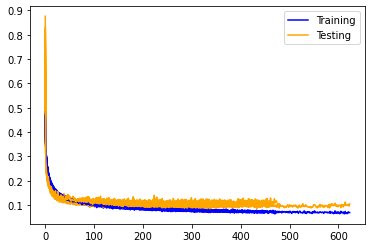

In [11]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

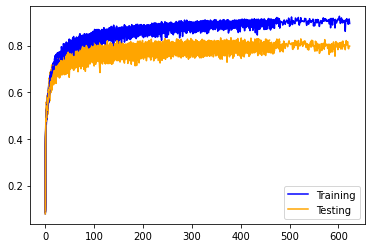

In [12]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

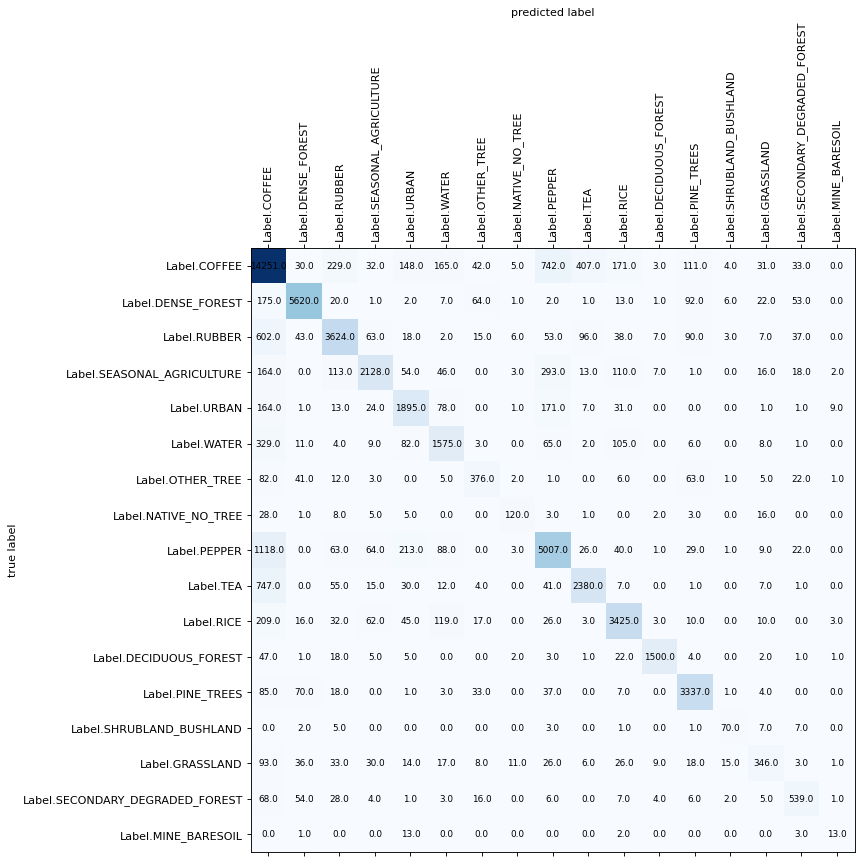

In [13]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [14]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.78466028 0.94820314 0.8477193  0.87034765 0.75019794 0.74292453
 0.65051903 0.77922078 0.77280445 0.80869861 0.85390177 0.97592713
 0.88467656 0.67961165 0.69758065 0.72739541 0.41935484]
Mean precision:  0.7761025710286564

Recalls:  [0.86875152 0.92434211 0.77040816 0.71698113 0.7909015  0.71590909
 0.60645161 0.625      0.74910233 0.72121212 0.86055276 0.93052109
 0.92797553 0.72916667 0.5        0.72446237 0.40625   ]
Mean recall:  0.7392934119021342

F-Score:  [0.82456749 0.9361206  0.80721684 0.78625531 0.77001219 0.72916667
 0.62771285 0.69364162 0.76076882 0.76245395 0.85721437 0.95268339
 0.9058089  0.70351759 0.58249158 0.72592593 0.41269841]
Mean f-score:  0.755191559488912


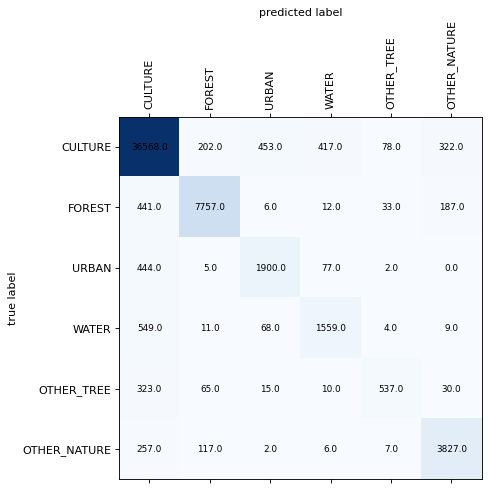

In [15]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [16]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.94779949 0.95096236 0.77741408 0.74915906 0.81240545 0.87474286]
Mean precision:  0.8520805487455081

Recalls:  [0.96130389 0.91951162 0.78253707 0.70863636 0.54795918 0.90773245]
Mean recall:  0.8046134283657405

F-Score:  [0.95450393 0.93497258 0.77996716 0.7283345  0.65447898 0.89093237]
Mean f-score:  0.8238649191760374


## Same but with an architecture without global average pooling and on a whole year

In [24]:
EPOCHS = 2000
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [25]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset)

In [26]:
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Flatten(name="last_pretrained_layer")(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.5, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

model_name = "whole_year_2018_multi_output_focal_loss_collection2_new_categories"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 9, 9, 7)      0           input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 9, 9, 7)      28          rescaling_3[0][0]                
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_11[0][0]     
____________________________________________________________________________________________

In [27]:
mean_loss, mean_accuracy, histories, conf_matrices = cross_validation_multi_output_model(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name, categories=categories)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 9, 9, 7)      0           input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 9, 9, 7)      28          rescaling_3[0][0]                
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_11[0][0]     
____________________________________________________________________________________________

351/351 [==============================] - 1s 4ms/step - loss: 0.1900 - label_loss: 0.1482 - category_loss: 0.0418 - label_accuracy: 0.6758 - category_accuracy: 0.8729 - val_loss: 0.1491 - val_label_loss: 0.1178 - val_category_loss: 0.0313 - val_label_accuracy: 0.7194 - val_category_accuracy: 0.8995
Epoch 13/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1817 - label_loss: 0.1417 - category_loss: 0.0400 - label_accuracy: 0.6809 - category_accuracy: 0.8726 - val_loss: 0.1626 - val_label_loss: 0.1275 - val_category_loss: 0.0351 - val_label_accuracy: 0.7115 - val_category_accuracy: 0.8853
Epoch 14/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1853 - label_loss: 0.1440 - category_loss: 0.0413 - label_accuracy: 0.6802 - category_accuracy: 0.8751 - val_loss: 0.1598 - val_label_loss: 0.1259 - val_category_loss: 0.0339 - val_label_accuracy: 0.7094 - val_category_accuracy: 0.8917
Epoch 15/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1392 - label_loss: 0.1088 - category_loss: 0.0305 - label_accuracy: 0.7334 - category_accuracy: 0.8995 - val_loss: 0.1223 - val_label_loss: 0.0959 - val_category_loss: 0.0264 - val_label_accuracy: 0.7670 - val_category_accuracy: 0.9176
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1359 - label_loss: 0.1063 - category_loss: 0.0297 - label_accuracy: 0.7356 - category_accuracy: 0.8977 - val_loss: 0.1188 - val_label_loss: 0.0940 - val_category_loss: 0.0248 - val_label_accuracy: 0.7705 - val_category_accuracy: 0.9194
Epoch 40/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1368 - label_loss: 0.1064 - category_loss: 0.0304 - label_accuracy: 0.7338 - category_accuracy: 0.8990 - val_loss: 0.1205 - val_label_loss: 0.0938 - val_category_loss: 0.0266 - val_label_accuracy: 0.7716 - val_category_accuracy: 0.9151
Epoch 41/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1163 - label_loss: 0.0909 - category_loss: 0.0254 - label_accuracy: 0.7603 - category_accuracy: 0.9058 - val_loss: 0.1183 - val_label_loss: 0.0928 - val_category_loss: 0.0255 - val_label_accuracy: 0.7808 - val_category_accuracy: 0.9218
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1147 - label_loss: 0.0893 - category_loss: 0.0254 - label_accuracy: 0.7637 - category_accuracy: 0.9095 - val_loss: 0.1246 - val_label_loss: 0.0977 - val_category_loss: 0.0268 - val_label_accuracy: 0.7705 - val_category_accuracy: 0.9162
Epoch 66/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1158 - label_loss: 0.0908 - category_loss: 0.0250 - label_accuracy: 0.7654 - category_accuracy: 0.9123 - val_loss: 0.1225 - val_label_loss: 0.0953 - val_category_loss: 0.0273 - val_label_accuracy: 0.7783 - val_category_accuracy: 0.9215
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1100 - label_loss: 0.0856 - category_loss: 0.0244 - label_accuracy: 0.7684 - category_accuracy: 0.9110 - val_loss: 0.1165 - val_label_loss: 0.0908 - val_category_loss: 0.0257 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9300
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1045 - label_loss: 0.0815 - category_loss: 0.0230 - label_accuracy: 0.7822 - category_accuracy: 0.9182 - val_loss: 0.1158 - val_label_loss: 0.0916 - val_category_loss: 0.0242 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9254
Epoch 92/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1058 - label_loss: 0.0822 - category_loss: 0.0236 - label_accuracy: 0.7780 - category_accuracy: 0.9145 - val_loss: 0.1094 - val_label_loss: 0.0857 - val_category_loss: 0.0237 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9187
Epoch 93/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1009 - label_loss: 0.0791 - category_loss: 0.0218 - label_accuracy: 0.7824 - category_accuracy: 0.9161 - val_loss: 0.1167 - val_label_loss: 0.0915 - val_category_loss: 0.0252 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9265
Epoch 117/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0962 - label_loss: 0.0757 - category_loss: 0.0205 - label_accuracy: 0.7853 - category_accuracy: 0.9215 - val_loss: 0.1113 - val_label_loss: 0.0860 - val_category_loss: 0.0253 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9258
Epoch 118/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0964 - label_loss: 0.0756 - category_loss: 0.0208 - label_accuracy: 0.7869 - category_accuracy: 0.9185 - val_loss: 0.1200 - val_label_loss: 0.0946 - val_category_loss: 0.0254 - val_label_accuracy: 0.7805 - val_category_accuracy: 0.9179
Epoch 119/2000
351/351 [==============================] - 1s 4ms/st

Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0908 - label_loss: 0.0712 - category_loss: 0.0195 - label_accuracy: 0.7928 - category_accuracy: 0.9243 - val_loss: 0.1282 - val_label_loss: 0.0986 - val_category_loss: 0.0295 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9151
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0965 - label_loss: 0.0755 - category_loss: 0.0210 - label_accuracy: 0.7882 - category_accuracy: 0.9196 - val_loss: 0.1163 - val_label_loss: 0.0915 - val_category_loss: 0.0248 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9272
Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0890 - label_loss: 0.0702 - category_loss: 0.0188 - label_accuracy: 0.7948 - category_accuracy: 0.9284 - val_loss: 0.1167 - val_label_loss: 0.0901 - val_category_loss: 0.0267 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9208
Epoch 145/2000
351/351 [============================

Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0899 - label_loss: 0.0707 - category_loss: 0.0191 - label_accuracy: 0.7995 - category_accuracy: 0.9298 - val_loss: 0.1088 - val_label_loss: 0.0845 - val_category_loss: 0.0243 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9279
Epoch 169/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0874 - label_loss: 0.0686 - category_loss: 0.0188 - label_accuracy: 0.8009 - category_accuracy: 0.9258 - val_loss: 0.1102 - val_label_loss: 0.0858 - val_category_loss: 0.0244 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9261
Epoch 170/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0856 - label_loss: 0.0665 - category_loss: 0.0191 - label_accuracy: 0.7988 - category_accuracy: 0.9222 - val_loss: 0.1157 - val_label_loss: 0.0898 - val_category_loss: 0.0259 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9268
Epoch 171/2000
351/351 [============================

Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0829 - label_loss: 0.0650 - category_loss: 0.0179 - label_accuracy: 0.8053 - category_accuracy: 0.9306 - val_loss: 0.1081 - val_label_loss: 0.0831 - val_category_loss: 0.0249 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9275
Epoch 195/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0825 - label_loss: 0.0647 - category_loss: 0.0177 - label_accuracy: 0.8006 - category_accuracy: 0.9274 - val_loss: 0.1135 - val_label_loss: 0.0879 - val_category_loss: 0.0256 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9275
Epoch 196/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0827 - label_loss: 0.0650 - category_loss: 0.0178 - label_accuracy: 0.7994 - category_accuracy: 0.9266 - val_loss: 0.1099 - val_label_loss: 0.0855 - val_category_loss: 0.0244 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9290
Epoch 197/2000
351/351 [============================

Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0851 - label_loss: 0.0671 - category_loss: 0.0180 - label_accuracy: 0.7996 - category_accuracy: 0.9278 - val_loss: 0.1045 - val_label_loss: 0.0814 - val_category_loss: 0.0231 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9297
Epoch 221/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0597 - category_loss: 0.0156 - label_accuracy: 0.8151 - category_accuracy: 0.9373 - val_loss: 0.1173 - val_label_loss: 0.0902 - val_category_loss: 0.0271 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9233
Epoch 222/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0833 - label_loss: 0.0652 - category_loss: 0.0181 - label_accuracy: 0.8072 - category_accuracy: 0.9270 - val_loss: 0.1109 - val_label_loss: 0.0861 - val_category_loss: 0.0249 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9268
Epoch 223/2000
351/351 [============================

Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0799 - label_loss: 0.0627 - category_loss: 0.0172 - label_accuracy: 0.8131 - category_accuracy: 0.9330 - val_loss: 0.1212 - val_label_loss: 0.0928 - val_category_loss: 0.0284 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9218
Epoch 247/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0792 - label_loss: 0.0624 - category_loss: 0.0168 - label_accuracy: 0.8075 - category_accuracy: 0.9307 - val_loss: 0.1212 - val_label_loss: 0.0923 - val_category_loss: 0.0289 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9297
Epoch 248/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0742 - label_loss: 0.0587 - category_loss: 0.0155 - label_accuracy: 0.8196 - category_accuracy: 0.9340 - val_loss: 0.1208 - val_label_loss: 0.0927 - val_category_loss: 0.0281 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9240
Epoch 249/2000
351/351 [============================

Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0762 - label_loss: 0.0598 - category_loss: 0.0164 - label_accuracy: 0.8133 - category_accuracy: 0.9318 - val_loss: 0.1136 - val_label_loss: 0.0880 - val_category_loss: 0.0256 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9321
Epoch 273/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0725 - label_loss: 0.0573 - category_loss: 0.0152 - label_accuracy: 0.8175 - category_accuracy: 0.9369 - val_loss: 0.1265 - val_label_loss: 0.0971 - val_category_loss: 0.0294 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9183
Epoch 274/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0727 - label_loss: 0.0575 - category_loss: 0.0152 - label_accuracy: 0.8154 - category_accuracy: 0.9342 - val_loss: 0.1111 - val_label_loss: 0.0857 - val_category_loss: 0.0254 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9279
Epoch 275/2000
351/351 [============================

Epoch 14/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1819 - label_loss: 0.1421 - category_loss: 0.0398 - label_accuracy: 0.6893 - category_accuracy: 0.8731 - val_loss: 0.1538 - val_label_loss: 0.1199 - val_category_loss: 0.0338 - val_label_accuracy: 0.7247 - val_category_accuracy: 0.8813
Epoch 15/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1795 - label_loss: 0.1405 - category_loss: 0.0390 - label_accuracy: 0.6897 - category_accuracy: 0.8758 - val_loss: 0.1434 - val_label_loss: 0.1134 - val_category_loss: 0.0300 - val_label_accuracy: 0.7410 - val_category_accuracy: 0.9030
Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1771 - label_loss: 0.1370 - category_loss: 0.0401 - label_accuracy: 0.6948 - category_accuracy: 0.8700 - val_loss: 0.1473 - val_label_loss: 0.1171 - val_category_loss: 0.0301 - val_label_accuracy: 0.7268 - val_category_accuracy: 0.9020
Epoch 17/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1339 - label_loss: 0.1041 - category_loss: 0.0298 - label_accuracy: 0.7394 - category_accuracy: 0.8963 - val_loss: 0.1187 - val_label_loss: 0.0923 - val_category_loss: 0.0264 - val_label_accuracy: 0.7730 - val_category_accuracy: 0.9151
Epoch 41/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1306 - label_loss: 0.1017 - category_loss: 0.0289 - label_accuracy: 0.7437 - category_accuracy: 0.8964 - val_loss: 0.1167 - val_label_loss: 0.0915 - val_category_loss: 0.0252 - val_label_accuracy: 0.7769 - val_category_accuracy: 0.9187
Epoch 42/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1312 - label_loss: 0.1025 - category_loss: 0.0287 - label_accuracy: 0.7453 - category_accuracy: 0.9017 - val_loss: 0.1186 - val_label_loss: 0.0923 - val_category_loss: 0.0263 - val_label_accuracy: 0.7758 - val_category_accuracy: 0.9204
Epoch 43/2000
351/351 [==============================] - 2s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1099 - label_loss: 0.0862 - category_loss: 0.0237 - label_accuracy: 0.7677 - category_accuracy: 0.9089 - val_loss: 0.1155 - val_label_loss: 0.0913 - val_category_loss: 0.0242 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9211
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1086 - label_loss: 0.0853 - category_loss: 0.0233 - label_accuracy: 0.7709 - category_accuracy: 0.9147 - val_loss: 0.1149 - val_label_loss: 0.0894 - val_category_loss: 0.0255 - val_label_accuracy: 0.7801 - val_category_accuracy: 0.9187
Epoch 68/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1097 - label_loss: 0.0862 - category_loss: 0.0234 - label_accuracy: 0.7679 - category_accuracy: 0.9096 - val_loss: 0.1085 - val_label_loss: 0.0840 - val_category_loss: 0.0245 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9282
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0971 - label_loss: 0.0763 - category_loss: 0.0208 - label_accuracy: 0.7848 - category_accuracy: 0.9180 - val_loss: 0.1235 - val_label_loss: 0.0942 - val_category_loss: 0.0294 - val_label_accuracy: 0.7815 - val_category_accuracy: 0.9087
Epoch 93/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0993 - label_loss: 0.0784 - category_loss: 0.0209 - label_accuracy: 0.7797 - category_accuracy: 0.9161 - val_loss: 0.1199 - val_label_loss: 0.0909 - val_category_loss: 0.0290 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9204
Epoch 94/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0991 - label_loss: 0.0776 - category_loss: 0.0215 - label_accuracy: 0.7851 - category_accuracy: 0.9176 - val_loss: 0.1168 - val_label_loss: 0.0903 - val_category_loss: 0.0265 - val_label_accuracy: 0.7872 - val_category_accuracy: 0.9268
Epoch 95/2000
351/351 [==============================] - 2s 4ms/step 

Epoch 118/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0937 - label_loss: 0.0736 - category_loss: 0.0201 - label_accuracy: 0.7921 - category_accuracy: 0.9213 - val_loss: 0.1187 - val_label_loss: 0.0908 - val_category_loss: 0.0279 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9162
Epoch 119/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0913 - label_loss: 0.0714 - category_loss: 0.0200 - label_accuracy: 0.7947 - category_accuracy: 0.9233 - val_loss: 0.1108 - val_label_loss: 0.0851 - val_category_loss: 0.0257 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9261
Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0885 - label_loss: 0.0696 - category_loss: 0.0189 - label_accuracy: 0.7963 - category_accuracy: 0.9247 - val_loss: 0.1027 - val_label_loss: 0.0784 - val_category_loss: 0.0243 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9318
Epoch 121/2000
351/351 [============================

Epoch 144/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0864 - label_loss: 0.0675 - category_loss: 0.0189 - label_accuracy: 0.8028 - category_accuracy: 0.9280 - val_loss: 0.1137 - val_label_loss: 0.0854 - val_category_loss: 0.0283 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9258
Epoch 145/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0806 - label_loss: 0.0630 - category_loss: 0.0175 - label_accuracy: 0.8066 - category_accuracy: 0.9239 - val_loss: 0.1202 - val_label_loss: 0.0906 - val_category_loss: 0.0296 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9236
Epoch 146/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0870 - label_loss: 0.0679 - category_loss: 0.0191 - label_accuracy: 0.7974 - category_accuracy: 0.9235 - val_loss: 0.1096 - val_label_loss: 0.0838 - val_category_loss: 0.0258 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9293
Epoch 147/2000
351/351 [============================

Epoch 170/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0805 - label_loss: 0.0633 - category_loss: 0.0172 - label_accuracy: 0.8108 - category_accuracy: 0.9274 - val_loss: 0.1209 - val_label_loss: 0.0915 - val_category_loss: 0.0295 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9250
Epoch 171/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0811 - label_loss: 0.0641 - category_loss: 0.0170 - label_accuracy: 0.8093 - category_accuracy: 0.9326 - val_loss: 0.1094 - val_label_loss: 0.0850 - val_category_loss: 0.0243 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9304
Epoch 172/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0784 - label_loss: 0.0614 - category_loss: 0.0171 - label_accuracy: 0.8093 - category_accuracy: 0.9308 - val_loss: 0.1135 - val_label_loss: 0.0853 - val_category_loss: 0.0281 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9343
Epoch 173/2000
351/351 [============================

Epoch 196/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0781 - label_loss: 0.0613 - category_loss: 0.0168 - label_accuracy: 0.8103 - category_accuracy: 0.9331 - val_loss: 0.1149 - val_label_loss: 0.0865 - val_category_loss: 0.0284 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9254
Epoch 197/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0750 - label_loss: 0.0595 - category_loss: 0.0155 - label_accuracy: 0.8200 - category_accuracy: 0.9352 - val_loss: 0.1073 - val_label_loss: 0.0816 - val_category_loss: 0.0257 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9311
Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0764 - label_loss: 0.0601 - category_loss: 0.0162 - label_accuracy: 0.8134 - category_accuracy: 0.9341 - val_loss: 0.1108 - val_label_loss: 0.0834 - val_category_loss: 0.0274 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9268
Epoch 199/2000
351/351 [============================

Epoch 222/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0701 - label_loss: 0.0556 - category_loss: 0.0145 - label_accuracy: 0.8293 - category_accuracy: 0.9381 - val_loss: 0.1199 - val_label_loss: 0.0893 - val_category_loss: 0.0306 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9268
Epoch 223/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0746 - label_loss: 0.0587 - category_loss: 0.0159 - label_accuracy: 0.8247 - category_accuracy: 0.9345 - val_loss: 0.1133 - val_label_loss: 0.0855 - val_category_loss: 0.0278 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9254
Epoch 224/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0712 - label_loss: 0.0557 - category_loss: 0.0155 - label_accuracy: 0.8210 - category_accuracy: 0.9358 - val_loss: 0.1159 - val_label_loss: 0.0879 - val_category_loss: 0.0280 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9258
Epoch 225/2000
351/351 [============================

Epoch 248/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0703 - label_loss: 0.0551 - category_loss: 0.0152 - label_accuracy: 0.8220 - category_accuracy: 0.9379 - val_loss: 0.1153 - val_label_loss: 0.0852 - val_category_loss: 0.0302 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9290
Epoch 249/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0704 - label_loss: 0.0559 - category_loss: 0.0145 - label_accuracy: 0.8220 - category_accuracy: 0.9377 - val_loss: 0.1156 - val_label_loss: 0.0860 - val_category_loss: 0.0297 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9336
Epoch 250/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0680 - label_loss: 0.0539 - category_loss: 0.0141 - label_accuracy: 0.8258 - category_accuracy: 0.9422 - val_loss: 0.1149 - val_label_loss: 0.0867 - val_category_loss: 0.0282 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9286
Epoch 251/2000
351/351 [============================

Epoch 274/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0687 - label_loss: 0.0542 - category_loss: 0.0146 - label_accuracy: 0.8274 - category_accuracy: 0.9401 - val_loss: 0.1210 - val_label_loss: 0.0898 - val_category_loss: 0.0312 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9318
Epoch 275/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0677 - label_loss: 0.0533 - category_loss: 0.0143 - label_accuracy: 0.8299 - category_accuracy: 0.9421 - val_loss: 0.1134 - val_label_loss: 0.0855 - val_category_loss: 0.0279 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9293
Epoch 276/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0717 - label_loss: 0.0565 - category_loss: 0.0152 - label_accuracy: 0.8286 - category_accuracy: 0.9388 - val_loss: 0.1109 - val_label_loss: 0.0835 - val_category_loss: 0.0274 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9353
Epoch 277/2000
351/351 [============================

Epoch 300/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0691 - label_loss: 0.0543 - category_loss: 0.0148 - label_accuracy: 0.8312 - category_accuracy: 0.9399 - val_loss: 0.1109 - val_label_loss: 0.0828 - val_category_loss: 0.0281 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9250
Epoch 301/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0675 - label_loss: 0.0530 - category_loss: 0.0145 - label_accuracy: 0.8290 - category_accuracy: 0.9401 - val_loss: 0.1192 - val_label_loss: 0.0891 - val_category_loss: 0.0302 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9250
Epoch 302/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0633 - label_loss: 0.0504 - category_loss: 0.0129 - label_accuracy: 0.8385 - category_accuracy: 0.9421 - val_loss: 0.1214 - val_label_loss: 0.0890 - val_category_loss: 0.0324 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9321
Epoch 303/2000
351/351 [============================

Epoch 326/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0663 - label_loss: 0.0523 - category_loss: 0.0140 - label_accuracy: 0.8330 - category_accuracy: 0.9412 - val_loss: 0.1133 - val_label_loss: 0.0844 - val_category_loss: 0.0289 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9311
Epoch 327/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0665 - label_loss: 0.0522 - category_loss: 0.0144 - label_accuracy: 0.8375 - category_accuracy: 0.9429 - val_loss: 0.1085 - val_label_loss: 0.0814 - val_category_loss: 0.0270 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9307
Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0629 - label_loss: 0.0498 - category_loss: 0.0131 - label_accuracy: 0.8370 - category_accuracy: 0.9464 - val_loss: 0.1119 - val_label_loss: 0.0832 - val_category_loss: 0.0287 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9290
Epoch 329/2000
351/351 [============================

Epoch 352/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0619 - label_loss: 0.0487 - category_loss: 0.0132 - label_accuracy: 0.8424 - category_accuracy: 0.9439 - val_loss: 0.1169 - val_label_loss: 0.0888 - val_category_loss: 0.0282 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9290
Epoch 353/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0636 - label_loss: 0.0505 - category_loss: 0.0131 - label_accuracy: 0.8383 - category_accuracy: 0.9479 - val_loss: 0.1175 - val_label_loss: 0.0883 - val_category_loss: 0.0291 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9357
Epoch 354/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0609 - label_loss: 0.0482 - category_loss: 0.0127 - label_accuracy: 0.8405 - category_accuracy: 0.9436 - val_loss: 0.1110 - val_label_loss: 0.0835 - val_category_loss: 0.0275 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9304
Epoch 355/2000
351/351 [============================

Epoch 378/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0609 - label_loss: 0.0482 - category_loss: 0.0127 - label_accuracy: 0.8407 - category_accuracy: 0.9449 - val_loss: 0.1320 - val_label_loss: 0.0979 - val_category_loss: 0.0340 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9243
Epoch 379/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0609 - label_loss: 0.0484 - category_loss: 0.0125 - label_accuracy: 0.8376 - category_accuracy: 0.9471 - val_loss: 0.1156 - val_label_loss: 0.0870 - val_category_loss: 0.0286 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9265
Epoch 380/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0606 - label_loss: 0.0484 - category_loss: 0.0122 - label_accuracy: 0.8441 - category_accuracy: 0.9460 - val_loss: 0.1094 - val_label_loss: 0.0831 - val_category_loss: 0.0263 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9321
Epoch 381/2000
351/351 [============================

Epoch 404/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0584 - label_loss: 0.0458 - category_loss: 0.0126 - label_accuracy: 0.8419 - category_accuracy: 0.9445 - val_loss: 0.1222 - val_label_loss: 0.0926 - val_category_loss: 0.0296 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9243
Epoch 405/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0610 - label_loss: 0.0479 - category_loss: 0.0130 - label_accuracy: 0.8446 - category_accuracy: 0.9474 - val_loss: 0.1218 - val_label_loss: 0.0915 - val_category_loss: 0.0303 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9297
Epoch 406/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0597 - label_loss: 0.0471 - category_loss: 0.0126 - label_accuracy: 0.8478 - category_accuracy: 0.9466 - val_loss: 0.1215 - val_label_loss: 0.0913 - val_category_loss: 0.0302 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9236
Epoch 407/2000
351/351 [============================

Epoch 430/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0569 - label_loss: 0.0456 - category_loss: 0.0113 - label_accuracy: 0.8441 - category_accuracy: 0.9518 - val_loss: 0.1187 - val_label_loss: 0.0892 - val_category_loss: 0.0295 - val_label_accuracy: 0.8259 - val_category_accuracy: 0.9290
Epoch 431/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0610 - label_loss: 0.0477 - category_loss: 0.0133 - label_accuracy: 0.8412 - category_accuracy: 0.9431 - val_loss: 0.1128 - val_label_loss: 0.0845 - val_category_loss: 0.0283 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9314
Epoch 432/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0628 - label_loss: 0.0495 - category_loss: 0.0133 - label_accuracy: 0.8388 - category_accuracy: 0.9433 - val_loss: 0.1203 - val_label_loss: 0.0898 - val_category_loss: 0.0305 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9268
Epoch 433/2000
351/351 [============================

Epoch 456/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0563 - label_loss: 0.0448 - category_loss: 0.0115 - label_accuracy: 0.8501 - category_accuracy: 0.9506 - val_loss: 0.1245 - val_label_loss: 0.0926 - val_category_loss: 0.0318 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9293
Epoch 457/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0609 - label_loss: 0.0479 - category_loss: 0.0131 - label_accuracy: 0.8455 - category_accuracy: 0.9480 - val_loss: 0.1196 - val_label_loss: 0.0893 - val_category_loss: 0.0303 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9321
Epoch 458/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0559 - label_loss: 0.0437 - category_loss: 0.0122 - label_accuracy: 0.8497 - category_accuracy: 0.9491 - val_loss: 0.1238 - val_label_loss: 0.0915 - val_category_loss: 0.0323 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9321
Epoch 459/2000
351/351 [============================

Epoch 482/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0569 - label_loss: 0.0450 - category_loss: 0.0119 - label_accuracy: 0.8503 - category_accuracy: 0.9489 - val_loss: 0.1226 - val_label_loss: 0.0907 - val_category_loss: 0.0319 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9361
Epoch 483/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0567 - label_loss: 0.0453 - category_loss: 0.0114 - label_accuracy: 0.8456 - category_accuracy: 0.9482 - val_loss: 0.1176 - val_label_loss: 0.0885 - val_category_loss: 0.0291 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9290
Epoch 484/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0592 - label_loss: 0.0460 - category_loss: 0.0132 - label_accuracy: 0.8465 - category_accuracy: 0.9452 - val_loss: 0.1197 - val_label_loss: 0.0895 - val_category_loss: 0.0302 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9321
Epoch 485/2000
351/351 [============================

Epoch 14/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1801 - label_loss: 0.1398 - category_loss: 0.0403 - label_accuracy: 0.6888 - category_accuracy: 0.8781 - val_loss: 0.1532 - val_label_loss: 0.1188 - val_category_loss: 0.0345 - val_label_accuracy: 0.7258 - val_category_accuracy: 0.8920
Epoch 15/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1744 - label_loss: 0.1360 - category_loss: 0.0384 - label_accuracy: 0.6942 - category_accuracy: 0.8790 - val_loss: 0.1529 - val_label_loss: 0.1180 - val_category_loss: 0.0349 - val_label_accuracy: 0.7247 - val_category_accuracy: 0.8909
Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1759 - label_loss: 0.1363 - category_loss: 0.0397 - label_accuracy: 0.6910 - category_accuracy: 0.8766 - val_loss: 0.1518 - val_label_loss: 0.1187 - val_category_loss: 0.0330 - val_label_accuracy: 0.7261 - val_category_accuracy: 0.8963
Epoch 17/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1304 - label_loss: 0.1019 - category_loss: 0.0285 - label_accuracy: 0.7486 - category_accuracy: 0.9060 - val_loss: 0.1244 - val_label_loss: 0.0974 - val_category_loss: 0.0270 - val_label_accuracy: 0.7577 - val_category_accuracy: 0.9162
Epoch 41/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1298 - label_loss: 0.1021 - category_loss: 0.0276 - label_accuracy: 0.7414 - category_accuracy: 0.9025 - val_loss: 0.1222 - val_label_loss: 0.0952 - val_category_loss: 0.0270 - val_label_accuracy: 0.7719 - val_category_accuracy: 0.9218
Epoch 42/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1302 - label_loss: 0.1017 - category_loss: 0.0284 - label_accuracy: 0.7479 - category_accuracy: 0.9051 - val_loss: 0.1180 - val_label_loss: 0.0910 - val_category_loss: 0.0270 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9176
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1149 - label_loss: 0.0897 - category_loss: 0.0252 - label_accuracy: 0.7676 - category_accuracy: 0.9110 - val_loss: 0.1175 - val_label_loss: 0.0913 - val_category_loss: 0.0262 - val_label_accuracy: 0.7716 - val_category_accuracy: 0.9187
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1140 - label_loss: 0.0894 - category_loss: 0.0246 - label_accuracy: 0.7642 - category_accuracy: 0.9131 - val_loss: 0.1163 - val_label_loss: 0.0892 - val_category_loss: 0.0271 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9179
Epoch 68/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1120 - label_loss: 0.0875 - category_loss: 0.0245 - label_accuracy: 0.7671 - category_accuracy: 0.9115 - val_loss: 0.1139 - val_label_loss: 0.0878 - val_category_loss: 0.0261 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9229
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1032 - label_loss: 0.0812 - category_loss: 0.0220 - label_accuracy: 0.7763 - category_accuracy: 0.9155 - val_loss: 0.1140 - val_label_loss: 0.0865 - val_category_loss: 0.0276 - val_label_accuracy: 0.7837 - val_category_accuracy: 0.9165
Epoch 93/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1014 - label_loss: 0.0796 - category_loss: 0.0218 - label_accuracy: 0.7782 - category_accuracy: 0.9169 - val_loss: 0.1143 - val_label_loss: 0.0879 - val_category_loss: 0.0265 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9172
Epoch 94/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1006 - label_loss: 0.0792 - category_loss: 0.0213 - label_accuracy: 0.7765 - category_accuracy: 0.9171 - val_loss: 0.1262 - val_label_loss: 0.0947 - val_category_loss: 0.0316 - val_label_accuracy: 0.7712 - val_category_accuracy: 0.8966
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 118/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0933 - label_loss: 0.0739 - category_loss: 0.0194 - label_accuracy: 0.7921 - category_accuracy: 0.9226 - val_loss: 0.1140 - val_label_loss: 0.0851 - val_category_loss: 0.0289 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9119
Epoch 119/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0876 - label_loss: 0.0694 - category_loss: 0.0182 - label_accuracy: 0.7950 - category_accuracy: 0.9283 - val_loss: 0.1288 - val_label_loss: 0.0993 - val_category_loss: 0.0295 - val_label_accuracy: 0.7702 - val_category_accuracy: 0.9066
Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0897 - label_loss: 0.0709 - category_loss: 0.0189 - label_accuracy: 0.7904 - category_accuracy: 0.9254 - val_loss: 0.1103 - val_label_loss: 0.0841 - val_category_loss: 0.0262 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9190
Epoch 121/2000
351/351 [============================

Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0877 - label_loss: 0.0691 - category_loss: 0.0186 - label_accuracy: 0.7977 - category_accuracy: 0.9252 - val_loss: 0.1127 - val_label_loss: 0.0851 - val_category_loss: 0.0276 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9130
Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0858 - label_loss: 0.0680 - category_loss: 0.0178 - label_accuracy: 0.7973 - category_accuracy: 0.9256 - val_loss: 0.1147 - val_label_loss: 0.0872 - val_category_loss: 0.0276 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9101
Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0883 - label_loss: 0.0697 - category_loss: 0.0186 - label_accuracy: 0.7937 - category_accuracy: 0.9233 - val_loss: 0.1169 - val_label_loss: 0.0894 - val_category_loss: 0.0275 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9172
Epoch 147/2000
351/351 [============================

Epoch 170/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0831 - label_loss: 0.0653 - category_loss: 0.0178 - label_accuracy: 0.8003 - category_accuracy: 0.9277 - val_loss: 0.1112 - val_label_loss: 0.0835 - val_category_loss: 0.0278 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9179
Epoch 171/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0787 - label_loss: 0.0624 - category_loss: 0.0163 - label_accuracy: 0.8078 - category_accuracy: 0.9320 - val_loss: 0.1116 - val_label_loss: 0.0835 - val_category_loss: 0.0281 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9119
Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0670 - category_loss: 0.0176 - label_accuracy: 0.7996 - category_accuracy: 0.9270 - val_loss: 0.1120 - val_label_loss: 0.0851 - val_category_loss: 0.0268 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9208
Epoch 173/2000
351/351 [============================

Epoch 196/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0795 - label_loss: 0.0628 - category_loss: 0.0168 - label_accuracy: 0.8120 - category_accuracy: 0.9288 - val_loss: 0.1047 - val_label_loss: 0.0786 - val_category_loss: 0.0261 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9258
Epoch 197/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0816 - label_loss: 0.0641 - category_loss: 0.0174 - label_accuracy: 0.8083 - category_accuracy: 0.9288 - val_loss: 0.1110 - val_label_loss: 0.0829 - val_category_loss: 0.0281 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9179
Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0616 - category_loss: 0.0162 - label_accuracy: 0.8112 - category_accuracy: 0.9333 - val_loss: 0.1146 - val_label_loss: 0.0854 - val_category_loss: 0.0293 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9247
Epoch 199/2000
351/351 [============================

Epoch 222/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0775 - label_loss: 0.0613 - category_loss: 0.0162 - label_accuracy: 0.8083 - category_accuracy: 0.9325 - val_loss: 0.1117 - val_label_loss: 0.0848 - val_category_loss: 0.0269 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9151
Epoch 223/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0762 - label_loss: 0.0603 - category_loss: 0.0159 - label_accuracy: 0.8137 - category_accuracy: 0.9329 - val_loss: 0.1224 - val_label_loss: 0.0920 - val_category_loss: 0.0304 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.8970
Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0777 - label_loss: 0.0614 - category_loss: 0.0164 - label_accuracy: 0.8135 - category_accuracy: 0.9306 - val_loss: 0.1067 - val_label_loss: 0.0802 - val_category_loss: 0.0265 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9258
Epoch 225/2000
351/351 [============================

Epoch 248/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0771 - label_loss: 0.0608 - category_loss: 0.0163 - label_accuracy: 0.8157 - category_accuracy: 0.9323 - val_loss: 0.1098 - val_label_loss: 0.0820 - val_category_loss: 0.0277 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9204
Epoch 249/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0710 - label_loss: 0.0566 - category_loss: 0.0144 - label_accuracy: 0.8156 - category_accuracy: 0.9386 - val_loss: 0.1089 - val_label_loss: 0.0813 - val_category_loss: 0.0277 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9286
Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0775 - label_loss: 0.0615 - category_loss: 0.0160 - label_accuracy: 0.8136 - category_accuracy: 0.9345 - val_loss: 0.1089 - val_label_loss: 0.0815 - val_category_loss: 0.0274 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9261
Epoch 251/2000
351/351 [============================

Epoch 274/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0755 - label_loss: 0.0593 - category_loss: 0.0162 - label_accuracy: 0.8163 - category_accuracy: 0.9354 - val_loss: 0.1230 - val_label_loss: 0.0933 - val_category_loss: 0.0297 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9133
Epoch 275/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0566 - category_loss: 0.0154 - label_accuracy: 0.8223 - category_accuracy: 0.9359 - val_loss: 0.1149 - val_label_loss: 0.0844 - val_category_loss: 0.0305 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9204
Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0703 - label_loss: 0.0556 - category_loss: 0.0146 - label_accuracy: 0.8195 - category_accuracy: 0.9339 - val_loss: 0.1136 - val_label_loss: 0.0846 - val_category_loss: 0.0290 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9208
Epoch 277/2000
351/351 [============================

Epoch 300/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0550 - category_loss: 0.0150 - label_accuracy: 0.8242 - category_accuracy: 0.9345 - val_loss: 0.1091 - val_label_loss: 0.0801 - val_category_loss: 0.0290 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9265
Epoch 301/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0691 - label_loss: 0.0547 - category_loss: 0.0145 - label_accuracy: 0.8257 - category_accuracy: 0.9376 - val_loss: 0.1045 - val_label_loss: 0.0773 - val_category_loss: 0.0272 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9290
Epoch 302/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0746 - label_loss: 0.0588 - category_loss: 0.0158 - label_accuracy: 0.8209 - category_accuracy: 0.9371 - val_loss: 0.1047 - val_label_loss: 0.0774 - val_category_loss: 0.0273 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9268
Epoch 303/2000
351/351 [============================

Epoch 326/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0682 - label_loss: 0.0544 - category_loss: 0.0138 - label_accuracy: 0.8242 - category_accuracy: 0.9386 - val_loss: 0.1083 - val_label_loss: 0.0816 - val_category_loss: 0.0267 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9268
Epoch 327/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0685 - label_loss: 0.0542 - category_loss: 0.0143 - label_accuracy: 0.8252 - category_accuracy: 0.9377 - val_loss: 0.1070 - val_label_loss: 0.0787 - val_category_loss: 0.0283 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9218
Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0704 - label_loss: 0.0555 - category_loss: 0.0149 - label_accuracy: 0.8218 - category_accuracy: 0.9372 - val_loss: 0.1099 - val_label_loss: 0.0812 - val_category_loss: 0.0287 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9279
Epoch 329/2000
351/351 [============================

Epoch 352/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0562 - category_loss: 0.0154 - label_accuracy: 0.8205 - category_accuracy: 0.9376 - val_loss: 0.1195 - val_label_loss: 0.0888 - val_category_loss: 0.0306 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9162
Epoch 353/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0690 - label_loss: 0.0543 - category_loss: 0.0147 - label_accuracy: 0.8261 - category_accuracy: 0.9390 - val_loss: 0.1161 - val_label_loss: 0.0868 - val_category_loss: 0.0293 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9275
Epoch 354/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0650 - label_loss: 0.0515 - category_loss: 0.0135 - label_accuracy: 0.8306 - category_accuracy: 0.9422 - val_loss: 0.1072 - val_label_loss: 0.0801 - val_category_loss: 0.0271 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9240
Epoch 355/2000
351/351 [============================

Epoch 378/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0661 - label_loss: 0.0521 - category_loss: 0.0141 - label_accuracy: 0.8283 - category_accuracy: 0.9401 - val_loss: 0.1159 - val_label_loss: 0.0856 - val_category_loss: 0.0303 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9258
Epoch 379/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0666 - label_loss: 0.0532 - category_loss: 0.0134 - label_accuracy: 0.8306 - category_accuracy: 0.9436 - val_loss: 0.1191 - val_label_loss: 0.0869 - val_category_loss: 0.0322 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9240
Epoch 380/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0668 - label_loss: 0.0529 - category_loss: 0.0139 - label_accuracy: 0.8248 - category_accuracy: 0.9371 - val_loss: 0.1104 - val_label_loss: 0.0826 - val_category_loss: 0.0277 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9147
Epoch 381/2000
351/351 [============================

Epoch 404/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0661 - label_loss: 0.0523 - category_loss: 0.0138 - label_accuracy: 0.8302 - category_accuracy: 0.9434 - val_loss: 0.1181 - val_label_loss: 0.0873 - val_category_loss: 0.0309 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9268
Epoch 405/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0685 - label_loss: 0.0544 - category_loss: 0.0141 - label_accuracy: 0.8231 - category_accuracy: 0.9393 - val_loss: 0.1201 - val_label_loss: 0.0874 - val_category_loss: 0.0327 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9240
Epoch 406/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0651 - label_loss: 0.0516 - category_loss: 0.0135 - label_accuracy: 0.8296 - category_accuracy: 0.9405 - val_loss: 0.1156 - val_label_loss: 0.0839 - val_category_loss: 0.0317 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9275
Epoch 407/2000
351/351 [============================

Epoch 430/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0633 - label_loss: 0.0501 - category_loss: 0.0133 - label_accuracy: 0.8332 - category_accuracy: 0.9432 - val_loss: 0.1092 - val_label_loss: 0.0813 - val_category_loss: 0.0279 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9254
Epoch 431/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0648 - label_loss: 0.0513 - category_loss: 0.0135 - label_accuracy: 0.8349 - category_accuracy: 0.9418 - val_loss: 0.1208 - val_label_loss: 0.0887 - val_category_loss: 0.0321 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9293
Epoch 432/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0656 - label_loss: 0.0520 - category_loss: 0.0136 - label_accuracy: 0.8274 - category_accuracy: 0.9434 - val_loss: 0.1059 - val_label_loss: 0.0794 - val_category_loss: 0.0265 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9297
Epoch 433/2000
351/351 [============================

Epoch 456/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0650 - label_loss: 0.0509 - category_loss: 0.0141 - label_accuracy: 0.8314 - category_accuracy: 0.9394 - val_loss: 0.1148 - val_label_loss: 0.0852 - val_category_loss: 0.0296 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9115
Epoch 457/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0629 - label_loss: 0.0496 - category_loss: 0.0133 - label_accuracy: 0.8328 - category_accuracy: 0.9392 - val_loss: 0.1185 - val_label_loss: 0.0870 - val_category_loss: 0.0315 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9194
Epoch 458/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0626 - label_loss: 0.0494 - category_loss: 0.0131 - label_accuracy: 0.8326 - category_accuracy: 0.9440 - val_loss: 0.1180 - val_label_loss: 0.0859 - val_category_loss: 0.0320 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9265
Epoch 459/2000
351/351 [============================

Epoch 482/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0639 - label_loss: 0.0509 - category_loss: 0.0131 - label_accuracy: 0.8324 - category_accuracy: 0.9406 - val_loss: 0.1211 - val_label_loss: 0.0900 - val_category_loss: 0.0311 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9250

Validation 1, fold 4 :
---------------------------

Epoch 1/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.4431 - label_loss: 0.3320 - category_loss: 0.1111 - label_accuracy: 0.4484 - category_accuracy: 0.7545 - val_loss: 0.7713 - val_label_loss: 0.5347 - val_category_loss: 0.2366 - val_label_accuracy: 0.2924 - val_category_accuracy: 0.6874
Epoch 2/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.3188 - label_loss: 0.2435 - category_loss: 0.0753 - label_accuracy: 0.5535 - category_accuracy: 0.8094 - val_loss: 0.2550 - val_label_loss: 0.1987 - val_category_loss: 0.0563 - val_label_accuracy: 0.6139 - val_category_accuracy: 0.8575
Epo

Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1614 - label_loss: 0.1265 - category_loss: 0.0349 - label_accuracy: 0.7128 - category_accuracy: 0.8912 - val_loss: 0.1280 - val_label_loss: 0.1002 - val_category_loss: 0.0278 - val_label_accuracy: 0.7535 - val_category_accuracy: 0.9055
Epoch 27/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1530 - label_loss: 0.1196 - category_loss: 0.0334 - label_accuracy: 0.7192 - category_accuracy: 0.8888 - val_loss: 0.1305 - val_label_loss: 0.1025 - val_category_loss: 0.0280 - val_label_accuracy: 0.7591 - val_category_accuracy: 0.9105
Epoch 28/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1495 - label_loss: 0.1170 - category_loss: 0.0325 - label_accuracy: 0.7202 - category_accuracy: 0.8917 - val_loss: 0.1205 - val_label_loss: 0.0968 - val_category_loss: 0.0237 - val_label_accuracy: 0.7602 - val_category_accuracy: 0.9172
Epoch 29/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1232 - label_loss: 0.0968 - category_loss: 0.0264 - label_accuracy: 0.7508 - category_accuracy: 0.9060 - val_loss: 0.1123 - val_label_loss: 0.0901 - val_category_loss: 0.0222 - val_label_accuracy: 0.7851 - val_category_accuracy: 0.9247
Epoch 53/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1266 - label_loss: 0.0992 - category_loss: 0.0274 - label_accuracy: 0.7520 - category_accuracy: 0.9085 - val_loss: 0.1114 - val_label_loss: 0.0871 - val_category_loss: 0.0242 - val_label_accuracy: 0.7741 - val_category_accuracy: 0.9208
Epoch 54/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1241 - label_loss: 0.0973 - category_loss: 0.0268 - label_accuracy: 0.7503 - category_accuracy: 0.9043 - val_loss: 0.1090 - val_label_loss: 0.0855 - val_category_loss: 0.0235 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9240
Epoch 55/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1115 - label_loss: 0.0877 - category_loss: 0.0238 - label_accuracy: 0.7679 - category_accuracy: 0.9112 - val_loss: 0.0999 - val_label_loss: 0.0784 - val_category_loss: 0.0215 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9339
Epoch 79/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1127 - label_loss: 0.0885 - category_loss: 0.0242 - label_accuracy: 0.7688 - category_accuracy: 0.9160 - val_loss: 0.1103 - val_label_loss: 0.0861 - val_category_loss: 0.0242 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9201
Epoch 80/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1131 - label_loss: 0.0890 - category_loss: 0.0241 - label_accuracy: 0.7654 - category_accuracy: 0.9139 - val_loss: 0.1058 - val_label_loss: 0.0823 - val_category_loss: 0.0235 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9254
Epoch 81/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1036 - label_loss: 0.0813 - category_loss: 0.0223 - label_accuracy: 0.7774 - category_accuracy: 0.9155 - val_loss: 0.1038 - val_label_loss: 0.0813 - val_category_loss: 0.0226 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9218
Epoch 105/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1029 - label_loss: 0.0806 - category_loss: 0.0223 - label_accuracy: 0.7786 - category_accuracy: 0.9174 - val_loss: 0.1033 - val_label_loss: 0.0810 - val_category_loss: 0.0223 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9290
Epoch 106/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1038 - label_loss: 0.0816 - category_loss: 0.0222 - label_accuracy: 0.7766 - category_accuracy: 0.9154 - val_loss: 0.1027 - val_label_loss: 0.0806 - val_category_loss: 0.0221 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9275
Epoch 107/2000
351/351 [==============================] - 1s 4ms/st

Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0940 - label_loss: 0.0747 - category_loss: 0.0193 - label_accuracy: 0.7934 - category_accuracy: 0.9249 - val_loss: 0.0991 - val_label_loss: 0.0775 - val_category_loss: 0.0216 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9261
Epoch 131/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0948 - label_loss: 0.0748 - category_loss: 0.0200 - label_accuracy: 0.7865 - category_accuracy: 0.9186 - val_loss: 0.0986 - val_label_loss: 0.0762 - val_category_loss: 0.0224 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9357
Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0939 - label_loss: 0.0739 - category_loss: 0.0199 - label_accuracy: 0.7912 - category_accuracy: 0.9230 - val_loss: 0.1007 - val_label_loss: 0.0794 - val_category_loss: 0.0213 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9332
Epoch 133/2000
351/351 [============================

Epoch 156/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0905 - label_loss: 0.0713 - category_loss: 0.0193 - label_accuracy: 0.7945 - category_accuracy: 0.9232 - val_loss: 0.1036 - val_label_loss: 0.0799 - val_category_loss: 0.0237 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9307
Epoch 157/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0922 - label_loss: 0.0725 - category_loss: 0.0197 - label_accuracy: 0.8008 - category_accuracy: 0.9278 - val_loss: 0.0984 - val_label_loss: 0.0768 - val_category_loss: 0.0216 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9321
Epoch 158/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0866 - label_loss: 0.0681 - category_loss: 0.0185 - label_accuracy: 0.8006 - category_accuracy: 0.9234 - val_loss: 0.1020 - val_label_loss: 0.0794 - val_category_loss: 0.0226 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9353
Epoch 159/2000
351/351 [============================

Epoch 182/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0867 - label_loss: 0.0685 - category_loss: 0.0183 - label_accuracy: 0.8041 - category_accuracy: 0.9267 - val_loss: 0.1058 - val_label_loss: 0.0823 - val_category_loss: 0.0235 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9329
Epoch 183/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0847 - label_loss: 0.0668 - category_loss: 0.0180 - label_accuracy: 0.8022 - category_accuracy: 0.9306 - val_loss: 0.1001 - val_label_loss: 0.0791 - val_category_loss: 0.0210 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9353
Epoch 184/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0860 - label_loss: 0.0675 - category_loss: 0.0185 - label_accuracy: 0.8017 - category_accuracy: 0.9274 - val_loss: 0.0970 - val_label_loss: 0.0752 - val_category_loss: 0.0218 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9325
Epoch 185/2000
351/351 [============================

Epoch 208/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0836 - label_loss: 0.0661 - category_loss: 0.0175 - label_accuracy: 0.8095 - category_accuracy: 0.9298 - val_loss: 0.1103 - val_label_loss: 0.0843 - val_category_loss: 0.0260 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9190
Epoch 209/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0805 - label_loss: 0.0632 - category_loss: 0.0173 - label_accuracy: 0.8123 - category_accuracy: 0.9297 - val_loss: 0.1045 - val_label_loss: 0.0804 - val_category_loss: 0.0241 - val_label_accuracy: 0.8245 - val_category_accuracy: 0.9311
Epoch 210/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0832 - label_loss: 0.0652 - category_loss: 0.0180 - label_accuracy: 0.8086 - category_accuracy: 0.9279 - val_loss: 0.1024 - val_label_loss: 0.0790 - val_category_loss: 0.0235 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9304
Epoch 211/2000
351/351 [============================

Epoch 234/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0628 - category_loss: 0.0173 - label_accuracy: 0.8146 - category_accuracy: 0.9280 - val_loss: 0.0964 - val_label_loss: 0.0764 - val_category_loss: 0.0201 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9364
Epoch 235/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0791 - label_loss: 0.0627 - category_loss: 0.0165 - label_accuracy: 0.8108 - category_accuracy: 0.9324 - val_loss: 0.1039 - val_label_loss: 0.0815 - val_category_loss: 0.0224 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9325
Epoch 236/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0797 - label_loss: 0.0627 - category_loss: 0.0170 - label_accuracy: 0.8130 - category_accuracy: 0.9336 - val_loss: 0.1010 - val_label_loss: 0.0784 - val_category_loss: 0.0225 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9364
Epoch 237/2000
351/351 [============================

Epoch 260/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0804 - label_loss: 0.0628 - category_loss: 0.0176 - label_accuracy: 0.8117 - category_accuracy: 0.9307 - val_loss: 0.1070 - val_label_loss: 0.0816 - val_category_loss: 0.0254 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9336
Epoch 261/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0815 - label_loss: 0.0639 - category_loss: 0.0176 - label_accuracy: 0.8115 - category_accuracy: 0.9281 - val_loss: 0.1039 - val_label_loss: 0.0796 - val_category_loss: 0.0243 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9297
Epoch 262/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0769 - label_loss: 0.0605 - category_loss: 0.0164 - label_accuracy: 0.8101 - category_accuracy: 0.9298 - val_loss: 0.0974 - val_label_loss: 0.0761 - val_category_loss: 0.0213 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9346
Epoch 263/2000
351/351 [============================

Epoch 286/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0771 - label_loss: 0.0602 - category_loss: 0.0169 - label_accuracy: 0.8196 - category_accuracy: 0.9353 - val_loss: 0.1073 - val_label_loss: 0.0818 - val_category_loss: 0.0255 - val_label_accuracy: 0.8284 - val_category_accuracy: 0.9403
Epoch 287/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0735 - label_loss: 0.0580 - category_loss: 0.0154 - label_accuracy: 0.8200 - category_accuracy: 0.9348 - val_loss: 0.1007 - val_label_loss: 0.0785 - val_category_loss: 0.0223 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9314
Epoch 288/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0780 - label_loss: 0.0609 - category_loss: 0.0171 - label_accuracy: 0.8149 - category_accuracy: 0.9298 - val_loss: 0.1052 - val_label_loss: 0.0799 - val_category_loss: 0.0252 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9314
Epoch 289/2000
351/351 [============================

Epoch 312/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0719 - label_loss: 0.0562 - category_loss: 0.0157 - label_accuracy: 0.8246 - category_accuracy: 0.9381 - val_loss: 0.1027 - val_label_loss: 0.0784 - val_category_loss: 0.0243 - val_label_accuracy: 0.8309 - val_category_accuracy: 0.9371
Epoch 313/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0756 - label_loss: 0.0594 - category_loss: 0.0163 - label_accuracy: 0.8281 - category_accuracy: 0.9393 - val_loss: 0.1107 - val_label_loss: 0.0839 - val_category_loss: 0.0268 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9339
Epoch 314/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0707 - label_loss: 0.0564 - category_loss: 0.0143 - label_accuracy: 0.8232 - category_accuracy: 0.9386 - val_loss: 0.1054 - val_label_loss: 0.0803 - val_category_loss: 0.0251 - val_label_accuracy: 0.8302 - val_category_accuracy: 0.9382
Epoch 315/2000
351/351 [============================

Epoch 338/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0737 - label_loss: 0.0580 - category_loss: 0.0157 - label_accuracy: 0.8192 - category_accuracy: 0.9366 - val_loss: 0.0996 - val_label_loss: 0.0766 - val_category_loss: 0.0231 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9321
Epoch 339/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0682 - label_loss: 0.0537 - category_loss: 0.0144 - label_accuracy: 0.8250 - category_accuracy: 0.9367 - val_loss: 0.1059 - val_label_loss: 0.0800 - val_category_loss: 0.0259 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9218
Epoch 340/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0567 - category_loss: 0.0153 - label_accuracy: 0.8269 - category_accuracy: 0.9361 - val_loss: 0.1081 - val_label_loss: 0.0822 - val_category_loss: 0.0260 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9279
Epoch 341/2000
351/351 [============================

Epoch 364/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0748 - label_loss: 0.0581 - category_loss: 0.0167 - label_accuracy: 0.8232 - category_accuracy: 0.9345 - val_loss: 0.1086 - val_label_loss: 0.0836 - val_category_loss: 0.0250 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9332
Epoch 365/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0687 - label_loss: 0.0538 - category_loss: 0.0149 - label_accuracy: 0.8255 - category_accuracy: 0.9373 - val_loss: 0.1122 - val_label_loss: 0.0873 - val_category_loss: 0.0249 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9311
Epoch 366/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0719 - label_loss: 0.0560 - category_loss: 0.0158 - label_accuracy: 0.8264 - category_accuracy: 0.9340 - val_loss: 0.1003 - val_label_loss: 0.0779 - val_category_loss: 0.0224 - val_label_accuracy: 0.8281 - val_category_accuracy: 0.9297
Epoch 367/2000
351/351 [============================

Epoch 390/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0675 - label_loss: 0.0527 - category_loss: 0.0148 - label_accuracy: 0.8337 - category_accuracy: 0.9407 - val_loss: 0.1131 - val_label_loss: 0.0877 - val_category_loss: 0.0254 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9343
Epoch 391/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0698 - label_loss: 0.0545 - category_loss: 0.0153 - label_accuracy: 0.8315 - category_accuracy: 0.9407 - val_loss: 0.1089 - val_label_loss: 0.0840 - val_category_loss: 0.0248 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9364
Epoch 392/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0691 - label_loss: 0.0551 - category_loss: 0.0141 - label_accuracy: 0.8312 - category_accuracy: 0.9395 - val_loss: 0.1042 - val_label_loss: 0.0800 - val_category_loss: 0.0242 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9343
Epoch 393/2000
351/351 [============================

Epoch 416/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0555 - category_loss: 0.0145 - label_accuracy: 0.8307 - category_accuracy: 0.9393 - val_loss: 0.1056 - val_label_loss: 0.0814 - val_category_loss: 0.0242 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9364
Epoch 417/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0653 - label_loss: 0.0513 - category_loss: 0.0141 - label_accuracy: 0.8327 - category_accuracy: 0.9398 - val_loss: 0.0990 - val_label_loss: 0.0778 - val_category_loss: 0.0212 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9350
Epoch 418/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0551 - category_loss: 0.0149 - label_accuracy: 0.8320 - category_accuracy: 0.9402 - val_loss: 0.1018 - val_label_loss: 0.0788 - val_category_loss: 0.0230 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9357
Epoch 419/2000
351/351 [============================

Epoch 442/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0635 - label_loss: 0.0503 - category_loss: 0.0132 - label_accuracy: 0.8338 - category_accuracy: 0.9430 - val_loss: 0.1067 - val_label_loss: 0.0828 - val_category_loss: 0.0238 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9279
Epoch 443/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0719 - label_loss: 0.0561 - category_loss: 0.0159 - label_accuracy: 0.8360 - category_accuracy: 0.9391 - val_loss: 0.1084 - val_label_loss: 0.0831 - val_category_loss: 0.0253 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9318
Epoch 444/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0657 - label_loss: 0.0519 - category_loss: 0.0137 - label_accuracy: 0.8340 - category_accuracy: 0.9439 - val_loss: 0.1154 - val_label_loss: 0.0885 - val_category_loss: 0.0269 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9272
Epoch 445/2000
351/351 [============================

Epoch 468/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0647 - label_loss: 0.0514 - category_loss: 0.0133 - label_accuracy: 0.8321 - category_accuracy: 0.9438 - val_loss: 0.1127 - val_label_loss: 0.0880 - val_category_loss: 0.0247 - val_label_accuracy: 0.8245 - val_category_accuracy: 0.9385
Epoch 469/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0506 - category_loss: 0.0132 - label_accuracy: 0.8377 - category_accuracy: 0.9439 - val_loss: 0.1052 - val_label_loss: 0.0811 - val_category_loss: 0.0241 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9378
Epoch 470/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0656 - label_loss: 0.0519 - category_loss: 0.0137 - label_accuracy: 0.8374 - category_accuracy: 0.9398 - val_loss: 0.1084 - val_label_loss: 0.0848 - val_category_loss: 0.0236 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9329
Epoch 471/2000
351/351 [============================

Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1770 - label_loss: 0.1373 - category_loss: 0.0396 - label_accuracy: 0.6964 - category_accuracy: 0.8784 - val_loss: 0.1650 - val_label_loss: 0.1258 - val_category_loss: 0.0392 - val_label_accuracy: 0.7187 - val_category_accuracy: 0.8899
Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1673 - label_loss: 0.1307 - category_loss: 0.0366 - label_accuracy: 0.7058 - category_accuracy: 0.8832 - val_loss: 0.1441 - val_label_loss: 0.1097 - val_category_loss: 0.0344 - val_label_accuracy: 0.7464 - val_category_accuracy: 0.9005
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1665 - label_loss: 0.1294 - category_loss: 0.0371 - label_accuracy: 0.7031 - category_accuracy: 0.8845 - val_loss: 0.1434 - val_label_loss: 0.1100 - val_category_loss: 0.0335 - val_label_accuracy: 0.7478 - val_category_accuracy: 0.8988
Epoch 19/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1276 - label_loss: 0.1000 - category_loss: 0.0276 - label_accuracy: 0.7539 - category_accuracy: 0.9059 - val_loss: 0.1154 - val_label_loss: 0.0871 - val_category_loss: 0.0283 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9101
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1280 - label_loss: 0.1001 - category_loss: 0.0279 - label_accuracy: 0.7490 - category_accuracy: 0.9025 - val_loss: 0.1140 - val_label_loss: 0.0869 - val_category_loss: 0.0271 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9172
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1229 - label_loss: 0.0955 - category_loss: 0.0274 - label_accuracy: 0.7573 - category_accuracy: 0.9058 - val_loss: 0.1238 - val_label_loss: 0.0952 - val_category_loss: 0.0286 - val_label_accuracy: 0.7673 - val_category_accuracy: 0.9140
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1110 - label_loss: 0.0865 - category_loss: 0.0245 - label_accuracy: 0.7679 - category_accuracy: 0.9142 - val_loss: 0.1105 - val_label_loss: 0.0850 - val_category_loss: 0.0255 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9236
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1097 - label_loss: 0.0860 - category_loss: 0.0238 - label_accuracy: 0.7688 - category_accuracy: 0.9093 - val_loss: 0.1149 - val_label_loss: 0.0883 - val_category_loss: 0.0267 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9176
Epoch 70/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1094 - label_loss: 0.0856 - category_loss: 0.0238 - label_accuracy: 0.7748 - category_accuracy: 0.9123 - val_loss: 0.1113 - val_label_loss: 0.0858 - val_category_loss: 0.0255 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9250
Epoch 71/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0990 - label_loss: 0.0776 - category_loss: 0.0214 - label_accuracy: 0.7926 - category_accuracy: 0.9214 - val_loss: 0.0997 - val_label_loss: 0.0759 - val_category_loss: 0.0238 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9297
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0977 - label_loss: 0.0758 - category_loss: 0.0219 - label_accuracy: 0.7872 - category_accuracy: 0.9170 - val_loss: 0.1141 - val_label_loss: 0.0874 - val_category_loss: 0.0267 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9233
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1043 - label_loss: 0.0814 - category_loss: 0.0229 - label_accuracy: 0.7764 - category_accuracy: 0.9177 - val_loss: 0.1138 - val_label_loss: 0.0856 - val_category_loss: 0.0282 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9094
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0915 - label_loss: 0.0720 - category_loss: 0.0195 - label_accuracy: 0.7957 - category_accuracy: 0.9228 - val_loss: 0.1096 - val_label_loss: 0.0839 - val_category_loss: 0.0257 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9204
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0941 - label_loss: 0.0734 - category_loss: 0.0206 - label_accuracy: 0.7921 - category_accuracy: 0.9236 - val_loss: 0.1067 - val_label_loss: 0.0809 - val_category_loss: 0.0258 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9183
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0913 - label_loss: 0.0712 - category_loss: 0.0200 - label_accuracy: 0.7925 - category_accuracy: 0.9230 - val_loss: 0.1116 - val_label_loss: 0.0843 - val_category_loss: 0.0273 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9318
Epoch 123/2000
351/351 [============================

Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0887 - label_loss: 0.0696 - category_loss: 0.0192 - label_accuracy: 0.7986 - category_accuracy: 0.9251 - val_loss: 0.0954 - val_label_loss: 0.0717 - val_category_loss: 0.0237 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9318
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0875 - label_loss: 0.0684 - category_loss: 0.0191 - label_accuracy: 0.7988 - category_accuracy: 0.9290 - val_loss: 0.1065 - val_label_loss: 0.0805 - val_category_loss: 0.0260 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9275
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0857 - label_loss: 0.0673 - category_loss: 0.0184 - label_accuracy: 0.8052 - category_accuracy: 0.9292 - val_loss: 0.1055 - val_label_loss: 0.0799 - val_category_loss: 0.0257 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9275
Epoch 149/2000
351/351 [============================

Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0797 - label_loss: 0.0626 - category_loss: 0.0170 - label_accuracy: 0.8055 - category_accuracy: 0.9288 - val_loss: 0.1029 - val_label_loss: 0.0772 - val_category_loss: 0.0257 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9318
Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0815 - label_loss: 0.0641 - category_loss: 0.0174 - label_accuracy: 0.8053 - category_accuracy: 0.9291 - val_loss: 0.1102 - val_label_loss: 0.0834 - val_category_loss: 0.0268 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9314
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0827 - label_loss: 0.0651 - category_loss: 0.0176 - label_accuracy: 0.8082 - category_accuracy: 0.9311 - val_loss: 0.1187 - val_label_loss: 0.0870 - val_category_loss: 0.0317 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9108
Epoch 175/2000
351/351 [============================

Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0628 - category_loss: 0.0174 - label_accuracy: 0.8077 - category_accuracy: 0.9276 - val_loss: 0.1070 - val_label_loss: 0.0798 - val_category_loss: 0.0272 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9268
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0806 - label_loss: 0.0637 - category_loss: 0.0169 - label_accuracy: 0.8063 - category_accuracy: 0.9329 - val_loss: 0.1217 - val_label_loss: 0.0888 - val_category_loss: 0.0329 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9179
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0773 - label_loss: 0.0609 - category_loss: 0.0164 - label_accuracy: 0.8136 - category_accuracy: 0.9359 - val_loss: 0.1080 - val_label_loss: 0.0801 - val_category_loss: 0.0279 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9353
Epoch 201/2000
351/351 [============================

Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0748 - label_loss: 0.0582 - category_loss: 0.0166 - label_accuracy: 0.8177 - category_accuracy: 0.9321 - val_loss: 0.1192 - val_label_loss: 0.0877 - val_category_loss: 0.0315 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9240
Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0758 - label_loss: 0.0596 - category_loss: 0.0163 - label_accuracy: 0.8137 - category_accuracy: 0.9337 - val_loss: 0.1081 - val_label_loss: 0.0815 - val_category_loss: 0.0265 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9272
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0794 - label_loss: 0.0630 - category_loss: 0.0164 - label_accuracy: 0.8088 - category_accuracy: 0.9305 - val_loss: 0.1130 - val_label_loss: 0.0844 - val_category_loss: 0.0286 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9254
Epoch 227/2000
351/351 [============================

Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0582 - category_loss: 0.0158 - label_accuracy: 0.8142 - category_accuracy: 0.9359 - val_loss: 0.1042 - val_label_loss: 0.0782 - val_category_loss: 0.0260 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9332
Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0580 - category_loss: 0.0159 - label_accuracy: 0.8210 - category_accuracy: 0.9356 - val_loss: 0.1101 - val_label_loss: 0.0819 - val_category_loss: 0.0282 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9318
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0566 - category_loss: 0.0151 - label_accuracy: 0.8192 - category_accuracy: 0.9324 - val_loss: 0.1145 - val_label_loss: 0.0855 - val_category_loss: 0.0290 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9314
Epoch 253/2000
351/351 [============================

Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0569 - category_loss: 0.0157 - label_accuracy: 0.8237 - category_accuracy: 0.9368 - val_loss: 0.1177 - val_label_loss: 0.0869 - val_category_loss: 0.0308 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9265
Epoch 277/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0589 - category_loss: 0.0158 - label_accuracy: 0.8170 - category_accuracy: 0.9325 - val_loss: 0.1162 - val_label_loss: 0.0861 - val_category_loss: 0.0301 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9325
Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0724 - label_loss: 0.0570 - category_loss: 0.0153 - label_accuracy: 0.8248 - category_accuracy: 0.9376 - val_loss: 0.1162 - val_label_loss: 0.0851 - val_category_loss: 0.0311 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9243
Epoch 279/2000
351/351 [============================

Epoch 302/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0696 - label_loss: 0.0544 - category_loss: 0.0152 - label_accuracy: 0.8237 - category_accuracy: 0.9362 - val_loss: 0.1190 - val_label_loss: 0.0879 - val_category_loss: 0.0312 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9297
Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0705 - label_loss: 0.0555 - category_loss: 0.0150 - label_accuracy: 0.8198 - category_accuracy: 0.9349 - val_loss: 0.1135 - val_label_loss: 0.0840 - val_category_loss: 0.0295 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9332
Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0695 - label_loss: 0.0550 - category_loss: 0.0144 - label_accuracy: 0.8211 - category_accuracy: 0.9361 - val_loss: 0.1158 - val_label_loss: 0.0865 - val_category_loss: 0.0293 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9329
Epoch 305/2000
351/351 [============================

Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0715 - label_loss: 0.0564 - category_loss: 0.0152 - label_accuracy: 0.8239 - category_accuracy: 0.9381 - val_loss: 0.1106 - val_label_loss: 0.0810 - val_category_loss: 0.0295 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9243
Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0697 - label_loss: 0.0546 - category_loss: 0.0150 - label_accuracy: 0.8272 - category_accuracy: 0.9369 - val_loss: 0.1083 - val_label_loss: 0.0798 - val_category_loss: 0.0285 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9226
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0681 - label_loss: 0.0539 - category_loss: 0.0142 - label_accuracy: 0.8291 - category_accuracy: 0.9399 - val_loss: 0.1050 - val_label_loss: 0.0786 - val_category_loss: 0.0264 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9343
Epoch 331/2000
351/351 [============================

Epoch 354/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0666 - label_loss: 0.0525 - category_loss: 0.0141 - label_accuracy: 0.8265 - category_accuracy: 0.9394 - val_loss: 0.1158 - val_label_loss: 0.0860 - val_category_loss: 0.0298 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9304
Epoch 355/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0687 - label_loss: 0.0543 - category_loss: 0.0144 - label_accuracy: 0.8286 - category_accuracy: 0.9379 - val_loss: 0.1171 - val_label_loss: 0.0870 - val_category_loss: 0.0301 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9311
Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0671 - label_loss: 0.0530 - category_loss: 0.0140 - label_accuracy: 0.8353 - category_accuracy: 0.9429 - val_loss: 0.1181 - val_label_loss: 0.0886 - val_category_loss: 0.0295 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9293
Epoch 357/2000
351/351 [============================

Epoch 380/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0658 - label_loss: 0.0513 - category_loss: 0.0145 - label_accuracy: 0.8359 - category_accuracy: 0.9396 - val_loss: 0.1194 - val_label_loss: 0.0879 - val_category_loss: 0.0315 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9275
Epoch 381/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0693 - label_loss: 0.0540 - category_loss: 0.0153 - label_accuracy: 0.8275 - category_accuracy: 0.9401 - val_loss: 0.1123 - val_label_loss: 0.0836 - val_category_loss: 0.0287 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9357
Epoch 382/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0674 - label_loss: 0.0534 - category_loss: 0.0141 - label_accuracy: 0.8278 - category_accuracy: 0.9385 - val_loss: 0.1110 - val_label_loss: 0.0823 - val_category_loss: 0.0287 - val_label_accuracy: 0.8291 - val_category_accuracy: 0.9378
Epoch 383/2000
351/351 [============================

Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1625 - label_loss: 0.1270 - category_loss: 0.0355 - label_accuracy: 0.7055 - category_accuracy: 0.8867 - val_loss: 0.1558 - val_label_loss: 0.1207 - val_category_loss: 0.0351 - val_label_accuracy: 0.7233 - val_category_accuracy: 0.8959
Epoch 21/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1574 - label_loss: 0.1230 - category_loss: 0.0344 - label_accuracy: 0.7092 - category_accuracy: 0.8891 - val_loss: 0.1487 - val_label_loss: 0.1157 - val_category_loss: 0.0330 - val_label_accuracy: 0.7325 - val_category_accuracy: 0.9055
Epoch 22/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1555 - label_loss: 0.1217 - category_loss: 0.0338 - label_accuracy: 0.7107 - category_accuracy: 0.8902 - val_loss: 0.1477 - val_label_loss: 0.1140 - val_category_loss: 0.0338 - val_label_accuracy: 0.7226 - val_category_accuracy: 0.8952
Epoch 23/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1289 - label_loss: 0.1018 - category_loss: 0.0272 - label_accuracy: 0.7460 - category_accuracy: 0.9051 - val_loss: 0.1312 - val_label_loss: 0.1003 - val_category_loss: 0.0310 - val_label_accuracy: 0.7556 - val_category_accuracy: 0.9112
Epoch 47/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1251 - label_loss: 0.0982 - category_loss: 0.0269 - label_accuracy: 0.7472 - category_accuracy: 0.9045 - val_loss: 0.1313 - val_label_loss: 0.1009 - val_category_loss: 0.0304 - val_label_accuracy: 0.7673 - val_category_accuracy: 0.9147
Epoch 48/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1255 - label_loss: 0.0986 - category_loss: 0.0269 - label_accuracy: 0.7432 - category_accuracy: 0.9070 - val_loss: 0.1325 - val_label_loss: 0.1011 - val_category_loss: 0.0314 - val_label_accuracy: 0.7613 - val_category_accuracy: 0.9105
Epoch 49/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1077 - label_loss: 0.0854 - category_loss: 0.0224 - label_accuracy: 0.7660 - category_accuracy: 0.9155 - val_loss: 0.1288 - val_label_loss: 0.0994 - val_category_loss: 0.0295 - val_label_accuracy: 0.7755 - val_category_accuracy: 0.9194
Epoch 73/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1149 - label_loss: 0.0903 - category_loss: 0.0246 - label_accuracy: 0.7631 - category_accuracy: 0.9068 - val_loss: 0.1215 - val_label_loss: 0.0936 - val_category_loss: 0.0278 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9240
Epoch 74/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1085 - label_loss: 0.0854 - category_loss: 0.0231 - label_accuracy: 0.7643 - category_accuracy: 0.9117 - val_loss: 0.1278 - val_label_loss: 0.0978 - val_category_loss: 0.0301 - val_label_accuracy: 0.7762 - val_category_accuracy: 0.9151
Epoch 75/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1020 - label_loss: 0.0809 - category_loss: 0.0210 - label_accuracy: 0.7774 - category_accuracy: 0.9194 - val_loss: 0.1207 - val_label_loss: 0.0903 - val_category_loss: 0.0304 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9187
Epoch 99/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0984 - label_loss: 0.0778 - category_loss: 0.0206 - label_accuracy: 0.7749 - category_accuracy: 0.9193 - val_loss: 0.1268 - val_label_loss: 0.0950 - val_category_loss: 0.0319 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9222
Epoch 100/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0985 - label_loss: 0.0779 - category_loss: 0.0205 - label_accuracy: 0.7766 - category_accuracy: 0.9202 - val_loss: 0.1261 - val_label_loss: 0.0942 - val_category_loss: 0.0319 - val_label_accuracy: 0.7808 - val_category_accuracy: 0.9162
Epoch 101/2000
351/351 [==============================] - 1s 4ms/ste

Epoch 124/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0958 - label_loss: 0.0759 - category_loss: 0.0200 - label_accuracy: 0.7836 - category_accuracy: 0.9199 - val_loss: 0.1288 - val_label_loss: 0.0958 - val_category_loss: 0.0330 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9194
Epoch 125/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0973 - label_loss: 0.0765 - category_loss: 0.0208 - label_accuracy: 0.7819 - category_accuracy: 0.9208 - val_loss: 0.1245 - val_label_loss: 0.0927 - val_category_loss: 0.0318 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9218
Epoch 126/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0925 - label_loss: 0.0730 - category_loss: 0.0195 - label_accuracy: 0.7877 - category_accuracy: 0.9254 - val_loss: 0.1286 - val_label_loss: 0.0946 - val_category_loss: 0.0341 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9190
Epoch 127/2000
351/351 [============================

Epoch 150/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0862 - label_loss: 0.0688 - category_loss: 0.0174 - label_accuracy: 0.7940 - category_accuracy: 0.9273 - val_loss: 0.1295 - val_label_loss: 0.0979 - val_category_loss: 0.0315 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9236
Epoch 151/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0926 - label_loss: 0.0728 - category_loss: 0.0198 - label_accuracy: 0.7904 - category_accuracy: 0.9217 - val_loss: 0.1255 - val_label_loss: 0.0941 - val_category_loss: 0.0314 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9226
Epoch 152/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0902 - label_loss: 0.0711 - category_loss: 0.0191 - label_accuracy: 0.7963 - category_accuracy: 0.9267 - val_loss: 0.1178 - val_label_loss: 0.0882 - val_category_loss: 0.0296 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9265
Epoch 153/2000
351/351 [============================

Epoch 176/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0817 - label_loss: 0.0649 - category_loss: 0.0168 - label_accuracy: 0.8031 - category_accuracy: 0.9312 - val_loss: 0.1345 - val_label_loss: 0.1003 - val_category_loss: 0.0342 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9247
Epoch 177/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0828 - label_loss: 0.0657 - category_loss: 0.0171 - label_accuracy: 0.8035 - category_accuracy: 0.9277 - val_loss: 0.1378 - val_label_loss: 0.1032 - val_category_loss: 0.0346 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9208
Epoch 178/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0837 - label_loss: 0.0662 - category_loss: 0.0175 - label_accuracy: 0.8050 - category_accuracy: 0.9291 - val_loss: 0.1350 - val_label_loss: 0.1004 - val_category_loss: 0.0346 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9243
Epoch 179/2000
351/351 [============================

Epoch 202/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0810 - label_loss: 0.0640 - category_loss: 0.0170 - label_accuracy: 0.8108 - category_accuracy: 0.9327 - val_loss: 0.1157 - val_label_loss: 0.0880 - val_category_loss: 0.0278 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9282
Epoch 203/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0806 - label_loss: 0.0641 - category_loss: 0.0165 - label_accuracy: 0.8060 - category_accuracy: 0.9319 - val_loss: 0.1296 - val_label_loss: 0.0952 - val_category_loss: 0.0344 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9211
Epoch 204/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0808 - label_loss: 0.0633 - category_loss: 0.0175 - label_accuracy: 0.8093 - category_accuracy: 0.9270 - val_loss: 0.1220 - val_label_loss: 0.0911 - val_category_loss: 0.0309 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9272
Epoch 205/2000
351/351 [============================

Epoch 228/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0784 - label_loss: 0.0623 - category_loss: 0.0161 - label_accuracy: 0.8110 - category_accuracy: 0.9367 - val_loss: 0.1238 - val_label_loss: 0.0922 - val_category_loss: 0.0316 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9272
Epoch 229/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0788 - label_loss: 0.0625 - category_loss: 0.0163 - label_accuracy: 0.8108 - category_accuracy: 0.9329 - val_loss: 0.1447 - val_label_loss: 0.1067 - val_category_loss: 0.0379 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9162
Epoch 230/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0634 - category_loss: 0.0167 - label_accuracy: 0.8075 - category_accuracy: 0.9313 - val_loss: 0.1280 - val_label_loss: 0.0938 - val_category_loss: 0.0342 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9236
Epoch 231/2000
351/351 [============================

Epoch 254/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0729 - label_loss: 0.0578 - category_loss: 0.0152 - label_accuracy: 0.8170 - category_accuracy: 0.9381 - val_loss: 0.1224 - val_label_loss: 0.0908 - val_category_loss: 0.0317 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9201
Epoch 255/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0715 - label_loss: 0.0573 - category_loss: 0.0142 - label_accuracy: 0.8215 - category_accuracy: 0.9406 - val_loss: 0.1298 - val_label_loss: 0.0963 - val_category_loss: 0.0335 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9226
Epoch 256/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0730 - label_loss: 0.0578 - category_loss: 0.0152 - label_accuracy: 0.8198 - category_accuracy: 0.9353 - val_loss: 0.1278 - val_label_loss: 0.0949 - val_category_loss: 0.0329 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9233
Epoch 257/2000
351/351 [============================

Epoch 280/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0722 - label_loss: 0.0570 - category_loss: 0.0151 - label_accuracy: 0.8170 - category_accuracy: 0.9385 - val_loss: 0.1241 - val_label_loss: 0.0921 - val_category_loss: 0.0321 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9268
Epoch 281/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0584 - category_loss: 0.0141 - label_accuracy: 0.8174 - category_accuracy: 0.9403 - val_loss: 0.1430 - val_label_loss: 0.1059 - val_category_loss: 0.0371 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9183
Epoch 282/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0723 - label_loss: 0.0578 - category_loss: 0.0145 - label_accuracy: 0.8137 - category_accuracy: 0.9354 - val_loss: 0.1279 - val_label_loss: 0.0945 - val_category_loss: 0.0333 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9197
Epoch 283/2000
351/351 [============================

Epoch 306/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0703 - label_loss: 0.0557 - category_loss: 0.0147 - label_accuracy: 0.8245 - category_accuracy: 0.9403 - val_loss: 0.1280 - val_label_loss: 0.0940 - val_category_loss: 0.0340 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9201
Epoch 307/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0686 - label_loss: 0.0547 - category_loss: 0.0140 - label_accuracy: 0.8255 - category_accuracy: 0.9433 - val_loss: 0.1251 - val_label_loss: 0.0929 - val_category_loss: 0.0322 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9243
Epoch 308/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0572 - category_loss: 0.0144 - label_accuracy: 0.8207 - category_accuracy: 0.9401 - val_loss: 0.1278 - val_label_loss: 0.0946 - val_category_loss: 0.0332 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9215
Epoch 309/2000
351/351 [============================

Epoch 332/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0687 - label_loss: 0.0550 - category_loss: 0.0137 - label_accuracy: 0.8262 - category_accuracy: 0.9399 - val_loss: 0.1338 - val_label_loss: 0.0989 - val_category_loss: 0.0349 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9282
Epoch 333/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0570 - category_loss: 0.0150 - label_accuracy: 0.8228 - category_accuracy: 0.9397 - val_loss: 0.1259 - val_label_loss: 0.0936 - val_category_loss: 0.0322 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9275
Epoch 334/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0707 - label_loss: 0.0564 - category_loss: 0.0143 - label_accuracy: 0.8234 - category_accuracy: 0.9391 - val_loss: 0.1411 - val_label_loss: 0.1043 - val_category_loss: 0.0368 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9229
Epoch 335/2000
351/351 [============================

Epoch 358/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0713 - label_loss: 0.0567 - category_loss: 0.0146 - label_accuracy: 0.8283 - category_accuracy: 0.9420 - val_loss: 0.1279 - val_label_loss: 0.0932 - val_category_loss: 0.0346 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9229
Epoch 359/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0656 - label_loss: 0.0527 - category_loss: 0.0129 - label_accuracy: 0.8298 - category_accuracy: 0.9429 - val_loss: 0.1285 - val_label_loss: 0.0942 - val_category_loss: 0.0343 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9222
Epoch 360/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0670 - label_loss: 0.0533 - category_loss: 0.0138 - label_accuracy: 0.8277 - category_accuracy: 0.9437 - val_loss: 0.1354 - val_label_loss: 0.0976 - val_category_loss: 0.0379 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9243
Epoch 361/2000
351/351 [============================

Epoch 384/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0661 - label_loss: 0.0525 - category_loss: 0.0136 - label_accuracy: 0.8282 - category_accuracy: 0.9412 - val_loss: 0.1311 - val_label_loss: 0.0981 - val_category_loss: 0.0330 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9222
Epoch 385/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0661 - label_loss: 0.0523 - category_loss: 0.0138 - label_accuracy: 0.8354 - category_accuracy: 0.9470 - val_loss: 0.1343 - val_label_loss: 0.0998 - val_category_loss: 0.0345 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9258
Epoch 386/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0678 - label_loss: 0.0544 - category_loss: 0.0133 - label_accuracy: 0.8280 - category_accuracy: 0.9450 - val_loss: 0.1363 - val_label_loss: 0.1002 - val_category_loss: 0.0361 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9147
Epoch 387/2000
351/351 [============================

Epoch 15/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1759 - label_loss: 0.1377 - category_loss: 0.0382 - label_accuracy: 0.6922 - category_accuracy: 0.8748 - val_loss: 0.1512 - val_label_loss: 0.1191 - val_category_loss: 0.0321 - val_label_accuracy: 0.7240 - val_category_accuracy: 0.8952
Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1767 - label_loss: 0.1368 - category_loss: 0.0400 - label_accuracy: 0.6945 - category_accuracy: 0.8738 - val_loss: 0.1468 - val_label_loss: 0.1151 - val_category_loss: 0.0316 - val_label_accuracy: 0.7400 - val_category_accuracy: 0.9009
Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1747 - label_loss: 0.1351 - category_loss: 0.0396 - label_accuracy: 0.6931 - category_accuracy: 0.8750 - val_loss: 0.1419 - val_label_loss: 0.1115 - val_category_loss: 0.0303 - val_label_accuracy: 0.7442 - val_category_accuracy: 0.9016
Epoch 18/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1310 - label_loss: 0.1021 - category_loss: 0.0289 - label_accuracy: 0.7416 - category_accuracy: 0.9008 - val_loss: 0.1409 - val_label_loss: 0.1101 - val_category_loss: 0.0308 - val_label_accuracy: 0.7425 - val_category_accuracy: 0.9037
Epoch 42/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1343 - label_loss: 0.1043 - category_loss: 0.0300 - label_accuracy: 0.7337 - category_accuracy: 0.8958 - val_loss: 0.1236 - val_label_loss: 0.0966 - val_category_loss: 0.0270 - val_label_accuracy: 0.7648 - val_category_accuracy: 0.9158
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1332 - label_loss: 0.1035 - category_loss: 0.0297 - label_accuracy: 0.7395 - category_accuracy: 0.8958 - val_loss: 0.1184 - val_label_loss: 0.0928 - val_category_loss: 0.0256 - val_label_accuracy: 0.7677 - val_category_accuracy: 0.9165
Epoch 44/2000
351/351 [==============================] - 2s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1123 - label_loss: 0.0877 - category_loss: 0.0246 - label_accuracy: 0.7682 - category_accuracy: 0.9135 - val_loss: 0.1170 - val_label_loss: 0.0925 - val_category_loss: 0.0245 - val_label_accuracy: 0.7652 - val_category_accuracy: 0.9155
Epoch 68/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1095 - label_loss: 0.0862 - category_loss: 0.0232 - label_accuracy: 0.7622 - category_accuracy: 0.9094 - val_loss: 0.1174 - val_label_loss: 0.0909 - val_category_loss: 0.0265 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9236
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1112 - label_loss: 0.0868 - category_loss: 0.0244 - label_accuracy: 0.7711 - category_accuracy: 0.9122 - val_loss: 0.1079 - val_label_loss: 0.0844 - val_category_loss: 0.0235 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9222
Epoch 70/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 2s 4ms/step - loss: 0.1028 - label_loss: 0.0803 - category_loss: 0.0225 - label_accuracy: 0.7762 - category_accuracy: 0.9181 - val_loss: 0.1098 - val_label_loss: 0.0856 - val_category_loss: 0.0243 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9187
Epoch 94/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1029 - label_loss: 0.0801 - category_loss: 0.0227 - label_accuracy: 0.7749 - category_accuracy: 0.9164 - val_loss: 0.1260 - val_label_loss: 0.0959 - val_category_loss: 0.0301 - val_label_accuracy: 0.7755 - val_category_accuracy: 0.8980
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1031 - label_loss: 0.0806 - category_loss: 0.0225 - label_accuracy: 0.7767 - category_accuracy: 0.9138 - val_loss: 0.1107 - val_label_loss: 0.0867 - val_category_loss: 0.0240 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9218
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 119/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0940 - label_loss: 0.0735 - category_loss: 0.0204 - label_accuracy: 0.7919 - category_accuracy: 0.9223 - val_loss: 0.1118 - val_label_loss: 0.0869 - val_category_loss: 0.0249 - val_label_accuracy: 0.7833 - val_category_accuracy: 0.9208
Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0936 - label_loss: 0.0728 - category_loss: 0.0209 - label_accuracy: 0.7948 - category_accuracy: 0.9223 - val_loss: 0.1123 - val_label_loss: 0.0871 - val_category_loss: 0.0252 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9218
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0921 - label_loss: 0.0722 - category_loss: 0.0198 - label_accuracy: 0.7959 - category_accuracy: 0.9233 - val_loss: 0.1096 - val_label_loss: 0.0850 - val_category_loss: 0.0247 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9268
Epoch 122/2000
351/351 [============================

Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0921 - label_loss: 0.0728 - category_loss: 0.0193 - label_accuracy: 0.7875 - category_accuracy: 0.9226 - val_loss: 0.1099 - val_label_loss: 0.0842 - val_category_loss: 0.0257 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9247
Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0858 - label_loss: 0.0668 - category_loss: 0.0190 - label_accuracy: 0.8024 - category_accuracy: 0.9240 - val_loss: 0.1080 - val_label_loss: 0.0824 - val_category_loss: 0.0256 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9226
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0892 - label_loss: 0.0706 - category_loss: 0.0186 - label_accuracy: 0.7921 - category_accuracy: 0.9235 - val_loss: 0.1164 - val_label_loss: 0.0910 - val_category_loss: 0.0254 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9172
Epoch 148/2000
351/351 [============================

Epoch 171/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0855 - label_loss: 0.0670 - category_loss: 0.0185 - label_accuracy: 0.8023 - category_accuracy: 0.9274 - val_loss: 0.1142 - val_label_loss: 0.0883 - val_category_loss: 0.0260 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9222
Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0886 - label_loss: 0.0694 - category_loss: 0.0192 - label_accuracy: 0.8012 - category_accuracy: 0.9276 - val_loss: 0.1113 - val_label_loss: 0.0866 - val_category_loss: 0.0247 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9297
Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0843 - label_loss: 0.0659 - category_loss: 0.0184 - label_accuracy: 0.8055 - category_accuracy: 0.9279 - val_loss: 0.1128 - val_label_loss: 0.0868 - val_category_loss: 0.0260 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9290
Epoch 174/2000
351/351 [============================

Epoch 197/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0853 - label_loss: 0.0668 - category_loss: 0.0185 - label_accuracy: 0.8041 - category_accuracy: 0.9259 - val_loss: 0.1123 - val_label_loss: 0.0876 - val_category_loss: 0.0248 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9261
Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0802 - label_loss: 0.0635 - category_loss: 0.0167 - label_accuracy: 0.8032 - category_accuracy: 0.9341 - val_loss: 0.1210 - val_label_loss: 0.0934 - val_category_loss: 0.0276 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9247
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0809 - label_loss: 0.0638 - category_loss: 0.0171 - label_accuracy: 0.8103 - category_accuracy: 0.9307 - val_loss: 0.1078 - val_label_loss: 0.0841 - val_category_loss: 0.0237 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9279
Epoch 200/2000
351/351 [============================

Epoch 223/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0779 - label_loss: 0.0608 - category_loss: 0.0170 - label_accuracy: 0.8091 - category_accuracy: 0.9319 - val_loss: 0.1099 - val_label_loss: 0.0854 - val_category_loss: 0.0245 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9300
Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0789 - label_loss: 0.0615 - category_loss: 0.0174 - label_accuracy: 0.8141 - category_accuracy: 0.9350 - val_loss: 0.1039 - val_label_loss: 0.0816 - val_category_loss: 0.0223 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9311
Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0774 - label_loss: 0.0607 - category_loss: 0.0166 - label_accuracy: 0.8155 - category_accuracy: 0.9331 - val_loss: 0.1121 - val_label_loss: 0.0877 - val_category_loss: 0.0245 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9236
Epoch 226/2000
351/351 [============================

Epoch 249/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0604 - category_loss: 0.0161 - label_accuracy: 0.8116 - category_accuracy: 0.9339 - val_loss: 0.1125 - val_label_loss: 0.0871 - val_category_loss: 0.0254 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9329
Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0748 - label_loss: 0.0591 - category_loss: 0.0157 - label_accuracy: 0.8098 - category_accuracy: 0.9355 - val_loss: 0.1109 - val_label_loss: 0.0856 - val_category_loss: 0.0252 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9243
Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0779 - label_loss: 0.0603 - category_loss: 0.0176 - label_accuracy: 0.8155 - category_accuracy: 0.9333 - val_loss: 0.1101 - val_label_loss: 0.0852 - val_category_loss: 0.0249 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9265
Epoch 252/2000
351/351 [============================

Epoch 275/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0567 - category_loss: 0.0154 - label_accuracy: 0.8230 - category_accuracy: 0.9380 - val_loss: 0.1066 - val_label_loss: 0.0823 - val_category_loss: 0.0243 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9290
Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0561 - category_loss: 0.0150 - label_accuracy: 0.8187 - category_accuracy: 0.9366 - val_loss: 0.1086 - val_label_loss: 0.0837 - val_category_loss: 0.0248 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9297
Epoch 277/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0556 - category_loss: 0.0144 - label_accuracy: 0.8207 - category_accuracy: 0.9401 - val_loss: 0.1089 - val_label_loss: 0.0838 - val_category_loss: 0.0250 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9265
Epoch 278/2000
351/351 [============================

Epoch 301/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0696 - label_loss: 0.0551 - category_loss: 0.0145 - label_accuracy: 0.8236 - category_accuracy: 0.9393 - val_loss: 0.1033 - val_label_loss: 0.0802 - val_category_loss: 0.0232 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9261
Epoch 302/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0682 - label_loss: 0.0532 - category_loss: 0.0150 - label_accuracy: 0.8249 - category_accuracy: 0.9381 - val_loss: 0.1082 - val_label_loss: 0.0834 - val_category_loss: 0.0247 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9279
Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0564 - category_loss: 0.0152 - label_accuracy: 0.8230 - category_accuracy: 0.9358 - val_loss: 0.1059 - val_label_loss: 0.0822 - val_category_loss: 0.0237 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9321
Epoch 304/2000
351/351 [============================

Epoch 327/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0718 - label_loss: 0.0562 - category_loss: 0.0157 - label_accuracy: 0.8242 - category_accuracy: 0.9357 - val_loss: 0.1204 - val_label_loss: 0.0930 - val_category_loss: 0.0274 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9293
Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0573 - category_loss: 0.0153 - label_accuracy: 0.8208 - category_accuracy: 0.9369 - val_loss: 0.1172 - val_label_loss: 0.0917 - val_category_loss: 0.0255 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9275
Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0718 - label_loss: 0.0560 - category_loss: 0.0158 - label_accuracy: 0.8237 - category_accuracy: 0.9351 - val_loss: 0.1223 - val_label_loss: 0.0962 - val_category_loss: 0.0261 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9300
Epoch 330/2000
351/351 [============================

Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1651 - label_loss: 0.1277 - category_loss: 0.0374 - label_accuracy: 0.7042 - category_accuracy: 0.8774 - val_loss: 0.1436 - val_label_loss: 0.1134 - val_category_loss: 0.0302 - val_label_accuracy: 0.7368 - val_category_accuracy: 0.9023
Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1673 - label_loss: 0.1292 - category_loss: 0.0382 - label_accuracy: 0.7083 - category_accuracy: 0.8819 - val_loss: 0.1604 - val_label_loss: 0.1228 - val_category_loss: 0.0375 - val_label_accuracy: 0.7314 - val_category_accuracy: 0.8831
Epoch 21/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1658 - label_loss: 0.1269 - category_loss: 0.0389 - label_accuracy: 0.7149 - category_accuracy: 0.8805 - val_loss: 0.1278 - val_label_loss: 0.1014 - val_category_loss: 0.0264 - val_label_accuracy: 0.7506 - val_category_accuracy: 0.9112
Epoch 22/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1292 - label_loss: 0.1001 - category_loss: 0.0291 - label_accuracy: 0.7483 - category_accuracy: 0.8980 - val_loss: 0.1158 - val_label_loss: 0.0919 - val_category_loss: 0.0239 - val_label_accuracy: 0.7737 - val_category_accuracy: 0.9218
Epoch 46/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1266 - label_loss: 0.0984 - category_loss: 0.0282 - label_accuracy: 0.7516 - category_accuracy: 0.9034 - val_loss: 0.1187 - val_label_loss: 0.0940 - val_category_loss: 0.0247 - val_label_accuracy: 0.7790 - val_category_accuracy: 0.9286
Epoch 47/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1283 - label_loss: 0.0995 - category_loss: 0.0288 - label_accuracy: 0.7475 - category_accuracy: 0.8985 - val_loss: 0.1165 - val_label_loss: 0.0925 - val_category_loss: 0.0240 - val_label_accuracy: 0.7766 - val_category_accuracy: 0.9201
Epoch 48/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1158 - label_loss: 0.0897 - category_loss: 0.0260 - label_accuracy: 0.7663 - category_accuracy: 0.9071 - val_loss: 0.1109 - val_label_loss: 0.0873 - val_category_loss: 0.0236 - val_label_accuracy: 0.7783 - val_category_accuracy: 0.9183
Epoch 72/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1118 - label_loss: 0.0864 - category_loss: 0.0254 - label_accuracy: 0.7710 - category_accuracy: 0.9082 - val_loss: 0.1153 - val_label_loss: 0.0905 - val_category_loss: 0.0247 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9233
Epoch 73/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1139 - label_loss: 0.0880 - category_loss: 0.0258 - label_accuracy: 0.7697 - category_accuracy: 0.9091 - val_loss: 0.1196 - val_label_loss: 0.0930 - val_category_loss: 0.0267 - val_label_accuracy: 0.7716 - val_category_accuracy: 0.9158
Epoch 74/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1003 - label_loss: 0.0776 - category_loss: 0.0227 - label_accuracy: 0.7856 - category_accuracy: 0.9172 - val_loss: 0.1145 - val_label_loss: 0.0916 - val_category_loss: 0.0229 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9240
Epoch 98/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0973 - label_loss: 0.0758 - category_loss: 0.0216 - label_accuracy: 0.7899 - category_accuracy: 0.9210 - val_loss: 0.1132 - val_label_loss: 0.0885 - val_category_loss: 0.0248 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9165
Epoch 99/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1039 - label_loss: 0.0811 - category_loss: 0.0228 - label_accuracy: 0.7794 - category_accuracy: 0.9136 - val_loss: 0.1045 - val_label_loss: 0.0820 - val_category_loss: 0.0225 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9265
Epoch 100/2000
351/351 [==============================] - 1s 4ms/step

Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0938 - label_loss: 0.0730 - category_loss: 0.0208 - label_accuracy: 0.7948 - category_accuracy: 0.9220 - val_loss: 0.0985 - val_label_loss: 0.0780 - val_category_loss: 0.0205 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9393
Epoch 124/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0917 - label_loss: 0.0717 - category_loss: 0.0199 - label_accuracy: 0.7948 - category_accuracy: 0.9202 - val_loss: 0.1005 - val_label_loss: 0.0795 - val_category_loss: 0.0209 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9272
Epoch 125/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0921 - label_loss: 0.0717 - category_loss: 0.0204 - label_accuracy: 0.7934 - category_accuracy: 0.9240 - val_loss: 0.1031 - val_label_loss: 0.0810 - val_category_loss: 0.0220 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9364
Epoch 126/2000
351/351 [============================

Epoch 149/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0878 - label_loss: 0.0686 - category_loss: 0.0193 - label_accuracy: 0.7983 - category_accuracy: 0.9249 - val_loss: 0.1010 - val_label_loss: 0.0806 - val_category_loss: 0.0204 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9385
Epoch 150/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0898 - label_loss: 0.0702 - category_loss: 0.0196 - label_accuracy: 0.8012 - category_accuracy: 0.9242 - val_loss: 0.1066 - val_label_loss: 0.0830 - val_category_loss: 0.0236 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9364
Epoch 151/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0894 - label_loss: 0.0695 - category_loss: 0.0199 - label_accuracy: 0.8006 - category_accuracy: 0.9257 - val_loss: 0.1085 - val_label_loss: 0.0852 - val_category_loss: 0.0232 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9336
Epoch 152/2000
351/351 [============================

Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0819 - label_loss: 0.0639 - category_loss: 0.0180 - label_accuracy: 0.8081 - category_accuracy: 0.9261 - val_loss: 0.1077 - val_label_loss: 0.0841 - val_category_loss: 0.0236 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9247
Epoch 176/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0867 - label_loss: 0.0672 - category_loss: 0.0195 - label_accuracy: 0.8029 - category_accuracy: 0.9272 - val_loss: 0.1076 - val_label_loss: 0.0839 - val_category_loss: 0.0237 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9194
Epoch 177/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0866 - label_loss: 0.0671 - category_loss: 0.0195 - label_accuracy: 0.8008 - category_accuracy: 0.9242 - val_loss: 0.1042 - val_label_loss: 0.0813 - val_category_loss: 0.0229 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9290
Epoch 178/2000
351/351 [============================

Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0799 - label_loss: 0.0627 - category_loss: 0.0172 - label_accuracy: 0.8102 - category_accuracy: 0.9304 - val_loss: 0.1113 - val_label_loss: 0.0867 - val_category_loss: 0.0246 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9258
Epoch 202/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0832 - label_loss: 0.0648 - category_loss: 0.0185 - label_accuracy: 0.8075 - category_accuracy: 0.9268 - val_loss: 0.1039 - val_label_loss: 0.0808 - val_category_loss: 0.0231 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9279
Epoch 203/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0613 - category_loss: 0.0166 - label_accuracy: 0.8171 - category_accuracy: 0.9353 - val_loss: 0.1136 - val_label_loss: 0.0890 - val_category_loss: 0.0246 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9297
Epoch 204/2000
351/351 [============================

Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0784 - label_loss: 0.0610 - category_loss: 0.0174 - label_accuracy: 0.8124 - category_accuracy: 0.9263 - val_loss: 0.0970 - val_label_loss: 0.0758 - val_category_loss: 0.0212 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9385
Epoch 228/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0589 - category_loss: 0.0154 - label_accuracy: 0.8163 - category_accuracy: 0.9367 - val_loss: 0.0993 - val_label_loss: 0.0779 - val_category_loss: 0.0214 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9318
Epoch 229/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0750 - label_loss: 0.0597 - category_loss: 0.0153 - label_accuracy: 0.8105 - category_accuracy: 0.9338 - val_loss: 0.1039 - val_label_loss: 0.0806 - val_category_loss: 0.0233 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9353
Epoch 230/2000
351/351 [============================

Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0568 - category_loss: 0.0149 - label_accuracy: 0.8189 - category_accuracy: 0.9347 - val_loss: 0.1102 - val_label_loss: 0.0850 - val_category_loss: 0.0252 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9268
Epoch 254/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0769 - label_loss: 0.0604 - category_loss: 0.0166 - label_accuracy: 0.8208 - category_accuracy: 0.9325 - val_loss: 0.0982 - val_label_loss: 0.0779 - val_category_loss: 0.0203 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9400
Epoch 255/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0587 - category_loss: 0.0166 - label_accuracy: 0.8196 - category_accuracy: 0.9325 - val_loss: 0.1030 - val_label_loss: 0.0806 - val_category_loss: 0.0224 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9314
Epoch 256/2000
351/351 [============================

Epoch 279/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0699 - label_loss: 0.0551 - category_loss: 0.0148 - label_accuracy: 0.8267 - category_accuracy: 0.9348 - val_loss: 0.1157 - val_label_loss: 0.0896 - val_category_loss: 0.0261 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9290
Epoch 280/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0579 - category_loss: 0.0162 - label_accuracy: 0.8226 - category_accuracy: 0.9337 - val_loss: 0.1109 - val_label_loss: 0.0866 - val_category_loss: 0.0242 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9218
Epoch 281/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0742 - label_loss: 0.0580 - category_loss: 0.0162 - label_accuracy: 0.8225 - category_accuracy: 0.9368 - val_loss: 0.1078 - val_label_loss: 0.0850 - val_category_loss: 0.0228 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9339
Epoch 282/2000
351/351 [============================

Epoch 305/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0730 - label_loss: 0.0576 - category_loss: 0.0154 - label_accuracy: 0.8226 - category_accuracy: 0.9352 - val_loss: 0.1224 - val_label_loss: 0.0949 - val_category_loss: 0.0276 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9215
Epoch 306/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0565 - category_loss: 0.0156 - label_accuracy: 0.8273 - category_accuracy: 0.9354 - val_loss: 0.0993 - val_label_loss: 0.0773 - val_category_loss: 0.0219 - val_label_accuracy: 0.8291 - val_category_accuracy: 0.9361
Epoch 307/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0684 - label_loss: 0.0541 - category_loss: 0.0142 - label_accuracy: 0.8282 - category_accuracy: 0.9394 - val_loss: 0.1032 - val_label_loss: 0.0805 - val_category_loss: 0.0227 - val_label_accuracy: 0.8284 - val_category_accuracy: 0.9396
Epoch 308/2000
351/351 [============================

Epoch 331/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0687 - label_loss: 0.0538 - category_loss: 0.0149 - label_accuracy: 0.8293 - category_accuracy: 0.9401 - val_loss: 0.1094 - val_label_loss: 0.0853 - val_category_loss: 0.0241 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9410
Epoch 332/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0668 - label_loss: 0.0520 - category_loss: 0.0148 - label_accuracy: 0.8315 - category_accuracy: 0.9375 - val_loss: 0.1017 - val_label_loss: 0.0802 - val_category_loss: 0.0216 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9400
Epoch 333/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0672 - label_loss: 0.0523 - category_loss: 0.0150 - label_accuracy: 0.8313 - category_accuracy: 0.9334 - val_loss: 0.1025 - val_label_loss: 0.0800 - val_category_loss: 0.0224 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9410
Epoch 334/2000
351/351 [============================

Epoch 357/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0704 - label_loss: 0.0549 - category_loss: 0.0155 - label_accuracy: 0.8239 - category_accuracy: 0.9376 - val_loss: 0.1074 - val_label_loss: 0.0844 - val_category_loss: 0.0230 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9314
Epoch 358/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0663 - label_loss: 0.0518 - category_loss: 0.0145 - label_accuracy: 0.8347 - category_accuracy: 0.9401 - val_loss: 0.1065 - val_label_loss: 0.0828 - val_category_loss: 0.0237 - val_label_accuracy: 0.8274 - val_category_accuracy: 0.9353
Epoch 359/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0652 - label_loss: 0.0513 - category_loss: 0.0139 - label_accuracy: 0.8327 - category_accuracy: 0.9443 - val_loss: 0.1101 - val_label_loss: 0.0853 - val_category_loss: 0.0248 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9375
Epoch 360/2000
351/351 [============================

Epoch 383/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0657 - label_loss: 0.0518 - category_loss: 0.0139 - label_accuracy: 0.8366 - category_accuracy: 0.9425 - val_loss: 0.1110 - val_label_loss: 0.0863 - val_category_loss: 0.0247 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9254
Epoch 384/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0646 - label_loss: 0.0510 - category_loss: 0.0136 - label_accuracy: 0.8369 - category_accuracy: 0.9422 - val_loss: 0.1073 - val_label_loss: 0.0830 - val_category_loss: 0.0243 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9300
Epoch 385/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0665 - label_loss: 0.0527 - category_loss: 0.0139 - label_accuracy: 0.8336 - category_accuracy: 0.9422 - val_loss: 0.1067 - val_label_loss: 0.0819 - val_category_loss: 0.0248 - val_label_accuracy: 0.8298 - val_category_accuracy: 0.9396
Epoch 386/2000
351/351 [============================

Epoch 409/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0598 - label_loss: 0.0477 - category_loss: 0.0121 - label_accuracy: 0.8389 - category_accuracy: 0.9461 - val_loss: 0.1014 - val_label_loss: 0.0787 - val_category_loss: 0.0227 - val_label_accuracy: 0.8263 - val_category_accuracy: 0.9357
Epoch 410/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0670 - label_loss: 0.0526 - category_loss: 0.0145 - label_accuracy: 0.8336 - category_accuracy: 0.9427 - val_loss: 0.1063 - val_label_loss: 0.0826 - val_category_loss: 0.0238 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9364
Epoch 411/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0498 - category_loss: 0.0140 - label_accuracy: 0.8351 - category_accuracy: 0.9393 - val_loss: 0.1021 - val_label_loss: 0.0792 - val_category_loss: 0.0229 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9368
Epoch 412/2000
351/351 [============================

Epoch 435/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0640 - label_loss: 0.0499 - category_loss: 0.0141 - label_accuracy: 0.8377 - category_accuracy: 0.9397 - val_loss: 0.1063 - val_label_loss: 0.0820 - val_category_loss: 0.0243 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9332
Epoch 436/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0652 - label_loss: 0.0510 - category_loss: 0.0142 - label_accuracy: 0.8349 - category_accuracy: 0.9419 - val_loss: 0.0983 - val_label_loss: 0.0760 - val_category_loss: 0.0223 - val_label_accuracy: 0.8306 - val_category_accuracy: 0.9353
Epoch 437/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0622 - label_loss: 0.0491 - category_loss: 0.0131 - label_accuracy: 0.8386 - category_accuracy: 0.9437 - val_loss: 0.1086 - val_label_loss: 0.0840 - val_category_loss: 0.0245 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9282
Epoch 438/2000
351/351 [============================

Epoch 461/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0630 - label_loss: 0.0498 - category_loss: 0.0133 - label_accuracy: 0.8385 - category_accuracy: 0.9434 - val_loss: 0.0999 - val_label_loss: 0.0773 - val_category_loss: 0.0226 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9339
Epoch 462/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0648 - label_loss: 0.0512 - category_loss: 0.0136 - label_accuracy: 0.8367 - category_accuracy: 0.9422 - val_loss: 0.1041 - val_label_loss: 0.0818 - val_category_loss: 0.0224 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9407
Epoch 463/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0616 - label_loss: 0.0487 - category_loss: 0.0129 - label_accuracy: 0.8443 - category_accuracy: 0.9451 - val_loss: 0.1117 - val_label_loss: 0.0864 - val_category_loss: 0.0253 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9332
Epoch 464/2000
351/351 [============================

Epoch 487/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0630 - label_loss: 0.0498 - category_loss: 0.0131 - label_accuracy: 0.8370 - category_accuracy: 0.9430 - val_loss: 0.1159 - val_label_loss: 0.0895 - val_category_loss: 0.0263 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9329
Epoch 488/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0616 - label_loss: 0.0484 - category_loss: 0.0132 - label_accuracy: 0.8360 - category_accuracy: 0.9439 - val_loss: 0.0989 - val_label_loss: 0.0760 - val_category_loss: 0.0230 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9329
Epoch 489/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0597 - label_loss: 0.0469 - category_loss: 0.0127 - label_accuracy: 0.8358 - category_accuracy: 0.9409 - val_loss: 0.1067 - val_label_loss: 0.0828 - val_category_loss: 0.0239 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9357
Epoch 490/2000
351/351 [============================

Epoch 513/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0592 - label_loss: 0.0471 - category_loss: 0.0120 - label_accuracy: 0.8417 - category_accuracy: 0.9467 - val_loss: 0.1007 - val_label_loss: 0.0783 - val_category_loss: 0.0224 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9371
Epoch 514/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0626 - label_loss: 0.0496 - category_loss: 0.0130 - label_accuracy: 0.8407 - category_accuracy: 0.9448 - val_loss: 0.1068 - val_label_loss: 0.0839 - val_category_loss: 0.0229 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9318
Epoch 515/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0616 - label_loss: 0.0480 - category_loss: 0.0136 - label_accuracy: 0.8393 - category_accuracy: 0.9438 - val_loss: 0.1090 - val_label_loss: 0.0850 - val_category_loss: 0.0240 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9346
Epoch 516/2000
351/351 [============================

Epoch 539/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0602 - label_loss: 0.0476 - category_loss: 0.0127 - label_accuracy: 0.8474 - category_accuracy: 0.9451 - val_loss: 0.1102 - val_label_loss: 0.0852 - val_category_loss: 0.0250 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9336
Epoch 540/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0590 - label_loss: 0.0468 - category_loss: 0.0122 - label_accuracy: 0.8459 - category_accuracy: 0.9472 - val_loss: 0.1053 - val_label_loss: 0.0806 - val_category_loss: 0.0247 - val_label_accuracy: 0.8249 - val_category_accuracy: 0.9371
Epoch 541/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0595 - label_loss: 0.0472 - category_loss: 0.0123 - label_accuracy: 0.8404 - category_accuracy: 0.9443 - val_loss: 0.1055 - val_label_loss: 0.0816 - val_category_loss: 0.0239 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9314
Epoch 542/2000
351/351 [============================

Epoch 565/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0612 - label_loss: 0.0479 - category_loss: 0.0133 - label_accuracy: 0.8416 - category_accuracy: 0.9454 - val_loss: 0.1056 - val_label_loss: 0.0817 - val_category_loss: 0.0239 - val_label_accuracy: 0.8334 - val_category_accuracy: 0.9385
Epoch 566/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0621 - label_loss: 0.0486 - category_loss: 0.0135 - label_accuracy: 0.8397 - category_accuracy: 0.9454 - val_loss: 0.1157 - val_label_loss: 0.0884 - val_category_loss: 0.0272 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9307
Epoch 567/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0605 - label_loss: 0.0475 - category_loss: 0.0130 - label_accuracy: 0.8439 - category_accuracy: 0.9455 - val_loss: 0.1089 - val_label_loss: 0.0838 - val_category_loss: 0.0251 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9339
Epoch 568/2000
351/351 [============================

Epoch 591/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0588 - label_loss: 0.0467 - category_loss: 0.0121 - label_accuracy: 0.8408 - category_accuracy: 0.9456 - val_loss: 0.1035 - val_label_loss: 0.0808 - val_category_loss: 0.0228 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9364
Epoch 592/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0566 - label_loss: 0.0444 - category_loss: 0.0122 - label_accuracy: 0.8497 - category_accuracy: 0.9476 - val_loss: 0.0985 - val_label_loss: 0.0777 - val_category_loss: 0.0208 - val_label_accuracy: 0.8302 - val_category_accuracy: 0.9396
Epoch 593/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0561 - label_loss: 0.0443 - category_loss: 0.0118 - label_accuracy: 0.8485 - category_accuracy: 0.9470 - val_loss: 0.1052 - val_label_loss: 0.0814 - val_category_loss: 0.0238 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9339
Epoch 594/2000
351/351 [============================

Epoch 617/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0628 - label_loss: 0.0486 - category_loss: 0.0142 - label_accuracy: 0.8456 - category_accuracy: 0.9469 - val_loss: 0.1132 - val_label_loss: 0.0874 - val_category_loss: 0.0258 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9275
Epoch 618/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0582 - label_loss: 0.0455 - category_loss: 0.0127 - label_accuracy: 0.8448 - category_accuracy: 0.9445 - val_loss: 0.1134 - val_label_loss: 0.0894 - val_category_loss: 0.0241 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9261
Epoch 619/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0596 - label_loss: 0.0470 - category_loss: 0.0126 - label_accuracy: 0.8452 - category_accuracy: 0.9461 - val_loss: 0.1091 - val_label_loss: 0.0848 - val_category_loss: 0.0244 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9311
Epoch 620/2000
351/351 [============================

Epoch 643/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0604 - label_loss: 0.0472 - category_loss: 0.0133 - label_accuracy: 0.8395 - category_accuracy: 0.9437 - val_loss: 0.1046 - val_label_loss: 0.0818 - val_category_loss: 0.0228 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9400
Epoch 644/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0605 - label_loss: 0.0476 - category_loss: 0.0130 - label_accuracy: 0.8385 - category_accuracy: 0.9467 - val_loss: 0.1085 - val_label_loss: 0.0847 - val_category_loss: 0.0237 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9314
Epoch 645/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0579 - label_loss: 0.0461 - category_loss: 0.0117 - label_accuracy: 0.8452 - category_accuracy: 0.9461 - val_loss: 0.1034 - val_label_loss: 0.0815 - val_category_loss: 0.0219 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9389
Epoch 646/2000
351/351 [============================

Epoch 10/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2034 - label_loss: 0.1581 - category_loss: 0.0453 - label_accuracy: 0.6646 - category_accuracy: 0.8647 - val_loss: 0.1567 - val_label_loss: 0.1232 - val_category_loss: 0.0336 - val_label_accuracy: 0.7062 - val_category_accuracy: 0.8924
Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1981 - label_loss: 0.1542 - category_loss: 0.0439 - label_accuracy: 0.6668 - category_accuracy: 0.8653 - val_loss: 0.1624 - val_label_loss: 0.1271 - val_category_loss: 0.0353 - val_label_accuracy: 0.7059 - val_category_accuracy: 0.8760
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1947 - label_loss: 0.1514 - category_loss: 0.0433 - label_accuracy: 0.6758 - category_accuracy: 0.8666 - val_loss: 0.1518 - val_label_loss: 0.1188 - val_category_loss: 0.0330 - val_label_accuracy: 0.7282 - val_category_accuracy: 0.8970
Epoch 13/2000
351/351 [==============================] 

351/351 [==============================] - 2s 4ms/step - loss: 0.1451 - label_loss: 0.1120 - category_loss: 0.0331 - label_accuracy: 0.7310 - category_accuracy: 0.8903 - val_loss: 0.1162 - val_label_loss: 0.0907 - val_category_loss: 0.0256 - val_label_accuracy: 0.7751 - val_category_accuracy: 0.9204
Epoch 37/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1427 - label_loss: 0.1108 - category_loss: 0.0319 - label_accuracy: 0.7384 - category_accuracy: 0.8945 - val_loss: 0.1159 - val_label_loss: 0.0903 - val_category_loss: 0.0256 - val_label_accuracy: 0.7709 - val_category_accuracy: 0.9144
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1357 - label_loss: 0.1058 - category_loss: 0.0298 - label_accuracy: 0.7400 - category_accuracy: 0.8999 - val_loss: 0.1202 - val_label_loss: 0.0924 - val_category_loss: 0.0278 - val_label_accuracy: 0.7705 - val_category_accuracy: 0.9087
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1235 - label_loss: 0.0956 - category_loss: 0.0279 - label_accuracy: 0.7564 - category_accuracy: 0.9051 - val_loss: 0.1147 - val_label_loss: 0.0889 - val_category_loss: 0.0258 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9194
Epoch 63/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1156 - label_loss: 0.0903 - category_loss: 0.0253 - label_accuracy: 0.7678 - category_accuracy: 0.9105 - val_loss: 0.0992 - val_label_loss: 0.0782 - val_category_loss: 0.0210 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9272
Epoch 64/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1166 - label_loss: 0.0901 - category_loss: 0.0265 - label_accuracy: 0.7639 - category_accuracy: 0.9089 - val_loss: 0.1008 - val_label_loss: 0.0789 - val_category_loss: 0.0218 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9229
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1071 - label_loss: 0.0838 - category_loss: 0.0233 - label_accuracy: 0.7776 - category_accuracy: 0.9120 - val_loss: 0.1057 - val_label_loss: 0.0836 - val_category_loss: 0.0221 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9293
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1062 - label_loss: 0.0829 - category_loss: 0.0233 - label_accuracy: 0.7814 - category_accuracy: 0.9166 - val_loss: 0.1134 - val_label_loss: 0.0876 - val_category_loss: 0.0258 - val_label_accuracy: 0.7822 - val_category_accuracy: 0.9076
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1044 - label_loss: 0.0816 - category_loss: 0.0229 - label_accuracy: 0.7753 - category_accuracy: 0.9147 - val_loss: 0.1115 - val_label_loss: 0.0872 - val_category_loss: 0.0243 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9187
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0992 - label_loss: 0.0780 - category_loss: 0.0212 - label_accuracy: 0.7902 - category_accuracy: 0.9222 - val_loss: 0.1087 - val_label_loss: 0.0837 - val_category_loss: 0.0250 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9261
Epoch 115/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0968 - label_loss: 0.0754 - category_loss: 0.0214 - label_accuracy: 0.7893 - category_accuracy: 0.9202 - val_loss: 0.0967 - val_label_loss: 0.0764 - val_category_loss: 0.0203 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9357
Epoch 116/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0993 - label_loss: 0.0775 - category_loss: 0.0218 - label_accuracy: 0.7852 - category_accuracy: 0.9183 - val_loss: 0.1004 - val_label_loss: 0.0784 - val_category_loss: 0.0221 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9357
Epoch 117/2000
351/351 [==============================] - 1s 4ms/st

Epoch 140/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0920 - label_loss: 0.0723 - category_loss: 0.0197 - label_accuracy: 0.7975 - category_accuracy: 0.9257 - val_loss: 0.0998 - val_label_loss: 0.0784 - val_category_loss: 0.0214 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9304
Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0914 - label_loss: 0.0710 - category_loss: 0.0203 - label_accuracy: 0.7959 - category_accuracy: 0.9231 - val_loss: 0.1059 - val_label_loss: 0.0817 - val_category_loss: 0.0242 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9258
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0897 - label_loss: 0.0696 - category_loss: 0.0202 - label_accuracy: 0.7979 - category_accuracy: 0.9229 - val_loss: 0.0974 - val_label_loss: 0.0766 - val_category_loss: 0.0208 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9311
Epoch 143/2000
351/351 [============================

Epoch 166/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0868 - label_loss: 0.0676 - category_loss: 0.0192 - label_accuracy: 0.8068 - category_accuracy: 0.9276 - val_loss: 0.0991 - val_label_loss: 0.0765 - val_category_loss: 0.0226 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9332
Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0866 - label_loss: 0.0681 - category_loss: 0.0185 - label_accuracy: 0.8029 - category_accuracy: 0.9303 - val_loss: 0.0987 - val_label_loss: 0.0773 - val_category_loss: 0.0214 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9336
Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0867 - label_loss: 0.0680 - category_loss: 0.0187 - label_accuracy: 0.8029 - category_accuracy: 0.9276 - val_loss: 0.1021 - val_label_loss: 0.0778 - val_category_loss: 0.0243 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9300
Epoch 169/2000
351/351 [============================

Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0636 - category_loss: 0.0165 - label_accuracy: 0.8095 - category_accuracy: 0.9343 - val_loss: 0.1099 - val_label_loss: 0.0852 - val_category_loss: 0.0247 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9368
Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0839 - label_loss: 0.0654 - category_loss: 0.0185 - label_accuracy: 0.8011 - category_accuracy: 0.9263 - val_loss: 0.0998 - val_label_loss: 0.0778 - val_category_loss: 0.0219 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9332
Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0800 - label_loss: 0.0637 - category_loss: 0.0163 - label_accuracy: 0.8088 - category_accuracy: 0.9329 - val_loss: 0.0999 - val_label_loss: 0.0775 - val_category_loss: 0.0224 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9282
Epoch 195/2000
351/351 [============================

Epoch 218/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0802 - label_loss: 0.0631 - category_loss: 0.0171 - label_accuracy: 0.8101 - category_accuracy: 0.9304 - val_loss: 0.1079 - val_label_loss: 0.0848 - val_category_loss: 0.0231 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9286
Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0821 - label_loss: 0.0649 - category_loss: 0.0172 - label_accuracy: 0.8084 - category_accuracy: 0.9304 - val_loss: 0.1069 - val_label_loss: 0.0834 - val_category_loss: 0.0235 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9321
Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0811 - label_loss: 0.0631 - category_loss: 0.0180 - label_accuracy: 0.8110 - category_accuracy: 0.9315 - val_loss: 0.0914 - val_label_loss: 0.0707 - val_category_loss: 0.0206 - val_label_accuracy: 0.8259 - val_category_accuracy: 0.9368
Epoch 221/2000
351/351 [============================

Epoch 244/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0772 - label_loss: 0.0610 - category_loss: 0.0162 - label_accuracy: 0.8135 - category_accuracy: 0.9339 - val_loss: 0.1036 - val_label_loss: 0.0795 - val_category_loss: 0.0241 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9343
Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0780 - label_loss: 0.0610 - category_loss: 0.0171 - label_accuracy: 0.8186 - category_accuracy: 0.9342 - val_loss: 0.0991 - val_label_loss: 0.0761 - val_category_loss: 0.0230 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9321
Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0629 - category_loss: 0.0183 - label_accuracy: 0.8122 - category_accuracy: 0.9305 - val_loss: 0.1114 - val_label_loss: 0.0856 - val_category_loss: 0.0258 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9307
Epoch 247/2000
351/351 [============================

Epoch 270/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0749 - label_loss: 0.0588 - category_loss: 0.0160 - label_accuracy: 0.8216 - category_accuracy: 0.9336 - val_loss: 0.0928 - val_label_loss: 0.0715 - val_category_loss: 0.0213 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9396
Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0708 - label_loss: 0.0558 - category_loss: 0.0150 - label_accuracy: 0.8220 - category_accuracy: 0.9337 - val_loss: 0.0899 - val_label_loss: 0.0696 - val_category_loss: 0.0203 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9353
Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0731 - label_loss: 0.0577 - category_loss: 0.0154 - label_accuracy: 0.8185 - category_accuracy: 0.9361 - val_loss: 0.0931 - val_label_loss: 0.0718 - val_category_loss: 0.0213 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9329
Epoch 273/2000
351/351 [============================

Epoch 296/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0559 - category_loss: 0.0157 - label_accuracy: 0.8216 - category_accuracy: 0.9393 - val_loss: 0.0974 - val_label_loss: 0.0748 - val_category_loss: 0.0226 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9318
Epoch 297/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0725 - label_loss: 0.0570 - category_loss: 0.0155 - label_accuracy: 0.8238 - category_accuracy: 0.9356 - val_loss: 0.0941 - val_label_loss: 0.0724 - val_category_loss: 0.0217 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9357
Epoch 298/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0608 - category_loss: 0.0176 - label_accuracy: 0.8192 - category_accuracy: 0.9314 - val_loss: 0.0920 - val_label_loss: 0.0704 - val_category_loss: 0.0216 - val_label_accuracy: 0.8288 - val_category_accuracy: 0.9361
Epoch 299/2000
351/351 [============================

Epoch 322/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0733 - label_loss: 0.0577 - category_loss: 0.0156 - label_accuracy: 0.8278 - category_accuracy: 0.9379 - val_loss: 0.0992 - val_label_loss: 0.0768 - val_category_loss: 0.0225 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9407
Epoch 323/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0742 - label_loss: 0.0582 - category_loss: 0.0160 - label_accuracy: 0.8247 - category_accuracy: 0.9334 - val_loss: 0.0946 - val_label_loss: 0.0712 - val_category_loss: 0.0233 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9400
Epoch 324/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0563 - category_loss: 0.0153 - label_accuracy: 0.8265 - category_accuracy: 0.9377 - val_loss: 0.1075 - val_label_loss: 0.0818 - val_category_loss: 0.0256 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9321
Epoch 325/2000
351/351 [============================

Epoch 348/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0668 - label_loss: 0.0517 - category_loss: 0.0150 - label_accuracy: 0.8276 - category_accuracy: 0.9383 - val_loss: 0.1029 - val_label_loss: 0.0783 - val_category_loss: 0.0246 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9268
Epoch 349/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0694 - label_loss: 0.0541 - category_loss: 0.0153 - label_accuracy: 0.8297 - category_accuracy: 0.9388 - val_loss: 0.1028 - val_label_loss: 0.0780 - val_category_loss: 0.0248 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9307
Epoch 350/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0672 - label_loss: 0.0532 - category_loss: 0.0140 - label_accuracy: 0.8263 - category_accuracy: 0.9393 - val_loss: 0.0988 - val_label_loss: 0.0756 - val_category_loss: 0.0232 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9371
Epoch 351/2000
351/351 [============================

Epoch 374/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0665 - label_loss: 0.0523 - category_loss: 0.0142 - label_accuracy: 0.8353 - category_accuracy: 0.9418 - val_loss: 0.1090 - val_label_loss: 0.0846 - val_category_loss: 0.0244 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9293
Epoch 375/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0712 - label_loss: 0.0554 - category_loss: 0.0158 - label_accuracy: 0.8298 - category_accuracy: 0.9370 - val_loss: 0.1341 - val_label_loss: 0.1003 - val_category_loss: 0.0338 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9254
Epoch 376/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0643 - label_loss: 0.0509 - category_loss: 0.0134 - label_accuracy: 0.8330 - category_accuracy: 0.9418 - val_loss: 0.1112 - val_label_loss: 0.0844 - val_category_loss: 0.0268 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9321
Epoch 377/2000
351/351 [============================

Epoch 400/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0607 - label_loss: 0.0481 - category_loss: 0.0126 - label_accuracy: 0.8409 - category_accuracy: 0.9433 - val_loss: 0.0921 - val_label_loss: 0.0717 - val_category_loss: 0.0204 - val_label_accuracy: 0.8234 - val_category_accuracy: 0.9414
Epoch 401/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0661 - label_loss: 0.0523 - category_loss: 0.0138 - label_accuracy: 0.8307 - category_accuracy: 0.9423 - val_loss: 0.1075 - val_label_loss: 0.0819 - val_category_loss: 0.0256 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9346
Epoch 402/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0679 - label_loss: 0.0530 - category_loss: 0.0148 - label_accuracy: 0.8325 - category_accuracy: 0.9369 - val_loss: 0.0969 - val_label_loss: 0.0749 - val_category_loss: 0.0221 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9375
Epoch 403/2000
351/351 [============================

Epoch 426/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0640 - label_loss: 0.0503 - category_loss: 0.0136 - label_accuracy: 0.8325 - category_accuracy: 0.9425 - val_loss: 0.1063 - val_label_loss: 0.0810 - val_category_loss: 0.0253 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9343
Epoch 427/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0637 - label_loss: 0.0506 - category_loss: 0.0131 - label_accuracy: 0.8378 - category_accuracy: 0.9433 - val_loss: 0.1017 - val_label_loss: 0.0782 - val_category_loss: 0.0235 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9414
Epoch 428/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0656 - label_loss: 0.0512 - category_loss: 0.0144 - label_accuracy: 0.8348 - category_accuracy: 0.9389 - val_loss: 0.1081 - val_label_loss: 0.0822 - val_category_loss: 0.0258 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9318
Epoch 429/2000
351/351 [============================

Epoch 452/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0650 - label_loss: 0.0503 - category_loss: 0.0147 - label_accuracy: 0.8415 - category_accuracy: 0.9422 - val_loss: 0.0920 - val_label_loss: 0.0709 - val_category_loss: 0.0211 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9375
Epoch 453/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0637 - label_loss: 0.0501 - category_loss: 0.0136 - label_accuracy: 0.8355 - category_accuracy: 0.9430 - val_loss: 0.0937 - val_label_loss: 0.0724 - val_category_loss: 0.0213 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9385
Epoch 454/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0670 - label_loss: 0.0524 - category_loss: 0.0146 - label_accuracy: 0.8366 - category_accuracy: 0.9412 - val_loss: 0.0938 - val_label_loss: 0.0720 - val_category_loss: 0.0218 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9343
Epoch 455/2000
351/351 [============================

Epoch 478/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0607 - label_loss: 0.0480 - category_loss: 0.0127 - label_accuracy: 0.8408 - category_accuracy: 0.9456 - val_loss: 0.1001 - val_label_loss: 0.0768 - val_category_loss: 0.0233 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9325
Epoch 479/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0658 - label_loss: 0.0513 - category_loss: 0.0145 - label_accuracy: 0.8333 - category_accuracy: 0.9370 - val_loss: 0.1000 - val_label_loss: 0.0767 - val_category_loss: 0.0233 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9343
Epoch 480/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0600 - label_loss: 0.0470 - category_loss: 0.0130 - label_accuracy: 0.8408 - category_accuracy: 0.9457 - val_loss: 0.1095 - val_label_loss: 0.0815 - val_category_loss: 0.0280 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9272
Epoch 481/2000
351/351 [============================

Epoch 504/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0596 - label_loss: 0.0471 - category_loss: 0.0125 - label_accuracy: 0.8426 - category_accuracy: 0.9441 - val_loss: 0.1133 - val_label_loss: 0.0867 - val_category_loss: 0.0266 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9279
Epoch 505/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0643 - label_loss: 0.0511 - category_loss: 0.0132 - label_accuracy: 0.8366 - category_accuracy: 0.9416 - val_loss: 0.0964 - val_label_loss: 0.0740 - val_category_loss: 0.0223 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9350
Epoch 506/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0633 - label_loss: 0.0493 - category_loss: 0.0140 - label_accuracy: 0.8353 - category_accuracy: 0.9404 - val_loss: 0.0998 - val_label_loss: 0.0777 - val_category_loss: 0.0221 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9396
Epoch 507/2000
351/351 [============================

Epoch 530/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0588 - label_loss: 0.0471 - category_loss: 0.0117 - label_accuracy: 0.8426 - category_accuracy: 0.9452 - val_loss: 0.1061 - val_label_loss: 0.0808 - val_category_loss: 0.0254 - val_label_accuracy: 0.8306 - val_category_accuracy: 0.9382
Epoch 531/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0606 - label_loss: 0.0475 - category_loss: 0.0131 - label_accuracy: 0.8443 - category_accuracy: 0.9470 - val_loss: 0.0986 - val_label_loss: 0.0751 - val_category_loss: 0.0235 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9304
Epoch 532/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0623 - label_loss: 0.0492 - category_loss: 0.0131 - label_accuracy: 0.8387 - category_accuracy: 0.9450 - val_loss: 0.0999 - val_label_loss: 0.0787 - val_category_loss: 0.0212 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9382
Epoch 533/2000
351/351 [============================

Epoch 556/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0502 - category_loss: 0.0136 - label_accuracy: 0.8401 - category_accuracy: 0.9433 - val_loss: 0.1045 - val_label_loss: 0.0811 - val_category_loss: 0.0234 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9229
Epoch 557/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0616 - label_loss: 0.0482 - category_loss: 0.0133 - label_accuracy: 0.8410 - category_accuracy: 0.9456 - val_loss: 0.0973 - val_label_loss: 0.0748 - val_category_loss: 0.0225 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9393
Epoch 558/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0637 - label_loss: 0.0500 - category_loss: 0.0137 - label_accuracy: 0.8390 - category_accuracy: 0.9439 - val_loss: 0.1032 - val_label_loss: 0.0799 - val_category_loss: 0.0233 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9385
Epoch 559/2000
351/351 [============================

Epoch 582/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0581 - label_loss: 0.0461 - category_loss: 0.0120 - label_accuracy: 0.8447 - category_accuracy: 0.9463 - val_loss: 0.0984 - val_label_loss: 0.0766 - val_category_loss: 0.0218 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9410
Epoch 583/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0611 - label_loss: 0.0482 - category_loss: 0.0130 - label_accuracy: 0.8379 - category_accuracy: 0.9427 - val_loss: 0.1053 - val_label_loss: 0.0812 - val_category_loss: 0.0241 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9371
Epoch 584/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0598 - label_loss: 0.0478 - category_loss: 0.0120 - label_accuracy: 0.8411 - category_accuracy: 0.9480 - val_loss: 0.0976 - val_label_loss: 0.0757 - val_category_loss: 0.0219 - val_label_accuracy: 0.8256 - val_category_accuracy: 0.9453
Epoch 585/2000
351/351 [============================

Epoch 608/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0591 - label_loss: 0.0472 - category_loss: 0.0118 - label_accuracy: 0.8415 - category_accuracy: 0.9486 - val_loss: 0.1035 - val_label_loss: 0.0797 - val_category_loss: 0.0238 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9414
Epoch 609/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0587 - label_loss: 0.0463 - category_loss: 0.0124 - label_accuracy: 0.8467 - category_accuracy: 0.9469 - val_loss: 0.1114 - val_label_loss: 0.0851 - val_category_loss: 0.0263 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9353
Epoch 610/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0602 - label_loss: 0.0473 - category_loss: 0.0129 - label_accuracy: 0.8397 - category_accuracy: 0.9443 - val_loss: 0.0983 - val_label_loss: 0.0753 - val_category_loss: 0.0230 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9332
Epoch 611/2000
351/351 [============================

Epoch 634/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0606 - label_loss: 0.0476 - category_loss: 0.0131 - label_accuracy: 0.8379 - category_accuracy: 0.9449 - val_loss: 0.0993 - val_label_loss: 0.0760 - val_category_loss: 0.0233 - val_label_accuracy: 0.8302 - val_category_accuracy: 0.9353
Epoch 635/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0633 - label_loss: 0.0496 - category_loss: 0.0137 - label_accuracy: 0.8343 - category_accuracy: 0.9440 - val_loss: 0.0986 - val_label_loss: 0.0773 - val_category_loss: 0.0212 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9321
Epoch 636/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0608 - label_loss: 0.0477 - category_loss: 0.0131 - label_accuracy: 0.8438 - category_accuracy: 0.9456 - val_loss: 0.1089 - val_label_loss: 0.0853 - val_category_loss: 0.0236 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9396
Epoch 637/2000
351/351 [============================

Epoch 660/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0595 - label_loss: 0.0468 - category_loss: 0.0127 - label_accuracy: 0.8431 - category_accuracy: 0.9475 - val_loss: 0.1042 - val_label_loss: 0.0793 - val_category_loss: 0.0249 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9343
Epoch 661/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0572 - label_loss: 0.0456 - category_loss: 0.0116 - label_accuracy: 0.8475 - category_accuracy: 0.9487 - val_loss: 0.1053 - val_label_loss: 0.0811 - val_category_loss: 0.0241 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9311
Epoch 662/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0601 - label_loss: 0.0477 - category_loss: 0.0123 - label_accuracy: 0.8495 - category_accuracy: 0.9493 - val_loss: 0.1081 - val_label_loss: 0.0830 - val_category_loss: 0.0251 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9321
Epoch 663/2000
351/351 [============================

Epoch 17/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.1710 - label_loss: 0.1337 - category_loss: 0.0373 - label_accuracy: 0.7051 - category_accuracy: 0.8836 - val_loss: 0.1609 - val_label_loss: 0.1216 - val_category_loss: 0.0393 - val_label_accuracy: 0.7304 - val_category_accuracy: 0.8913
Epoch 18/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1649 - label_loss: 0.1288 - category_loss: 0.0361 - label_accuracy: 0.7042 - category_accuracy: 0.8821 - val_loss: 0.1491 - val_label_loss: 0.1138 - val_category_loss: 0.0354 - val_label_accuracy: 0.7258 - val_category_accuracy: 0.8977
Epoch 19/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1651 - label_loss: 0.1291 - category_loss: 0.0360 - label_accuracy: 0.7100 - category_accuracy: 0.8821 - val_loss: 0.1534 - val_label_loss: 0.1163 - val_category_loss: 0.0371 - val_label_accuracy: 0.7318 - val_category_accuracy: 0.8998
Epoch 20/2000
351/351 [==============================] 

351/351 [==============================] - 2s 5ms/step - loss: 0.1273 - label_loss: 0.1002 - category_loss: 0.0270 - label_accuracy: 0.7479 - category_accuracy: 0.9028 - val_loss: 0.1329 - val_label_loss: 0.0998 - val_category_loss: 0.0330 - val_label_accuracy: 0.7691 - val_category_accuracy: 0.9080
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1236 - label_loss: 0.0970 - category_loss: 0.0266 - label_accuracy: 0.7541 - category_accuracy: 0.9073 - val_loss: 0.1247 - val_label_loss: 0.0948 - val_category_loss: 0.0299 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9172
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1238 - label_loss: 0.0966 - category_loss: 0.0271 - label_accuracy: 0.7514 - category_accuracy: 0.9000 - val_loss: 0.1314 - val_label_loss: 0.0994 - val_category_loss: 0.0321 - val_label_accuracy: 0.7670 - val_category_accuracy: 0.9073
Epoch 46/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1091 - label_loss: 0.0850 - category_loss: 0.0241 - label_accuracy: 0.7680 - category_accuracy: 0.9107 - val_loss: 0.1258 - val_label_loss: 0.0956 - val_category_loss: 0.0302 - val_label_accuracy: 0.7798 - val_category_accuracy: 0.9176
Epoch 70/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1072 - label_loss: 0.0841 - category_loss: 0.0232 - label_accuracy: 0.7701 - category_accuracy: 0.9125 - val_loss: 0.1240 - val_label_loss: 0.0940 - val_category_loss: 0.0300 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9208
Epoch 71/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1081 - label_loss: 0.0850 - category_loss: 0.0231 - label_accuracy: 0.7705 - category_accuracy: 0.9115 - val_loss: 0.1227 - val_label_loss: 0.0913 - val_category_loss: 0.0315 - val_label_accuracy: 0.7851 - val_category_accuracy: 0.9130
Epoch 72/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0974 - label_loss: 0.0762 - category_loss: 0.0213 - label_accuracy: 0.7827 - category_accuracy: 0.9155 - val_loss: 0.1171 - val_label_loss: 0.0866 - val_category_loss: 0.0305 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9236
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0985 - label_loss: 0.0774 - category_loss: 0.0211 - label_accuracy: 0.7801 - category_accuracy: 0.9202 - val_loss: 0.1238 - val_label_loss: 0.0934 - val_category_loss: 0.0305 - val_label_accuracy: 0.7808 - val_category_accuracy: 0.9172
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1002 - label_loss: 0.0793 - category_loss: 0.0209 - label_accuracy: 0.7792 - category_accuracy: 0.9181 - val_loss: 0.1135 - val_label_loss: 0.0846 - val_category_loss: 0.0288 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9211
Epoch 98/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0909 - label_loss: 0.0713 - category_loss: 0.0196 - label_accuracy: 0.7917 - category_accuracy: 0.9208 - val_loss: 0.1098 - val_label_loss: 0.0824 - val_category_loss: 0.0274 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9215
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0914 - label_loss: 0.0719 - category_loss: 0.0195 - label_accuracy: 0.7896 - category_accuracy: 0.9222 - val_loss: 0.1151 - val_label_loss: 0.0864 - val_category_loss: 0.0287 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9236
Epoch 123/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0886 - label_loss: 0.0699 - category_loss: 0.0187 - label_accuracy: 0.7957 - category_accuracy: 0.9258 - val_loss: 0.1158 - val_label_loss: 0.0866 - val_category_loss: 0.0292 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9243
Epoch 124/2000
351/351 [============================

Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0862 - label_loss: 0.0677 - category_loss: 0.0185 - label_accuracy: 0.7988 - category_accuracy: 0.9289 - val_loss: 0.1257 - val_label_loss: 0.0943 - val_category_loss: 0.0314 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9187
Epoch 148/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0857 - label_loss: 0.0671 - category_loss: 0.0185 - label_accuracy: 0.8028 - category_accuracy: 0.9256 - val_loss: 0.1171 - val_label_loss: 0.0882 - val_category_loss: 0.0289 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9144
Epoch 149/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0835 - label_loss: 0.0660 - category_loss: 0.0175 - label_accuracy: 0.7962 - category_accuracy: 0.9284 - val_loss: 0.1179 - val_label_loss: 0.0882 - val_category_loss: 0.0297 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9247
Epoch 150/2000
351/351 [============================

Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0831 - label_loss: 0.0656 - category_loss: 0.0175 - label_accuracy: 0.8040 - category_accuracy: 0.9315 - val_loss: 0.1150 - val_label_loss: 0.0854 - val_category_loss: 0.0296 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9226
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0837 - label_loss: 0.0654 - category_loss: 0.0183 - label_accuracy: 0.8051 - category_accuracy: 0.9298 - val_loss: 0.1131 - val_label_loss: 0.0854 - val_category_loss: 0.0277 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9272
Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0799 - label_loss: 0.0632 - category_loss: 0.0168 - label_accuracy: 0.8042 - category_accuracy: 0.9294 - val_loss: 0.1183 - val_label_loss: 0.0895 - val_category_loss: 0.0288 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9194
Epoch 176/2000
351/351 [============================

Epoch 199/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0762 - label_loss: 0.0600 - category_loss: 0.0161 - label_accuracy: 0.8088 - category_accuracy: 0.9336 - val_loss: 0.1138 - val_label_loss: 0.0864 - val_category_loss: 0.0273 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9279
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0601 - category_loss: 0.0165 - label_accuracy: 0.8132 - category_accuracy: 0.9343 - val_loss: 0.1171 - val_label_loss: 0.0884 - val_category_loss: 0.0287 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9236
Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0799 - label_loss: 0.0635 - category_loss: 0.0164 - label_accuracy: 0.8113 - category_accuracy: 0.9328 - val_loss: 0.1240 - val_label_loss: 0.0935 - val_category_loss: 0.0304 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9123
Epoch 202/2000
351/351 [============================

Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0744 - label_loss: 0.0592 - category_loss: 0.0152 - label_accuracy: 0.8161 - category_accuracy: 0.9369 - val_loss: 0.1175 - val_label_loss: 0.0868 - val_category_loss: 0.0307 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9297
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0588 - category_loss: 0.0152 - label_accuracy: 0.8139 - category_accuracy: 0.9367 - val_loss: 0.1154 - val_label_loss: 0.0856 - val_category_loss: 0.0298 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9300
Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0760 - label_loss: 0.0596 - category_loss: 0.0164 - label_accuracy: 0.8132 - category_accuracy: 0.9323 - val_loss: 0.1179 - val_label_loss: 0.0870 - val_category_loss: 0.0309 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9201
Epoch 228/2000
351/351 [============================

Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0552 - category_loss: 0.0148 - label_accuracy: 0.8248 - category_accuracy: 0.9362 - val_loss: 0.1162 - val_label_loss: 0.0844 - val_category_loss: 0.0318 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9204
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0727 - label_loss: 0.0573 - category_loss: 0.0155 - label_accuracy: 0.8149 - category_accuracy: 0.9344 - val_loss: 0.1090 - val_label_loss: 0.0819 - val_category_loss: 0.0271 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9321
Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0683 - label_loss: 0.0544 - category_loss: 0.0139 - label_accuracy: 0.8249 - category_accuracy: 0.9373 - val_loss: 0.1201 - val_label_loss: 0.0900 - val_category_loss: 0.0301 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9286
Epoch 254/2000
351/351 [============================

Epoch 277/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0706 - label_loss: 0.0554 - category_loss: 0.0152 - label_accuracy: 0.8211 - category_accuracy: 0.9358 - val_loss: 0.1093 - val_label_loss: 0.0821 - val_category_loss: 0.0272 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9290
Epoch 278/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0719 - label_loss: 0.0567 - category_loss: 0.0151 - label_accuracy: 0.8147 - category_accuracy: 0.9353 - val_loss: 0.1127 - val_label_loss: 0.0842 - val_category_loss: 0.0285 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9314
Epoch 279/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0683 - label_loss: 0.0540 - category_loss: 0.0143 - label_accuracy: 0.8210 - category_accuracy: 0.9407 - val_loss: 0.1337 - val_label_loss: 0.1006 - val_category_loss: 0.0331 - val_label_accuracy: 0.7897 - val_category_accuracy: 0.9222
Epoch 280/2000
351/351 [============================

Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0708 - label_loss: 0.0558 - category_loss: 0.0149 - label_accuracy: 0.8241 - category_accuracy: 0.9378 - val_loss: 0.1178 - val_label_loss: 0.0876 - val_category_loss: 0.0303 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9272
Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0636 - label_loss: 0.0499 - category_loss: 0.0136 - label_accuracy: 0.8380 - category_accuracy: 0.9440 - val_loss: 0.1205 - val_label_loss: 0.0893 - val_category_loss: 0.0312 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9318
Epoch 305/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0690 - label_loss: 0.0546 - category_loss: 0.0145 - label_accuracy: 0.8278 - category_accuracy: 0.9422 - val_loss: 0.1230 - val_label_loss: 0.0939 - val_category_loss: 0.0291 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9226
Epoch 306/2000
351/351 [============================

Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0673 - label_loss: 0.0530 - category_loss: 0.0143 - label_accuracy: 0.8328 - category_accuracy: 0.9427 - val_loss: 0.1241 - val_label_loss: 0.0937 - val_category_loss: 0.0304 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9254
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0654 - label_loss: 0.0514 - category_loss: 0.0140 - label_accuracy: 0.8274 - category_accuracy: 0.9411 - val_loss: 0.1099 - val_label_loss: 0.0834 - val_category_loss: 0.0265 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9265
Epoch 331/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0682 - label_loss: 0.0533 - category_loss: 0.0149 - label_accuracy: 0.8274 - category_accuracy: 0.9409 - val_loss: 0.1386 - val_label_loss: 0.1043 - val_category_loss: 0.0343 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9197
Epoch 332/2000
351/351 [============================

Epoch 355/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0652 - label_loss: 0.0513 - category_loss: 0.0139 - label_accuracy: 0.8384 - category_accuracy: 0.9393 - val_loss: 0.1176 - val_label_loss: 0.0886 - val_category_loss: 0.0289 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9279
Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0670 - label_loss: 0.0529 - category_loss: 0.0141 - label_accuracy: 0.8254 - category_accuracy: 0.9392 - val_loss: 0.1174 - val_label_loss: 0.0869 - val_category_loss: 0.0305 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9233
Epoch 357/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0658 - label_loss: 0.0519 - category_loss: 0.0139 - label_accuracy: 0.8294 - category_accuracy: 0.9414 - val_loss: 0.1077 - val_label_loss: 0.0812 - val_category_loss: 0.0264 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9350
Epoch 358/2000
351/351 [============================

Epoch 381/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0642 - label_loss: 0.0509 - category_loss: 0.0133 - label_accuracy: 0.8337 - category_accuracy: 0.9420 - val_loss: 0.1147 - val_label_loss: 0.0853 - val_category_loss: 0.0295 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9197
Epoch 382/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0650 - label_loss: 0.0512 - category_loss: 0.0138 - label_accuracy: 0.8329 - category_accuracy: 0.9425 - val_loss: 0.1187 - val_label_loss: 0.0884 - val_category_loss: 0.0303 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9204
Epoch 383/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0651 - label_loss: 0.0507 - category_loss: 0.0143 - label_accuracy: 0.8359 - category_accuracy: 0.9434 - val_loss: 0.1140 - val_label_loss: 0.0857 - val_category_loss: 0.0284 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9268
Epoch 384/2000
351/351 [============================

Epoch 407/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0620 - label_loss: 0.0487 - category_loss: 0.0132 - label_accuracy: 0.8381 - category_accuracy: 0.9423 - val_loss: 0.1269 - val_label_loss: 0.0935 - val_category_loss: 0.0334 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9272
Epoch 408/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0612 - label_loss: 0.0484 - category_loss: 0.0128 - label_accuracy: 0.8347 - category_accuracy: 0.9416 - val_loss: 0.1280 - val_label_loss: 0.0954 - val_category_loss: 0.0326 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9297
Epoch 409/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0622 - label_loss: 0.0494 - category_loss: 0.0128 - label_accuracy: 0.8339 - category_accuracy: 0.9452 - val_loss: 0.1180 - val_label_loss: 0.0880 - val_category_loss: 0.0300 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9332
Epoch 410/2000
351/351 [============================

Epoch 433/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0583 - label_loss: 0.0462 - category_loss: 0.0121 - label_accuracy: 0.8432 - category_accuracy: 0.9513 - val_loss: 0.1151 - val_label_loss: 0.0854 - val_category_loss: 0.0297 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9229
Epoch 434/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0639 - label_loss: 0.0500 - category_loss: 0.0139 - label_accuracy: 0.8339 - category_accuracy: 0.9446 - val_loss: 0.1224 - val_label_loss: 0.0917 - val_category_loss: 0.0307 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9236
Epoch 435/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0623 - label_loss: 0.0493 - category_loss: 0.0131 - label_accuracy: 0.8384 - category_accuracy: 0.9449 - val_loss: 0.1203 - val_label_loss: 0.0895 - val_category_loss: 0.0308 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9272
Epoch 436/2000
351/351 [============================

Epoch 459/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0599 - label_loss: 0.0475 - category_loss: 0.0124 - label_accuracy: 0.8381 - category_accuracy: 0.9480 - val_loss: 0.1346 - val_label_loss: 0.1019 - val_category_loss: 0.0326 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9268
Epoch 460/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0589 - label_loss: 0.0468 - category_loss: 0.0121 - label_accuracy: 0.8390 - category_accuracy: 0.9458 - val_loss: 0.1190 - val_label_loss: 0.0879 - val_category_loss: 0.0311 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9293
Epoch 461/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0590 - label_loss: 0.0468 - category_loss: 0.0123 - label_accuracy: 0.8412 - category_accuracy: 0.9470 - val_loss: 0.1467 - val_label_loss: 0.1043 - val_category_loss: 0.0424 - val_label_accuracy: 0.7897 - val_category_accuracy: 0.9076
Epoch 462/2000
351/351 [============================

Epoch 485/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0495 - category_loss: 0.0143 - label_accuracy: 0.8346 - category_accuracy: 0.9410 - val_loss: 0.1180 - val_label_loss: 0.0860 - val_category_loss: 0.0320 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9265
Epoch 486/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0614 - label_loss: 0.0484 - category_loss: 0.0130 - label_accuracy: 0.8408 - category_accuracy: 0.9443 - val_loss: 0.1284 - val_label_loss: 0.0953 - val_category_loss: 0.0331 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9272
Epoch 487/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0620 - label_loss: 0.0485 - category_loss: 0.0135 - label_accuracy: 0.8371 - category_accuracy: 0.9440 - val_loss: 0.1154 - val_label_loss: 0.0870 - val_category_loss: 0.0284 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9286
Epoch 488/2000
351/351 [============================

Epoch 511/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0591 - label_loss: 0.0469 - category_loss: 0.0122 - label_accuracy: 0.8425 - category_accuracy: 0.9476 - val_loss: 0.1277 - val_label_loss: 0.0954 - val_category_loss: 0.0323 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9282
Epoch 512/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0572 - label_loss: 0.0451 - category_loss: 0.0121 - label_accuracy: 0.8433 - category_accuracy: 0.9498 - val_loss: 0.1198 - val_label_loss: 0.0886 - val_category_loss: 0.0312 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9329
Epoch 513/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0577 - label_loss: 0.0459 - category_loss: 0.0118 - label_accuracy: 0.8417 - category_accuracy: 0.9477 - val_loss: 0.1286 - val_label_loss: 0.0948 - val_category_loss: 0.0338 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9194
Epoch 514/2000
351/351 [============================

Epoch 537/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0608 - label_loss: 0.0475 - category_loss: 0.0133 - label_accuracy: 0.8369 - category_accuracy: 0.9426 - val_loss: 0.1311 - val_label_loss: 0.0960 - val_category_loss: 0.0351 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9307
Epoch 538/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0595 - label_loss: 0.0469 - category_loss: 0.0126 - label_accuracy: 0.8437 - category_accuracy: 0.9456 - val_loss: 0.1244 - val_label_loss: 0.0923 - val_category_loss: 0.0321 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9297
Epoch 539/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0568 - label_loss: 0.0455 - category_loss: 0.0113 - label_accuracy: 0.8455 - category_accuracy: 0.9503 - val_loss: 0.1290 - val_label_loss: 0.0942 - val_category_loss: 0.0348 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9282
Epoch 540/2000
351/351 [============================

Epoch 563/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0583 - label_loss: 0.0453 - category_loss: 0.0129 - label_accuracy: 0.8475 - category_accuracy: 0.9465 - val_loss: 0.1293 - val_label_loss: 0.0955 - val_category_loss: 0.0338 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9197
Epoch 564/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0552 - label_loss: 0.0437 - category_loss: 0.0114 - label_accuracy: 0.8480 - category_accuracy: 0.9485 - val_loss: 0.1217 - val_label_loss: 0.0905 - val_category_loss: 0.0312 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9300
Epoch 565/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0588 - label_loss: 0.0474 - category_loss: 0.0114 - label_accuracy: 0.8449 - category_accuracy: 0.9520 - val_loss: 0.1252 - val_label_loss: 0.0928 - val_category_loss: 0.0324 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9240
Epoch 566/2000
351/351 [============================

Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2002 - label_loss: 0.1557 - category_loss: 0.0445 - label_accuracy: 0.6775 - category_accuracy: 0.8650 - val_loss: 0.1574 - val_label_loss: 0.1252 - val_category_loss: 0.0322 - val_label_accuracy: 0.7378 - val_category_accuracy: 0.9048
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1858 - label_loss: 0.1446 - category_loss: 0.0412 - label_accuracy: 0.6885 - category_accuracy: 0.8742 - val_loss: 0.1775 - val_label_loss: 0.1360 - val_category_loss: 0.0414 - val_label_accuracy: 0.7147 - val_category_accuracy: 0.8679
Epoch 13/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1821 - label_loss: 0.1422 - category_loss: 0.0399 - label_accuracy: 0.6889 - category_accuracy: 0.8771 - val_loss: 0.1678 - val_label_loss: 0.1327 - val_category_loss: 0.0351 - val_label_accuracy: 0.7105 - val_category_accuracy: 0.8895
Epoch 14/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1385 - label_loss: 0.1076 - category_loss: 0.0309 - label_accuracy: 0.7410 - category_accuracy: 0.8926 - val_loss: 0.1199 - val_label_loss: 0.0928 - val_category_loss: 0.0271 - val_label_accuracy: 0.7805 - val_category_accuracy: 0.9190
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1371 - label_loss: 0.1063 - category_loss: 0.0308 - label_accuracy: 0.7454 - category_accuracy: 0.8974 - val_loss: 0.1351 - val_label_loss: 0.1060 - val_category_loss: 0.0291 - val_label_accuracy: 0.7677 - val_category_accuracy: 0.9158
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1335 - label_loss: 0.1045 - category_loss: 0.0291 - label_accuracy: 0.7500 - category_accuracy: 0.9015 - val_loss: 0.1252 - val_label_loss: 0.0984 - val_category_loss: 0.0268 - val_label_accuracy: 0.7655 - val_category_accuracy: 0.9233
Epoch 40/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1178 - label_loss: 0.0909 - category_loss: 0.0269 - label_accuracy: 0.7597 - category_accuracy: 0.9010 - val_loss: 0.1145 - val_label_loss: 0.0886 - val_category_loss: 0.0259 - val_label_accuracy: 0.7872 - val_category_accuracy: 0.9211
Epoch 64/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1157 - label_loss: 0.0904 - category_loss: 0.0253 - label_accuracy: 0.7656 - category_accuracy: 0.9096 - val_loss: 0.1121 - val_label_loss: 0.0869 - val_category_loss: 0.0252 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9236
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1148 - label_loss: 0.0892 - category_loss: 0.0255 - label_accuracy: 0.7709 - category_accuracy: 0.9070 - val_loss: 0.1140 - val_label_loss: 0.0889 - val_category_loss: 0.0251 - val_label_accuracy: 0.7837 - val_category_accuracy: 0.9194
Epoch 66/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1046 - label_loss: 0.0813 - category_loss: 0.0233 - label_accuracy: 0.7779 - category_accuracy: 0.9140 - val_loss: 0.1078 - val_label_loss: 0.0839 - val_category_loss: 0.0239 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9254
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1011 - label_loss: 0.0793 - category_loss: 0.0218 - label_accuracy: 0.7774 - category_accuracy: 0.9132 - val_loss: 0.1211 - val_label_loss: 0.0930 - val_category_loss: 0.0281 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9140
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1035 - label_loss: 0.0806 - category_loss: 0.0229 - label_accuracy: 0.7766 - category_accuracy: 0.9134 - val_loss: 0.1167 - val_label_loss: 0.0891 - val_category_loss: 0.0275 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9080
Epoch 92/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0973 - label_loss: 0.0762 - category_loss: 0.0211 - label_accuracy: 0.7880 - category_accuracy: 0.9182 - val_loss: 0.1091 - val_label_loss: 0.0866 - val_category_loss: 0.0226 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9258
Epoch 116/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0956 - label_loss: 0.0744 - category_loss: 0.0211 - label_accuracy: 0.7843 - category_accuracy: 0.9196 - val_loss: 0.1073 - val_label_loss: 0.0828 - val_category_loss: 0.0245 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9321
Epoch 117/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0926 - label_loss: 0.0727 - category_loss: 0.0199 - label_accuracy: 0.7959 - category_accuracy: 0.9208 - val_loss: 0.1059 - val_label_loss: 0.0819 - val_category_loss: 0.0240 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9250
Epoch 118/2000
351/351 [==============================] - 1s 4ms/st

Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0884 - label_loss: 0.0695 - category_loss: 0.0189 - label_accuracy: 0.7988 - category_accuracy: 0.9234 - val_loss: 0.1139 - val_label_loss: 0.0877 - val_category_loss: 0.0262 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9275
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0852 - label_loss: 0.0668 - category_loss: 0.0183 - label_accuracy: 0.8032 - category_accuracy: 0.9274 - val_loss: 0.1120 - val_label_loss: 0.0852 - val_category_loss: 0.0268 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9218
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0836 - label_loss: 0.0662 - category_loss: 0.0174 - label_accuracy: 0.8023 - category_accuracy: 0.9276 - val_loss: 0.1072 - val_label_loss: 0.0819 - val_category_loss: 0.0253 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9279
Epoch 144/2000
351/351 [============================

Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0871 - label_loss: 0.0686 - category_loss: 0.0185 - label_accuracy: 0.7986 - category_accuracy: 0.9274 - val_loss: 0.1081 - val_label_loss: 0.0829 - val_category_loss: 0.0252 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9265
Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0834 - label_loss: 0.0653 - category_loss: 0.0181 - label_accuracy: 0.8039 - category_accuracy: 0.9285 - val_loss: 0.1094 - val_label_loss: 0.0845 - val_category_loss: 0.0249 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9243
Epoch 169/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0834 - label_loss: 0.0654 - category_loss: 0.0180 - label_accuracy: 0.8022 - category_accuracy: 0.9265 - val_loss: 0.1105 - val_label_loss: 0.0841 - val_category_loss: 0.0264 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9215
Epoch 170/2000
351/351 [============================

Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0791 - label_loss: 0.0618 - category_loss: 0.0173 - label_accuracy: 0.8062 - category_accuracy: 0.9291 - val_loss: 0.1145 - val_label_loss: 0.0884 - val_category_loss: 0.0261 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9243
Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0811 - label_loss: 0.0639 - category_loss: 0.0172 - label_accuracy: 0.8083 - category_accuracy: 0.9294 - val_loss: 0.1084 - val_label_loss: 0.0828 - val_category_loss: 0.0256 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9268
Epoch 195/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0817 - label_loss: 0.0646 - category_loss: 0.0170 - label_accuracy: 0.8072 - category_accuracy: 0.9304 - val_loss: 0.1222 - val_label_loss: 0.0935 - val_category_loss: 0.0287 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9140
Epoch 196/2000
351/351 [============================

Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0748 - label_loss: 0.0589 - category_loss: 0.0159 - label_accuracy: 0.8134 - category_accuracy: 0.9348 - val_loss: 0.1045 - val_label_loss: 0.0796 - val_category_loss: 0.0249 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9250
Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0786 - label_loss: 0.0618 - category_loss: 0.0168 - label_accuracy: 0.8050 - category_accuracy: 0.9270 - val_loss: 0.1059 - val_label_loss: 0.0810 - val_category_loss: 0.0250 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9293
Epoch 221/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0733 - label_loss: 0.0578 - category_loss: 0.0155 - label_accuracy: 0.8129 - category_accuracy: 0.9346 - val_loss: 0.1098 - val_label_loss: 0.0845 - val_category_loss: 0.0253 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9275
Epoch 222/2000
351/351 [============================

Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0606 - category_loss: 0.0159 - label_accuracy: 0.8176 - category_accuracy: 0.9328 - val_loss: 0.1068 - val_label_loss: 0.0811 - val_category_loss: 0.0257 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9261
Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0754 - label_loss: 0.0591 - category_loss: 0.0163 - label_accuracy: 0.8228 - category_accuracy: 0.9347 - val_loss: 0.1161 - val_label_loss: 0.0889 - val_category_loss: 0.0272 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9293
Epoch 247/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0752 - label_loss: 0.0592 - category_loss: 0.0159 - label_accuracy: 0.8174 - category_accuracy: 0.9327 - val_loss: 0.1368 - val_label_loss: 0.1028 - val_category_loss: 0.0340 - val_label_accuracy: 0.7858 - val_category_accuracy: 0.9094
Epoch 248/2000
351/351 [============================

Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0695 - label_loss: 0.0553 - category_loss: 0.0142 - label_accuracy: 0.8226 - category_accuracy: 0.9383 - val_loss: 0.1168 - val_label_loss: 0.0883 - val_category_loss: 0.0285 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9290
Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0746 - label_loss: 0.0581 - category_loss: 0.0165 - label_accuracy: 0.8171 - category_accuracy: 0.9350 - val_loss: 0.1139 - val_label_loss: 0.0855 - val_category_loss: 0.0284 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9297
Epoch 273/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0780 - label_loss: 0.0613 - category_loss: 0.0167 - label_accuracy: 0.8173 - category_accuracy: 0.9314 - val_loss: 0.1160 - val_label_loss: 0.0875 - val_category_loss: 0.0284 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9240
Epoch 274/2000
351/351 [============================

Epoch 297/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0729 - label_loss: 0.0574 - category_loss: 0.0155 - label_accuracy: 0.8258 - category_accuracy: 0.9372 - val_loss: 0.1099 - val_label_loss: 0.0830 - val_category_loss: 0.0269 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9286
Epoch 298/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0715 - label_loss: 0.0559 - category_loss: 0.0156 - label_accuracy: 0.8226 - category_accuracy: 0.9348 - val_loss: 0.1053 - val_label_loss: 0.0806 - val_category_loss: 0.0246 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9325
Epoch 299/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0564 - category_loss: 0.0152 - label_accuracy: 0.8232 - category_accuracy: 0.9371 - val_loss: 0.1138 - val_label_loss: 0.0876 - val_category_loss: 0.0262 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9236
Epoch 300/2000
351/351 [============================

Epoch 323/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0684 - label_loss: 0.0535 - category_loss: 0.0149 - label_accuracy: 0.8268 - category_accuracy: 0.9338 - val_loss: 0.1219 - val_label_loss: 0.0932 - val_category_loss: 0.0287 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9279
Epoch 324/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0685 - label_loss: 0.0541 - category_loss: 0.0144 - label_accuracy: 0.8238 - category_accuracy: 0.9390 - val_loss: 0.1238 - val_label_loss: 0.0926 - val_category_loss: 0.0312 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9098
Epoch 325/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0683 - label_loss: 0.0534 - category_loss: 0.0148 - label_accuracy: 0.8270 - category_accuracy: 0.9360 - val_loss: 0.1112 - val_label_loss: 0.0850 - val_category_loss: 0.0262 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9339
Epoch 326/2000
351/351 [============================

Epoch 349/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0692 - label_loss: 0.0546 - category_loss: 0.0147 - label_accuracy: 0.8277 - category_accuracy: 0.9399 - val_loss: 0.1183 - val_label_loss: 0.0903 - val_category_loss: 0.0280 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9197
Epoch 350/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0674 - label_loss: 0.0530 - category_loss: 0.0144 - label_accuracy: 0.8262 - category_accuracy: 0.9394 - val_loss: 0.1132 - val_label_loss: 0.0865 - val_category_loss: 0.0267 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9321
Epoch 351/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0681 - label_loss: 0.0538 - category_loss: 0.0142 - label_accuracy: 0.8251 - category_accuracy: 0.9401 - val_loss: 0.1139 - val_label_loss: 0.0869 - val_category_loss: 0.0271 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9364
Epoch 352/2000
351/351 [============================

Epoch 375/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0665 - label_loss: 0.0527 - category_loss: 0.0137 - label_accuracy: 0.8307 - category_accuracy: 0.9408 - val_loss: 0.1196 - val_label_loss: 0.0898 - val_category_loss: 0.0298 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9290
Epoch 376/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0641 - label_loss: 0.0510 - category_loss: 0.0131 - label_accuracy: 0.8307 - category_accuracy: 0.9436 - val_loss: 0.1221 - val_label_loss: 0.0906 - val_category_loss: 0.0315 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9314
Epoch 377/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0688 - label_loss: 0.0543 - category_loss: 0.0145 - label_accuracy: 0.8258 - category_accuracy: 0.9404 - val_loss: 0.1117 - val_label_loss: 0.0841 - val_category_loss: 0.0275 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9282
Epoch 378/2000
351/351 [============================

Epoch 401/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0655 - label_loss: 0.0513 - category_loss: 0.0142 - label_accuracy: 0.8356 - category_accuracy: 0.9357 - val_loss: 0.1220 - val_label_loss: 0.0936 - val_category_loss: 0.0284 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9272
Epoch 402/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0613 - label_loss: 0.0484 - category_loss: 0.0129 - label_accuracy: 0.8415 - category_accuracy: 0.9434 - val_loss: 0.1128 - val_label_loss: 0.0853 - val_category_loss: 0.0275 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9304
Epoch 403/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0642 - label_loss: 0.0504 - category_loss: 0.0138 - label_accuracy: 0.8337 - category_accuracy: 0.9417 - val_loss: 0.1101 - val_label_loss: 0.0842 - val_category_loss: 0.0259 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9282
Epoch 404/2000
351/351 [============================

Epoch 427/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0633 - label_loss: 0.0497 - category_loss: 0.0136 - label_accuracy: 0.8317 - category_accuracy: 0.9425 - val_loss: 0.1158 - val_label_loss: 0.0873 - val_category_loss: 0.0285 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9211
Epoch 428/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0613 - label_loss: 0.0485 - category_loss: 0.0128 - label_accuracy: 0.8366 - category_accuracy: 0.9462 - val_loss: 0.1237 - val_label_loss: 0.0920 - val_category_loss: 0.0317 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9336
Epoch 429/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0619 - label_loss: 0.0488 - category_loss: 0.0131 - label_accuracy: 0.8382 - category_accuracy: 0.9455 - val_loss: 0.1159 - val_label_loss: 0.0871 - val_category_loss: 0.0288 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9261
Epoch 430/2000
351/351 [============================

Epoch 453/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0654 - label_loss: 0.0512 - category_loss: 0.0142 - label_accuracy: 0.8320 - category_accuracy: 0.9446 - val_loss: 0.1191 - val_label_loss: 0.0883 - val_category_loss: 0.0307 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9183
Epoch 454/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0614 - label_loss: 0.0487 - category_loss: 0.0127 - label_accuracy: 0.8359 - category_accuracy: 0.9444 - val_loss: 0.1140 - val_label_loss: 0.0854 - val_category_loss: 0.0286 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9222
Epoch 455/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0643 - label_loss: 0.0503 - category_loss: 0.0139 - label_accuracy: 0.8328 - category_accuracy: 0.9430 - val_loss: 0.1127 - val_label_loss: 0.0853 - val_category_loss: 0.0274 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9272
Epoch 456/2000
351/351 [============================

Epoch 479/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0636 - label_loss: 0.0500 - category_loss: 0.0137 - label_accuracy: 0.8374 - category_accuracy: 0.9425 - val_loss: 0.1219 - val_label_loss: 0.0914 - val_category_loss: 0.0305 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9261
Epoch 480/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0635 - label_loss: 0.0499 - category_loss: 0.0136 - label_accuracy: 0.8344 - category_accuracy: 0.9425 - val_loss: 0.1125 - val_label_loss: 0.0838 - val_category_loss: 0.0287 - val_label_accuracy: 0.8259 - val_category_accuracy: 0.9346
Epoch 481/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0606 - label_loss: 0.0477 - category_loss: 0.0129 - label_accuracy: 0.8379 - category_accuracy: 0.9421 - val_loss: 0.1177 - val_label_loss: 0.0879 - val_category_loss: 0.0299 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9332
Epoch 482/2000
351/351 [============================

Epoch 505/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0601 - label_loss: 0.0473 - category_loss: 0.0128 - label_accuracy: 0.8422 - category_accuracy: 0.9468 - val_loss: 0.1188 - val_label_loss: 0.0906 - val_category_loss: 0.0282 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9290
Epoch 506/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0611 - label_loss: 0.0483 - category_loss: 0.0128 - label_accuracy: 0.8401 - category_accuracy: 0.9434 - val_loss: 0.1173 - val_label_loss: 0.0876 - val_category_loss: 0.0297 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9325
Epoch 507/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0583 - label_loss: 0.0459 - category_loss: 0.0124 - label_accuracy: 0.8407 - category_accuracy: 0.9449 - val_loss: 0.1259 - val_label_loss: 0.0953 - val_category_loss: 0.0305 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9325
Epoch 508/2000
351/351 [============================

Epoch 531/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0599 - label_loss: 0.0470 - category_loss: 0.0129 - label_accuracy: 0.8382 - category_accuracy: 0.9438 - val_loss: 0.1303 - val_label_loss: 0.0961 - val_category_loss: 0.0342 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9275
Epoch 532/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0614 - label_loss: 0.0483 - category_loss: 0.0131 - label_accuracy: 0.8416 - category_accuracy: 0.9433 - val_loss: 0.1166 - val_label_loss: 0.0883 - val_category_loss: 0.0283 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9282
Epoch 533/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0622 - label_loss: 0.0490 - category_loss: 0.0132 - label_accuracy: 0.8324 - category_accuracy: 0.9422 - val_loss: 0.1263 - val_label_loss: 0.0953 - val_category_loss: 0.0310 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9290
Epoch 534/2000
351/351 [============================

Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2421 - label_loss: 0.1871 - category_loss: 0.0549 - label_accuracy: 0.6250 - category_accuracy: 0.8481 - val_loss: 0.2039 - val_label_loss: 0.1598 - val_category_loss: 0.0442 - val_label_accuracy: 0.6462 - val_category_accuracy: 0.8714
Epoch 6/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2282 - label_loss: 0.1767 - category_loss: 0.0515 - label_accuracy: 0.6396 - category_accuracy: 0.8598 - val_loss: 0.1749 - val_label_loss: 0.1363 - val_category_loss: 0.0385 - val_label_accuracy: 0.7005 - val_category_accuracy: 0.8963
Epoch 7/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2199 - label_loss: 0.1705 - category_loss: 0.0494 - label_accuracy: 0.6427 - category_accuracy: 0.8538 - val_loss: 0.1654 - val_label_loss: 0.1304 - val_category_loss: 0.0350 - val_label_accuracy: 0.7094 - val_category_accuracy: 0.8998
Epoch 8/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1482 - label_loss: 0.1156 - category_loss: 0.0326 - label_accuracy: 0.7266 - category_accuracy: 0.8921 - val_loss: 0.1425 - val_label_loss: 0.1110 - val_category_loss: 0.0315 - val_label_accuracy: 0.7478 - val_category_accuracy: 0.9083
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1419 - label_loss: 0.1112 - category_loss: 0.0307 - label_accuracy: 0.7321 - category_accuracy: 0.8978 - val_loss: 0.1234 - val_label_loss: 0.0968 - val_category_loss: 0.0266 - val_label_accuracy: 0.7645 - val_category_accuracy: 0.9119
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1451 - label_loss: 0.1132 - category_loss: 0.0319 - label_accuracy: 0.7284 - category_accuracy: 0.8956 - val_loss: 0.1310 - val_label_loss: 0.1015 - val_category_loss: 0.0294 - val_label_accuracy: 0.7471 - val_category_accuracy: 0.9130
Epoch 34/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1260 - label_loss: 0.0979 - category_loss: 0.0281 - label_accuracy: 0.7552 - category_accuracy: 0.9019 - val_loss: 0.1263 - val_label_loss: 0.0976 - val_category_loss: 0.0288 - val_label_accuracy: 0.7709 - val_category_accuracy: 0.9087
Epoch 58/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1220 - label_loss: 0.0952 - category_loss: 0.0268 - label_accuracy: 0.7575 - category_accuracy: 0.9049 - val_loss: 0.1194 - val_label_loss: 0.0917 - val_category_loss: 0.0278 - val_label_accuracy: 0.7709 - val_category_accuracy: 0.9147
Epoch 59/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1173 - label_loss: 0.0919 - category_loss: 0.0254 - label_accuracy: 0.7546 - category_accuracy: 0.9061 - val_loss: 0.1217 - val_label_loss: 0.0934 - val_category_loss: 0.0284 - val_label_accuracy: 0.7812 - val_category_accuracy: 0.9204
Epoch 60/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1092 - label_loss: 0.0852 - category_loss: 0.0240 - label_accuracy: 0.7696 - category_accuracy: 0.9125 - val_loss: 0.1107 - val_label_loss: 0.0866 - val_category_loss: 0.0240 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9243
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1049 - label_loss: 0.0823 - category_loss: 0.0227 - label_accuracy: 0.7755 - category_accuracy: 0.9158 - val_loss: 0.1061 - val_label_loss: 0.0819 - val_category_loss: 0.0242 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9290
Epoch 85/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1086 - label_loss: 0.0852 - category_loss: 0.0234 - label_accuracy: 0.7747 - category_accuracy: 0.9134 - val_loss: 0.1069 - val_label_loss: 0.0834 - val_category_loss: 0.0235 - val_label_accuracy: 0.7854 - val_category_accuracy: 0.9190
Epoch 86/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0979 - label_loss: 0.0767 - category_loss: 0.0213 - label_accuracy: 0.7850 - category_accuracy: 0.9185 - val_loss: 0.1194 - val_label_loss: 0.0906 - val_category_loss: 0.0288 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9226
Epoch 110/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0971 - label_loss: 0.0769 - category_loss: 0.0201 - label_accuracy: 0.7874 - category_accuracy: 0.9183 - val_loss: 0.1115 - val_label_loss: 0.0860 - val_category_loss: 0.0254 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9233
Epoch 111/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0979 - label_loss: 0.0766 - category_loss: 0.0213 - label_accuracy: 0.7822 - category_accuracy: 0.9163 - val_loss: 0.1048 - val_label_loss: 0.0810 - val_category_loss: 0.0237 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9268
Epoch 112/2000
351/351 [==============================] - 1s 4ms/st

Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0888 - label_loss: 0.0694 - category_loss: 0.0194 - label_accuracy: 0.7981 - category_accuracy: 0.9225 - val_loss: 0.1220 - val_label_loss: 0.0916 - val_category_loss: 0.0303 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9158
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0897 - label_loss: 0.0708 - category_loss: 0.0189 - label_accuracy: 0.7950 - category_accuracy: 0.9250 - val_loss: 0.1074 - val_label_loss: 0.0838 - val_category_loss: 0.0236 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9208
Epoch 137/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0911 - label_loss: 0.0717 - category_loss: 0.0194 - label_accuracy: 0.7948 - category_accuracy: 0.9226 - val_loss: 0.1050 - val_label_loss: 0.0808 - val_category_loss: 0.0243 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9290
Epoch 138/2000
351/351 [============================

Epoch 161/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0875 - label_loss: 0.0691 - category_loss: 0.0184 - label_accuracy: 0.7984 - category_accuracy: 0.9237 - val_loss: 0.1046 - val_label_loss: 0.0815 - val_category_loss: 0.0231 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9329
Epoch 162/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0844 - label_loss: 0.0664 - category_loss: 0.0180 - label_accuracy: 0.8074 - category_accuracy: 0.9274 - val_loss: 0.1113 - val_label_loss: 0.0855 - val_category_loss: 0.0258 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9311
Epoch 163/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0866 - label_loss: 0.0681 - category_loss: 0.0186 - label_accuracy: 0.8045 - category_accuracy: 0.9313 - val_loss: 0.1149 - val_label_loss: 0.0883 - val_category_loss: 0.0266 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9297
Epoch 164/2000
351/351 [============================

Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0832 - label_loss: 0.0657 - category_loss: 0.0175 - label_accuracy: 0.8064 - category_accuracy: 0.9317 - val_loss: 0.1165 - val_label_loss: 0.0894 - val_category_loss: 0.0271 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9311
Epoch 188/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0851 - label_loss: 0.0662 - category_loss: 0.0189 - label_accuracy: 0.8028 - category_accuracy: 0.9273 - val_loss: 0.1067 - val_label_loss: 0.0817 - val_category_loss: 0.0250 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9286
Epoch 189/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0835 - label_loss: 0.0651 - category_loss: 0.0184 - label_accuracy: 0.8032 - category_accuracy: 0.9266 - val_loss: 0.1123 - val_label_loss: 0.0861 - val_category_loss: 0.0262 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9250
Epoch 190/2000
351/351 [============================

Epoch 213/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0822 - label_loss: 0.0643 - category_loss: 0.0179 - label_accuracy: 0.8078 - category_accuracy: 0.9266 - val_loss: 0.1105 - val_label_loss: 0.0864 - val_category_loss: 0.0241 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9290
Epoch 214/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0783 - label_loss: 0.0615 - category_loss: 0.0169 - label_accuracy: 0.8108 - category_accuracy: 0.9296 - val_loss: 0.1124 - val_label_loss: 0.0863 - val_category_loss: 0.0261 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9318
Epoch 215/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0843 - label_loss: 0.0655 - category_loss: 0.0188 - label_accuracy: 0.8103 - category_accuracy: 0.9292 - val_loss: 0.1207 - val_label_loss: 0.0936 - val_category_loss: 0.0271 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9197
Epoch 216/2000
351/351 [============================

Epoch 239/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0762 - label_loss: 0.0593 - category_loss: 0.0168 - label_accuracy: 0.8147 - category_accuracy: 0.9274 - val_loss: 0.1096 - val_label_loss: 0.0848 - val_category_loss: 0.0249 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9343
Epoch 240/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0789 - label_loss: 0.0625 - category_loss: 0.0164 - label_accuracy: 0.8107 - category_accuracy: 0.9326 - val_loss: 0.1168 - val_label_loss: 0.0901 - val_category_loss: 0.0267 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9279
Epoch 241/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0748 - label_loss: 0.0588 - category_loss: 0.0160 - label_accuracy: 0.8190 - category_accuracy: 0.9324 - val_loss: 0.1099 - val_label_loss: 0.0850 - val_category_loss: 0.0249 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9307
Epoch 242/2000
351/351 [============================

Epoch 265/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0738 - label_loss: 0.0580 - category_loss: 0.0158 - label_accuracy: 0.8190 - category_accuracy: 0.9366 - val_loss: 0.1180 - val_label_loss: 0.0905 - val_category_loss: 0.0275 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9300
Epoch 266/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0753 - label_loss: 0.0590 - category_loss: 0.0163 - label_accuracy: 0.8137 - category_accuracy: 0.9289 - val_loss: 0.1117 - val_label_loss: 0.0881 - val_category_loss: 0.0236 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9293
Epoch 267/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0720 - label_loss: 0.0565 - category_loss: 0.0155 - label_accuracy: 0.8187 - category_accuracy: 0.9327 - val_loss: 0.1038 - val_label_loss: 0.0811 - val_category_loss: 0.0227 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9293
Epoch 268/2000
351/351 [============================

Epoch 291/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0694 - label_loss: 0.0544 - category_loss: 0.0150 - label_accuracy: 0.8262 - category_accuracy: 0.9359 - val_loss: 0.1159 - val_label_loss: 0.0893 - val_category_loss: 0.0266 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9389
Epoch 292/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0701 - label_loss: 0.0558 - category_loss: 0.0143 - label_accuracy: 0.8226 - category_accuracy: 0.9412 - val_loss: 0.1140 - val_label_loss: 0.0872 - val_category_loss: 0.0268 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9364
Epoch 293/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0712 - label_loss: 0.0563 - category_loss: 0.0149 - label_accuracy: 0.8180 - category_accuracy: 0.9377 - val_loss: 0.1220 - val_label_loss: 0.0942 - val_category_loss: 0.0278 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9247
Epoch 294/2000
351/351 [============================

Epoch 317/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0719 - label_loss: 0.0562 - category_loss: 0.0157 - label_accuracy: 0.8202 - category_accuracy: 0.9350 - val_loss: 0.1221 - val_label_loss: 0.0926 - val_category_loss: 0.0295 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9304
Epoch 318/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0568 - category_loss: 0.0153 - label_accuracy: 0.8251 - category_accuracy: 0.9371 - val_loss: 0.1150 - val_label_loss: 0.0879 - val_category_loss: 0.0272 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9329
Epoch 319/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0558 - category_loss: 0.0152 - label_accuracy: 0.8172 - category_accuracy: 0.9371 - val_loss: 0.1165 - val_label_loss: 0.0878 - val_category_loss: 0.0287 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9290
Epoch 320/2000
351/351 [============================

Epoch 343/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0679 - label_loss: 0.0526 - category_loss: 0.0152 - label_accuracy: 0.8328 - category_accuracy: 0.9430 - val_loss: 0.1138 - val_label_loss: 0.0864 - val_category_loss: 0.0274 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9261
Epoch 344/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0688 - label_loss: 0.0548 - category_loss: 0.0139 - label_accuracy: 0.8217 - category_accuracy: 0.9350 - val_loss: 0.1046 - val_label_loss: 0.0815 - val_category_loss: 0.0231 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9346
Epoch 345/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0689 - label_loss: 0.0541 - category_loss: 0.0148 - label_accuracy: 0.8278 - category_accuracy: 0.9365 - val_loss: 0.1117 - val_label_loss: 0.0864 - val_category_loss: 0.0254 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9378
Epoch 346/2000
351/351 [============================

Epoch 369/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0642 - label_loss: 0.0507 - category_loss: 0.0134 - label_accuracy: 0.8344 - category_accuracy: 0.9415 - val_loss: 0.1056 - val_label_loss: 0.0814 - val_category_loss: 0.0242 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9325
Epoch 370/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0672 - label_loss: 0.0526 - category_loss: 0.0146 - label_accuracy: 0.8286 - category_accuracy: 0.9347 - val_loss: 0.1209 - val_label_loss: 0.0904 - val_category_loss: 0.0304 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9240
Epoch 371/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0630 - label_loss: 0.0496 - category_loss: 0.0134 - label_accuracy: 0.8313 - category_accuracy: 0.9378 - val_loss: 0.1161 - val_label_loss: 0.0889 - val_category_loss: 0.0272 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9229
Epoch 372/2000
351/351 [============================

Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2399 - label_loss: 0.1859 - category_loss: 0.0540 - label_accuracy: 0.6260 - category_accuracy: 0.8546 - val_loss: 0.1883 - val_label_loss: 0.1465 - val_category_loss: 0.0418 - val_label_accuracy: 0.6849 - val_category_accuracy: 0.8696
Epoch 6/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2263 - label_loss: 0.1760 - category_loss: 0.0503 - label_accuracy: 0.6425 - category_accuracy: 0.8587 - val_loss: 0.1934 - val_label_loss: 0.1513 - val_category_loss: 0.0421 - val_label_accuracy: 0.6853 - val_category_accuracy: 0.8760
Epoch 7/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2182 - label_loss: 0.1698 - category_loss: 0.0485 - label_accuracy: 0.6478 - category_accuracy: 0.8617 - val_loss: 0.1859 - val_label_loss: 0.1458 - val_category_loss: 0.0401 - val_label_accuracy: 0.6885 - val_category_accuracy: 0.8710
Epoch 8/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1437 - label_loss: 0.1119 - category_loss: 0.0318 - label_accuracy: 0.7310 - category_accuracy: 0.8950 - val_loss: 0.1341 - val_label_loss: 0.1047 - val_category_loss: 0.0294 - val_label_accuracy: 0.7570 - val_category_accuracy: 0.9002
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1411 - label_loss: 0.1100 - category_loss: 0.0311 - label_accuracy: 0.7307 - category_accuracy: 0.8964 - val_loss: 0.1264 - val_label_loss: 0.0984 - val_category_loss: 0.0280 - val_label_accuracy: 0.7677 - val_category_accuracy: 0.9066
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1428 - label_loss: 0.1111 - category_loss: 0.0316 - label_accuracy: 0.7283 - category_accuracy: 0.8956 - val_loss: 0.1241 - val_label_loss: 0.0975 - val_category_loss: 0.0265 - val_label_accuracy: 0.7634 - val_category_accuracy: 0.9030
Epoch 34/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1196 - label_loss: 0.0935 - category_loss: 0.0261 - label_accuracy: 0.7584 - category_accuracy: 0.9115 - val_loss: 0.1302 - val_label_loss: 0.1013 - val_category_loss: 0.0289 - val_label_accuracy: 0.7634 - val_category_accuracy: 0.9080
Epoch 58/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1196 - label_loss: 0.0929 - category_loss: 0.0267 - label_accuracy: 0.7591 - category_accuracy: 0.9063 - val_loss: 0.1146 - val_label_loss: 0.0890 - val_category_loss: 0.0256 - val_label_accuracy: 0.7794 - val_category_accuracy: 0.9094
Epoch 59/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1160 - label_loss: 0.0912 - category_loss: 0.0249 - label_accuracy: 0.7614 - category_accuracy: 0.9115 - val_loss: 0.1146 - val_label_loss: 0.0895 - val_category_loss: 0.0251 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9147
Epoch 60/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1088 - label_loss: 0.0851 - category_loss: 0.0237 - label_accuracy: 0.7759 - category_accuracy: 0.9141 - val_loss: 0.1120 - val_label_loss: 0.0878 - val_category_loss: 0.0242 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9211
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1075 - label_loss: 0.0834 - category_loss: 0.0241 - label_accuracy: 0.7786 - category_accuracy: 0.9141 - val_loss: 0.1129 - val_label_loss: 0.0877 - val_category_loss: 0.0252 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9094
Epoch 85/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1049 - label_loss: 0.0823 - category_loss: 0.0226 - label_accuracy: 0.7790 - category_accuracy: 0.9186 - val_loss: 0.1063 - val_label_loss: 0.0832 - val_category_loss: 0.0231 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.9151
Epoch 86/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0934 - label_loss: 0.0735 - category_loss: 0.0199 - label_accuracy: 0.7872 - category_accuracy: 0.9237 - val_loss: 0.1070 - val_label_loss: 0.0826 - val_category_loss: 0.0244 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9233
Epoch 110/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0952 - label_loss: 0.0747 - category_loss: 0.0205 - label_accuracy: 0.7858 - category_accuracy: 0.9187 - val_loss: 0.1263 - val_label_loss: 0.0969 - val_category_loss: 0.0294 - val_label_accuracy: 0.7858 - val_category_accuracy: 0.9126
Epoch 111/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0982 - label_loss: 0.0769 - category_loss: 0.0213 - label_accuracy: 0.7887 - category_accuracy: 0.9209 - val_loss: 0.1120 - val_label_loss: 0.0864 - val_category_loss: 0.0255 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9229
Epoch 112/2000
351/351 [==============================] - 1s 4ms/st

Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0897 - label_loss: 0.0709 - category_loss: 0.0188 - label_accuracy: 0.7952 - category_accuracy: 0.9219 - val_loss: 0.1205 - val_label_loss: 0.0927 - val_category_loss: 0.0278 - val_label_accuracy: 0.7631 - val_category_accuracy: 0.9119
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0920 - label_loss: 0.0721 - category_loss: 0.0199 - label_accuracy: 0.7940 - category_accuracy: 0.9237 - val_loss: 0.1209 - val_label_loss: 0.0925 - val_category_loss: 0.0284 - val_label_accuracy: 0.7801 - val_category_accuracy: 0.9101
Epoch 137/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0898 - label_loss: 0.0702 - category_loss: 0.0196 - label_accuracy: 0.7892 - category_accuracy: 0.9239 - val_loss: 0.1210 - val_label_loss: 0.0917 - val_category_loss: 0.0293 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9073
Epoch 138/2000
351/351 [============================

Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0833 - label_loss: 0.0657 - category_loss: 0.0176 - label_accuracy: 0.8034 - category_accuracy: 0.9305 - val_loss: 0.1077 - val_label_loss: 0.0837 - val_category_loss: 0.0240 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9218
Epoch 162/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0880 - label_loss: 0.0693 - category_loss: 0.0187 - label_accuracy: 0.8011 - category_accuracy: 0.9280 - val_loss: 0.1137 - val_label_loss: 0.0862 - val_category_loss: 0.0275 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9233
Epoch 163/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0867 - label_loss: 0.0680 - category_loss: 0.0187 - label_accuracy: 0.8005 - category_accuracy: 0.9226 - val_loss: 0.1044 - val_label_loss: 0.0811 - val_category_loss: 0.0233 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9261
Epoch 164/2000
351/351 [============================

Epoch 187/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0826 - label_loss: 0.0649 - category_loss: 0.0177 - label_accuracy: 0.8024 - category_accuracy: 0.9318 - val_loss: 0.1042 - val_label_loss: 0.0795 - val_category_loss: 0.0247 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9144
Epoch 188/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0822 - label_loss: 0.0655 - category_loss: 0.0168 - label_accuracy: 0.8031 - category_accuracy: 0.9327 - val_loss: 0.1111 - val_label_loss: 0.0852 - val_category_loss: 0.0259 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9240
Epoch 189/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0839 - label_loss: 0.0660 - category_loss: 0.0180 - label_accuracy: 0.8073 - category_accuracy: 0.9329 - val_loss: 0.1174 - val_label_loss: 0.0882 - val_category_loss: 0.0292 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9208
Epoch 190/2000
351/351 [============================

Epoch 213/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0763 - label_loss: 0.0601 - category_loss: 0.0162 - label_accuracy: 0.8125 - category_accuracy: 0.9328 - val_loss: 0.1083 - val_label_loss: 0.0825 - val_category_loss: 0.0259 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9215
Epoch 214/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0800 - label_loss: 0.0629 - category_loss: 0.0171 - label_accuracy: 0.8107 - category_accuracy: 0.9320 - val_loss: 0.1228 - val_label_loss: 0.0929 - val_category_loss: 0.0300 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9215
Epoch 215/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0763 - label_loss: 0.0606 - category_loss: 0.0157 - label_accuracy: 0.8137 - category_accuracy: 0.9353 - val_loss: 0.1109 - val_label_loss: 0.0845 - val_category_loss: 0.0264 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9194
Epoch 216/2000
351/351 [============================

Epoch 239/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0758 - label_loss: 0.0601 - category_loss: 0.0157 - label_accuracy: 0.8167 - category_accuracy: 0.9374 - val_loss: 0.1184 - val_label_loss: 0.0897 - val_category_loss: 0.0287 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9218
Epoch 240/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0690 - label_loss: 0.0549 - category_loss: 0.0141 - label_accuracy: 0.8250 - category_accuracy: 0.9416 - val_loss: 0.1122 - val_label_loss: 0.0854 - val_category_loss: 0.0269 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9226
Epoch 241/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0634 - category_loss: 0.0178 - label_accuracy: 0.8123 - category_accuracy: 0.9302 - val_loss: 0.1087 - val_label_loss: 0.0839 - val_category_loss: 0.0248 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9233
Epoch 242/2000
351/351 [============================

Epoch 265/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0612 - category_loss: 0.0165 - label_accuracy: 0.8144 - category_accuracy: 0.9350 - val_loss: 0.1168 - val_label_loss: 0.0887 - val_category_loss: 0.0281 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9201
Epoch 266/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0703 - label_loss: 0.0557 - category_loss: 0.0146 - label_accuracy: 0.8223 - category_accuracy: 0.9371 - val_loss: 0.1163 - val_label_loss: 0.0873 - val_category_loss: 0.0290 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9123
Epoch 267/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0559 - category_loss: 0.0154 - label_accuracy: 0.8218 - category_accuracy: 0.9352 - val_loss: 0.1099 - val_label_loss: 0.0841 - val_category_loss: 0.0258 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9211
Epoch 268/2000
351/351 [============================

Epoch 291/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0699 - label_loss: 0.0555 - category_loss: 0.0144 - label_accuracy: 0.8266 - category_accuracy: 0.9383 - val_loss: 0.1130 - val_label_loss: 0.0862 - val_category_loss: 0.0268 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.9208
Epoch 292/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0708 - label_loss: 0.0559 - category_loss: 0.0149 - label_accuracy: 0.8216 - category_accuracy: 0.9360 - val_loss: 0.1126 - val_label_loss: 0.0857 - val_category_loss: 0.0270 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9151
Epoch 293/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0684 - label_loss: 0.0541 - category_loss: 0.0143 - label_accuracy: 0.8256 - category_accuracy: 0.9399 - val_loss: 0.1177 - val_label_loss: 0.0886 - val_category_loss: 0.0291 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9204
Epoch 294/2000
351/351 [============================

Epoch 317/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0560 - category_loss: 0.0154 - label_accuracy: 0.8188 - category_accuracy: 0.9351 - val_loss: 0.1192 - val_label_loss: 0.0912 - val_category_loss: 0.0280 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9133
Epoch 318/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0558 - category_loss: 0.0156 - label_accuracy: 0.8256 - category_accuracy: 0.9377 - val_loss: 0.1163 - val_label_loss: 0.0892 - val_category_loss: 0.0271 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9250
Epoch 319/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0668 - label_loss: 0.0530 - category_loss: 0.0138 - label_accuracy: 0.8288 - category_accuracy: 0.9393 - val_loss: 0.1202 - val_label_loss: 0.0915 - val_category_loss: 0.0287 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9187
Epoch 320/2000
351/351 [============================

Epoch 343/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0554 - category_loss: 0.0146 - label_accuracy: 0.8217 - category_accuracy: 0.9380 - val_loss: 0.1125 - val_label_loss: 0.0864 - val_category_loss: 0.0261 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9261
Epoch 344/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0680 - label_loss: 0.0534 - category_loss: 0.0146 - label_accuracy: 0.8264 - category_accuracy: 0.9386 - val_loss: 0.1233 - val_label_loss: 0.0944 - val_category_loss: 0.0288 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9201
Epoch 345/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0659 - label_loss: 0.0526 - category_loss: 0.0133 - label_accuracy: 0.8279 - category_accuracy: 0.9419 - val_loss: 0.1139 - val_label_loss: 0.0865 - val_category_loss: 0.0273 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9261
Epoch 346/2000
351/351 [============================

Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1822 - label_loss: 0.1408 - category_loss: 0.0415 - label_accuracy: 0.6897 - category_accuracy: 0.8718 - val_loss: 0.1722 - val_label_loss: 0.1328 - val_category_loss: 0.0394 - val_label_accuracy: 0.6980 - val_category_accuracy: 0.8757
Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1751 - label_loss: 0.1362 - category_loss: 0.0388 - label_accuracy: 0.6952 - category_accuracy: 0.8785 - val_loss: 0.1480 - val_label_loss: 0.1146 - val_category_loss: 0.0334 - val_label_accuracy: 0.7247 - val_category_accuracy: 0.8870
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1752 - label_loss: 0.1357 - category_loss: 0.0396 - label_accuracy: 0.6926 - category_accuracy: 0.8741 - val_loss: 0.1440 - val_label_loss: 0.1137 - val_category_loss: 0.0303 - val_label_accuracy: 0.7325 - val_category_accuracy: 0.9098
Epoch 19/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1328 - label_loss: 0.1040 - category_loss: 0.0288 - label_accuracy: 0.7448 - category_accuracy: 0.8991 - val_loss: 0.1319 - val_label_loss: 0.1033 - val_category_loss: 0.0286 - val_label_accuracy: 0.7556 - val_category_accuracy: 0.9187
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1310 - label_loss: 0.1024 - category_loss: 0.0285 - label_accuracy: 0.7470 - category_accuracy: 0.8988 - val_loss: 0.1297 - val_label_loss: 0.1019 - val_category_loss: 0.0279 - val_label_accuracy: 0.7563 - val_category_accuracy: 0.9226
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1299 - label_loss: 0.1012 - category_loss: 0.0287 - label_accuracy: 0.7500 - category_accuracy: 0.9041 - val_loss: 0.1268 - val_label_loss: 0.0990 - val_category_loss: 0.0278 - val_label_accuracy: 0.7595 - val_category_accuracy: 0.9115
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1146 - label_loss: 0.0900 - category_loss: 0.0247 - label_accuracy: 0.7673 - category_accuracy: 0.9077 - val_loss: 0.1110 - val_label_loss: 0.0861 - val_category_loss: 0.0249 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9247
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1132 - label_loss: 0.0886 - category_loss: 0.0246 - label_accuracy: 0.7668 - category_accuracy: 0.9119 - val_loss: 0.1069 - val_label_loss: 0.0828 - val_category_loss: 0.0241 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9275
Epoch 70/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1092 - label_loss: 0.0857 - category_loss: 0.0235 - label_accuracy: 0.7727 - category_accuracy: 0.9104 - val_loss: 0.1096 - val_label_loss: 0.0854 - val_category_loss: 0.0242 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9229
Epoch 71/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1047 - label_loss: 0.0825 - category_loss: 0.0222 - label_accuracy: 0.7837 - category_accuracy: 0.9192 - val_loss: 0.1045 - val_label_loss: 0.0812 - val_category_loss: 0.0232 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9346
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1026 - label_loss: 0.0808 - category_loss: 0.0219 - label_accuracy: 0.7820 - category_accuracy: 0.9180 - val_loss: 0.1073 - val_label_loss: 0.0835 - val_category_loss: 0.0238 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9293
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1021 - label_loss: 0.0791 - category_loss: 0.0230 - label_accuracy: 0.7846 - category_accuracy: 0.9161 - val_loss: 0.1081 - val_label_loss: 0.0848 - val_category_loss: 0.0232 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9297
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0938 - label_loss: 0.0740 - category_loss: 0.0197 - label_accuracy: 0.7940 - category_accuracy: 0.9229 - val_loss: 0.1079 - val_label_loss: 0.0835 - val_category_loss: 0.0244 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9361
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0973 - label_loss: 0.0761 - category_loss: 0.0212 - label_accuracy: 0.7894 - category_accuracy: 0.9214 - val_loss: 0.1162 - val_label_loss: 0.0902 - val_category_loss: 0.0260 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9254
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0970 - label_loss: 0.0764 - category_loss: 0.0207 - label_accuracy: 0.7874 - category_accuracy: 0.9271 - val_loss: 0.1127 - val_label_loss: 0.0874 - val_category_loss: 0.0254 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9218
Epoch 123/2000
351/351 [============================

Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0911 - label_loss: 0.0713 - category_loss: 0.0199 - label_accuracy: 0.7998 - category_accuracy: 0.9240 - val_loss: 0.1042 - val_label_loss: 0.0811 - val_category_loss: 0.0231 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9318
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0923 - label_loss: 0.0726 - category_loss: 0.0197 - label_accuracy: 0.7990 - category_accuracy: 0.9236 - val_loss: 0.1003 - val_label_loss: 0.0784 - val_category_loss: 0.0219 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9353
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0877 - label_loss: 0.0696 - category_loss: 0.0181 - label_accuracy: 0.8017 - category_accuracy: 0.9272 - val_loss: 0.1087 - val_label_loss: 0.0849 - val_category_loss: 0.0237 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9325
Epoch 149/2000
351/351 [============================

Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0841 - label_loss: 0.0664 - category_loss: 0.0177 - label_accuracy: 0.8054 - category_accuracy: 0.9291 - val_loss: 0.1041 - val_label_loss: 0.0821 - val_category_loss: 0.0220 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9272
Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0848 - label_loss: 0.0664 - category_loss: 0.0185 - label_accuracy: 0.7967 - category_accuracy: 0.9226 - val_loss: 0.1072 - val_label_loss: 0.0836 - val_category_loss: 0.0237 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9353
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0840 - label_loss: 0.0665 - category_loss: 0.0175 - label_accuracy: 0.8063 - category_accuracy: 0.9266 - val_loss: 0.1025 - val_label_loss: 0.0809 - val_category_loss: 0.0217 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9311
Epoch 175/2000
351/351 [============================

Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0829 - label_loss: 0.0657 - category_loss: 0.0172 - label_accuracy: 0.8104 - category_accuracy: 0.9331 - val_loss: 0.1203 - val_label_loss: 0.0918 - val_category_loss: 0.0285 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9233
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0668 - category_loss: 0.0178 - label_accuracy: 0.8014 - category_accuracy: 0.9313 - val_loss: 0.1160 - val_label_loss: 0.0913 - val_category_loss: 0.0247 - val_label_accuracy: 0.7840 - val_category_accuracy: 0.9275
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0810 - label_loss: 0.0645 - category_loss: 0.0165 - label_accuracy: 0.8098 - category_accuracy: 0.9320 - val_loss: 0.1129 - val_label_loss: 0.0872 - val_category_loss: 0.0257 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9293
Epoch 201/2000
351/351 [============================

Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0620 - category_loss: 0.0163 - label_accuracy: 0.8183 - category_accuracy: 0.9321 - val_loss: 0.1085 - val_label_loss: 0.0835 - val_category_loss: 0.0250 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9375
Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0757 - label_loss: 0.0595 - category_loss: 0.0162 - label_accuracy: 0.8147 - category_accuracy: 0.9348 - val_loss: 0.1082 - val_label_loss: 0.0839 - val_category_loss: 0.0243 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9254
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0827 - label_loss: 0.0651 - category_loss: 0.0176 - label_accuracy: 0.8138 - category_accuracy: 0.9306 - val_loss: 0.1044 - val_label_loss: 0.0809 - val_category_loss: 0.0236 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9361
Epoch 227/2000
351/351 [============================

Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0624 - category_loss: 0.0168 - label_accuracy: 0.8150 - category_accuracy: 0.9336 - val_loss: 0.1103 - val_label_loss: 0.0845 - val_category_loss: 0.0258 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9236
Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0757 - label_loss: 0.0598 - category_loss: 0.0159 - label_accuracy: 0.8162 - category_accuracy: 0.9331 - val_loss: 0.1056 - val_label_loss: 0.0810 - val_category_loss: 0.0246 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9371
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0754 - label_loss: 0.0593 - category_loss: 0.0161 - label_accuracy: 0.8179 - category_accuracy: 0.9362 - val_loss: 0.1158 - val_label_loss: 0.0892 - val_category_loss: 0.0266 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9261
Epoch 253/2000
351/351 [============================

Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0715 - label_loss: 0.0568 - category_loss: 0.0147 - label_accuracy: 0.8310 - category_accuracy: 0.9401 - val_loss: 0.1056 - val_label_loss: 0.0812 - val_category_loss: 0.0244 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9368
Epoch 277/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0575 - category_loss: 0.0146 - label_accuracy: 0.8202 - category_accuracy: 0.9357 - val_loss: 0.1125 - val_label_loss: 0.0875 - val_category_loss: 0.0250 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9350
Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0767 - label_loss: 0.0601 - category_loss: 0.0165 - label_accuracy: 0.8194 - category_accuracy: 0.9375 - val_loss: 0.1144 - val_label_loss: 0.0858 - val_category_loss: 0.0286 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9261
Epoch 279/2000
351/351 [============================

Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1706 - label_loss: 0.1321 - category_loss: 0.0384 - label_accuracy: 0.6987 - category_accuracy: 0.8776 - val_loss: 0.1479 - val_label_loss: 0.1158 - val_category_loss: 0.0321 - val_label_accuracy: 0.7254 - val_category_accuracy: 0.9044
Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1693 - label_loss: 0.1314 - category_loss: 0.0379 - label_accuracy: 0.6998 - category_accuracy: 0.8807 - val_loss: 0.1607 - val_label_loss: 0.1232 - val_category_loss: 0.0375 - val_label_accuracy: 0.7226 - val_category_accuracy: 0.8920
Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1626 - label_loss: 0.1270 - category_loss: 0.0356 - label_accuracy: 0.7075 - category_accuracy: 0.8819 - val_loss: 0.1474 - val_label_loss: 0.1139 - val_category_loss: 0.0335 - val_label_accuracy: 0.7442 - val_category_accuracy: 0.8927
Epoch 21/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1260 - label_loss: 0.0987 - category_loss: 0.0273 - label_accuracy: 0.7479 - category_accuracy: 0.9028 - val_loss: 0.1218 - val_label_loss: 0.0943 - val_category_loss: 0.0275 - val_label_accuracy: 0.7702 - val_category_accuracy: 0.9055
Epoch 45/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1269 - label_loss: 0.0992 - category_loss: 0.0276 - label_accuracy: 0.7492 - category_accuracy: 0.9006 - val_loss: 0.1269 - val_label_loss: 0.0995 - val_category_loss: 0.0274 - val_label_accuracy: 0.7638 - val_category_accuracy: 0.9083
Epoch 46/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1237 - label_loss: 0.0961 - category_loss: 0.0276 - label_accuracy: 0.7570 - category_accuracy: 0.9041 - val_loss: 0.1277 - val_label_loss: 0.0988 - val_category_loss: 0.0289 - val_label_accuracy: 0.7705 - val_category_accuracy: 0.9151
Epoch 47/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1095 - label_loss: 0.0857 - category_loss: 0.0237 - label_accuracy: 0.7746 - category_accuracy: 0.9113 - val_loss: 0.1216 - val_label_loss: 0.0930 - val_category_loss: 0.0286 - val_label_accuracy: 0.7758 - val_category_accuracy: 0.9108
Epoch 71/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1082 - label_loss: 0.0841 - category_loss: 0.0242 - label_accuracy: 0.7751 - category_accuracy: 0.9106 - val_loss: 0.1193 - val_label_loss: 0.0928 - val_category_loss: 0.0264 - val_label_accuracy: 0.7762 - val_category_accuracy: 0.9172
Epoch 72/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1120 - label_loss: 0.0879 - category_loss: 0.0241 - label_accuracy: 0.7656 - category_accuracy: 0.9072 - val_loss: 0.1131 - val_label_loss: 0.0876 - val_category_loss: 0.0255 - val_label_accuracy: 0.7805 - val_category_accuracy: 0.9151
Epoch 73/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0958 - label_loss: 0.0748 - category_loss: 0.0210 - label_accuracy: 0.7821 - category_accuracy: 0.9179 - val_loss: 0.1061 - val_label_loss: 0.0822 - val_category_loss: 0.0239 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9233
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1007 - label_loss: 0.0788 - category_loss: 0.0220 - label_accuracy: 0.7805 - category_accuracy: 0.9170 - val_loss: 0.1199 - val_label_loss: 0.0932 - val_category_loss: 0.0267 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9218
Epoch 98/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1011 - label_loss: 0.0793 - category_loss: 0.0218 - label_accuracy: 0.7831 - category_accuracy: 0.9171 - val_loss: 0.1183 - val_label_loss: 0.0919 - val_category_loss: 0.0264 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9187
Epoch 99/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0932 - label_loss: 0.0732 - category_loss: 0.0200 - label_accuracy: 0.7900 - category_accuracy: 0.9199 - val_loss: 0.1161 - val_label_loss: 0.0893 - val_category_loss: 0.0268 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9236
Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0950 - label_loss: 0.0741 - category_loss: 0.0208 - label_accuracy: 0.7893 - category_accuracy: 0.9218 - val_loss: 0.1098 - val_label_loss: 0.0851 - val_category_loss: 0.0247 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9247
Epoch 124/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0931 - label_loss: 0.0724 - category_loss: 0.0207 - label_accuracy: 0.7946 - category_accuracy: 0.9230 - val_loss: 0.1162 - val_label_loss: 0.0901 - val_category_loss: 0.0261 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9201
Epoch 125/2000
351/351 [============================

Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0879 - label_loss: 0.0693 - category_loss: 0.0186 - label_accuracy: 0.7993 - category_accuracy: 0.9232 - val_loss: 0.1115 - val_label_loss: 0.0853 - val_category_loss: 0.0262 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9236
Epoch 149/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0876 - label_loss: 0.0690 - category_loss: 0.0186 - label_accuracy: 0.7988 - category_accuracy: 0.9278 - val_loss: 0.1147 - val_label_loss: 0.0884 - val_category_loss: 0.0263 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9240
Epoch 150/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0865 - label_loss: 0.0681 - category_loss: 0.0184 - label_accuracy: 0.7985 - category_accuracy: 0.9268 - val_loss: 0.1157 - val_label_loss: 0.0878 - val_category_loss: 0.0279 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9083
Epoch 151/2000
351/351 [============================

Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0858 - label_loss: 0.0675 - category_loss: 0.0183 - label_accuracy: 0.8064 - category_accuracy: 0.9278 - val_loss: 0.1108 - val_label_loss: 0.0848 - val_category_loss: 0.0260 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9272
Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0785 - label_loss: 0.0622 - category_loss: 0.0163 - label_accuracy: 0.8099 - category_accuracy: 0.9315 - val_loss: 0.1179 - val_label_loss: 0.0902 - val_category_loss: 0.0277 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9208
Epoch 176/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0850 - label_loss: 0.0668 - category_loss: 0.0182 - label_accuracy: 0.8057 - category_accuracy: 0.9258 - val_loss: 0.1102 - val_label_loss: 0.0846 - val_category_loss: 0.0256 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9300
Epoch 177/2000
351/351 [============================

Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0797 - label_loss: 0.0632 - category_loss: 0.0165 - label_accuracy: 0.8119 - category_accuracy: 0.9329 - val_loss: 0.1127 - val_label_loss: 0.0865 - val_category_loss: 0.0263 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9258
Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0768 - label_loss: 0.0610 - category_loss: 0.0158 - label_accuracy: 0.8081 - category_accuracy: 0.9310 - val_loss: 0.1195 - val_label_loss: 0.0897 - val_category_loss: 0.0298 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9158
Epoch 202/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0791 - label_loss: 0.0626 - category_loss: 0.0166 - label_accuracy: 0.8086 - category_accuracy: 0.9307 - val_loss: 0.1162 - val_label_loss: 0.0883 - val_category_loss: 0.0279 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9233
Epoch 203/2000
351/351 [============================

Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0771 - label_loss: 0.0613 - category_loss: 0.0158 - label_accuracy: 0.8145 - category_accuracy: 0.9352 - val_loss: 0.1138 - val_label_loss: 0.0857 - val_category_loss: 0.0280 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9183
Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0630 - category_loss: 0.0171 - label_accuracy: 0.8116 - category_accuracy: 0.9309 - val_loss: 0.1230 - val_label_loss: 0.0941 - val_category_loss: 0.0289 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9265
Epoch 228/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0760 - label_loss: 0.0598 - category_loss: 0.0162 - label_accuracy: 0.8187 - category_accuracy: 0.9338 - val_loss: 0.1148 - val_label_loss: 0.0881 - val_category_loss: 0.0267 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9215
Epoch 229/2000
351/351 [============================

Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0708 - label_loss: 0.0565 - category_loss: 0.0143 - label_accuracy: 0.8192 - category_accuracy: 0.9396 - val_loss: 0.1117 - val_label_loss: 0.0849 - val_category_loss: 0.0269 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9318
Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0777 - label_loss: 0.0608 - category_loss: 0.0169 - label_accuracy: 0.8172 - category_accuracy: 0.9337 - val_loss: 0.1158 - val_label_loss: 0.0887 - val_category_loss: 0.0271 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9293
Epoch 254/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0738 - label_loss: 0.0577 - category_loss: 0.0160 - label_accuracy: 0.8204 - category_accuracy: 0.9373 - val_loss: 0.1215 - val_label_loss: 0.0933 - val_category_loss: 0.0282 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9265
Epoch 255/2000
351/351 [============================

Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0756 - label_loss: 0.0590 - category_loss: 0.0166 - label_accuracy: 0.8168 - category_accuracy: 0.9338 - val_loss: 0.1136 - val_label_loss: 0.0858 - val_category_loss: 0.0278 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9275
Epoch 279/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0701 - label_loss: 0.0553 - category_loss: 0.0148 - label_accuracy: 0.8244 - category_accuracy: 0.9380 - val_loss: 0.1209 - val_label_loss: 0.0922 - val_category_loss: 0.0286 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9325
Epoch 280/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0692 - label_loss: 0.0548 - category_loss: 0.0144 - label_accuracy: 0.8235 - category_accuracy: 0.9393 - val_loss: 0.1188 - val_label_loss: 0.0911 - val_category_loss: 0.0277 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9265
Epoch 281/2000
351/351 [============================

Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0695 - label_loss: 0.0553 - category_loss: 0.0142 - label_accuracy: 0.8227 - category_accuracy: 0.9407 - val_loss: 0.1124 - val_label_loss: 0.0851 - val_category_loss: 0.0273 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9343
Epoch 305/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0703 - label_loss: 0.0552 - category_loss: 0.0152 - label_accuracy: 0.8265 - category_accuracy: 0.9417 - val_loss: 0.1145 - val_label_loss: 0.0864 - val_category_loss: 0.0281 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9286
Epoch 306/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0704 - label_loss: 0.0555 - category_loss: 0.0149 - label_accuracy: 0.8246 - category_accuracy: 0.9369 - val_loss: 0.1129 - val_label_loss: 0.0855 - val_category_loss: 0.0275 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9258
Epoch 307/2000
351/351 [============================

Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0672 - label_loss: 0.0534 - category_loss: 0.0137 - label_accuracy: 0.8249 - category_accuracy: 0.9440 - val_loss: 0.1220 - val_label_loss: 0.0924 - val_category_loss: 0.0296 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9293
Epoch 331/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0710 - label_loss: 0.0555 - category_loss: 0.0155 - label_accuracy: 0.8272 - category_accuracy: 0.9398 - val_loss: 0.1231 - val_label_loss: 0.0955 - val_category_loss: 0.0275 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9201
Epoch 332/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0674 - label_loss: 0.0533 - category_loss: 0.0141 - label_accuracy: 0.8271 - category_accuracy: 0.9403 - val_loss: 0.1130 - val_label_loss: 0.0861 - val_category_loss: 0.0269 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9286
Epoch 333/2000
351/351 [============================

Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0681 - label_loss: 0.0531 - category_loss: 0.0150 - label_accuracy: 0.8242 - category_accuracy: 0.9374 - val_loss: 0.1115 - val_label_loss: 0.0849 - val_category_loss: 0.0265 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9265
Epoch 357/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0658 - label_loss: 0.0521 - category_loss: 0.0137 - label_accuracy: 0.8288 - category_accuracy: 0.9424 - val_loss: 0.1252 - val_label_loss: 0.0954 - val_category_loss: 0.0298 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9268
Epoch 358/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0645 - label_loss: 0.0517 - category_loss: 0.0128 - label_accuracy: 0.8277 - category_accuracy: 0.9454 - val_loss: 0.1165 - val_label_loss: 0.0876 - val_category_loss: 0.0289 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9261
Epoch 359/2000
351/351 [============================

Epoch 13/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1819 - label_loss: 0.1420 - category_loss: 0.0399 - label_accuracy: 0.6875 - category_accuracy: 0.8748 - val_loss: 0.1624 - val_label_loss: 0.1272 - val_category_loss: 0.0352 - val_label_accuracy: 0.7034 - val_category_accuracy: 0.8909
Epoch 14/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1835 - label_loss: 0.1438 - category_loss: 0.0397 - label_accuracy: 0.6875 - category_accuracy: 0.8774 - val_loss: 0.1652 - val_label_loss: 0.1297 - val_category_loss: 0.0354 - val_label_accuracy: 0.6998 - val_category_accuracy: 0.8856
Epoch 15/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1762 - label_loss: 0.1380 - category_loss: 0.0382 - label_accuracy: 0.6921 - category_accuracy: 0.8781 - val_loss: 0.1603 - val_label_loss: 0.1251 - val_category_loss: 0.0352 - val_label_accuracy: 0.7101 - val_category_accuracy: 0.8952
Epoch 16/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1360 - label_loss: 0.1066 - category_loss: 0.0294 - label_accuracy: 0.7344 - category_accuracy: 0.9009 - val_loss: 0.1521 - val_label_loss: 0.1147 - val_category_loss: 0.0374 - val_label_accuracy: 0.7346 - val_category_accuracy: 0.8860
Epoch 40/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1325 - label_loss: 0.1036 - category_loss: 0.0289 - label_accuracy: 0.7444 - category_accuracy: 0.9002 - val_loss: 0.1374 - val_label_loss: 0.1063 - val_category_loss: 0.0311 - val_label_accuracy: 0.7620 - val_category_accuracy: 0.9105
Epoch 41/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1346 - label_loss: 0.1052 - category_loss: 0.0294 - label_accuracy: 0.7396 - category_accuracy: 0.8983 - val_loss: 0.1482 - val_label_loss: 0.1122 - val_category_loss: 0.0359 - val_label_accuracy: 0.7520 - val_category_accuracy: 0.9083
Epoch 42/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1145 - label_loss: 0.0894 - category_loss: 0.0252 - label_accuracy: 0.7640 - category_accuracy: 0.9123 - val_loss: 0.1381 - val_label_loss: 0.1028 - val_category_loss: 0.0353 - val_label_accuracy: 0.7538 - val_category_accuracy: 0.8913
Epoch 66/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1133 - label_loss: 0.0892 - category_loss: 0.0241 - label_accuracy: 0.7719 - category_accuracy: 0.9131 - val_loss: 0.1193 - val_label_loss: 0.0896 - val_category_loss: 0.0297 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9147
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1129 - label_loss: 0.0887 - category_loss: 0.0241 - label_accuracy: 0.7668 - category_accuracy: 0.9116 - val_loss: 0.1228 - val_label_loss: 0.0932 - val_category_loss: 0.0296 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9162
Epoch 68/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1040 - label_loss: 0.0819 - category_loss: 0.0220 - label_accuracy: 0.7710 - category_accuracy: 0.9163 - val_loss: 0.1136 - val_label_loss: 0.0860 - val_category_loss: 0.0276 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9211
Epoch 92/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1019 - label_loss: 0.0798 - category_loss: 0.0221 - label_accuracy: 0.7779 - category_accuracy: 0.9160 - val_loss: 0.1366 - val_label_loss: 0.1037 - val_category_loss: 0.0329 - val_label_accuracy: 0.7623 - val_category_accuracy: 0.9133
Epoch 93/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1056 - label_loss: 0.0822 - category_loss: 0.0234 - label_accuracy: 0.7770 - category_accuracy: 0.9182 - val_loss: 0.1264 - val_label_loss: 0.0943 - val_category_loss: 0.0321 - val_label_accuracy: 0.7854 - val_category_accuracy: 0.9169
Epoch 94/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 117/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0978 - label_loss: 0.0764 - category_loss: 0.0214 - label_accuracy: 0.7871 - category_accuracy: 0.9189 - val_loss: 0.1145 - val_label_loss: 0.0865 - val_category_loss: 0.0280 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9247
Epoch 118/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0974 - label_loss: 0.0762 - category_loss: 0.0212 - label_accuracy: 0.7902 - category_accuracy: 0.9188 - val_loss: 0.1180 - val_label_loss: 0.0890 - val_category_loss: 0.0290 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9254
Epoch 119/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0959 - label_loss: 0.0751 - category_loss: 0.0209 - label_accuracy: 0.7920 - category_accuracy: 0.9199 - val_loss: 0.1241 - val_label_loss: 0.0939 - val_category_loss: 0.0302 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.9179
Epoch 120/2000
351/351 [============================

Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0884 - label_loss: 0.0692 - category_loss: 0.0193 - label_accuracy: 0.8001 - category_accuracy: 0.9228 - val_loss: 0.1157 - val_label_loss: 0.0865 - val_category_loss: 0.0292 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9275
Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0921 - label_loss: 0.0722 - category_loss: 0.0199 - label_accuracy: 0.7964 - category_accuracy: 0.9229 - val_loss: 0.1319 - val_label_loss: 0.0974 - val_category_loss: 0.0345 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9247
Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0875 - label_loss: 0.0688 - category_loss: 0.0187 - label_accuracy: 0.8012 - category_accuracy: 0.9251 - val_loss: 0.1293 - val_label_loss: 0.0971 - val_category_loss: 0.0322 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9254
Epoch 146/2000
351/351 [============================

Epoch 169/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0872 - label_loss: 0.0686 - category_loss: 0.0186 - label_accuracy: 0.7960 - category_accuracy: 0.9280 - val_loss: 0.1225 - val_label_loss: 0.0911 - val_category_loss: 0.0314 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9247
Epoch 170/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0867 - label_loss: 0.0679 - category_loss: 0.0188 - label_accuracy: 0.8030 - category_accuracy: 0.9260 - val_loss: 0.1240 - val_label_loss: 0.0929 - val_category_loss: 0.0311 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9151
Epoch 171/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0831 - label_loss: 0.0657 - category_loss: 0.0174 - label_accuracy: 0.8043 - category_accuracy: 0.9303 - val_loss: 0.1298 - val_label_loss: 0.0962 - val_category_loss: 0.0336 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9208
Epoch 172/2000
351/351 [============================

Epoch 195/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0821 - label_loss: 0.0643 - category_loss: 0.0178 - label_accuracy: 0.8048 - category_accuracy: 0.9304 - val_loss: 0.1275 - val_label_loss: 0.0939 - val_category_loss: 0.0336 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9197
Epoch 196/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0803 - label_loss: 0.0630 - category_loss: 0.0173 - label_accuracy: 0.8104 - category_accuracy: 0.9329 - val_loss: 0.1259 - val_label_loss: 0.0927 - val_category_loss: 0.0332 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9233
Epoch 197/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0810 - label_loss: 0.0634 - category_loss: 0.0176 - label_accuracy: 0.8116 - category_accuracy: 0.9287 - val_loss: 0.1212 - val_label_loss: 0.0906 - val_category_loss: 0.0306 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9272
Epoch 198/2000
351/351 [============================

Epoch 221/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0627 - category_loss: 0.0174 - label_accuracy: 0.8074 - category_accuracy: 0.9283 - val_loss: 0.1269 - val_label_loss: 0.0940 - val_category_loss: 0.0329 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9236
Epoch 222/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0757 - label_loss: 0.0599 - category_loss: 0.0158 - label_accuracy: 0.8139 - category_accuracy: 0.9358 - val_loss: 0.1277 - val_label_loss: 0.0924 - val_category_loss: 0.0353 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9165
Epoch 223/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0804 - label_loss: 0.0627 - category_loss: 0.0177 - label_accuracy: 0.8083 - category_accuracy: 0.9303 - val_loss: 0.1215 - val_label_loss: 0.0903 - val_category_loss: 0.0312 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9250
Epoch 224/2000
351/351 [============================

Epoch 247/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0770 - label_loss: 0.0605 - category_loss: 0.0165 - label_accuracy: 0.8078 - category_accuracy: 0.9297 - val_loss: 0.1166 - val_label_loss: 0.0875 - val_category_loss: 0.0291 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9329
Epoch 248/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0756 - label_loss: 0.0593 - category_loss: 0.0163 - label_accuracy: 0.8115 - category_accuracy: 0.9306 - val_loss: 0.1247 - val_label_loss: 0.0936 - val_category_loss: 0.0311 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9261
Epoch 249/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0772 - label_loss: 0.0613 - category_loss: 0.0159 - label_accuracy: 0.8124 - category_accuracy: 0.9333 - val_loss: 0.1346 - val_label_loss: 0.1009 - val_category_loss: 0.0338 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9261
Epoch 250/2000
351/351 [============================

Epoch 273/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0567 - category_loss: 0.0154 - label_accuracy: 0.8220 - category_accuracy: 0.9377 - val_loss: 0.1163 - val_label_loss: 0.0873 - val_category_loss: 0.0290 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9261
Epoch 274/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0741 - label_loss: 0.0583 - category_loss: 0.0158 - label_accuracy: 0.8210 - category_accuracy: 0.9353 - val_loss: 0.1189 - val_label_loss: 0.0880 - val_category_loss: 0.0310 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9279
Epoch 275/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0553 - category_loss: 0.0148 - label_accuracy: 0.8280 - category_accuracy: 0.9360 - val_loss: 0.1262 - val_label_loss: 0.0936 - val_category_loss: 0.0326 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9318
Epoch 276/2000
351/351 [============================

Epoch 299/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0559 - category_loss: 0.0155 - label_accuracy: 0.8220 - category_accuracy: 0.9337 - val_loss: 0.1158 - val_label_loss: 0.0848 - val_category_loss: 0.0310 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9211
Epoch 300/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0573 - category_loss: 0.0153 - label_accuracy: 0.8156 - category_accuracy: 0.9337 - val_loss: 0.1219 - val_label_loss: 0.0903 - val_category_loss: 0.0316 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9282
Epoch 301/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0565 - category_loss: 0.0152 - label_accuracy: 0.8239 - category_accuracy: 0.9370 - val_loss: 0.1225 - val_label_loss: 0.0917 - val_category_loss: 0.0308 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9215
Epoch 302/2000
351/351 [============================

Epoch 325/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0580 - category_loss: 0.0163 - label_accuracy: 0.8203 - category_accuracy: 0.9358 - val_loss: 0.1208 - val_label_loss: 0.0883 - val_category_loss: 0.0325 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9286
Epoch 326/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0734 - label_loss: 0.0577 - category_loss: 0.0156 - label_accuracy: 0.8206 - category_accuracy: 0.9386 - val_loss: 0.1169 - val_label_loss: 0.0864 - val_category_loss: 0.0305 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9275
Epoch 327/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0691 - label_loss: 0.0546 - category_loss: 0.0145 - label_accuracy: 0.8302 - category_accuracy: 0.9392 - val_loss: 0.1174 - val_label_loss: 0.0874 - val_category_loss: 0.0299 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9343
Epoch 328/2000
351/351 [============================

Epoch 351/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0689 - label_loss: 0.0548 - category_loss: 0.0141 - label_accuracy: 0.8238 - category_accuracy: 0.9363 - val_loss: 0.1263 - val_label_loss: 0.0957 - val_category_loss: 0.0306 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9307
Epoch 352/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0683 - label_loss: 0.0540 - category_loss: 0.0143 - label_accuracy: 0.8234 - category_accuracy: 0.9403 - val_loss: 0.1183 - val_label_loss: 0.0879 - val_category_loss: 0.0304 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9378
Epoch 353/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0676 - label_loss: 0.0532 - category_loss: 0.0144 - label_accuracy: 0.8284 - category_accuracy: 0.9406 - val_loss: 0.1321 - val_label_loss: 0.0976 - val_category_loss: 0.0344 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9208
Epoch 354/2000
351/351 [============================

Epoch 377/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0677 - label_loss: 0.0531 - category_loss: 0.0146 - label_accuracy: 0.8283 - category_accuracy: 0.9364 - val_loss: 0.1206 - val_label_loss: 0.0883 - val_category_loss: 0.0324 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9297
Epoch 378/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0667 - label_loss: 0.0526 - category_loss: 0.0142 - label_accuracy: 0.8326 - category_accuracy: 0.9387 - val_loss: 0.1252 - val_label_loss: 0.0911 - val_category_loss: 0.0341 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9346
Epoch 379/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0686 - label_loss: 0.0545 - category_loss: 0.0141 - label_accuracy: 0.8277 - category_accuracy: 0.9403 - val_loss: 0.1136 - val_label_loss: 0.0832 - val_category_loss: 0.0304 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9304
Epoch 380/2000
351/351 [============================

Epoch 403/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0684 - label_loss: 0.0545 - category_loss: 0.0139 - label_accuracy: 0.8306 - category_accuracy: 0.9420 - val_loss: 0.1269 - val_label_loss: 0.0924 - val_category_loss: 0.0346 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9307
Epoch 404/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0678 - label_loss: 0.0536 - category_loss: 0.0142 - label_accuracy: 0.8274 - category_accuracy: 0.9407 - val_loss: 0.1185 - val_label_loss: 0.0874 - val_category_loss: 0.0312 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9346
Epoch 405/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0694 - label_loss: 0.0545 - category_loss: 0.0149 - label_accuracy: 0.8250 - category_accuracy: 0.9352 - val_loss: 0.1147 - val_label_loss: 0.0848 - val_category_loss: 0.0299 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9314
Epoch 406/2000
351/351 [============================

Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1686 - label_loss: 0.1316 - category_loss: 0.0370 - label_accuracy: 0.7010 - category_accuracy: 0.8822 - val_loss: 0.1531 - val_label_loss: 0.1203 - val_category_loss: 0.0327 - val_label_accuracy: 0.7467 - val_category_accuracy: 0.9062
Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1665 - label_loss: 0.1303 - category_loss: 0.0362 - label_accuracy: 0.7023 - category_accuracy: 0.8829 - val_loss: 0.1588 - val_label_loss: 0.1250 - val_category_loss: 0.0338 - val_label_accuracy: 0.7247 - val_category_accuracy: 0.8948
Epoch 21/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1654 - label_loss: 0.1291 - category_loss: 0.0364 - label_accuracy: 0.7036 - category_accuracy: 0.8805 - val_loss: 0.1514 - val_label_loss: 0.1162 - val_category_loss: 0.0353 - val_label_accuracy: 0.7432 - val_category_accuracy: 0.9020
Epoch 22/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1314 - label_loss: 0.1033 - category_loss: 0.0282 - label_accuracy: 0.7395 - category_accuracy: 0.9027 - val_loss: 0.1323 - val_label_loss: 0.1023 - val_category_loss: 0.0300 - val_label_accuracy: 0.7744 - val_category_accuracy: 0.9162
Epoch 46/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1328 - label_loss: 0.1038 - category_loss: 0.0291 - label_accuracy: 0.7417 - category_accuracy: 0.9016 - val_loss: 0.1308 - val_label_loss: 0.1005 - val_category_loss: 0.0303 - val_label_accuracy: 0.7645 - val_category_accuracy: 0.9087
Epoch 47/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1345 - label_loss: 0.1052 - category_loss: 0.0293 - label_accuracy: 0.7373 - category_accuracy: 0.9004 - val_loss: 0.1369 - val_label_loss: 0.1048 - val_category_loss: 0.0321 - val_label_accuracy: 0.7737 - val_category_accuracy: 0.9112
Epoch 48/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1170 - label_loss: 0.0919 - category_loss: 0.0251 - label_accuracy: 0.7620 - category_accuracy: 0.9115 - val_loss: 0.1257 - val_label_loss: 0.0961 - val_category_loss: 0.0295 - val_label_accuracy: 0.7886 - val_category_accuracy: 0.9226
Epoch 72/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1154 - label_loss: 0.0911 - category_loss: 0.0243 - label_accuracy: 0.7633 - category_accuracy: 0.9103 - val_loss: 0.1298 - val_label_loss: 0.0990 - val_category_loss: 0.0307 - val_label_accuracy: 0.7677 - val_category_accuracy: 0.9073
Epoch 73/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1132 - label_loss: 0.0889 - category_loss: 0.0243 - label_accuracy: 0.7591 - category_accuracy: 0.9103 - val_loss: 0.1221 - val_label_loss: 0.0940 - val_category_loss: 0.0281 - val_label_accuracy: 0.7833 - val_category_accuracy: 0.9144
Epoch 74/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1029 - label_loss: 0.0812 - category_loss: 0.0216 - label_accuracy: 0.7753 - category_accuracy: 0.9187 - val_loss: 0.1196 - val_label_loss: 0.0906 - val_category_loss: 0.0291 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9275
Epoch 98/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1071 - label_loss: 0.0842 - category_loss: 0.0229 - label_accuracy: 0.7723 - category_accuracy: 0.9161 - val_loss: 0.1207 - val_label_loss: 0.0924 - val_category_loss: 0.0283 - val_label_accuracy: 0.7794 - val_category_accuracy: 0.9190
Epoch 99/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1092 - label_loss: 0.0859 - category_loss: 0.0233 - label_accuracy: 0.7740 - category_accuracy: 0.9194 - val_loss: 0.1179 - val_label_loss: 0.0902 - val_category_loss: 0.0277 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9194
Epoch 100/2000
351/351 [==============================] - 1s 4ms/step

Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1027 - label_loss: 0.0807 - category_loss: 0.0220 - label_accuracy: 0.7799 - category_accuracy: 0.9194 - val_loss: 0.1173 - val_label_loss: 0.0903 - val_category_loss: 0.0270 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9268
Epoch 124/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0985 - label_loss: 0.0783 - category_loss: 0.0202 - label_accuracy: 0.7838 - category_accuracy: 0.9234 - val_loss: 0.1264 - val_label_loss: 0.0952 - val_category_loss: 0.0311 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9243
Epoch 125/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0974 - label_loss: 0.0767 - category_loss: 0.0208 - label_accuracy: 0.7877 - category_accuracy: 0.9233 - val_loss: 0.1174 - val_label_loss: 0.0896 - val_category_loss: 0.0278 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9254
Epoch 126/2000
351/351 [============================

Epoch 149/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0932 - label_loss: 0.0736 - category_loss: 0.0195 - label_accuracy: 0.7875 - category_accuracy: 0.9258 - val_loss: 0.1241 - val_label_loss: 0.0930 - val_category_loss: 0.0312 - val_label_accuracy: 0.7897 - val_category_accuracy: 0.9147
Epoch 150/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0961 - label_loss: 0.0751 - category_loss: 0.0210 - label_accuracy: 0.7879 - category_accuracy: 0.9226 - val_loss: 0.1196 - val_label_loss: 0.0905 - val_category_loss: 0.0291 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9165
Epoch 151/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0981 - label_loss: 0.0770 - category_loss: 0.0212 - label_accuracy: 0.7925 - category_accuracy: 0.9257 - val_loss: 0.1157 - val_label_loss: 0.0873 - val_category_loss: 0.0284 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9250
Epoch 152/2000
351/351 [============================

Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0885 - label_loss: 0.0702 - category_loss: 0.0183 - label_accuracy: 0.7966 - category_accuracy: 0.9278 - val_loss: 0.1241 - val_label_loss: 0.0931 - val_category_loss: 0.0310 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9194
Epoch 176/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0895 - label_loss: 0.0704 - category_loss: 0.0191 - label_accuracy: 0.7953 - category_accuracy: 0.9268 - val_loss: 0.1236 - val_label_loss: 0.0930 - val_category_loss: 0.0306 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9290
Epoch 177/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0849 - label_loss: 0.0671 - category_loss: 0.0179 - label_accuracy: 0.8015 - category_accuracy: 0.9278 - val_loss: 0.1362 - val_label_loss: 0.1011 - val_category_loss: 0.0351 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9123
Epoch 178/2000
351/351 [============================

Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0841 - label_loss: 0.0664 - category_loss: 0.0178 - label_accuracy: 0.8031 - category_accuracy: 0.9261 - val_loss: 0.1283 - val_label_loss: 0.0981 - val_category_loss: 0.0302 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9147
Epoch 202/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0875 - label_loss: 0.0694 - category_loss: 0.0182 - label_accuracy: 0.7979 - category_accuracy: 0.9264 - val_loss: 0.1207 - val_label_loss: 0.0920 - val_category_loss: 0.0287 - val_label_accuracy: 0.7790 - val_category_accuracy: 0.9254
Epoch 203/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0881 - label_loss: 0.0694 - category_loss: 0.0187 - label_accuracy: 0.8010 - category_accuracy: 0.9266 - val_loss: 0.1180 - val_label_loss: 0.0881 - val_category_loss: 0.0299 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9258
Epoch 204/2000
351/351 [============================

Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0818 - label_loss: 0.0654 - category_loss: 0.0164 - label_accuracy: 0.8075 - category_accuracy: 0.9325 - val_loss: 0.1175 - val_label_loss: 0.0889 - val_category_loss: 0.0285 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9265
Epoch 228/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0834 - label_loss: 0.0658 - category_loss: 0.0175 - label_accuracy: 0.8036 - category_accuracy: 0.9303 - val_loss: 0.1122 - val_label_loss: 0.0843 - val_category_loss: 0.0279 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9282
Epoch 229/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0845 - label_loss: 0.0668 - category_loss: 0.0177 - label_accuracy: 0.8059 - category_accuracy: 0.9344 - val_loss: 0.1244 - val_label_loss: 0.0936 - val_category_loss: 0.0307 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9254
Epoch 230/2000
351/351 [============================

Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0797 - label_loss: 0.0634 - category_loss: 0.0164 - label_accuracy: 0.8175 - category_accuracy: 0.9377 - val_loss: 0.1228 - val_label_loss: 0.0918 - val_category_loss: 0.0310 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9247
Epoch 254/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0800 - label_loss: 0.0636 - category_loss: 0.0164 - label_accuracy: 0.8092 - category_accuracy: 0.9353 - val_loss: 0.1291 - val_label_loss: 0.0961 - val_category_loss: 0.0330 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9211
Epoch 255/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0615 - category_loss: 0.0168 - label_accuracy: 0.8130 - category_accuracy: 0.9348 - val_loss: 0.1205 - val_label_loss: 0.0912 - val_category_loss: 0.0294 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9247
Epoch 256/2000
351/351 [============================

Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1647 - label_loss: 0.1289 - category_loss: 0.0359 - label_accuracy: 0.6945 - category_accuracy: 0.8822 - val_loss: 0.1454 - val_label_loss: 0.1136 - val_category_loss: 0.0318 - val_label_accuracy: 0.7325 - val_category_accuracy: 0.9087
Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1674 - label_loss: 0.1301 - category_loss: 0.0373 - label_accuracy: 0.6998 - category_accuracy: 0.8766 - val_loss: 0.1411 - val_label_loss: 0.1103 - val_category_loss: 0.0308 - val_label_accuracy: 0.7368 - val_category_accuracy: 0.9133
Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1583 - label_loss: 0.1238 - category_loss: 0.0345 - label_accuracy: 0.7079 - category_accuracy: 0.8857 - val_loss: 0.1433 - val_label_loss: 0.1107 - val_category_loss: 0.0327 - val_label_accuracy: 0.7389 - val_category_accuracy: 0.9030
Epoch 21/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1273 - label_loss: 0.0994 - category_loss: 0.0279 - label_accuracy: 0.7448 - category_accuracy: 0.8968 - val_loss: 0.1280 - val_label_loss: 0.0992 - val_category_loss: 0.0288 - val_label_accuracy: 0.7570 - val_category_accuracy: 0.9115
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1302 - label_loss: 0.1011 - category_loss: 0.0291 - label_accuracy: 0.7429 - category_accuracy: 0.8988 - val_loss: 0.1228 - val_label_loss: 0.0958 - val_category_loss: 0.0269 - val_label_accuracy: 0.7552 - val_category_accuracy: 0.9105
Epoch 46/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1256 - label_loss: 0.0978 - category_loss: 0.0278 - label_accuracy: 0.7477 - category_accuracy: 0.8986 - val_loss: 0.1206 - val_label_loss: 0.0929 - val_category_loss: 0.0276 - val_label_accuracy: 0.7680 - val_category_accuracy: 0.9155
Epoch 47/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1114 - label_loss: 0.0866 - category_loss: 0.0249 - label_accuracy: 0.7720 - category_accuracy: 0.9133 - val_loss: 0.1156 - val_label_loss: 0.0900 - val_category_loss: 0.0255 - val_label_accuracy: 0.7726 - val_category_accuracy: 0.9272
Epoch 71/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1150 - label_loss: 0.0901 - category_loss: 0.0249 - label_accuracy: 0.7571 - category_accuracy: 0.9084 - val_loss: 0.1156 - val_label_loss: 0.0901 - val_category_loss: 0.0254 - val_label_accuracy: 0.7751 - val_category_accuracy: 0.9176
Epoch 72/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1112 - label_loss: 0.0870 - category_loss: 0.0242 - label_accuracy: 0.7669 - category_accuracy: 0.9136 - val_loss: 0.1222 - val_label_loss: 0.0936 - val_category_loss: 0.0287 - val_label_accuracy: 0.7709 - val_category_accuracy: 0.9151
Epoch 73/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1071 - label_loss: 0.0834 - category_loss: 0.0237 - label_accuracy: 0.7797 - category_accuracy: 0.9120 - val_loss: 0.1131 - val_label_loss: 0.0873 - val_category_loss: 0.0258 - val_label_accuracy: 0.7833 - val_category_accuracy: 0.9215
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1036 - label_loss: 0.0806 - category_loss: 0.0229 - label_accuracy: 0.7822 - category_accuracy: 0.9162 - val_loss: 0.1227 - val_label_loss: 0.0934 - val_category_loss: 0.0292 - val_label_accuracy: 0.7837 - val_category_accuracy: 0.9137
Epoch 98/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1005 - label_loss: 0.0786 - category_loss: 0.0219 - label_accuracy: 0.7815 - category_accuracy: 0.9147 - val_loss: 0.1117 - val_label_loss: 0.0871 - val_category_loss: 0.0246 - val_label_accuracy: 0.7776 - val_category_accuracy: 0.9226
Epoch 99/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0935 - label_loss: 0.0737 - category_loss: 0.0198 - label_accuracy: 0.7877 - category_accuracy: 0.9235 - val_loss: 0.1102 - val_label_loss: 0.0855 - val_category_loss: 0.0248 - val_label_accuracy: 0.7897 - val_category_accuracy: 0.9268
Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0959 - label_loss: 0.0756 - category_loss: 0.0203 - label_accuracy: 0.7891 - category_accuracy: 0.9196 - val_loss: 0.1134 - val_label_loss: 0.0885 - val_category_loss: 0.0248 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9254
Epoch 124/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0970 - label_loss: 0.0763 - category_loss: 0.0206 - label_accuracy: 0.7920 - category_accuracy: 0.9208 - val_loss: 0.1189 - val_label_loss: 0.0919 - val_category_loss: 0.0270 - val_label_accuracy: 0.7798 - val_category_accuracy: 0.9158
Epoch 125/2000
351/351 [============================

Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0866 - label_loss: 0.0677 - category_loss: 0.0189 - label_accuracy: 0.8051 - category_accuracy: 0.9276 - val_loss: 0.1083 - val_label_loss: 0.0837 - val_category_loss: 0.0247 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9243
Epoch 149/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0894 - label_loss: 0.0700 - category_loss: 0.0194 - label_accuracy: 0.7935 - category_accuracy: 0.9226 - val_loss: 0.1088 - val_label_loss: 0.0830 - val_category_loss: 0.0258 - val_label_accuracy: 0.7822 - val_category_accuracy: 0.9169
Epoch 150/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0924 - label_loss: 0.0723 - category_loss: 0.0201 - label_accuracy: 0.7913 - category_accuracy: 0.9218 - val_loss: 0.1170 - val_label_loss: 0.0901 - val_category_loss: 0.0269 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9165
Epoch 151/2000
351/351 [============================

Epoch 174/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0849 - label_loss: 0.0672 - category_loss: 0.0178 - label_accuracy: 0.7984 - category_accuracy: 0.9266 - val_loss: 0.1109 - val_label_loss: 0.0854 - val_category_loss: 0.0255 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9218
Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0861 - label_loss: 0.0674 - category_loss: 0.0188 - label_accuracy: 0.8014 - category_accuracy: 0.9280 - val_loss: 0.1135 - val_label_loss: 0.0881 - val_category_loss: 0.0255 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9258
Epoch 176/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0844 - label_loss: 0.0659 - category_loss: 0.0185 - label_accuracy: 0.8036 - category_accuracy: 0.9274 - val_loss: 0.1080 - val_label_loss: 0.0847 - val_category_loss: 0.0233 - val_label_accuracy: 0.7922 - val_category_accuracy: 0.9286
Epoch 177/2000
351/351 [============================

Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0827 - label_loss: 0.0646 - category_loss: 0.0181 - label_accuracy: 0.8060 - category_accuracy: 0.9285 - val_loss: 0.1058 - val_label_loss: 0.0823 - val_category_loss: 0.0234 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9268
Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0853 - label_loss: 0.0667 - category_loss: 0.0186 - label_accuracy: 0.8057 - category_accuracy: 0.9271 - val_loss: 0.1097 - val_label_loss: 0.0844 - val_category_loss: 0.0254 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9165
Epoch 202/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0631 - category_loss: 0.0177 - label_accuracy: 0.8063 - category_accuracy: 0.9291 - val_loss: 0.1078 - val_label_loss: 0.0834 - val_category_loss: 0.0244 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9346
Epoch 203/2000
351/351 [============================

Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0796 - label_loss: 0.0630 - category_loss: 0.0167 - label_accuracy: 0.8018 - category_accuracy: 0.9303 - val_loss: 0.1204 - val_label_loss: 0.0922 - val_category_loss: 0.0282 - val_label_accuracy: 0.7783 - val_category_accuracy: 0.9133
Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0830 - label_loss: 0.0649 - category_loss: 0.0180 - label_accuracy: 0.8044 - category_accuracy: 0.9298 - val_loss: 0.1060 - val_label_loss: 0.0832 - val_category_loss: 0.0228 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9318
Epoch 228/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0824 - label_loss: 0.0644 - category_loss: 0.0180 - label_accuracy: 0.8066 - category_accuracy: 0.9298 - val_loss: 0.1149 - val_label_loss: 0.0902 - val_category_loss: 0.0247 - val_label_accuracy: 0.7780 - val_category_accuracy: 0.9158
Epoch 229/2000
351/351 [============================

Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0789 - label_loss: 0.0616 - category_loss: 0.0173 - label_accuracy: 0.8104 - category_accuracy: 0.9286 - val_loss: 0.1110 - val_label_loss: 0.0857 - val_category_loss: 0.0253 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9268
Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0802 - label_loss: 0.0621 - category_loss: 0.0182 - label_accuracy: 0.8111 - category_accuracy: 0.9278 - val_loss: 0.1210 - val_label_loss: 0.0931 - val_category_loss: 0.0279 - val_label_accuracy: 0.7854 - val_category_accuracy: 0.9187
Epoch 254/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0767 - label_loss: 0.0603 - category_loss: 0.0165 - label_accuracy: 0.8071 - category_accuracy: 0.9306 - val_loss: 0.1130 - val_label_loss: 0.0873 - val_category_loss: 0.0258 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9258
Epoch 255/2000
351/351 [============================

Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0568 - category_loss: 0.0152 - label_accuracy: 0.8186 - category_accuracy: 0.9362 - val_loss: 0.1220 - val_label_loss: 0.0949 - val_category_loss: 0.0271 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9187
Epoch 279/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0734 - label_loss: 0.0573 - category_loss: 0.0161 - label_accuracy: 0.8167 - category_accuracy: 0.9348 - val_loss: 0.1109 - val_label_loss: 0.0867 - val_category_loss: 0.0241 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9243
Epoch 280/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0735 - label_loss: 0.0581 - category_loss: 0.0154 - label_accuracy: 0.8169 - category_accuracy: 0.9350 - val_loss: 0.1211 - val_label_loss: 0.0952 - val_category_loss: 0.0258 - val_label_accuracy: 0.7833 - val_category_accuracy: 0.9176
Epoch 281/2000
351/351 [============================

Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0587 - category_loss: 0.0166 - label_accuracy: 0.8130 - category_accuracy: 0.9336 - val_loss: 0.1178 - val_label_loss: 0.0903 - val_category_loss: 0.0275 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9211
Epoch 305/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0744 - label_loss: 0.0585 - category_loss: 0.0160 - label_accuracy: 0.8187 - category_accuracy: 0.9352 - val_loss: 0.1119 - val_label_loss: 0.0861 - val_category_loss: 0.0258 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9282
Epoch 306/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0760 - label_loss: 0.0592 - category_loss: 0.0169 - label_accuracy: 0.8156 - category_accuracy: 0.9329 - val_loss: 0.1114 - val_label_loss: 0.0856 - val_category_loss: 0.0258 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9194
Epoch 307/2000
351/351 [============================

Epoch 22/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1634 - label_loss: 0.1260 - category_loss: 0.0373 - label_accuracy: 0.7102 - category_accuracy: 0.8812 - val_loss: 0.1356 - val_label_loss: 0.1077 - val_category_loss: 0.0278 - val_label_accuracy: 0.7471 - val_category_accuracy: 0.9091
Epoch 23/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1593 - label_loss: 0.1236 - category_loss: 0.0357 - label_accuracy: 0.7148 - category_accuracy: 0.8885 - val_loss: 0.1346 - val_label_loss: 0.1059 - val_category_loss: 0.0287 - val_label_accuracy: 0.7425 - val_category_accuracy: 0.9002
Epoch 24/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1563 - label_loss: 0.1216 - category_loss: 0.0346 - label_accuracy: 0.7150 - category_accuracy: 0.8871 - val_loss: 0.1344 - val_label_loss: 0.1053 - val_category_loss: 0.0291 - val_label_accuracy: 0.7453 - val_category_accuracy: 0.9048
Epoch 25/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1257 - label_loss: 0.0977 - category_loss: 0.0280 - label_accuracy: 0.7506 - category_accuracy: 0.9026 - val_loss: 0.1145 - val_label_loss: 0.0890 - val_category_loss: 0.0255 - val_label_accuracy: 0.7748 - val_category_accuracy: 0.9162
Epoch 49/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1259 - label_loss: 0.0979 - category_loss: 0.0280 - label_accuracy: 0.7500 - category_accuracy: 0.9016 - val_loss: 0.1049 - val_label_loss: 0.0825 - val_category_loss: 0.0224 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9215
Epoch 50/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1267 - label_loss: 0.0986 - category_loss: 0.0282 - label_accuracy: 0.7493 - category_accuracy: 0.9035 - val_loss: 0.1148 - val_label_loss: 0.0905 - val_category_loss: 0.0243 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9140
Epoch 51/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1140 - label_loss: 0.0884 - category_loss: 0.0255 - label_accuracy: 0.7685 - category_accuracy: 0.9052 - val_loss: 0.1053 - val_label_loss: 0.0827 - val_category_loss: 0.0226 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9243
Epoch 75/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1099 - label_loss: 0.0860 - category_loss: 0.0239 - label_accuracy: 0.7720 - category_accuracy: 0.9169 - val_loss: 0.1066 - val_label_loss: 0.0846 - val_category_loss: 0.0220 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9250
Epoch 76/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1079 - label_loss: 0.0838 - category_loss: 0.0240 - label_accuracy: 0.7726 - category_accuracy: 0.9137 - val_loss: 0.1077 - val_label_loss: 0.0855 - val_category_loss: 0.0222 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9226
Epoch 77/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1029 - label_loss: 0.0799 - category_loss: 0.0230 - label_accuracy: 0.7839 - category_accuracy: 0.9179 - val_loss: 0.0914 - val_label_loss: 0.0721 - val_category_loss: 0.0193 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9307
Epoch 101/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0969 - label_loss: 0.0761 - category_loss: 0.0208 - label_accuracy: 0.7815 - category_accuracy: 0.9186 - val_loss: 0.0953 - val_label_loss: 0.0750 - val_category_loss: 0.0203 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9261
Epoch 102/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0943 - label_loss: 0.0748 - category_loss: 0.0195 - label_accuracy: 0.7888 - category_accuracy: 0.9225 - val_loss: 0.0969 - val_label_loss: 0.0763 - val_category_loss: 0.0206 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9304
Epoch 103/2000
351/351 [==============================] - 1s 4ms/st

Epoch 126/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0888 - label_loss: 0.0695 - category_loss: 0.0193 - label_accuracy: 0.7952 - category_accuracy: 0.9252 - val_loss: 0.1029 - val_label_loss: 0.0809 - val_category_loss: 0.0220 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9179
Epoch 127/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0906 - label_loss: 0.0717 - category_loss: 0.0189 - label_accuracy: 0.8009 - category_accuracy: 0.9274 - val_loss: 0.0908 - val_label_loss: 0.0711 - val_category_loss: 0.0197 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9275
Epoch 128/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0906 - label_loss: 0.0712 - category_loss: 0.0195 - label_accuracy: 0.7905 - category_accuracy: 0.9227 - val_loss: 0.0901 - val_label_loss: 0.0715 - val_category_loss: 0.0186 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9375
Epoch 129/2000
351/351 [============================

Epoch 152/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0888 - label_loss: 0.0700 - category_loss: 0.0188 - label_accuracy: 0.7944 - category_accuracy: 0.9255 - val_loss: 0.0981 - val_label_loss: 0.0769 - val_category_loss: 0.0213 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9300
Epoch 153/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0880 - label_loss: 0.0687 - category_loss: 0.0193 - label_accuracy: 0.7979 - category_accuracy: 0.9280 - val_loss: 0.1089 - val_label_loss: 0.0841 - val_category_loss: 0.0248 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9236
Epoch 154/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0881 - label_loss: 0.0695 - category_loss: 0.0186 - label_accuracy: 0.7992 - category_accuracy: 0.9275 - val_loss: 0.1039 - val_label_loss: 0.0799 - val_category_loss: 0.0240 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9236
Epoch 155/2000
351/351 [============================

Epoch 178/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0820 - label_loss: 0.0645 - category_loss: 0.0175 - label_accuracy: 0.8032 - category_accuracy: 0.9306 - val_loss: 0.1013 - val_label_loss: 0.0790 - val_category_loss: 0.0223 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9197
Epoch 179/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0841 - label_loss: 0.0662 - category_loss: 0.0179 - label_accuracy: 0.8055 - category_accuracy: 0.9285 - val_loss: 0.1038 - val_label_loss: 0.0802 - val_category_loss: 0.0237 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9290
Epoch 180/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0858 - label_loss: 0.0667 - category_loss: 0.0190 - label_accuracy: 0.8016 - category_accuracy: 0.9271 - val_loss: 0.1026 - val_label_loss: 0.0802 - val_category_loss: 0.0223 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9272
Epoch 181/2000
351/351 [============================

Epoch 204/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0804 - label_loss: 0.0636 - category_loss: 0.0168 - label_accuracy: 0.8123 - category_accuracy: 0.9313 - val_loss: 0.1135 - val_label_loss: 0.0861 - val_category_loss: 0.0274 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9243
Epoch 205/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0797 - label_loss: 0.0628 - category_loss: 0.0169 - label_accuracy: 0.8097 - category_accuracy: 0.9304 - val_loss: 0.1143 - val_label_loss: 0.0867 - val_category_loss: 0.0275 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9229
Epoch 206/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0786 - label_loss: 0.0618 - category_loss: 0.0168 - label_accuracy: 0.8089 - category_accuracy: 0.9306 - val_loss: 0.1027 - val_label_loss: 0.0786 - val_category_loss: 0.0241 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9343
Epoch 207/2000
351/351 [============================

Epoch 230/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0777 - label_loss: 0.0612 - category_loss: 0.0164 - label_accuracy: 0.8156 - category_accuracy: 0.9361 - val_loss: 0.1065 - val_label_loss: 0.0822 - val_category_loss: 0.0243 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9307
Epoch 231/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0745 - label_loss: 0.0589 - category_loss: 0.0156 - label_accuracy: 0.8180 - category_accuracy: 0.9355 - val_loss: 0.1036 - val_label_loss: 0.0811 - val_category_loss: 0.0226 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9343
Epoch 232/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0624 - category_loss: 0.0159 - label_accuracy: 0.8153 - category_accuracy: 0.9336 - val_loss: 0.1009 - val_label_loss: 0.0775 - val_category_loss: 0.0234 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9265
Epoch 233/2000
351/351 [============================

Epoch 256/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0612 - category_loss: 0.0171 - label_accuracy: 0.8173 - category_accuracy: 0.9321 - val_loss: 0.1092 - val_label_loss: 0.0840 - val_category_loss: 0.0253 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9332
Epoch 257/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0780 - label_loss: 0.0615 - category_loss: 0.0165 - label_accuracy: 0.8165 - category_accuracy: 0.9329 - val_loss: 0.1271 - val_label_loss: 0.0963 - val_category_loss: 0.0308 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9194
Epoch 258/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0581 - category_loss: 0.0159 - label_accuracy: 0.8176 - category_accuracy: 0.9345 - val_loss: 0.1039 - val_label_loss: 0.0787 - val_category_loss: 0.0252 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9286
Epoch 259/2000
351/351 [============================

Epoch 282/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0738 - label_loss: 0.0581 - category_loss: 0.0158 - label_accuracy: 0.8227 - category_accuracy: 0.9378 - val_loss: 0.1090 - val_label_loss: 0.0834 - val_category_loss: 0.0256 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9304
Epoch 283/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0702 - label_loss: 0.0559 - category_loss: 0.0143 - label_accuracy: 0.8187 - category_accuracy: 0.9375 - val_loss: 0.1050 - val_label_loss: 0.0799 - val_category_loss: 0.0251 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9357
Epoch 284/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0727 - label_loss: 0.0571 - category_loss: 0.0156 - label_accuracy: 0.8229 - category_accuracy: 0.9373 - val_loss: 0.1131 - val_label_loss: 0.0852 - val_category_loss: 0.0278 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9272
Epoch 285/2000
351/351 [============================

Epoch 308/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0703 - label_loss: 0.0554 - category_loss: 0.0149 - label_accuracy: 0.8250 - category_accuracy: 0.9366 - val_loss: 0.1139 - val_label_loss: 0.0859 - val_category_loss: 0.0280 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9290
Epoch 309/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0577 - category_loss: 0.0155 - label_accuracy: 0.8214 - category_accuracy: 0.9381 - val_loss: 0.1017 - val_label_loss: 0.0786 - val_category_loss: 0.0231 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9318
Epoch 310/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0685 - label_loss: 0.0537 - category_loss: 0.0149 - label_accuracy: 0.8333 - category_accuracy: 0.9407 - val_loss: 0.1058 - val_label_loss: 0.0814 - val_category_loss: 0.0243 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9208
Epoch 311/2000
351/351 [============================

Epoch 10/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1995 - label_loss: 0.1556 - category_loss: 0.0439 - label_accuracy: 0.6706 - category_accuracy: 0.8694 - val_loss: 0.1777 - val_label_loss: 0.1397 - val_category_loss: 0.0380 - val_label_accuracy: 0.6760 - val_category_accuracy: 0.8853
Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1939 - label_loss: 0.1513 - category_loss: 0.0426 - label_accuracy: 0.6767 - category_accuracy: 0.8702 - val_loss: 0.1722 - val_label_loss: 0.1345 - val_category_loss: 0.0377 - val_label_accuracy: 0.6991 - val_category_accuracy: 0.8892
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1891 - label_loss: 0.1481 - category_loss: 0.0410 - label_accuracy: 0.6732 - category_accuracy: 0.8729 - val_loss: 0.1633 - val_label_loss: 0.1270 - val_category_loss: 0.0363 - val_label_accuracy: 0.7094 - val_category_accuracy: 0.8881
Epoch 13/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1411 - label_loss: 0.1099 - category_loss: 0.0312 - label_accuracy: 0.7303 - category_accuracy: 0.8920 - val_loss: 0.1345 - val_label_loss: 0.1037 - val_category_loss: 0.0309 - val_label_accuracy: 0.7581 - val_category_accuracy: 0.9083
Epoch 37/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1413 - label_loss: 0.1100 - category_loss: 0.0312 - label_accuracy: 0.7309 - category_accuracy: 0.8948 - val_loss: 0.1307 - val_label_loss: 0.1027 - val_category_loss: 0.0280 - val_label_accuracy: 0.7584 - val_category_accuracy: 0.9087
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1383 - label_loss: 0.1087 - category_loss: 0.0296 - label_accuracy: 0.7351 - category_accuracy: 0.8957 - val_loss: 0.1312 - val_label_loss: 0.1015 - val_category_loss: 0.0297 - val_label_accuracy: 0.7538 - val_category_accuracy: 0.8998
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1207 - label_loss: 0.0947 - category_loss: 0.0260 - label_accuracy: 0.7523 - category_accuracy: 0.9058 - val_loss: 0.1221 - val_label_loss: 0.0949 - val_category_loss: 0.0272 - val_label_accuracy: 0.7829 - val_category_accuracy: 0.9094
Epoch 63/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1145 - label_loss: 0.0905 - category_loss: 0.0241 - label_accuracy: 0.7583 - category_accuracy: 0.9083 - val_loss: 0.1195 - val_label_loss: 0.0931 - val_category_loss: 0.0265 - val_label_accuracy: 0.7769 - val_category_accuracy: 0.9115
Epoch 64/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1167 - label_loss: 0.0914 - category_loss: 0.0253 - label_accuracy: 0.7598 - category_accuracy: 0.9064 - val_loss: 0.1190 - val_label_loss: 0.0919 - val_category_loss: 0.0270 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9165
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1087 - label_loss: 0.0852 - category_loss: 0.0236 - label_accuracy: 0.7716 - category_accuracy: 0.9135 - val_loss: 0.1134 - val_label_loss: 0.0877 - val_category_loss: 0.0258 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9190
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1083 - label_loss: 0.0846 - category_loss: 0.0237 - label_accuracy: 0.7741 - category_accuracy: 0.9147 - val_loss: 0.1285 - val_label_loss: 0.0999 - val_category_loss: 0.0286 - val_label_accuracy: 0.7627 - val_category_accuracy: 0.9144
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1090 - label_loss: 0.0852 - category_loss: 0.0238 - label_accuracy: 0.7714 - category_accuracy: 0.9134 - val_loss: 0.1129 - val_label_loss: 0.0885 - val_category_loss: 0.0244 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9236
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0999 - label_loss: 0.0781 - category_loss: 0.0218 - label_accuracy: 0.7798 - category_accuracy: 0.9131 - val_loss: 0.1191 - val_label_loss: 0.0903 - val_category_loss: 0.0287 - val_label_accuracy: 0.7872 - val_category_accuracy: 0.9211
Epoch 115/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1025 - label_loss: 0.0800 - category_loss: 0.0225 - label_accuracy: 0.7804 - category_accuracy: 0.9177 - val_loss: 0.1166 - val_label_loss: 0.0904 - val_category_loss: 0.0261 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9275
Epoch 116/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0937 - label_loss: 0.0741 - category_loss: 0.0196 - label_accuracy: 0.7847 - category_accuracy: 0.9225 - val_loss: 0.1227 - val_label_loss: 0.0934 - val_category_loss: 0.0293 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.9169
Epoch 117/2000
351/351 [==============================] - 1s 4ms/st

Epoch 140/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0915 - label_loss: 0.0724 - category_loss: 0.0191 - label_accuracy: 0.7892 - category_accuracy: 0.9243 - val_loss: 0.1138 - val_label_loss: 0.0884 - val_category_loss: 0.0253 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9208
Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0936 - label_loss: 0.0733 - category_loss: 0.0203 - label_accuracy: 0.7936 - category_accuracy: 0.9210 - val_loss: 0.1270 - val_label_loss: 0.0987 - val_category_loss: 0.0283 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9169
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0947 - label_loss: 0.0746 - category_loss: 0.0201 - label_accuracy: 0.7920 - category_accuracy: 0.9238 - val_loss: 0.1168 - val_label_loss: 0.0923 - val_category_loss: 0.0246 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9233
Epoch 143/2000
351/351 [============================

Epoch 166/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0866 - label_loss: 0.0681 - category_loss: 0.0185 - label_accuracy: 0.8032 - category_accuracy: 0.9291 - val_loss: 0.1250 - val_label_loss: 0.0971 - val_category_loss: 0.0280 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9183
Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0880 - label_loss: 0.0686 - category_loss: 0.0194 - label_accuracy: 0.7998 - category_accuracy: 0.9254 - val_loss: 0.1148 - val_label_loss: 0.0896 - val_category_loss: 0.0252 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9144
Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0890 - label_loss: 0.0699 - category_loss: 0.0190 - label_accuracy: 0.8012 - category_accuracy: 0.9271 - val_loss: 0.1131 - val_label_loss: 0.0876 - val_category_loss: 0.0255 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9240
Epoch 169/2000
351/351 [============================

Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0851 - label_loss: 0.0665 - category_loss: 0.0186 - label_accuracy: 0.8067 - category_accuracy: 0.9286 - val_loss: 0.1141 - val_label_loss: 0.0879 - val_category_loss: 0.0262 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9236
Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0833 - label_loss: 0.0656 - category_loss: 0.0177 - label_accuracy: 0.8067 - category_accuracy: 0.9272 - val_loss: 0.1171 - val_label_loss: 0.0895 - val_category_loss: 0.0276 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9247
Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0803 - label_loss: 0.0632 - category_loss: 0.0171 - label_accuracy: 0.8128 - category_accuracy: 0.9314 - val_loss: 0.1115 - val_label_loss: 0.0878 - val_category_loss: 0.0237 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9286
Epoch 195/2000
351/351 [============================

Epoch 218/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0819 - label_loss: 0.0647 - category_loss: 0.0172 - label_accuracy: 0.8089 - category_accuracy: 0.9328 - val_loss: 0.1169 - val_label_loss: 0.0902 - val_category_loss: 0.0267 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9222
Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0619 - category_loss: 0.0174 - label_accuracy: 0.8099 - category_accuracy: 0.9305 - val_loss: 0.1180 - val_label_loss: 0.0929 - val_category_loss: 0.0251 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9229
Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0808 - label_loss: 0.0640 - category_loss: 0.0168 - label_accuracy: 0.8087 - category_accuracy: 0.9316 - val_loss: 0.1345 - val_label_loss: 0.1069 - val_category_loss: 0.0276 - val_label_accuracy: 0.7712 - val_category_accuracy: 0.9233
Epoch 221/2000
351/351 [============================

Epoch 244/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0779 - label_loss: 0.0609 - category_loss: 0.0169 - label_accuracy: 0.8164 - category_accuracy: 0.9327 - val_loss: 0.1197 - val_label_loss: 0.0921 - val_category_loss: 0.0277 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9211
Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0779 - label_loss: 0.0613 - category_loss: 0.0166 - label_accuracy: 0.8146 - category_accuracy: 0.9342 - val_loss: 0.1093 - val_label_loss: 0.0848 - val_category_loss: 0.0245 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9261
Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0821 - label_loss: 0.0644 - category_loss: 0.0177 - label_accuracy: 0.8064 - category_accuracy: 0.9257 - val_loss: 0.1134 - val_label_loss: 0.0885 - val_category_loss: 0.0249 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9318
Epoch 247/2000
351/351 [============================

Epoch 270/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0739 - label_loss: 0.0586 - category_loss: 0.0153 - label_accuracy: 0.8174 - category_accuracy: 0.9370 - val_loss: 0.1082 - val_label_loss: 0.0851 - val_category_loss: 0.0231 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9321
Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0757 - label_loss: 0.0596 - category_loss: 0.0161 - label_accuracy: 0.8166 - category_accuracy: 0.9325 - val_loss: 0.1180 - val_label_loss: 0.0915 - val_category_loss: 0.0265 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9222
Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0570 - category_loss: 0.0151 - label_accuracy: 0.8187 - category_accuracy: 0.9353 - val_loss: 0.1082 - val_label_loss: 0.0844 - val_category_loss: 0.0238 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9265
Epoch 273/2000
351/351 [============================

Epoch 296/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0730 - label_loss: 0.0576 - category_loss: 0.0154 - label_accuracy: 0.8205 - category_accuracy: 0.9361 - val_loss: 0.1193 - val_label_loss: 0.0908 - val_category_loss: 0.0285 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9243
Epoch 297/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0567 - category_loss: 0.0144 - label_accuracy: 0.8219 - category_accuracy: 0.9369 - val_loss: 0.1196 - val_label_loss: 0.0922 - val_category_loss: 0.0274 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9290
Epoch 298/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0752 - label_loss: 0.0597 - category_loss: 0.0155 - label_accuracy: 0.8218 - category_accuracy: 0.9364 - val_loss: 0.1134 - val_label_loss: 0.0859 - val_category_loss: 0.0275 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9318
Epoch 299/2000
351/351 [============================

Epoch 322/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0712 - label_loss: 0.0563 - category_loss: 0.0149 - label_accuracy: 0.8233 - category_accuracy: 0.9401 - val_loss: 0.1081 - val_label_loss: 0.0840 - val_category_loss: 0.0241 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9332
Epoch 323/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0741 - label_loss: 0.0582 - category_loss: 0.0159 - label_accuracy: 0.8211 - category_accuracy: 0.9362 - val_loss: 0.1175 - val_label_loss: 0.0886 - val_category_loss: 0.0289 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9140
Epoch 324/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0731 - label_loss: 0.0583 - category_loss: 0.0149 - label_accuracy: 0.8245 - category_accuracy: 0.9399 - val_loss: 0.1088 - val_label_loss: 0.0827 - val_category_loss: 0.0261 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9265
Epoch 325/2000
351/351 [============================

Epoch 348/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0721 - label_loss: 0.0562 - category_loss: 0.0160 - label_accuracy: 0.8227 - category_accuracy: 0.9372 - val_loss: 0.1384 - val_label_loss: 0.1091 - val_category_loss: 0.0294 - val_label_accuracy: 0.7751 - val_category_accuracy: 0.9226
Epoch 349/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0706 - label_loss: 0.0560 - category_loss: 0.0146 - label_accuracy: 0.8275 - category_accuracy: 0.9377 - val_loss: 0.1258 - val_label_loss: 0.0974 - val_category_loss: 0.0284 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9293
Epoch 350/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0575 - category_loss: 0.0158 - label_accuracy: 0.8217 - category_accuracy: 0.9377 - val_loss: 0.1124 - val_label_loss: 0.0869 - val_category_loss: 0.0254 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9215
Epoch 351/2000
351/351 [============================

Epoch 374/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0664 - label_loss: 0.0524 - category_loss: 0.0140 - label_accuracy: 0.8357 - category_accuracy: 0.9437 - val_loss: 0.1140 - val_label_loss: 0.0876 - val_category_loss: 0.0263 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9286
Epoch 375/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0699 - label_loss: 0.0553 - category_loss: 0.0146 - label_accuracy: 0.8326 - category_accuracy: 0.9402 - val_loss: 0.1354 - val_label_loss: 0.1043 - val_category_loss: 0.0311 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9286
Epoch 376/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0702 - label_loss: 0.0553 - category_loss: 0.0149 - label_accuracy: 0.8265 - category_accuracy: 0.9410 - val_loss: 0.1185 - val_label_loss: 0.0914 - val_category_loss: 0.0271 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9218
Epoch 377/2000
351/351 [============================

Epoch 400/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0674 - label_loss: 0.0534 - category_loss: 0.0140 - label_accuracy: 0.8355 - category_accuracy: 0.9410 - val_loss: 0.1140 - val_label_loss: 0.0884 - val_category_loss: 0.0257 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9290
Epoch 401/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0667 - label_loss: 0.0525 - category_loss: 0.0142 - label_accuracy: 0.8302 - category_accuracy: 0.9414 - val_loss: 0.1174 - val_label_loss: 0.0908 - val_category_loss: 0.0266 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9300
Epoch 402/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0680 - label_loss: 0.0539 - category_loss: 0.0141 - label_accuracy: 0.8280 - category_accuracy: 0.9393 - val_loss: 0.1136 - val_label_loss: 0.0878 - val_category_loss: 0.0259 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9314
Epoch 403/2000
351/351 [============================

Epoch 426/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0665 - label_loss: 0.0525 - category_loss: 0.0140 - label_accuracy: 0.8305 - category_accuracy: 0.9417 - val_loss: 0.1185 - val_label_loss: 0.0940 - val_category_loss: 0.0245 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9336
Epoch 427/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0690 - label_loss: 0.0540 - category_loss: 0.0150 - label_accuracy: 0.8337 - category_accuracy: 0.9381 - val_loss: 0.1138 - val_label_loss: 0.0872 - val_category_loss: 0.0266 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9300
Epoch 428/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0667 - label_loss: 0.0526 - category_loss: 0.0140 - label_accuracy: 0.8353 - category_accuracy: 0.9409 - val_loss: 0.1066 - val_label_loss: 0.0833 - val_category_loss: 0.0233 - val_label_accuracy: 0.8210 - val_category_accuracy: 0.9350
Epoch 429/2000
351/351 [============================

Epoch 452/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0675 - label_loss: 0.0528 - category_loss: 0.0147 - label_accuracy: 0.8291 - category_accuracy: 0.9390 - val_loss: 0.1110 - val_label_loss: 0.0857 - val_category_loss: 0.0253 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9339
Epoch 453/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0680 - label_loss: 0.0530 - category_loss: 0.0150 - label_accuracy: 0.8301 - category_accuracy: 0.9399 - val_loss: 0.1174 - val_label_loss: 0.0912 - val_category_loss: 0.0262 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9318
Epoch 454/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0664 - label_loss: 0.0523 - category_loss: 0.0141 - label_accuracy: 0.8338 - category_accuracy: 0.9390 - val_loss: 0.1105 - val_label_loss: 0.0854 - val_category_loss: 0.0251 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9325
Epoch 455/2000
351/351 [============================

Epoch 478/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0628 - label_loss: 0.0498 - category_loss: 0.0129 - label_accuracy: 0.8352 - category_accuracy: 0.9422 - val_loss: 0.1158 - val_label_loss: 0.0898 - val_category_loss: 0.0259 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9314
Epoch 479/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0654 - label_loss: 0.0513 - category_loss: 0.0140 - label_accuracy: 0.8319 - category_accuracy: 0.9421 - val_loss: 0.1165 - val_label_loss: 0.0894 - val_category_loss: 0.0271 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9304
Epoch 480/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0656 - label_loss: 0.0517 - category_loss: 0.0140 - label_accuracy: 0.8323 - category_accuracy: 0.9425 - val_loss: 0.1104 - val_label_loss: 0.0867 - val_category_loss: 0.0237 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9307
Epoch 481/2000
351/351 [============================

Epoch 504/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0649 - label_loss: 0.0510 - category_loss: 0.0139 - label_accuracy: 0.8383 - category_accuracy: 0.9449 - val_loss: 0.1205 - val_label_loss: 0.0928 - val_category_loss: 0.0277 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9243
Epoch 505/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0664 - label_loss: 0.0526 - category_loss: 0.0138 - label_accuracy: 0.8314 - category_accuracy: 0.9418 - val_loss: 0.1182 - val_label_loss: 0.0910 - val_category_loss: 0.0272 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9343
Epoch 506/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0625 - label_loss: 0.0498 - category_loss: 0.0127 - label_accuracy: 0.8381 - category_accuracy: 0.9431 - val_loss: 0.1221 - val_label_loss: 0.0945 - val_category_loss: 0.0276 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9329
Epoch 507/2000
351/351 [============================

In [29]:
print("mean_loss: ", mean_loss)
print("mean_accuracy: ", mean_accuracy)

mean_loss:  0.47069814205169674
mean_accuracy:  0.35637019574642176


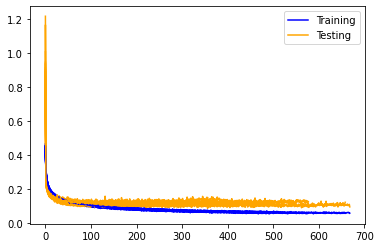

In [30]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

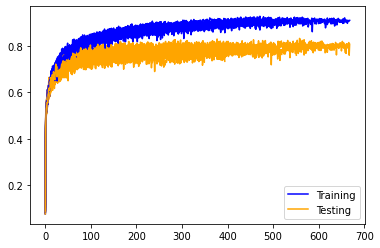

In [31]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

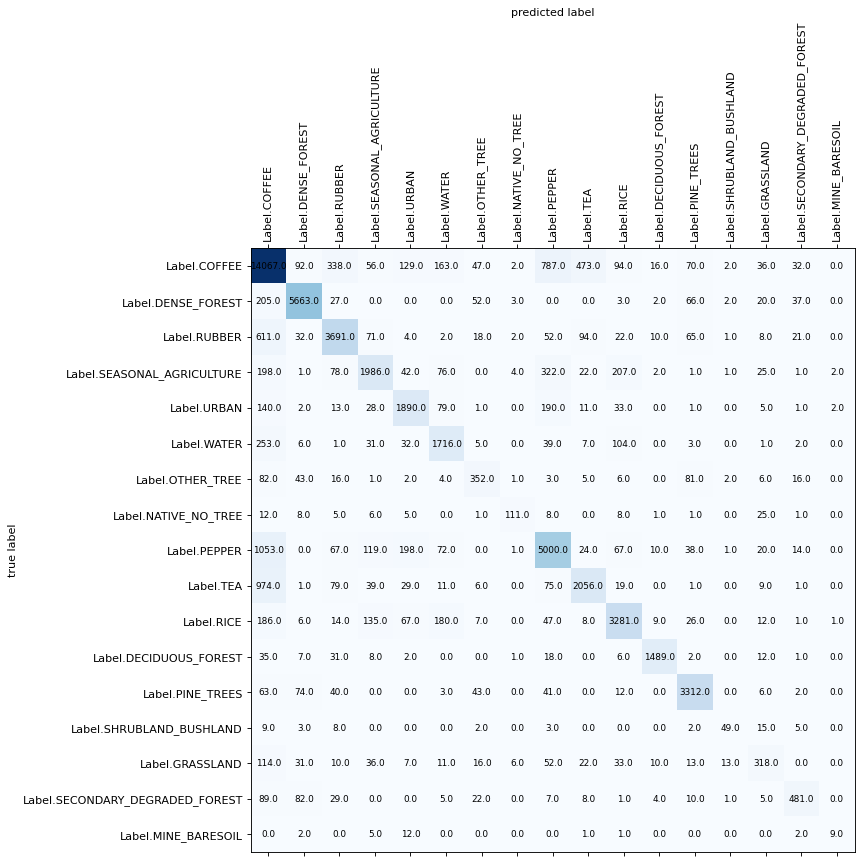

In [32]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [33]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.77756896 0.93556914 0.82999775 0.78778263 0.78131459 0.73901809
 0.61538462 0.84732824 0.7525587  0.75283779 0.84192969 0.95878944
 0.89707476 0.68055556 0.60803059 0.77831715 0.64285714]
Mean precision:  0.7780538135576355

Recalls:  [0.85753475 0.93141447 0.78465136 0.66913747 0.78881469 0.78
 0.56774194 0.578125   0.74805506 0.6230303  0.82437186 0.92369727
 0.92102336 0.51041667 0.45953757 0.64650538 0.28125   ]
Mean recall:  0.6997239493528028

F-Score:  [0.81559646 0.93348718 0.80668779 0.72362908 0.78504673 0.75895621
 0.59060403 0.6873065  0.75030012 0.68181065 0.83305827 0.94091627
 0.90889133 0.58333333 0.52345679 0.70631424 0.39130435]
Mean f-score:  0.7306293729033367


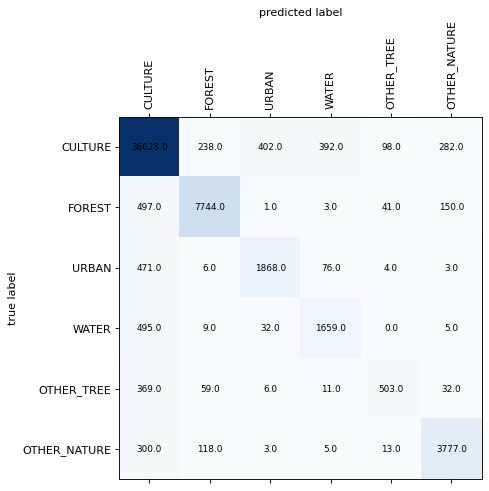

In [34]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [35]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.94499484 0.94739418 0.80795848 0.77306617 0.76327769 0.88891504]
Mean precision:  0.854267732688858

Recalls:  [0.96288118 0.9179706  0.7693575  0.75409091 0.51326531 0.89587287]
Mean recall:  0.8022397260431147

F-Score:  [0.95385417 0.93245033 0.78818565 0.76346065 0.6137889  0.89238039]
Mean f-score:  0.824020015130667
